
# Forecasting Demand for Bike Share Systems

--------

This notebook corresponds to Manuel Hurtado's Capstone Project for the Udacity Data Scientist Nanodegree. It employs the Bike Share Dataset from the UCI Machine Learning Repository, provided by the Laboratory of Artificial Intelligence and Decision Support of the University of Porto, to design, train, and test a Multi-Layer Perceptron to estimate the demand for bikes  -- daily or hourly -- based on a given feature space. Specifically:

***The goal of this project is to provide institutions on the supply-side of shared-economy vehicle platforms with a preemptive estimate of the demand for vehicles in a metropolis in any given day or hour.***

To accomplish this, this notebook will proceed as follows:

   1. **Introduction**
       1. Imports
       2. Data overview
   2. **Data Understanding & Visualization**
       1. How relevant is climatological data in determining Washington residents' willingness to take bicycles?
       2. What is the best time to grab a bike as a casual user?
       3. How popular are bikes as a means of transportation in Washington, D.C.?
       4. Does the price of gasoline play a role in people's choice of transport?
   3. **Data Preparation**
       1. Cleaning
           1. Categorical type casting
           2. Removing Outliers
       2. Preprocessing
           1. Transforming numerical (skewed) continuous features
           2. Normalizing numerical (skewed) continuous features
           3. One-hot encoding categorical variables
   5. **Model Design and Training**
       1. Benchmark
           1. Design
           2. Train
       2. MLP
           1. Design
           2. Train
   7. **Evaluation and Discussion**
       1. Daily MLP Performance
       2. Houry MLP Performance
       
       

## Imports

Libraries to be used in this notebook:

In [1]:
# Preliminary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import data
bike_daily = pd.read_csv('Data/Bike_Data/day.csv', 
                         parse_dates={'date':[1]})
bike_hourly = pd.read_csv('Data/Bike_Data/hour.csv', 
                          parse_dates={'date':[1]})

## Data Overview

As it can be inferred from the code above, the data employed in this notebook comes in two different formats:

   1. **Daily**
   2. **Hourly**
   
   
### Data Inspection

In [2]:
# Check day_data
bike_daily.head(4)

date  instant  season  yr  mnth  holiday  weekday  workingday  \
0 2011-01-01        1       1   0     1        0        6           0   
1 2011-01-02        2       1   0     1        0        0           0   
2 2011-01-03        3       1   0     1        0        1           1   
3 2011-01-04        4       1   0     1        0        2           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   

    cnt  
0   985  
1   801  
2  1349  
3  1562

In [3]:
# Check hour_data
bike_hourly.head(4)

date  instant  season  yr  mnth  hr  holiday  weekday  workingday  \
0 2011-01-01        1       1   0     1   0        0        6           0   
1 2011-01-01        2       1   0     1   1        0        6           0   
2 2011-01-01        3       1   0     1   2        0        6           0   
3 2011-01-01        4       1   0     1   3        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13

## Label Analysis

From the above DataFrame headers, we can get a glimpse of all 17 labels in the dataset. A more complete description of what they entail is in place*:

	- instant: record index
	- date: date
	- season: season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr: year (0: 2011, 1:2012)
	- mnth: month ( 1 to 12)
	- hr: hour (0 to 23) (For hourly data only)
	- holiday: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday: day of the week
	- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit: 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp: Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

**NOTE: day_df has one less feature than hour_df, and that is `hr`.**

*All credit to the Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto

Out of all the labels above, it becomes evident that there is only one that is entirely irrelevant, and that is 
`instant`. 

`instant` simply records the index of each row, starting from 1. Because this has no correlation whatsoever with the total count of used bycicles in a given day or hour, we can discard it from both dataframes:

In [4]:
# Remove 'instant' from day and hour DataFrames
bike_daily = bike_daily.drop('instant', axis=1)
bike_hourly = bike_hourly.drop('instant', axis=1)

In [5]:
# Overview of daily data frame, check for NaNs
bike_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
date          731 non-null datetime64[ns]
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(10)
memory usage: 85.7 KB


In [6]:
# Overview of hourly Data Frame, check for NaNs
bike_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
date          17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(11)
memory usage: 2.1 MB


In [7]:
# Compute proportion of bike_daily count totals by year
yearly_counts = bike_daily.groupby('yr')['cnt'].sum().values

# Report
print("The total counts for the year 2011 are {}".format(yearly_counts[0]))
print("The total counts for the year 2012 are {}".format(yearly_counts[1]))
print("\n\nThe ratio of 2012:2011 counts is {:.4f}".format(yearly_counts[1] / yearly_counts[0]))

The total counts for the year 2011 are 1243103
The total counts for the year 2012 are 2049576


The ratio of 2012:2011 counts is 1.6488


As it can be interpreted from the above outputs, the data is relatively clean: **there are no `NaN`s in the records**, and the fact that the string-based values for labels like `season` and `weathersit` have been converted to integer values makes it unnecessary to clean string elements. 

Although some preprocessing steps such as converting to categorical values and normalizing numerical ones are still required, a large part of the data cleaning process can be circumvented. This makes the dataset an ideal one to employ in an attempt to answer the questions pursued in this notebook.

# Data Understanding & Visualization

Before proceeding to clean the data, this section attempts to explore the the dataset in further detail, 

It also employs simple statistical/visual techniques to find answers to the following exploratory questions that allow us to better glean insights from the data, as opposed to proceeding to simply predict the target variable:

   1. *How relevant is climatological data in determining Washington residents' willingness to take bicycles?*
   2. *What is the best time to grab a bike as a casual user?*
   3. *How popular are bikes as a means of transportation in Washington, D.C.?*
   4. *Does the price of gasoline play a role in people's choice of transport?*

## *How relevant is climatological data in determining Washington residents' willingness to take bicycles?*

The proclivity of a given individual to ride a bike usually rests upon the notion of the weather. If it is raining, people will seldom take a bike to work. If it is sunny, on the contrary, they might find it more enjoyable. Understanding the behavior that each of these poles induces allows us to probe further: 

   *How relevant is climatological data in determining Washington residents' willingness to use bicycles?*
   
To find the answer to this question, we can first analyze the degree to which the target variables `casual`, `registered`, and `cnt` are correlated with climatological data (`weathersit`, `temp`, `atemp`, `windspeed`).

However, to get a better understanding of the degree of importance of these climatological variables, it is good to heatmap of the correlation between all variables, so that we can gauge the relative weight of the climate data versus other predictor features.

In [8]:
# Define heatmap plotter method
def heatmap(data, interval, filename):
    '''
    Plots heatmap of correlation data.
    '''
    # Figure
    fig = plt.figure(figsize=(10, 10))
    
    # Data series
    ax = sns.heatmap(
        data, linewidths=0.3, square=True, annot=True, annot_kws={'size': 9})
    
    # Format
    plt.xticks(rotation=60)
    plt.title(interval + ' Bike Usage Dataset Correlations', fontweight='bold')
    
    # Save
    plt.savefig('Plots/' + filename + '.pdf')
    
    plt.show()

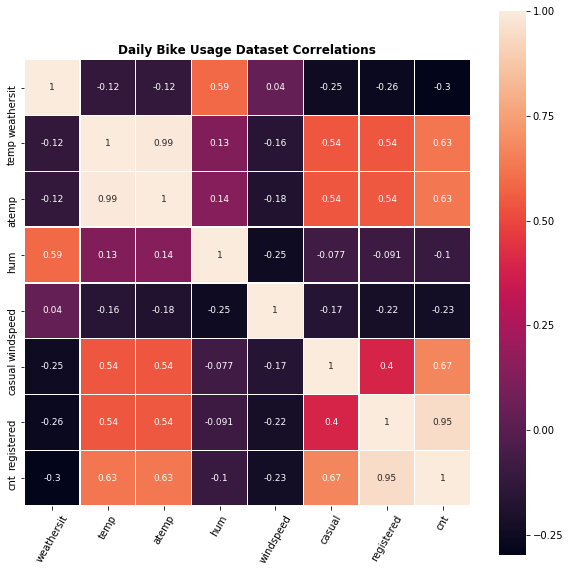

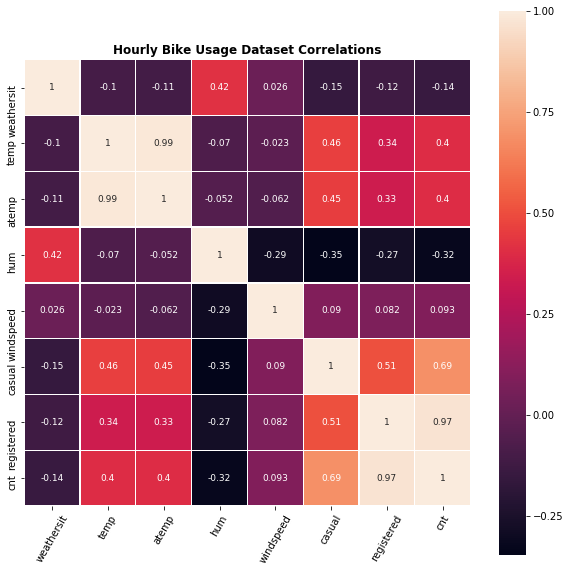

In [9]:
# Plot heatmap for hourly bike usage 
numeric = [
    'weathersit', 'temp', 'atemp', 
    'hum', 'windspeed', 'casual', 'registered', 'cnt'
]
heatmap(bike_daily[numeric].corr(), 'Daily', 'bike_daily_heatmap')
heatmap(bike_hourly[numeric].corr(), 'Hourly', 'bike_hourly_heatmap')

The above heatmaps reveal that, surprisingly, *the weather situation (rainy, cloudy, sunny, etc.) does not play anywhere near as significant a role in people's decision to use bikes than does the **temperature** (both actual and perceived), with only a 10% variation depending on whether they are casual or registered users*. 

This is striking, since it would suggest that bike sharing businesses can reamin a profitable business even in locations with sub-optimal weather patterns.

Interestingly, casual users are more influenced by temperature than are registered users. This makes sense, because if you don't pay money on a monthly basis for a service, you can more easily exempt yourself from using it if the experience will be sub-optimal due to adverse weather conditions.

Yet, how exactly do weather conditions affect the number of bike users, casual and registered? To find out, we can easily group the number of users by `weathersit` and examine the results.  

In [10]:
# Plotter function
def lineplot_reg_v_casual(df, interval, rotation, filename, rolling=False, window=50):
    '''
    Plots lineplot of DataFrame series data grouped by 
    specified interval.
    
    Args:
        - df: DataFrame to extract data from.
        - interval: Interval to group data by.
        - rotation: Degrees to rotate xticks by.
        - rolling: Whether to plot the rolling mean of the data.
        - window: Window to calculate the rolling mean.
        
    Returns:
        - None
    '''
    fig = plt.figure(figsize=(15, 10))
    plt.style.use('seaborn')

    # Plot interval-grouped series 
    plt.plot(df.groupby(interval)['registered'].mean())
    plt.plot(df.groupby(interval)['casual'].mean())

    if rolling:
        # Compute rolling means
        reg_rolling_mean = df.groupby(interval)['registered'].mean().rolling(
            window=window).mean()
        casual_rolling_mean = df.groupby(interval)['casual'].mean().rolling(
            window=window).mean()
        
        # Plot rolling means
        plt.plot(reg_rolling_mean, lw=2)
        plt.plot(casual_rolling_mean, lw=2)

    # Format
    plt.ylabel('User Counts')
    plt.xlabel(interval)
    plt.xticks(rotation=rotation)
    plt.title(
        'Count of Registered vs. Casual Bike Users by ' + interval,
        fontweight='bold')
    plt.legend(['Registered', 'Casual',
                'Registered Rolling Mean', 'Casual Rolling Mean'])

    # Save
    plt.savefig('Plots/' + filename + '.pdf')
    
    plt.show()

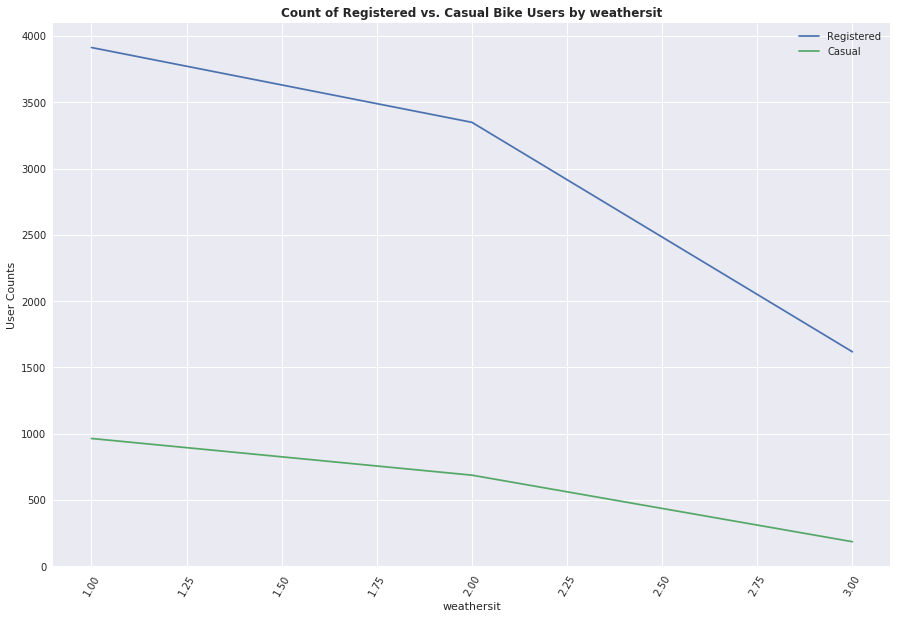

In [11]:
# Plot casual vs. registered users by weather situation
lineplot_reg_v_casual(bike_daily, 'weathersit', 60, filename='bike_daily_byweathersit')

The plot above highlights an expected trend: as the weather conditions worsen (axis increases from 1 to 4), the number of bike users drops considerably. Registered users seem to be more responsive to these variations in weather. 

Importantly, there are no data values for a `weathersit` value of `4`. This is expected: nobody would take bikes during a storm of ice pellets.

**In conclusion, then, although both casual and registered users respond logically to worsening weather conditions by reducing their bike usage, it would seem that temperature plays a more defining role in people's willingness to opt for this alternative method of transportation.**

## *Do casual and registered users share common bike usage patterns?*

Another question that would be interesting to explore using the data at hand is whether the bike systems in place in Washington D.C. can meet the demand of both registered and casual users at once. That is:

*Do casual and registered users share common bike usage patterns?*

Answering this question is important because it can help us understand how the demand for bikes works in a specific urban environment. This could help better paint a picture for prospective bike-sharing businesses looking to offer the service in new cities to gauge the optimal number of bikes they should supply in order to maximize their revenues and minimize their costs.

To look into this, we can first visualize the long-term trends in bike usage for both casual and registered users.

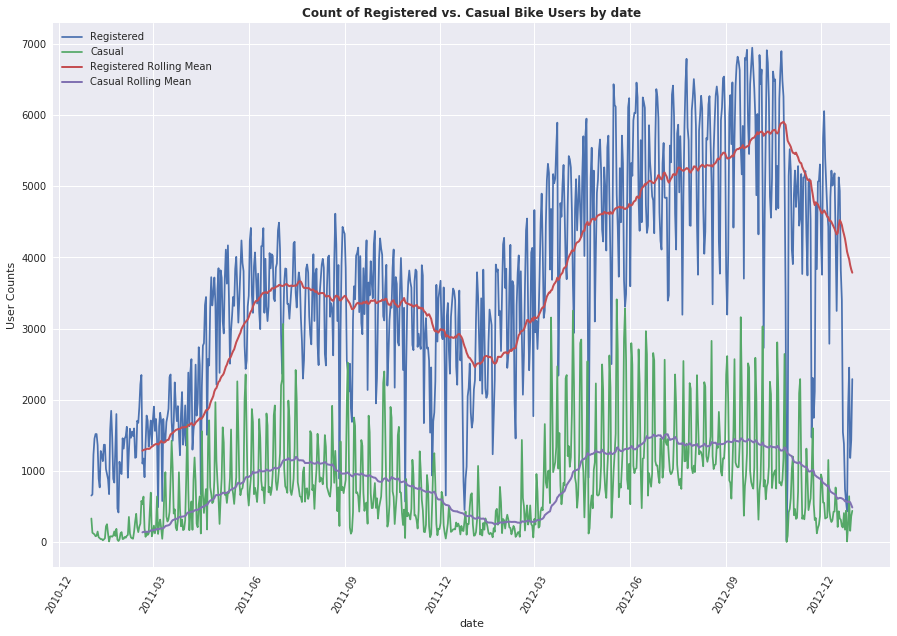

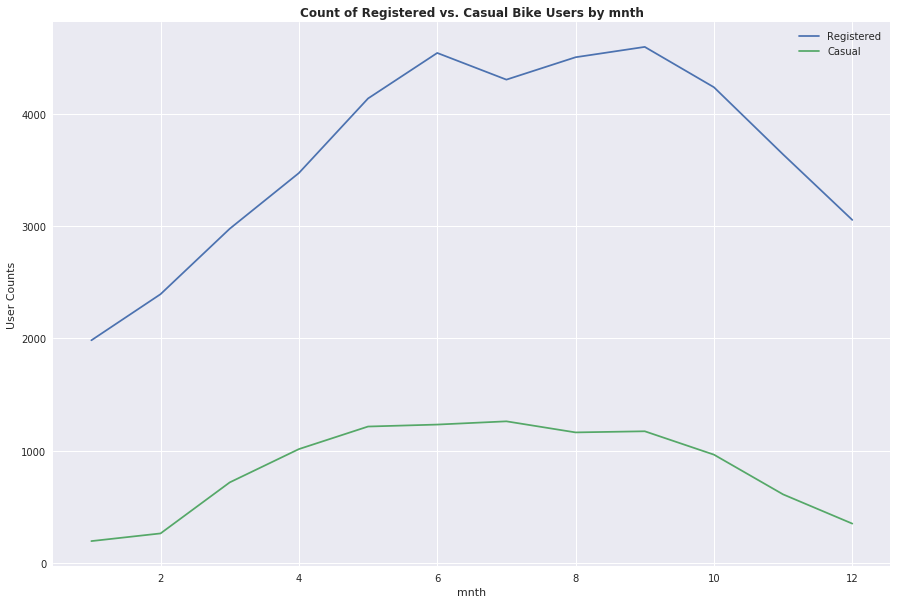

In [12]:
# Plot relationships by date and month
lineplot_reg_v_casual(bike_daily, 'date', 60, 'bike_daily_bydate', True)
lineplot_reg_v_casual(bike_daily, 'mnth', 0, 'bike_hourly_bydate')

The above charts reveal an important insight: in the long term, registered and casual users express, by and large, the same rising and falling interest for bike usage. 

If we examine the second chart in detail, we can see that the insight drawn from Q1 is applicable: warmer months (mid-year) warrant greater bike usage, while those with colder temperatures (beginning and end of the year) do not. 

And yet, we cannot assume from this that casual and registered users use bikes with the same recurring patterns throughout their daily lives. Otherwise, why would casual users exist at all? Most likely, the answer can be found by examining bike usage by `weekday`. 

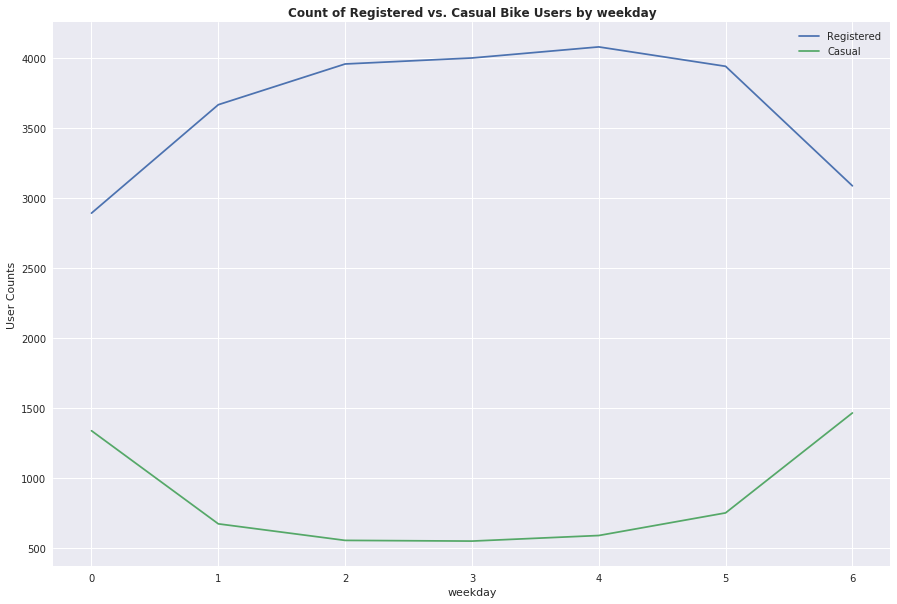

In [13]:
# Plot relationships by weekday
lineplot_reg_v_casual(bike_daily, 'weekday', 0, 'bike_daily_byweekday')

The chart above highlights the key difference between casual and registered users: *while registered users prefer to use bikes to go to and from work, casual users prefer to use them for leisure purposes during the weekends*. 

If we combine the last two charts, grouping `mnth` and `weekday`, we can better understand this long-term vs. short-term relationship:

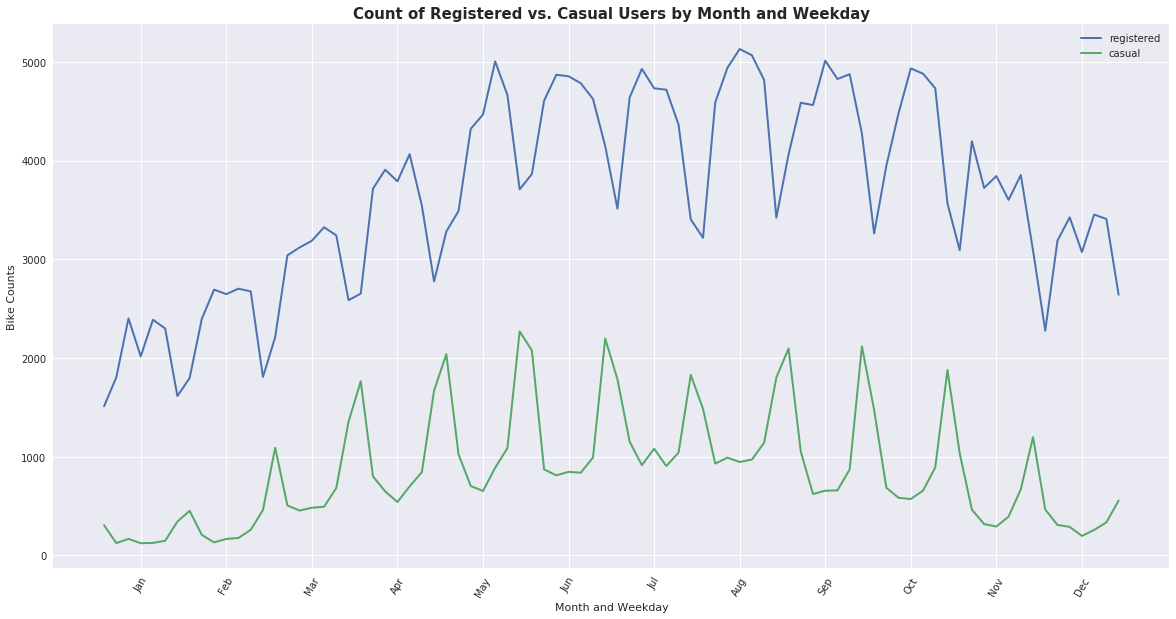

In [14]:
# Plot bike usage by month and weekday

# Data series
bike_daily.groupby(['mnth', 'weekday'])[['registered', 'casual']].mean().plot(
    figsize=(20, 10), lw=2)

# Format
plt.style.use('seaborn')
plt.ylabel('Bike Counts')
plt.xlabel('Month and Weekday')
plt.xticks(
    range(3, 7 * 12 + 3, 7), [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
        'Nov', 'Dec'
    ],
    rotation=60)
plt.title(
    'Count of Registered vs. Casual Users by Month and Weekday',
    fontweight='bold', fontsize=15)

# Save
plt.savefig('Plots/bike_daily_bymonthweekday.pdf')

plt.show()

The plot above exemplifies the dichotomy between the long-term and short-term bike usage patterns of registered and casual users:

1. **In the *long term* (year), bike usage from registered and casual users increases during warmer months and falls during colder months. This is most likely due to the temperatures associated with these days.**
2. **In the *short term* (week), bike usage from registered users falls during weekends but increases during weekdays, while casual users do the contrary. This is most likely due to casual users using bikes for leisure purposes primarily.**

## *Does the price of gasoline play a role in people's choice of transport?*

The last question to be considered for a hypothetical business willing to enter the market for bike sharing in Washington D.C. or another city of similar demographics could be the way in which the cost-savings from riding bikes could factor into the decision to use bikes. For instance:

***Does the price of gasoline play a role in people's choice of transport***?

To answer this question, we will integrate daily price data for West Texas Intermediate (WTI), taken from [DataHub.io](https://datahub.io/core/oil-prices), into our daily bike usage dataset. 

We can then plot the price and bike usage data for the two-year period of the dataset, and identify patterns in figure fluctuations.

In [15]:
# Import daily crude oil (West Texas Intermediate) price data
oil_daily = pd.read_csv(
    'Data/Oil_Data/wti-daily.csv',
    parse_dates=[0],
    names=['date', 'price'],
    skiprows=1)

# Check results
oil_daily.head()

date  price
0 1986-01-02  25.56
1 1986-01-03  26.00
2 1986-01-06  26.53
3 1986-01-07  25.85
4 1986-01-08  25.87

In [16]:
# Check for NaNs
oil_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8356 entries, 0 to 8355
Data columns (total 2 columns):
date     8356 non-null datetime64[ns]
price    8356 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 130.6 KB


In [17]:
# Merge daily datasets on date
bike_oil_daily = pd.merge(bike_daily, oil_daily, how='inner', on='date')

# Check results
bike_oil_daily.head()

date  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0 2011-01-03       1   0     1        0        1           1           1   
1 2011-01-04       1   0     1        0        2           1           1   
2 2011-01-05       1   0     1        0        3           1           1   
3 2011-01-06       1   0     1        0        4           1           1   
4 2011-01-07       1   0     1        0        5           1           2   

       temp     atemp       hum  windspeed  casual  registered   cnt  price  
0  0.196364  0.189405  0.437273   0.248309     120        1229  1349  91.59  
1  0.200000  0.212122  0.590435   0.160296     108        1454  1562  89.39  
2  0.226957  0.229270  0.436957   0.186900      82        1518  1600  90.30  
3  0.204348  0.233209  0.518261   0.089565      88        1518  1606  88.37  
4  0.196522  0.208839  0.498696   0.168726     148        1362  1510  88.07

In [18]:
# Merge hourly dataset on date with price data
bike_oil_hourly = pd.merge(bike_hourly, oil_daily, how='inner', on='date')

# Check results
bike_oil_hourly.head()

date  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0 2011-01-03       1   0     1   0        0        1           1           1   
1 2011-01-03       1   0     1   1        0        1           1           1   
2 2011-01-03       1   0     1   4        0        1           1           1   
3 2011-01-03       1   0     1   5        0        1           1           1   
4 2011-01-03       1   0     1   6        0        1           1           1   

   temp   atemp   hum  windspeed  casual  registered  cnt  price  
0  0.22  0.1970  0.44     0.3582       0           5    5  91.59  
1  0.20  0.1667  0.44     0.4179       0           2    2  91.59  
2  0.16  0.1364  0.47     0.3881       0           1    1  91.59  
3  0.16  0.1364  0.47     0.2836       0           3    3  91.59  
4  0.14  0.1061  0.50     0.3881       0          30   30  91.59

In [19]:
# Define method to plot rolling mean


def plot_rolling_mean(df, features, window, filename):
    '''
    Plots rolling mean of the series data
    in the columns (features) of the DataFrame provided.
    
    Args:
        - df: DataFrame
        - features: Series to use as data
        - window: Window to calculate rolling data from
    
    Returns:
        - None.
    '''
    # Figure
    fig, ax1 = plt.subplots(figsize=(16, 10))

    # First data series
    rolling_mean_1 = df.groupby('date')[features[0]].mean().rolling(
        window=window).mean()
    ax1.plot(rolling_mean_1, color='tab:blue')

    # First axis format
    ax1.set_ylabel(str(window) + '-Day Rolling Average of User Counts')
    ax1.set_xlabel('Date')

    # Second data series
    ax2 = ax1.twinx()
    rolling_mean_2 = df.groupby('date')[features[1]].mean().rolling(
        window=window).mean()
    ax2.plot(rolling_mean_2, color='tab:green')

    # Second axis format
    ax2.set_ylabel(str(window) + '-Day Rolling Average of Oil Price (USD)')

    # Format
    fig.legend(['Cnt', 'Price'])
    plt.style.use('seaborn')
    plt.title(
        '10-Day Rolling Averages of Bike Users and Oil Prices',
        fontweight='bold',
        fontsize=15)
    plt.grid(False)

    # Save
    plt.savefig('Plots/' + filename + '.pdf')
    
    plt.show()

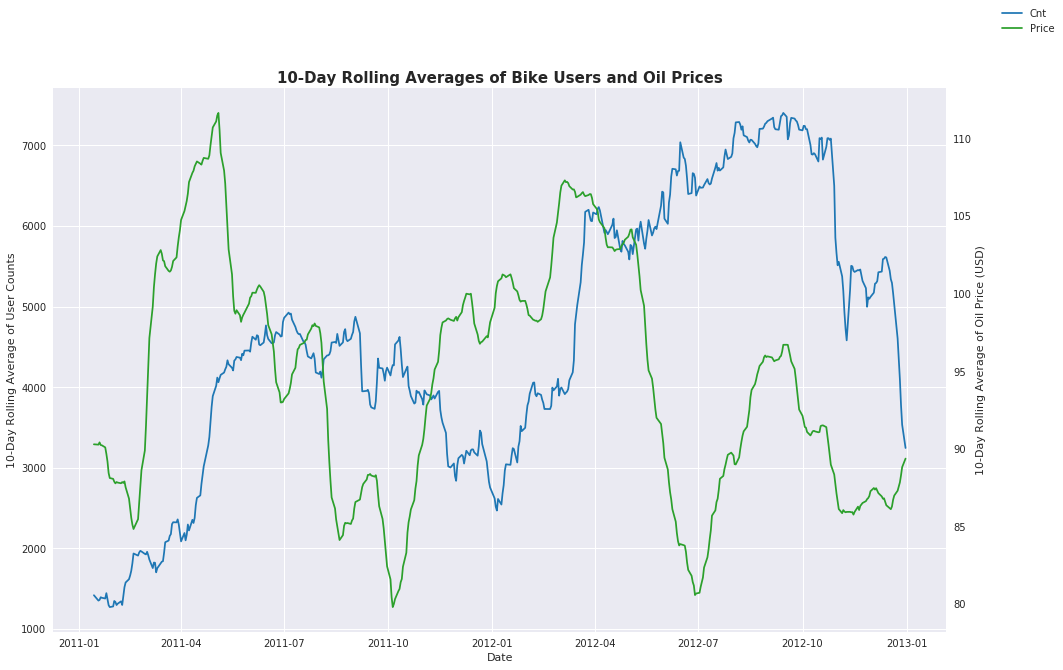

In [20]:
# Plot 10-day rolling means of bike usage counts
# and oil price data for 2011 and 2012
plot_rolling_mean(bike_oil_daily, ['cnt', 'price'], 10, 'bike_oil_daily_rolling')

The plot above evidences that there is no clear correlation between the price of oil and the number of bike users at any given time during both years. Rather, it would seem that instead of fluctuating inversely to the price of oil, the count ob bike users "trails" behind it by 2-3 months.

As a matter of fact, if we visualize the statistical correlation between these two variables, we will find it to be tenuous, at best:

In [21]:
# Compute correlation between 'cnt' and 'Price'
bike_oil_hourly[['cnt', 'price']].corr()

cnt     price
cnt    1.000000 -0.083848
price -0.083848  1.000000

Despite being clearly negative, the correlation remains too close to 0 for a true "inverse" relationship to be identified. 

**In conclusion, therefore, a new entrant into the bike sharing marketplace in Washington, D.C. should not rely on oil price data to gauge the likelihood of bike users for any given time period.**

## *How popular are bikes as a means of transportation in Washington, D.C.?*

For a company looking to venture into the bike-sharing business, it would be important to understand how the market for bike usage stands in any given city they are setting their aims on. While one could argue that the Washington D.C. market is already capped, the data obtained from Washington D.C. could be analyzed to glean insights from cities that are similar. 

A relevant insight that a company would be interested in gleaning from this data is:

***How popular is bike usage in Washington D.C. as a means of transportation?***

To answer this question, we could compare the total amount of bikes used on a daily basis in Washington vs the daily traffic volumes for the city. 

Unfortunately, there is no data available online for daily traffic volumes, as measured by different measurement instruments scattered around the city. Rather, the data available pertains to Annualized Average Daily Traffic (AADT) for each of these measuring instruments - a single figure that states the average daily traffic volume for any given day during a specific year. 

By calculating the mean AADT of all these different measurement devices we can obtain an overall AADT for the city of Washington in the years 2011 and 2012, and compare daily bike usage statistics to that. 

In [22]:
# Import data for Annualized Average Daily Traffic (AADT)
aadt = pd.read_json('Data/Traffic_Data/traffic_counts.json', orient='records')

The yearly AADT data has been obtained from [Open Data DC](http://data.codefordc.org/dataset/traffic-counts-annual-average-by-count-station-mwcog). It contains AADT measurements for instruments laid out in the D.C. and surrounding area.

In [23]:
# Examine import
aadt.head()

features               type
0  {'type': 'Feature', 'properties': {'OBJECTID':...  FeatureCollection
1  {'type': 'Feature', 'properties': {'OBJECTID':...  FeatureCollection
2  {'type': 'Feature', 'properties': {'OBJECTID':...  FeatureCollection
3  {'type': 'Feature', 'properties': {'OBJECTID':...  FeatureCollection
4  {'type': 'Feature', 'properties': {'OBJECTID':...  FeatureCollection

Unfortunately, the way the `JSON` data is structured in the online database is fitting for a JavaScript application that plots the geographical location of each point on a map. 

This alternative structure does not fit well with the Pandas `.read_json` method. We therefore need to do some cleaning of the data before being able to use it.

First, we can get rid of the `type` column.

In [24]:
# Drop 'type' column
aadt = aadt.drop('type', axis=1)

Next, we need to break down the elements of the `features` column (`dict`s), to extract the `column (key) -> value` pairs listed in the dictionaries.

To do this, we will iterate over each of the rows using `splitter`, and select the `value` stored in the `properties` key of the main dictionary. This `value` is a nested dictionary with the `column (key) -> value` pairs we actually want to extract for our DataFrame.

To extract these values, we will use the `split_dict` function, which takes a `data_dict` as input and appends each `value` in `key-value` pairs to a `defaultdict` with each `key` in `data_dict` as a separate key.

The result of this method is a `processed_dict` with the structure `column (feature) -> [list of feature values for all records]`. 

We can then create a DataFrame easily using this `processed dict`.

In [25]:
# Break down 'features' into column->value pairs listed in dicts
# Initialize empty dict to fill out
from collections import defaultdict
processed_dict = defaultdict(list)

def split_dict(data_dict):
    '''
    Iterates over feature-value pairs in the aadt_2011 
    DataFrame and appends the value to the dictionary key
    in processed_dict.
    '''
    for feature, value in data_dict.items():
        processed_dict[feature].append(value)
    
        
def splitter(row):
    '''
    Applies the split_dict function to the dictionary stored
    in the second key ('properties') of the dictionary in 
    each row.
    '''
    split_dict(row['properties'])
    
# Apply splitter to aadt data
aadt.features.apply(func=splitter)
aadt = pd.DataFrame(processed_dict)

# Check results
aadt.head()

AADT1986  AADT1987  AADT1988  AADT1989  AADT1990  AADT1991  AADT1992  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4   54000.0   62200.0   61000.0   54867.0   48733.0   42600.0   44500.0   

   AADT1993  AADT1994  AADT1995   ...     AADT2011  AADT2012  AADT2013  \
0       0.0       0.0       NaN   ...       3084.0       NaN    3069.0   
1       NaN       NaN   18000.0   ...      11252.0   41464.0   41644.0   
2       0.0       0.0       NaN   ...          NaN       NaN       NaN   
3       0.0       0.0       NaN   ...          NaN       NaN       NaN   
4   46000.0   47387.0   48774.0   ...          NaN       NaN       NaN   

   AADT2014      ABPair                County  \
0    2046.0  2064420866  District of Columbia   
1   49172.0  2186721785  District of Columbia   
2    5778.0  2080620807  District of Columbia   
3   12884.0  2194120674  District of Columbia   
4    6098.0  2001121665  District of Columbia   

                                         Description  IsPerm  OBJECTID  \
0  BUTTERNUT ST NW between 9TH ST NW and GEORGIA ...    None         1   
1                Interstate 66 Ramps @Whitehurst Fwy    None         2   
2   Beach Dr NW from Military Rd NW to Bingham Dr NW    None         3   
3      Beach Dr NW from Arizona Ave NW to Dana Pl NW    None         4   
4  South Capitol St between Virginia Ave SW and E...    None         5   

   Station  
0     5411  
1     2221  
2    7175B  
3    7181A  
4    2204C  

[5 rows x 35 columns]

Now that the data has been structured, we can filter for the measuring points that are of interest to us. 

Because bikes are used in the densely-populated urban areas, we can take into consideration only the AADT measurements of the District of Columbia. 

In addition, we extract only the years that are relevant, 2011 and 2012.

In [26]:
# Extract relevant data from dataframe

# Drop unnecessary columns
aadt = aadt[['County', 'AADT2011', 'AADT2012']]
aadt.columns = ['County', '2011', '2012']

# Filter to keep only data from traffic counters in DC area
aadt_dc = aadt[aadt['County'] == 'District of Columbia']

# Check results
aadt_dc.head()

County     2011     2012
0  District of Columbia   3084.0      NaN
1  District of Columbia  11252.0  41464.0
2  District of Columbia      NaN      NaN
3  District of Columbia      NaN      NaN
4  District of Columbia      NaN      NaN

In [27]:
# Check nulls
aadt_dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 3753
Data columns (total 3 columns):
County    642 non-null object
2011      634 non-null float64
2012      409 non-null float64
dtypes: float64(2), object(1)
memory usage: 20.1+ KB


The data extracte contains a number of null values for the years 2011 and 2012. 

A simple solution would be to simply fill these using the `fillna` method and imputing the average AADT for each year's measurement devices. However, while this would be pertinent if we were appending daily AADT values to our dataset in order to predict bike usage counts with a model, it is not necessary in our situation: since all we are interested in for the purposes of this question is computing the yearly average AADT from the different measuring devices, we can simply calculate the mean without taking into account the null devices, and get a more veritable result from this computation.

In [28]:
# Find total AADT for each year
aadt_2011 = aadt_dc['2011'].mean()
aadt_2012 = aadt_dc['2012'].mean()

Having computed the mean AADT for the years 2011 and 2012, we can proceed to compute the proportion of bikes to cars in Washington for any given time interval.

**Note: We group by the time intervals, and then compute the *mean* of the aggregated values. This is because we want to obtain the *average* number of bike users for any given day in each one of those time frames, not the *sum* of all the different daily user bike counts that fall under the specified time interval.**

In [29]:
# Compute daily bike-to-car proportions for each year (0 -> 2011, 1 -> 2012)
daily_bike_volume_2011 = bike_daily[bike_daily['yr'] == 0].groupby(
    'weekday')['cnt'].mean().values
daily_bike_proportion_2011 = daily_bike_volume_2011 / aadt_2011

daily_bike_volume_2012 = bike_daily[bike_daily['yr'] == 1].groupby(
    'weekday')['cnt'].mean().values
daily_bike_proportion_2012 = daily_bike_volume_2012 / aadt_2012

In [30]:
# Compute monthly bike-to-car proportions for each year (0 -> 2011, 1 -> 2012)
monthly_bike_volume_2011 = bike_daily[bike_daily['yr'] == 0].groupby(
    'mnth')['cnt'].mean().values
monthly_bike_proportion_2011 = monthly_bike_volume_2011 / aadt_2011

monthly_bike_volume_2012 = bike_daily[bike_daily['yr'] == 1].groupby(
    'mnth')['cnt'].mean().values
monthly_bike_proportion_2012 = monthly_bike_volume_2012 / aadt_2012

In [31]:
# Compute seasonal bike-to-car proportions for each year (0 -> 2011, 1 -> 2012)
seasonal_bike_volume_2011 = bike_daily[bike_daily['yr'] == 0].groupby(
    'season')['cnt'].mean().values
seasonal_bike_proportion_2011 = seasonal_bike_volume_2011 / aadt_2011

seasonal_bike_volume_2012 = bike_daily[bike_daily['yr'] == 1].groupby(
    'season')['cnt'].mean().values
seasonal_bike_proportion_2012 = seasonal_bike_volume_2012 / aadt_2012

In [32]:
# Define plotter function
def plotter(series1, series2, title, xticks, filename):
    '''
    Plots a two-series line plot of bike usage proportions, 
    one series per year (2011 and 2012). The proportion is 
    computed as the number of bikes per 100 cars.
    '''
    # Figure
    fig = plt.figure(figsize=(15, 10))
    
    # Data
    plt.plot(series1 * 100.0); plt.plot(series2 * 100.0)
    
    # Format
    plt.style.use('seaborn')
    plt.ylabel('User Counts')
    plt.xticks(range(len(xticks)), xticks)
    plt.xlabel(title.split()[-1])
    plt.title(title, fontweight='bold')
    plt.legend(['2011', '2012'])
    
    # Save
    plt.savefig('Plots/' + filename + '.pdf')
    
    plt.show()

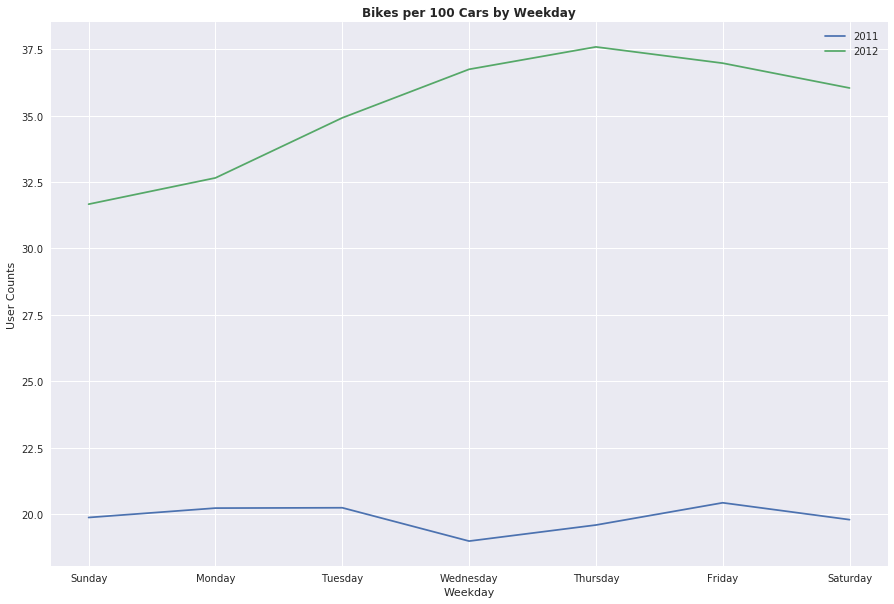

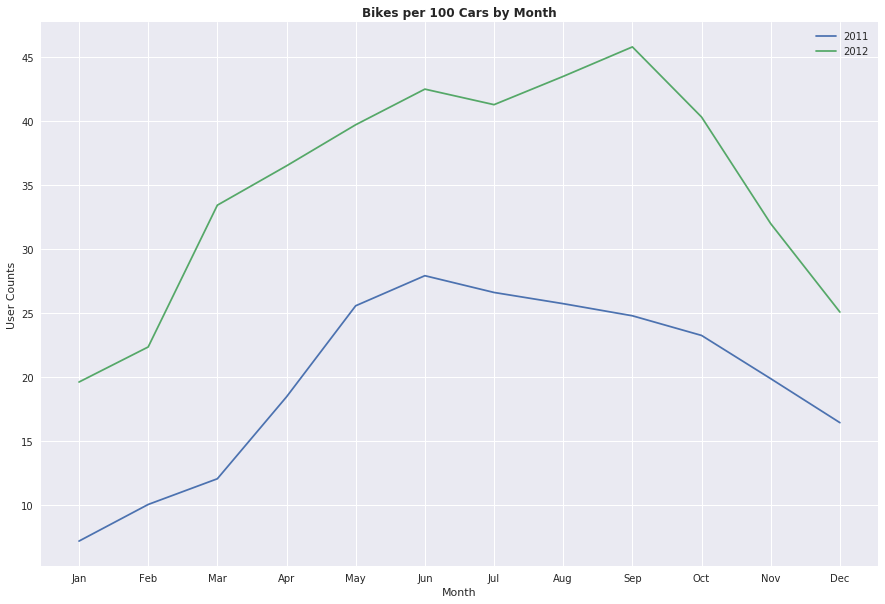

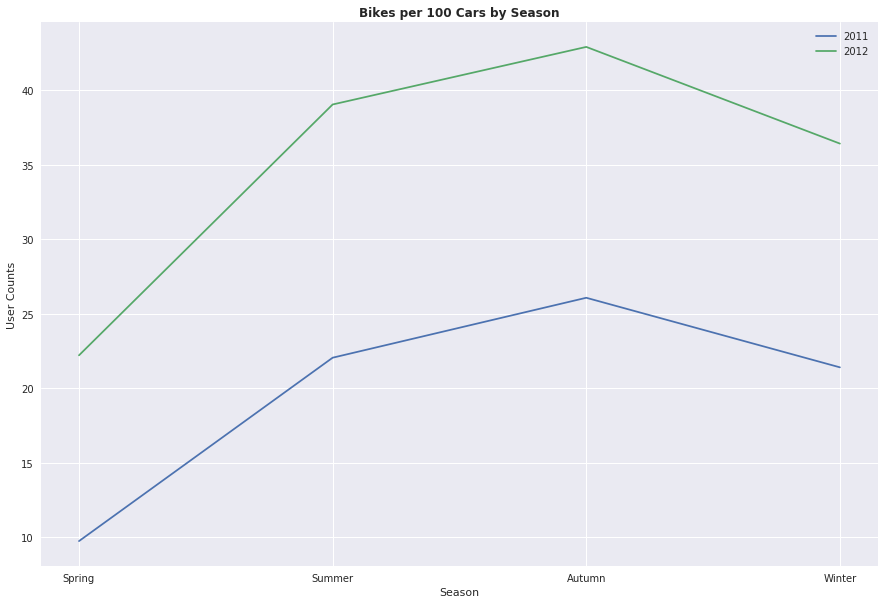

In [33]:
# Plot daily BTC Ratio
weekdays = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
    'Saturday'
]
plotter(daily_bike_proportion_2011, daily_bike_proportion_2012,
        'Bikes per 100 Cars by Weekday', weekdays,
        'daily_bike_proportion_byyear')

# Plot monthly BTC Ratio
months = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
plotter(monthly_bike_proportion_2011, monthly_bike_proportion_2012,
        'Bikes per 100 Cars by Month', months,
        'monthly_bike_proportion_byyear')

# Plot seasonal BTC Ratio
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
plotter(seasonal_bike_proportion_2011, seasonal_bike_proportion_2012,
        'Bikes per 100 Cars by Season', seasons,
        'seasonal_bike_proportion_byyear')

From the graphs above, we can deduce that the proportion of bikes to cars is, at best, `42:100`. 

*More significantly, it would seem that bikes become most popular on: Thursdays and Fridays (weekly level); June through September (monthly); and Autumn (seasonally).*

However, is there a long-term evidence that bikes are becoming more popular over time?

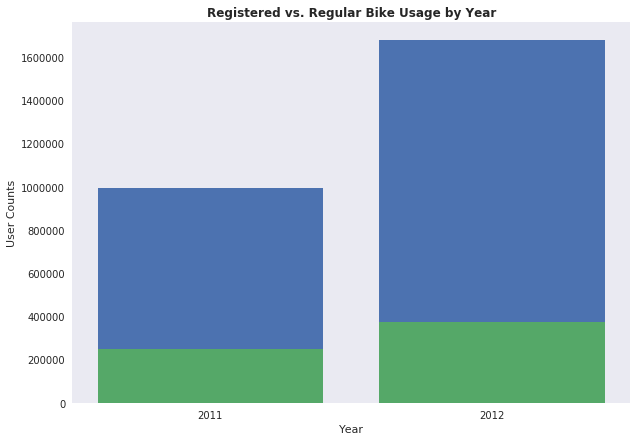

In [34]:
# Plot bike usage for different years

# Figure
fig = plt.figure(figsize=(10, 7))

# Data Series
plt.bar(
    x=['2011', '2012'], height=bike_daily.groupby('yr')['registered'].sum())
plt.bar(x=['2011', '2012'], height=bike_daily.groupby('yr')['casual'].sum())

# Format
plt.style.use('seaborn')
plt.xlabel('Year')
plt.ylabel('User Counts')
plt.title('Registered vs. Regular Bike Usage by Year', fontweight='bold')
plt.grid(False)

# Save
plt.savefig('Plots/reg_v_casual_bike_usage_byyear.pdf')

plt.show()

**In conclusion, therefore, Washington D.C. residents seem to use bikes a third or less as many cars as appear on the road. In the short-term, this means of transportation becomes most popular on Thursdays and Fridays (weekly level), June through September (monthly level), and Autumn (seasonal level). In the long-term, however, this means of transportation is gaining traction, increasing in popularity both for casual and registered users from 2011 to 2012.**

# Data Preparation

## Preliminary Transformations: Target Variable

### Discussion

The bike sharing dataset presently contains three target variables: `casual`, `registered`, and `cnt`. These correspond to the number of casual, registered, and total bike users in any given day/hour in Washington, D.C.

The purpose of this notebook is to design and train a model that can predict the number of bike users for any given day in any future year. Although it may at first seem that the data at hand is useful to do this, there is a big issue at hand:

*The target variables contained in the dataset correspond to the years 2011 and 2012.*

As it can be seen in the sequence of questions above, although there *are* patterns in bike usage across both years (i.e. summer months tend to be more popular, weekdays are usually more popular as well, etc.), **the total number of bike users has increased absolutely from 2011 to 2012**. 

In other words, although our model will be exposed to a set of seasonal, monthly, and daily trends, the overarching trend that it would need to take into account is that the total number of bike users for any of these intervals will be higher in 2012 than in 2011, perhaps because bikes are slowly becoming more popular in the long-term. 

To instruct our model on this overarching trend, we could do one of two things:

   1. First, we could simply feed the model the `yr` feature as one of the predictor variables. This would allow it to identify the overarching trend. The drawback to this approach, however, is that we would be severely hampering the ability of our model to generalize properly: if we train it to predict the trends in 2011 and 2012 specifically, then how useful is it when we want to predict the number of bike users in a day of 2013?
   2. The second approach we can take is that instead of attempting to predict the total number of bikes on any given day, we can try to predict the **proportion of bikes to cars** for any given day in that year, using that year's AADT. This circumvents the issue encountered in the first alternative, because we can safely assume that the number of cars on the road will also increase year-on-year, so the **proportion** will remain more consistent. 
   
The utility of our model, then, would lie in a company producing an estimate of the year's AADT, and, by computing the proportion of bikes to cars for any given day in that year using our model, they could then obtain an estimate of the total number of bikes for that such day.

Because we are working with the assumption that the AADT will be the same for all 365 days of the year (we do not have data that allows us to make more granular considerations), we can also divide this value by  

### Implementation

To implement this alternative in the daily bike dataset, then, we would simply need to create a new column feature with the proportion of bikes to cars for any given day in each year, using the varaibles that we computed earlier, `aadt_2011` and `aadt_2012`. 

In [35]:
# Create daily 'btc' column for bike-to-car ratio
bike_daily['btc'] = 0

# Fill values for 2011
bike_daily.loc[bike_daily.date.dt.year == 2011, 'btc'] = bike_daily[
    bike_daily.date.dt.year == 2011].cnt / aadt_2011

# Fill values for 2012
bike_daily.loc[bike_daily.date.dt.year == 2012, 'btc'] = bike_daily[
    bike_daily.date.dt.year == 2012].cnt / aadt_2012

# Check results
bike_daily.head()

date  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0 2011-01-01       1   0     1        0        6           0           2   
1 2011-01-02       1   0     1        0        0           0           2   
2 2011-01-03       1   0     1        0        1           1           1   
3 2011-01-04       1   0     1        0        2           1           1   
4 2011-01-05       1   0     1        0        3           1           1   

       temp     atemp       hum  windspeed  casual  registered   cnt       btc  
0  0.344167  0.363625  0.805833   0.160446     331         654   985  0.057505  
1  0.363478  0.353739  0.696087   0.248539     131         670   801  0.046763  
2  0.196364  0.189405  0.437273   0.248309     120        1229  1349  0.078756  
3  0.200000  0.212122  0.590435   0.160296     108        1454  1562  0.091191  
4  0.226957  0.229270  0.436957   0.186900      82        1518  1600  0.093409

To implement it in the hourly bike dataset, we would simply need to create a new column feature with the proportion of bikes to cars for any given hour in each year (AADT / 24), using the variables `aaht_2011` and `aaht_2012`, where `aaht_2011 = aadt_2011 / 24` and `aaht_2012 = aadt_2012 / 24`.

In [36]:
# Create 'aaht_2011' and 'aaht_2012' variables
aaht_2011 = aadt_2011 / 24.0
aaht_2012 = aadt_2012 / 24.0

# Create hourly 'btc' column for bike-to-car ratio
bike_hourly['btc'] = 0

# Fill values for 2011
bike_hourly.loc[bike_hourly.date.dt.year == 2011, 'btc'] = bike_hourly[
    bike_hourly.date.dt.year == 2011].cnt / aaht_2011

# Fill values for 2012
bike_hourly.loc[bike_hourly.date.dt.year == 2012, 'btc'] = bike_hourly[
    bike_hourly.date.dt.year == 2012].cnt / aaht_2012

# Check results
bike_hourly.head()

date  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0 2011-01-01       1   0     1   0        0        6           0           1   
1 2011-01-01       1   0     1   1        0        6           0           1   
2 2011-01-01       1   0     1   2        0        6           0           1   
3 2011-01-01       1   0     1   3        0        6           0           1   
4 2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  casual  registered  cnt       btc  
0  0.24  0.2879  0.81        0.0       3          13   16  0.022418  
1  0.22  0.2727  0.80        0.0       8          32   40  0.056046  
2  0.22  0.2727  0.80        0.0       5          27   32  0.044837  
3  0.24  0.2879  0.75        0.0       3          10   13  0.018215  
4  0.24  0.2879  0.75        0.0       0           1    1  0.001401

## Preliminary Transformations: `Date`

Before proceeding to answer the stipulated questions, we need to address the `Date` feature. 

As it is currently presented, the feature contains the date for the record in the `YYYY-MM-DD` format. Although this datestamp may be useful for record-keeping purposes, it is virtually meaningless in the context of our investigation. This is because the specific **date** in which a certain number of bikes were used is of no relevance to our model's capability to generalize: if the number of bikes on, say, the 7th of February is excessively low for 2011, perhaps it was particularly cold, or particularly windy - perhaps the winter that year was excessively chilly. 

Notwithstanding, what *could* be useful to our analysis would be to try to find relationships between the days of month and the month itself. That is, perhaps the 9th of May is a holiday in Washington, and therefore there tend to be relatively more bikes used on that day *every year*. 

The dataset at hand already contains a relevant feature that can help establish this correlation: `holiday`, which indicates whether the date was a holiday (`1`), or not (`0`). Because the `mnth` feature already indicates the month in which the bike count was recorded, if we extract the `day` column, we can embolden the pattern, so that our model can learn it better in order to generalize well in the future. 

In [37]:
# Create a new 'day' column in DataFrames
bike_daily['day'] = bike_daily.date.dt.day
bike_hourly['day'] = bike_hourly.date.dt.day

In [38]:
# Drop 'date' and 'yr' columns - no longer necessary
bike_daily.drop(['date', 'yr'], axis=1, inplace=True)

# Check results
bike_daily.head()

season  mnth  holiday  weekday  workingday  weathersit      temp     atemp  \
0       1     1        0        6           0           2  0.344167  0.363625   
1       1     1        0        0           0           2  0.363478  0.353739   
2       1     1        0        1           1           1  0.196364  0.189405   
3       1     1        0        2           1           1  0.200000  0.212122   
4       1     1        0        3           1           1  0.226957  0.229270   

        hum  windspeed  casual  registered   cnt       btc  day  
0  0.805833   0.160446     331         654   985  0.057505    1  
1  0.696087   0.248539     131         670   801  0.046763    2  
2  0.437273   0.248309     120        1229  1349  0.078756    3  
3  0.590435   0.160296     108        1454  1562  0.091191    4  
4  0.436957   0.186900      82        1518  1600  0.093409    5

In [39]:
# Drop 'date' and 'yr' columns - no longer necessary
bike_hourly.drop(['date', 'yr'], axis=1, inplace=True)

# Check results
bike_hourly.head(4)

season  mnth  hr  holiday  weekday  workingday  weathersit  temp   atemp  \
0       1     1   0        0        6           0           1  0.24  0.2879   
1       1     1   1        0        6           0           1  0.22  0.2727   
2       1     1   2        0        6           0           1  0.22  0.2727   
3       1     1   3        0        6           0           1  0.24  0.2879   

    hum  windspeed  casual  registered  cnt       btc  day  
0  0.81        0.0       3          13   16  0.022418    1  
1  0.80        0.0       8          32   40  0.056046    1  
2  0.80        0.0       5          27   32  0.044837    1  
3  0.75        0.0       3          10   13  0.018215    1

## Defining Categorical and Numerical Features

For future reference purposes, let's separate the `numerical` columns from the `categorical` ones. 

As noted above, the `yr` feature is of very little interest to us, because it does not help the model generalize: the utility of our model is to be able to predict the number of bike users on a given day based off of a number of variables. There is no use in attempting to find correlations between the number of bikes in 2011 for any given day in March, because the year 2011 will never again be a predicting feature value for future years.

**NOTE: `categorical_daily` and `categorical_hourly` differ in that the latter contains the `hr` feature.**

In [40]:
numerical = ['temp', 'atemp', 'hum', 'windspeed']
categorical_daily = [
    'season', 'mnth', 'day', 'holiday', 'weekday', 'workingday', 'weathersit'
]
categorical_hourly = [
    'season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
    'weathersit'
]

## Categorical Features

### Change categorical features to categorical type

Categorical types are more useful than `object` (or generalized strings) for the purposes of this project, because they occupy less space in memory and allow the features to be used by other python libraries for analysis (ex. `keras.utils.to_categorical`):

In [41]:
# Change daily categorical data to categorical type
bike_daily[categorical_daily] = bike_daily[categorical_daily].apply(
    lambda x: x.astype('category'))

# Check results
bike_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
season        731 non-null category
mnth          731 non-null category
holiday       731 non-null category
weekday       731 non-null category
workingday    731 non-null category
weathersit    731 non-null category
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
btc           731 non-null float64
day           731 non-null category
dtypes: category(7), float64(5), int64(3)
memory usage: 53.5 KB


In [42]:
# Change hourly categorical data to categorical type
bike_hourly[categorical_hourly] = bike_hourly[categorical_hourly].apply(
    lambda x: x.astype('category'))

# Check results
bike_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
season        17379 non-null category
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weathersit    17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
btc           17379 non-null float64
day           17379 non-null category
dtypes: category(8), float64(5), int64(3)
memory usage: 1.2 MB


The last pre-processing step to be taken is simply to one-hot encode the many categorical features included in the dataset. Because the algorithms expect numerical features instead of categorical ones, we simply one-hot encode to create binary 'vectors' for each category.

Because the dataset has already encoded string values for different categorical variables into respective numerical values, as indicated in point 1.3 of this notebook, we can proceed to  

In [43]:
# Extract subset of categorical features for both DataFrames
cat_features_daily = bike_daily[categorical_daily]
cat_features_hourly = bike_hourly[categorical_hourly]

# One-hot encode features
cat_features_daily = pd.get_dummies(cat_features_daily)
cat_features_hourly = pd.get_dummies(cat_features_hourly)

In [44]:
# Check gist of cat_features_daily
cat_features_daily.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Columns: 61 entries, season_1 to weathersit_3
dtypes: uint8(61)
memory usage: 43.6 KB


In [45]:
# Check gist of cat_features_hourly
cat_features_hourly.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Columns: 86 entries, season_1 to weathersit_4
dtypes: uint8(86)
memory usage: 1.4 MB


Having finished the preprocessing steps for the categorical data, we can proceed to examine the numerical features.

## Numerical Features

The standard procedure for cleaning a dataset's numerical features would consist of something along the lines of the following steps:

   1. Studying density distribution or box plot of features to identify presence of outliers
   2. Removing outliers from the dataset
   3. Transforming features using a logarithmic function
   4. Normalizing features using a scaler
   
### Predictor Features

Fortunately, however, **the numerical features in the dataset, `['temp', 'atemp', 'hum', 'windspeed']`, have already been normalized, as noted in point 1.3 of this notebook**. 

*Because this preprocessing step has already been provided by the dataset, we can assume that the density distributions of the numerical features are not particularly skewed, and therefore will not present outliers.*

Notwithstanding, we can check this easily with a simple `for` loop:

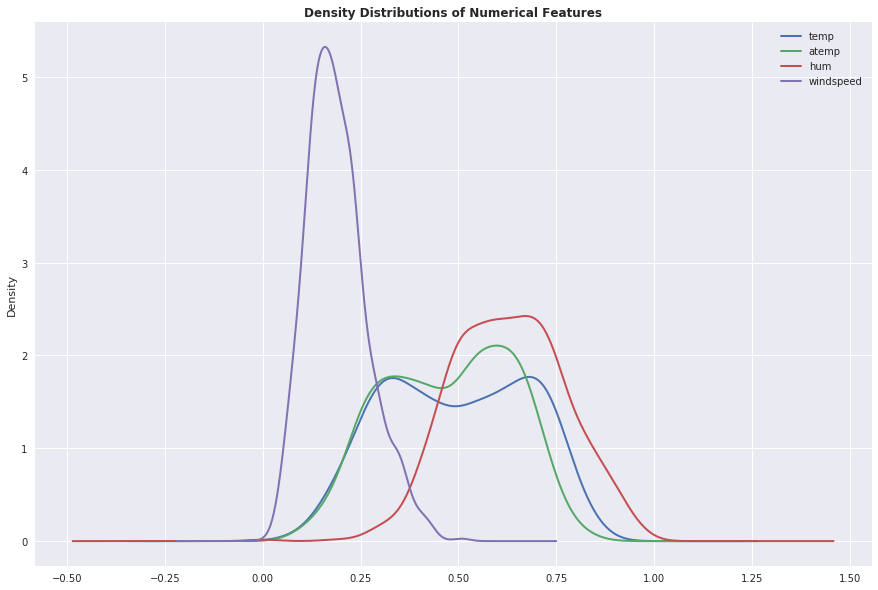

In [46]:
# Iterate over numerical features and plot density 
for feature in numerical:
    bike_daily[feature].plot(kind='density', figsize=(15, 10), lw=2)

# Format plot
plt.style.use('seaborn')
plt.legend()
plt.title('Density Distributions of Numerical Features', fontweight='bold')

# Save
plt.savefig('Plots/density_dist_num.pdf')

plt.show()

As the density plot above shows, the distributions of the already-normalized numerical variables are not strongly skewed. Instead, they are relatively standardized. This is ideal for models to interpert data and make predictions, since non-standardized data tends to hamper the algorithm's ability to glean patterns from the data.

We can further rule out the presence of outliers by plotting box plots for each variable:

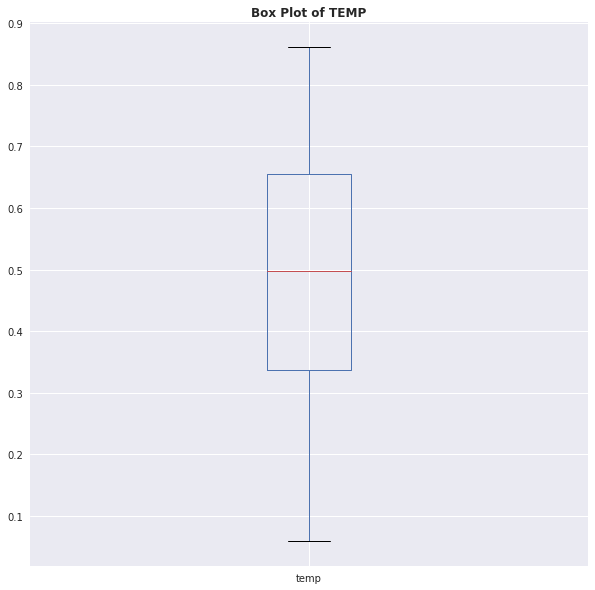

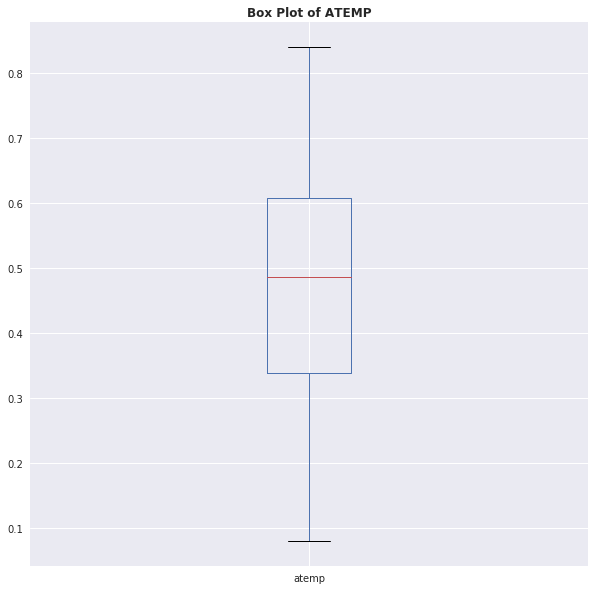

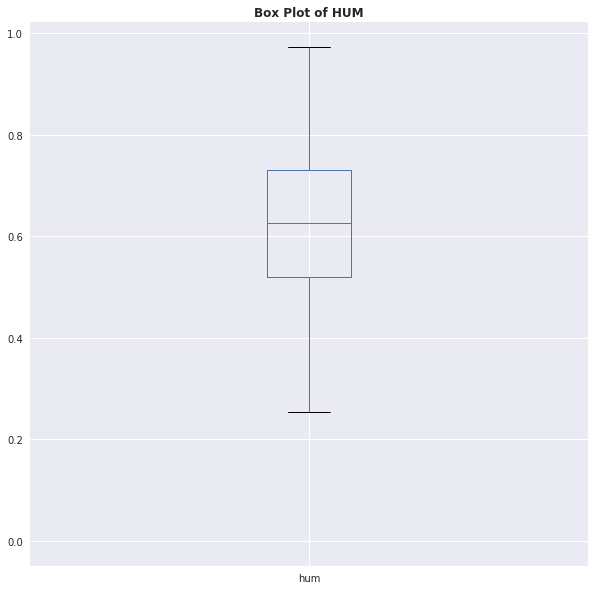

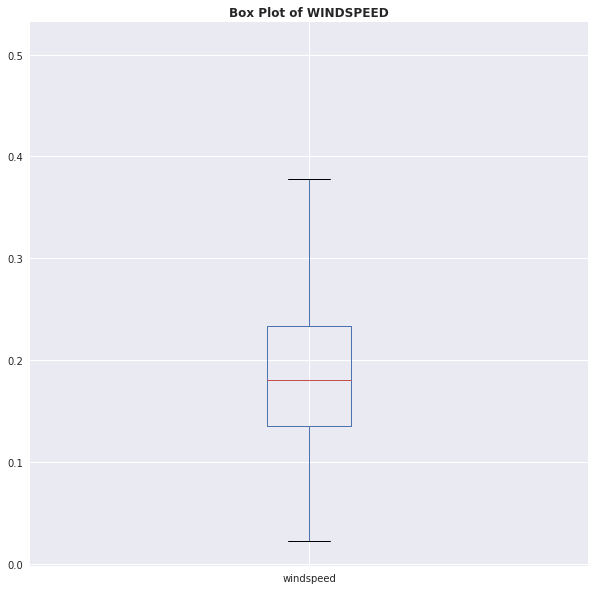

In [47]:
# Iterate over numerical features and plot box plots 
for feature in numerical:
    bike_daily[feature].plot(kind='box', figsize=(10, 10))
    plt.style.use('seaborn')
    plt.title('Box Plot of ' + feature.upper(), fontweight='bold')
    plt.show()


Again, as the box plots show, **we can rule out the presence of outliers entirely in the predictor variables.**

Since the data has come satisfactorily clean in the dataset, we do not have any further preprocessing steps to complete. The data is adequate for feeding into a model, so we can proceed to break it down into daily and hourly data:

In [48]:
# Extract numerical features (daily and hourly)
num_features_daily = bike_daily[numerical]
num_features_hourly = bike_hourly[numerical]

In [49]:
# Check gist of num_features_daily
num_features_daily.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Columns: 4 entries, temp to windspeed
dtypes: float64(4)
memory usage: 22.9 KB


In [50]:
# Check gist of num_features_hourly
num_features_hourly.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Columns: 4 entries, temp to windspeed
dtypes: float64(4)
memory usage: 543.2 KB


### Target Features

Having finished analyzing the `predictor features`, we can proceed to examine the presence of outliers/skewness in our target feature, which is inherently numerical: `btc`

Again, we can check this easily with a simple `for` loop:

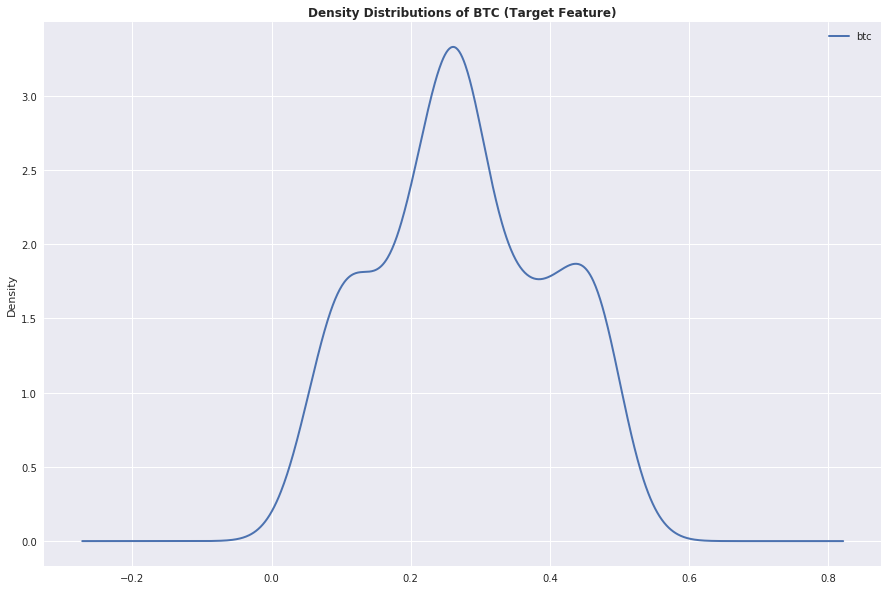

In [51]:
# Plot density for 'btc'
bike_daily['btc'].plot(kind='density', figsize=(15, 10), lw=2)

# Format plot
plt.style.use('seaborn')
plt.legend()
plt.title('Density Distributions of BTC (Target Feature)', fontweight='bold')

# Save
plt.savefig('Plots/density_dist_btc.pdf')

plt.show()

The target variable does not seem to be very skewed. Rather, its distribution seem to reflect the absence of outliers. 

We can further rule out the presence of outliers by plotting its box plot:

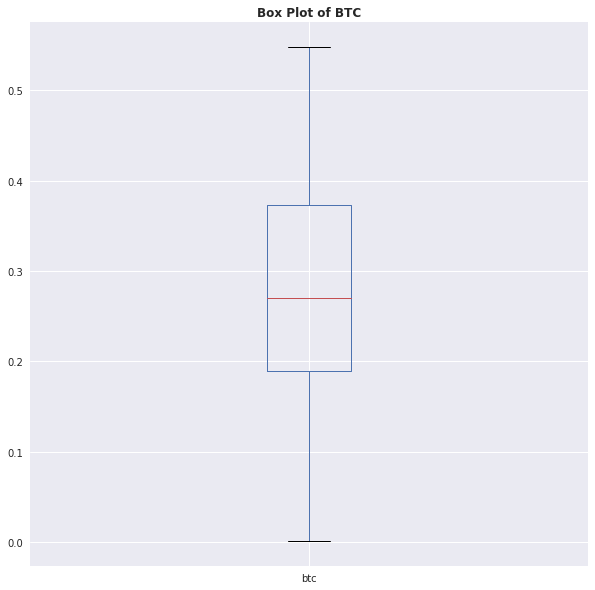

In [52]:
# Plot box plot for 'btc'
bike_daily['btc'].plot(kind='box', figsize=(10, 10))
plt.style.use('seaborn')
plt.title('Box Plot of BTC', fontweight='bold')
plt.show()

Again, as the box plots show, **we can rule out the presence of outliers entirely in the target variable.**

Since the data has come satisfactorily clean in the dataset, we do not have any further preprocessing steps to complete. The data is adequate for feeding into a model, so we can proceed to break it down into daily and hourly data:

In [53]:
# Extract target feature (daily and hourly)
target_daily = bike_daily['btc']
target_hourly = bike_hourly['btc']

# Model Design & Training

To predict the BTC ratio in both the `daily` and `hourly` datasets, I will be using a Support Vector Machine Regressor as benchmark model and a Multi-Layer Perceptron as final model. The benchmark model will allow me to better understand the final model's performance after training. 

## Data Modeling

Prior to designing and training these models, however, it is necessary that we model the `numerical` and `categorical` features into `predictors_daily` and `predictors_hourly` DataFrames, which can then be split for training and testing:

### Merge `cat` and `num` features

#### Daily Bike Dataset

In [54]:
# Merge cat_features_daily and num_features_daily
predictors_daily = pd.concat([cat_features_daily, num_features_daily], axis=1)

# Check results
predictors_daily.head()

season_1  season_2  season_3  season_4  mnth_1  mnth_2  mnth_3  mnth_4  \
0         1         0         0         0       1       0       0       0   
1         1         0         0         0       1       0       0       0   
2         1         0         0         0       1       0       0       0   
3         1         0         0         0       1       0       0       0   
4         1         0         0         0       1       0       0       0   

   mnth_5  mnth_6    ...      weekday_6  workingday_0  workingday_1  \
0       0       0    ...              1             1             0   
1       0       0    ...              0             1             0   
2       0       0    ...              0             0             1   
3       0       0    ...              0             0             1   
4       0       0    ...              0             0             1   

   weathersit_1  weathersit_2  weathersit_3      temp     atemp       hum  \
0             0             1             0  0.344167  0.363625  0.805833   
1             0             1             0  0.363478  0.353739  0.696087   
2             1             0             0  0.196364  0.189405  0.437273   
3             1             0             0  0.200000  0.212122  0.590435   
4             1             0             0  0.226957  0.229270  0.436957   

   windspeed  
0   0.160446  
1   0.248539  
2   0.248309  
3   0.160296  
4   0.186900  

[5 rows x 65 columns]

#### Hourly Bike Dataset

In [55]:
# Merge cat_features_daily and num_features_daily
predictors_hourly = pd.concat([cat_features_hourly, num_features_hourly], axis=1)

# Check results
predictors_hourly.head()

season_1  season_2  season_3  season_4  mnth_1  mnth_2  mnth_3  mnth_4  \
0         1         0         0         0       1       0       0       0   
1         1         0         0         0       1       0       0       0   
2         1         0         0         0       1       0       0       0   
3         1         0         0         0       1       0       0       0   
4         1         0         0         0       1       0       0       0   

   mnth_5  mnth_6    ...      workingday_0  workingday_1  weathersit_1  \
0       0       0    ...                 1             0             1   
1       0       0    ...                 1             0             1   
2       0       0    ...                 1             0             1   
3       0       0    ...                 1             0             1   
4       0       0    ...                 1             0             1   

   weathersit_2  weathersit_3  weathersit_4  temp   atemp   hum  windspeed  
0             0             0             0  0.24  0.2879  0.81        0.0  
1             0             0             0  0.22  0.2727  0.80        0.0  
2             0             0             0  0.22  0.2727  0.80        0.0  
3             0             0             0  0.24  0.2879  0.75        0.0  
4             0             0             0  0.24  0.2879  0.75        0.0  

[5 rows x 90 columns]

## Data Shuffle & Split

Having modelled the predictor data into the necessary DataFrames and having separated the `daily` and `hourly` target variables, we now have to split them into `training` and `testing` data: 

In [56]:
# Import train_test_split
from sklearn.model_selection import train_test_split


def split_data(features, target):
    '''
    Split the features and target data into training and testing sets.
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [57]:
# Split daily data
X_train_daily, X_test_daily, y_train_daily, y_test_daily = split_data(
    predictors_daily, target_daily)

# Show the results of the split
print("Daily training set has {} samples.".format(X_train_daily.shape[0]))
print("Daily testing set has {} samples.".format(X_test_daily.shape[0]))

Daily training set has 584 samples.
Daily testing set has 147 samples.


In [58]:
# Split hourly data
X_train_hourly, X_test_hourly, y_train_hourly, y_test_hourly = split_data(
    predictors_hourly, target_hourly)

# Show the results of the split
print("Hourly training set has {} samples.".format(X_train_hourly.shape[0]))
print("Hourly testing set has {} samples.".format(X_test_hourly.shape[0]))

Hourly training set has 13903 samples.
Hourly testing set has 3476 samples.


## Benchmark Design & Training

For this project I will be using a Support Vector Machine Regressor as the benchmark model to which I will compare the MLP later.

For this SVR, I have decided to use an RBF kernel because it is more specific and less generic than other kernels such as 'poly' and 'linear'. 

In order to fine-tune it, I have decided to iterate over different combinations of the hyperparameters (`C`, `gamma`, and `epsilon`), and use Grid Search Cross-Validation to find the optimal combination of their values.

In addition, I have kept the number of CV folds at 3, which is the default, in order to avoid elongating the training times further.

To streamline the process for the `daily` and `hourly` datasets, I have defined a simple method to `train_and_test_svm`:

In [59]:
# Import SVM regressor, etc.
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


def train_and_test_svm(X_train, X_test, y_train, y_test):
    '''
    Creates, trains, and tests a Support Vector Machine Regressor
    using Grid Search Cross-Validation.
    
    Args:
        - X_train
        - X_test
        - y_train
        - y_test
    
    Returns:
        - best_svm
        
    '''

    # Create regressor and param grid
    svm = SVR(kernel='rbf')
    params = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.01, 0.001]
    }

    # Create Grid Search object
    grid = GridSearchCV(
        estimator=svm,
        param_grid=params,
        scoring='neg_mean_absolute_error',
        verbose=4)

    # Fit grid to data
    grid_result = grid.fit(X_train, y_train)

    # Observe best performance
    print('\n\nBest performance: MAE of {:.4f} with parameters: {}'.format(
        grid_result.best_score_, grid_result.best_params_))

    # Obtain best_estimator
    best_svm = grid_result.best_estimator_

    # Make predictions (for training and testing sets)
    y_train_pred = best_svm.predict(X_train)
    y_test_pred = best_svm.predict(X_test)

    # Observe performance (absolute)
    print("\n\n\tMean Absolute Error Score:\n")
    print("\tTraining set: {:.4f}".format(
        mean_absolute_error(y_train, y_train_pred)))
    print("\tTesting set: {:.4f}\n\n".format(
        mean_absolute_error(y_test, y_test_pred)))
    
    # Observe performance (relative)
    print("\tMean Absolute Error Score (as percentage of data average):\n")
    print("\tTraining set: {:.4f}%".format(
        mean_absolute_error(y_train, y_train_pred) * 100 / y_train.mean()))
    print("\tTesting set: {:.4f}%\n\n".format(
        mean_absolute_error(y_test, y_test_pred) * 100 / y_test.mean()))

    return best_svm

It is important to note that the metric that will be used to evaluate the performance of the models is `mean_absolute_error`, or `MAE`. This is due to the nature of our target variable: a value between 0 and 1 (the number of bikes on the road is always less than the number of cars). If we instead evaluated performance as `mean_squared_error`, we would end up with a misleading figure when computing the size of the error relative to the mean value of the dataset, because the square of a value between 0 and 1 is always smaller than itself. 

In [60]:
# Train and test daily dataset benchmark SVR
svr_daily = train_and_test_svm(X_train_daily, X_test_daily, y_train_daily,
                               y_test_daily)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] C=0.001, epsilon=0.1, gamma=0.001 ...............................
[CV]  C=0.001, epsilon=0.1, gamma=0.001, score=-0.10389021854133554, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=0.001 ...............................
[CV]  C=0.001, epsilon=0.1, gamma=0.001, score=-0.10033808258651737, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=0.001 ...............................
[CV]  C=0.001, epsilon=0.1, gamma=0.001, score=-0.10003046790040494, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=0.01 ................................
[CV]  C=0.001, epsilon=0.1, gamma=0.01, score=-0.10360752719616854, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=0.01 ................................
[CV]  C=0.001, epsilon=0.1, gamma=0.01, score=-0.09996177069279873, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=0.01 ................................
[CV]  C=0.001, epsilon=0.1, gamma=0.01, score=-0.09963031607058759, total=   0.0s
[CV] C=0.001, eps

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.001, epsilon=0.1, gamma=1, score=-0.10399627664994303, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1 ...................................
[CV]  C=0.001, epsilon=0.1, gamma=1, score=-0.10031855251114184, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1 ...................................
[CV]  C=0.001, epsilon=0.1, gamma=1, score=-0.10003905839587914, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=0.001 ..............................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, score=-0.09904045988850564, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=0.001 ..............................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, score=-0.10161893627477869, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=0.001 ..............................
[CV]  C=0.001, epsilon=0.01, gamma=0.001, score=-0.09942473520025479, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=0.01 ...............................
[CV]  C=0.001, epsilon=0.01, gamma=0.01, score=-0.09856173906126775, total=   0.0s
[C

[CV]  C=0.01, epsilon=0.001, gamma=0.01, score=-0.09630617327328139, total=   0.0s
[CV] C=0.01, epsilon=0.001, gamma=0.01 ...............................
[CV]  C=0.01, epsilon=0.001, gamma=0.01, score=-0.09470072514634542, total=   0.0s
[CV] C=0.01, epsilon=0.001, gamma=0.1 ................................
[CV]  C=0.01, epsilon=0.001, gamma=0.1, score=-0.08721355325661809, total=   0.0s
[CV] C=0.01, epsilon=0.001, gamma=0.1 ................................
[CV]  C=0.01, epsilon=0.001, gamma=0.1, score=-0.08964676228412286, total=   0.0s
[CV] C=0.01, epsilon=0.001, gamma=0.1 ................................
[CV]  C=0.01, epsilon=0.001, gamma=0.1, score=-0.08879670589439019, total=   0.0s
[CV] C=0.01, epsilon=0.001, gamma=1 ..................................
[CV]  C=0.01, epsilon=0.001, gamma=1, score=-0.0977969352714421, total=   0.0s
[CV] C=0.01, epsilon=0.001, gamma=1 ..................................
[CV]  C=0.01, epsilon=0.001, gamma=1, score=-0.10055678246893726, total=   0.0s
[CV

[CV]  C=1, epsilon=0.01, gamma=0.001, score=-0.0843062414084251, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.001 ..................................
[CV]  C=1, epsilon=0.01, gamma=0.001, score=-0.0856513361112374, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.001 ..................................
[CV]  C=1, epsilon=0.01, gamma=0.001, score=-0.0854814523225457, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.01 ...................................
[CV]  C=1, epsilon=0.01, gamma=0.01, score=-0.08596295471402934, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.01 ...................................
[CV]  C=1, epsilon=0.01, gamma=0.01, score=-0.08554045165191757, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.01 ...................................
[CV]  C=1, epsilon=0.01, gamma=0.01, score=-0.0882649871787149, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.1 ....................................
[CV]  C=1, epsilon=0.01, gamma=0.1, score=-0.10006721677540636, total=   0.0s
[CV] C=1, epsilon=0.01,

[CV]  C=10, epsilon=0.001, gamma=1, score=-0.09408740827562144, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=1 ....................................
[CV]  C=10, epsilon=0.001, gamma=1, score=-0.09633132483455663, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=1 ....................................
[CV]  C=10, epsilon=0.001, gamma=1, score=-0.09556049356704885, total=   0.0s


Best performance: MAE of -0.0798 with parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 0.01}


	Mean Absolute Error Score:

	Training set: 0.0735
	Testing set: 0.0879


	Mean Absolute Error Score (as percentage of data average):

	Training set: 26.3213%
	Testing set: 33.6911%




[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    6.4s finished


In [61]:
# Train and test hourly dataset benchmark SVR
svr_hourly = train_and_test_svm(X_train_hourly, X_test_hourly, y_train_hourly,
                                y_test_hourly)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] C=0.001, epsilon=0.1, gamma=0.001 ...............................
[CV]  C=0.001, epsilon=0.1, gamma=0.001, score=-0.2011014984049188, total=  12.6s
[CV] C=0.001, epsilon=0.1, gamma=0.001 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s


[CV]  C=0.001, epsilon=0.1, gamma=0.001, score=-0.20483900190351062, total=  12.5s
[CV] C=0.001, epsilon=0.1, gamma=0.001 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.1s remaining:    0.0s


[CV]  C=0.001, epsilon=0.1, gamma=0.001, score=-0.20595826369583728, total=  12.6s
[CV] C=0.001, epsilon=0.1, gamma=0.01 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  C=0.001, epsilon=0.1, gamma=0.01, score=-0.19466646550474298, total=  12.4s
[CV] C=0.001, epsilon=0.1, gamma=0.01 ................................
[CV]  C=0.001, epsilon=0.1, gamma=0.01, score=-0.19804794344875296, total=  12.2s
[CV] C=0.001, epsilon=0.1, gamma=0.01 ................................
[CV]  C=0.001, epsilon=0.1, gamma=0.01, score=-0.19919427953735513, total=  12.3s
[CV] C=0.001, epsilon=0.1, gamma=0.1 .................................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, score=-0.1791376193867104, total=  11.6s
[CV] C=0.001, epsilon=0.1, gamma=0.1 .................................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, score=-0.18161078254103194, total=  11.5s
[CV] C=0.001, epsilon=0.1, gamma=0.1 .................................
[CV]  C=0.001, epsilon=0.1, gamma=0.1, score=-0.18313068877743263, total=  11.6s
[CV] C=0.001, epsilon=0.1, gamma=1 ...................................
[CV]  C=0.001, epsilon=0.1, gamma=1, score=-0.20141530539458055, total=  12.4s
[CV] C=

[CV]  C=0.01, epsilon=0.01, gamma=1, score=-0.1952994008427998, total=  17.0s
[CV] C=0.01, epsilon=0.01, gamma=1 ...................................
[CV]  C=0.01, epsilon=0.01, gamma=1, score=-0.1991172827952867, total=  16.9s
[CV] C=0.01, epsilon=0.01, gamma=1 ...................................
[CV]  C=0.01, epsilon=0.01, gamma=1, score=-0.20005035603867982, total=  17.0s
[CV] C=0.01, epsilon=0.001, gamma=0.001 ..............................
[CV]  C=0.01, epsilon=0.001, gamma=0.001, score=-0.1923866554183837, total=  17.5s
[CV] C=0.01, epsilon=0.001, gamma=0.001 ..............................
[CV]  C=0.01, epsilon=0.001, gamma=0.001, score=-0.1960466849205034, total=  17.5s
[CV] C=0.01, epsilon=0.001, gamma=0.001 ..............................
[CV]  C=0.01, epsilon=0.001, gamma=0.001, score=-0.19700951723242124, total=  17.5s
[CV] C=0.01, epsilon=0.001, gamma=0.01 ...............................
[CV]  C=0.01, epsilon=0.001, gamma=0.01, score=-0.15570198064959773, total=  17.5s
[CV] C

[CV]  C=1, epsilon=0.1, gamma=0.01, score=-0.10895413652113486, total=   7.1s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV]  C=1, epsilon=0.1, gamma=0.01, score=-0.11118638421310534, total=   7.0s
[CV] C=1, epsilon=0.1, gamma=0.1 .....................................
[CV]  C=1, epsilon=0.1, gamma=0.1, score=-0.08224134567318761, total=   6.3s
[CV] C=1, epsilon=0.1, gamma=0.1 .....................................
[CV]  C=1, epsilon=0.1, gamma=0.1, score=-0.08240358549533873, total=   6.5s
[CV] C=1, epsilon=0.1, gamma=0.1 .....................................
[CV]  C=1, epsilon=0.1, gamma=0.1, score=-0.08462893780022503, total=   6.3s
[CV] C=1, epsilon=0.1, gamma=1 .......................................
[CV]  C=1, epsilon=0.1, gamma=1, score=-0.1605743589765423, total=  19.6s
[CV] C=1, epsilon=0.1, gamma=1 .......................................
[CV]  C=1, epsilon=0.1, gamma=1, score=-0.15999311967610216, total=  19.9s
[CV] C=1, epsilon=0.1, gamma=1 .......

[CV]  C=10, epsilon=0.01, gamma=1, score=-0.13257098099077017, total=  43.9s
[CV] C=10, epsilon=0.001, gamma=0.001 ................................
[CV]  C=10, epsilon=0.001, gamma=0.001, score=-0.11693832955795139, total=  17.9s
[CV] C=10, epsilon=0.001, gamma=0.001 ................................
[CV]  C=10, epsilon=0.001, gamma=0.001, score=-0.11478198678966577, total=  17.9s
[CV] C=10, epsilon=0.001, gamma=0.001 ................................
[CV]  C=10, epsilon=0.001, gamma=0.001, score=-0.11771801626927439, total=  17.9s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV]  C=10, epsilon=0.001, gamma=0.01, score=-0.08424423328040948, total=  25.3s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV]  C=10, epsilon=0.001, gamma=0.01, score=-0.08376924083628112, total=  25.0s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV]  C=10, epsilon=0.001, gamma=0.01, score=-0.08552388637337492, total=  25.1s
[CV] C=1

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 92.0min finished




Best performance: MAE of -0.0736 with parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1}


	Mean Absolute Error Score:

	Training set: 0.0422
	Testing set: 0.0698


	Mean Absolute Error Score (as percentage of data average):

	Training set: 15.0946%
	Testing set: 25.7135%




## Multi-Layer Perceptron

Having defined the best SVR for the `daily` and `hourly` bike data, we can now proceed to design the Multi-Layer Perceptron for each of these datasets.

Contrary to designing and training Suppor Vector Machine Regressors, designing and training MLPs is an art in and of itself, because not only can one play around with their hyperparameters, but one can alter their architecture as well.

Thus, I will take a two-step, hybrid approach at selecting the best possible MLP:

1. I will design two different architectures, each containing four densely-connected hidden layers and one output layer. I have kept the number of densely-connected layers small to constrain the computational cost of training the model. All hidden layers will have a `ReLu` activation function, and the otuput layer -because our purpose is to regress- will have a `linear` activation function:
    1. **The first architecture will have 3 dropout layers.**
    3. **The second architecture will have 4 dropout layers.**
2. I will then optimize the hyperparameters of these architectures using Grid Search Cross-Validation. To do so, I will optimize:

        1. Nodes: The number of nodes to be included in the hidden layers of the network. 
        2. Dropout: The proportion of nodes to be dropped in the dropout layer.
        3. Penalty: The penalty used by the L2 regularizer (standard for both 
        4. Batch_Size: The size of the sample group on which the model is trained to perform one update to the weights.
        
It must be noted that this modus operandi is far from flawless, and is but a minute exploration of the myriad possibilities that abound in the realm of MLP optimization. However, it does attempt to hedge the boundless uncertainty surrounding this step of the data science process.

Once I obtain the best MLP (both in terms of architecture and hyperparameters), for each of the datasets, `daily` and `hourly`, I will then re-build these MLPs in accordance to those `best_params_`, save the best weights during the training process using a `ModelCheckpoint` callback, and load the best weights to finally obtain the `best_mlp_daily` and `best_mlp_hourly`.

### Design & Optimization: Grid Search Cross-Validation

As explained above, we begin the GSCV process by defining two architectures to optimize. 

Because we will be using the Keras library to design the MLPs, we need to employ a `KerasRegressor` wrapper from `keras.wrappers.scikit_learn` and pass this wrapped regressor to the `GridSearchCV` object.

The `KerasRegressor` wrapper object takes a "builder function" as argument for its `build_func` parameter, so we define the two architectures in separate methods that return the compiled Keras models:

#### MLP Architectures

In [62]:
# Import and set random seeds for reproducible results
from numpy.random import seed
seed(42)

In [63]:
# Import wrapper
from keras.wrappers.scikit_learn import KerasRegressor

# Import necessary keras elements
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

Using TensorFlow backend.


In [98]:
# Model 1 architecture
def build_model_1_daily(nodes, penalty, dropout, optimizer):
    # Achitecture
    model = Sequential()
    model.add(
        Dense(
            units=X_train_daily.shape[1],
            input_dim=X_train_daily.shape[1],
            activation='relu'))
    model.add(
        Dense(
            nodes,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 5,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 10,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(1, activation='linear'))

    # Compile
    model.compile(
        loss='mae',
        optimizer=optimizer,
        metrics=['mae'])
    
    return model

In [65]:
# Model 2 architecture
def build_model_2_daily(nodes, penalty, dropout, optimizer):
    # Achitecture
    model = Sequential()
    model.add(
        Dense(
            units=X_train_daily.shape[1],
            input_dim=X_train_daily.shape[1],
            activation='relu'))
    model.add(
        Dense(
            nodes,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 5,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 10,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(1, activation='linear'))

    # Compile
    model.compile(
        loss='mae',
        optimizer=optimizer,
        metrics=['mae'])
    
    return model

In [66]:
# Model 1 architecture
def build_model_1_hourly(nodes, penalty, dropout, optimizer):
    # Achitecture
    model = Sequential()
    model.add(
        Dense(
            units=X_train_hourly.shape[1],
            input_dim=X_train_hourly.shape[1],
            activation='relu'))
    model.add(
        Dense(
            nodes,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 5,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 10,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(1, activation='linear'))

    # Compile
    model.compile(
        loss='mae',
        optimizer=optimizer,
        metrics=['mae'])
    
    return model

In [67]:
# Model 2 architecture
def build_model_2_hourly(nodes, penalty, dropout, optimizer):
    # Achitecture
    model = Sequential()
    model.add(
        Dense(
            units=X_train_hourly.shape[1],
            input_dim=X_train_hourly.shape[1],
            activation='relu'))
    model.add(
        Dense(
            nodes,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 5,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(
        Dense(
            nodes + 10,
            activation='relu',
            kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(1, activation='linear'))

    # Compile
    model.compile(
        loss='mae',
        optimizer=optimizer,
        metrics=['mae'])
    
    return model

#### MLP Grid Search CV

We can now proceed to optimize the MLPs using Grid Search Cross-Validation. 

To do this, we first define the parameters to optimize, with their corresponding values:

In [68]:
# Define parameters
parameters = {
    'nodes': [10, 15, 20],
    'penalty': [0.01, 0.001],
    'dropout': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [40, 80],
}

Having the parameters in place, we can now use GSCV to optimize both architectures for each of the datasets, as follows:

1. `daily` dataset:
   1. First Architecture
   2. Second Architecture
2. `hourly` dataset:
   1. First Architecture
   2. Second Architecture
   
After reviewing the performance for each, we can then obtain the best architecture-parameter combinations.

##### Optimizing `daily` dataset: First Architecture

In [69]:
# Wrap model in wrapper
regressor_1_daily = KerasRegressor(build_fn=build_model_1_daily)

# Define grid (scoring method is the same as that used in GSCV 
# for the SVR benchmark model)
mlp_1_daily_grid = GridSearchCV(
    estimator=regressor_1_daily,
    param_grid=parameters,
    scoring='neg_mean_absolute_error',
    verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp_1_daily_grid_result = mlp_1_daily_grid.fit(
    X_train_daily,
    y_train_daily,
    epochs=50,
    verbose=2,
    shuffle=True,
    validation_split=0.2)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 0s - loss: 0.6560 - mean_squared_error: 0.2058 - mean_absolute_error: 0.4273 - val_loss: 0.5530 - val_mean_squared_error: 0.1139 - val_mean_absolute_error: 0.3161
Epoch 2/50
 - 0s - loss: 0.5478 - mean_squared_error: 0.1171 - mean_absolute_error: 0.3174 - val_loss: 0.4981 - val_mean_squared_error: 0.0789 - val_mean_absolute_error: 0.2546
Epoch 3/50
 - 0s - loss: 0.4970 - mean_squared_error: 0.0866 - mean_absolute_error: 0.2676 - val_loss: 0.4638 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.2253
Epoch 4/50
 - 0s - loss: 0.4618 - mean_squared_error: 0.0717 - mean_absolute_error: 0.2397 - val_loss: 0.4344 - val_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.2050
Epoch 5/50
 - 0s - loss: 0.4320 - mean_squared_error: 0.0620 - mean_absolute_error: 0.2191 - val_loss: 0.4068 - 

 - 0s - loss: 0.0464 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0893 - val_loss: 0.0452 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0935
Epoch 47/50
 - 0s - loss: 0.0441 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0882 - val_loss: 0.0433 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0933
Epoch 48/50
 - 0s - loss: 0.0427 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0893 - val_loss: 0.0413 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0922
Epoch 49/50
 - 0s - loss: 0.0412 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0892 - val_loss: 0.0397 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0921
Epoch 50/50
 - 0s - loss: 0.0390 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0864 - val_loss: 0.0382 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0924
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01, total=   1.8s
[CV] batch_size=40, dropout=0.2, n

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 0s - loss: 0.4670 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1746 - val_loss: 0.4288 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1172
Epoch 2/50
 - 0s - loss: 0.4250 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1295 - val_loss: 0.4001 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1001
Epoch 3/50
 - 0s - loss: 0.4004 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1303 - val_loss: 0.3772 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0996
Epoch 4/50
 - 0s - loss: 0.3732 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1129 - val_loss: 0.3558 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1014
Epoch 5/50
 - 0s - loss: 0.3497 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1088 - val_loss: 0.3336 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0964
Epoch 6/50
 - 0s - loss: 0.3288 - mean_squared_error: 0.0169 - mean_ab

Epoch 47/50
 - 0s - loss: 0.0319 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0857 - val_loss: 0.0321 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0951
Epoch 48/50
 - 0s - loss: 0.0307 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0858 - val_loss: 0.0309 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0951
Epoch 49/50
 - 0s - loss: 0.0292 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0840 - val_loss: 0.0297 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0949
Epoch 50/50
 - 0s - loss: 0.0280 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0845 - val_loss: 0.0285 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0945
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01, total=   1.9s
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 1s - loss: 0.4856 - mean_squared_error: 0.0482 - mean_absolute_error

Epoch 42/50
 - 0s - loss: 0.0419 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0824 - val_loss: 0.0410 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0843
Epoch 43/50
 - 0s - loss: 0.0408 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0857 - val_loss: 0.0395 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0850
Epoch 44/50
 - 0s - loss: 0.0389 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0854 - val_loss: 0.0376 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0847
Epoch 45/50
 - 0s - loss: 0.0372 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0855 - val_loss: 0.0360 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0850
Epoch 46/50
 - 0s - loss: 0.0358 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0850 - val_loss: 0.0343 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0846
Epoch 47/50
 - 0s - loss: 0.0335 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0815 - val_loss: 0.0330

Epoch 37/50
 - 0s - loss: 0.0202 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0691 - val_loss: 0.0233 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0908
Epoch 38/50
 - 0s - loss: 0.0199 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0690 - val_loss: 0.0228 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0910
Epoch 39/50
 - 0s - loss: 0.0193 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0692 - val_loss: 0.0226 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0904
Epoch 40/50
 - 0s - loss: 0.0186 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0668 - val_loss: 0.0221 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0910
Epoch 41/50
 - 0s - loss: 0.0179 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0645 - val_loss: 0.0219 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0909
Epoch 42/50
 - 0s - loss: 0.0172 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0637 - val_loss: 0.0216

Epoch 32/50
 - 0s - loss: 0.0282 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0744 - val_loss: 0.0320 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0958
Epoch 33/50
 - 0s - loss: 0.0270 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0705 - val_loss: 0.0316 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0956
Epoch 34/50
 - 0s - loss: 0.0265 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0705 - val_loss: 0.0313 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0955
Epoch 35/50
 - 0s - loss: 0.0260 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0706 - val_loss: 0.0303 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0950
Epoch 36/50
 - 0s - loss: 0.0252 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0697 - val_loss: 0.0299 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0947
Epoch 37/50
 - 0s - loss: 0.0251 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0708 - val_loss: 0.0297

Epoch 27/50
 - 0s - loss: 0.0283 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0737 - val_loss: 0.0353 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0996
Epoch 28/50
 - 0s - loss: 0.0271 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0720 - val_loss: 0.0344 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0986
Epoch 29/50
 - 0s - loss: 0.0278 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0777 - val_loss: 0.0339 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0993
Epoch 30/50
 - 0s - loss: 0.0261 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0726 - val_loss: 0.0334 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0994
Epoch 31/50
 - 0s - loss: 0.0254 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0726 - val_loss: 0.0320 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0969
Epoch 32/50
 - 0s - loss: 0.0254 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0741 - val_loss: 0.0328

Epoch 22/50
 - 0s - loss: 0.1009 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0851 - val_loss: 0.0982 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0940
Epoch 23/50
 - 0s - loss: 0.0927 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0838 - val_loss: 0.0904 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0932
Epoch 24/50
 - 0s - loss: 0.0853 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0840 - val_loss: 0.0832 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0928
Epoch 25/50
 - 0s - loss: 0.0786 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0846 - val_loss: 0.0766 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0926
Epoch 26/50
 - 0s - loss: 0.0721 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0829 - val_loss: 0.0705 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0923
Epoch 27/50
 - 0s - loss: 0.0663 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0835 - val_loss: 0.0651

Epoch 17/50
 - 0s - loss: 0.1397 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0848 - val_loss: 0.1335 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0912
Epoch 18/50
 - 0s - loss: 0.1292 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0873 - val_loss: 0.1229 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0899
Epoch 19/50
 - 0s - loss: 0.1179 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0810 - val_loss: 0.1132 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0906
Epoch 20/50
 - 0s - loss: 0.1082 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0807 - val_loss: 0.1040 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0898
Epoch 21/50
 - 0s - loss: 0.1001 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0831 - val_loss: 0.0958 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0909
Epoch 22/50
 - 0s - loss: 0.0924 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0844 - val_loss: 0.0881

Epoch 12/50
 - 0s - loss: 0.2159 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0820 - val_loss: 0.2081 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0886
Epoch 13/50
 - 0s - loss: 0.2004 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0829 - val_loss: 0.1928 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0886
Epoch 14/50
 - 0s - loss: 0.1855 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0815 - val_loss: 0.1795 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0907
Epoch 15/50
 - 0s - loss: 0.1714 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0801 - val_loss: 0.1648 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0873
Epoch 16/50
 - 0s - loss: 0.1588 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0819 - val_loss: 0.1528 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0886
Epoch 17/50
 - 0s - loss: 0.1464 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0832 - val_loss: 0.1405

Epoch 7/50
 - 0s - loss: 0.0510 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0904 - val_loss: 0.0492 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0910
Epoch 8/50
 - 0s - loss: 0.0509 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0931 - val_loss: 0.0479 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0926
Epoch 9/50
 - 0s - loss: 0.0484 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0908 - val_loss: 0.0466 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0921
Epoch 10/50
 - 0s - loss: 0.0465 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0873 - val_loss: 0.0446 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0913
Epoch 11/50
 - 0s - loss: 0.0451 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0895 - val_loss: 0.0431 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0897
Epoch 12/50
 - 0s - loss: 0.0421 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0822 - val_loss: 0.0418 - 

Epoch 2/50
 - 0s - loss: 0.0690 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1290 - val_loss: 0.0626 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1141
Epoch 3/50
 - 0s - loss: 0.0629 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1151 - val_loss: 0.0589 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1088
Epoch 4/50
 - 0s - loss: 0.0597 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1121 - val_loss: 0.0557 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1033
Epoch 5/50
 - 0s - loss: 0.0553 - mean_squared_error: 0.0159 - mean_absolute_error: 0.1025 - val_loss: 0.0539 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1023
Epoch 6/50
 - 0s - loss: 0.0525 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0975 - val_loss: 0.0532 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1045
Epoch 7/50
 - 0s - loss: 0.0496 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0916 - val_loss: 0.0495 - val

Epoch 49/50
 - 0s - loss: 0.0118 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0191 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0927
Epoch 50/50
 - 0s - loss: 0.0125 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0583 - val_loss: 0.0189 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0933
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001, total=   2.1s
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 1s - loss: 0.0723 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1326 - val_loss: 0.0634 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1110
Epoch 2/50
 - 0s - loss: 0.0645 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1117 - val_loss: 0.0596 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1037
Epoch 3/50
 - 0s - loss: 0.0574 - mean_squared_error: 0.0155 - mean_absolute

Epoch 44/50
 - 0s - loss: 0.0134 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0595 - val_loss: 0.0173 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0830
Epoch 45/50
 - 0s - loss: 0.0134 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0608 - val_loss: 0.0174 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0841
Epoch 46/50
 - 0s - loss: 0.0132 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0196 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0912
Epoch 47/50
 - 0s - loss: 0.0133 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0622 - val_loss: 0.0182 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0877
Epoch 48/50
 - 0s - loss: 0.0129 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0603 - val_loss: 0.0174 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0860
Epoch 49/50
 - 0s - loss: 0.0120 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0566 - val_loss: 0.0165

Epoch 39/50
 - 0s - loss: 0.0454 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0856 - val_loss: 0.0441 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0919
Epoch 40/50
 - 0s - loss: 0.0422 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0820 - val_loss: 0.0417 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0918
Epoch 41/50
 - 0s - loss: 0.0404 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0861 - val_loss: 0.0396 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0921
Epoch 42/50
 - 0s - loss: 0.0382 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0840 - val_loss: 0.0373 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0916
Epoch 43/50
 - 0s - loss: 0.0360 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0831 - val_loss: 0.0355 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0916
Epoch 44/50
 - 0s - loss: 0.0336 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0818 - val_loss: 0.0339

Epoch 34/50
 - 0s - loss: 0.0773 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0811 - val_loss: 0.0752 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0916
Epoch 35/50
 - 0s - loss: 0.0723 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0801 - val_loss: 0.0709 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0923
Epoch 36/50
 - 0s - loss: 0.0684 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0828 - val_loss: 0.0669 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0925
Epoch 37/50
 - 0s - loss: 0.0650 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0849 - val_loss: 0.0632 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0925
Epoch 38/50
 - 0s - loss: 0.0603 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0801 - val_loss: 0.0597 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0929
Epoch 39/50
 - 0s - loss: 0.0576 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0830 - val_loss: 0.0564

Epoch 29/50
 - 0s - loss: 0.0992 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0844 - val_loss: 0.0956 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0873
Epoch 30/50
 - 0s - loss: 0.0935 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0860 - val_loss: 0.0897 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0874
Epoch 31/50
 - 0s - loss: 0.0873 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0860 - val_loss: 0.0840 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0872
Epoch 32/50
 - 0s - loss: 0.0815 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0844 - val_loss: 0.0788 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0870
Epoch 33/50
 - 0s - loss: 0.0760 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0833 - val_loss: 0.0739 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0866
Epoch 34/50
 - 0s - loss: 0.0717 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0832 - val_loss: 0.0699

Epoch 24/50
 - 0s - loss: 0.0381 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0752 - val_loss: 0.0409 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0967
Epoch 25/50
 - 0s - loss: 0.0367 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0736 - val_loss: 0.0400 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0968
Epoch 26/50
 - 0s - loss: 0.0351 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0696 - val_loss: 0.0390 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0960
Epoch 27/50
 - 0s - loss: 0.0345 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0704 - val_loss: 0.0381 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0956
Epoch 28/50
 - 0s - loss: 0.0333 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0709 - val_loss: 0.0373 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0956
Epoch 29/50
 - 0s - loss: 0.0325 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0687 - val_loss: 0.0363

Epoch 19/50
 - 0s - loss: 0.0421 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0773 - val_loss: 0.0432 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0936
Epoch 20/50
 - 0s - loss: 0.0400 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0748 - val_loss: 0.0418 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0934
Epoch 21/50
 - 0s - loss: 0.0389 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0736 - val_loss: 0.0406 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0924
Epoch 22/50
 - 0s - loss: 0.0381 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0770 - val_loss: 0.0394 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0924
Epoch 23/50
 - 0s - loss: 0.0367 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0733 - val_loss: 0.0384 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0922
Epoch 24/50
 - 0s - loss: 0.0363 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0746 - val_loss: 0.0376

Epoch 14/50
 - 0s - loss: 0.0477 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0778 - val_loss: 0.0502 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0932
Epoch 15/50
 - 0s - loss: 0.0457 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0776 - val_loss: 0.0495 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0959
Epoch 16/50
 - 0s - loss: 0.0447 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0770 - val_loss: 0.0475 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0940
Epoch 17/50
 - 0s - loss: 0.0426 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0756 - val_loss: 0.0456 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0925
Epoch 18/50
 - 0s - loss: 0.0413 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0739 - val_loss: 0.0454 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0961
Epoch 19/50
 - 0s - loss: 0.0404 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0757 - val_loss: 0.0431

Epoch 9/50
 - 0s - loss: 0.3869 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1052 - val_loss: 0.3662 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0979
Epoch 10/50
 - 0s - loss: 0.3564 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0997 - val_loss: 0.3379 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0966
Epoch 11/50
 - 0s - loss: 0.3287 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0971 - val_loss: 0.3115 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0968
Epoch 12/50
 - 0s - loss: 0.3014 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0930 - val_loss: 0.2863 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0968
Epoch 13/50
 - 0s - loss: 0.2768 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0932 - val_loss: 0.2632 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0977
Epoch 14/50
 - 0s - loss: 0.2537 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0922 - val_loss: 0.2404 

Epoch 4/50
 - 0s - loss: 0.4713 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1100 - val_loss: 0.4468 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0975
Epoch 5/50
 - 0s - loss: 0.4348 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0988 - val_loss: 0.4144 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0946
Epoch 6/50
 - 0s - loss: 0.4030 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0975 - val_loss: 0.3840 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0927
Epoch 7/50
 - 0s - loss: 0.3725 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0946 - val_loss: 0.3549 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0918
Epoch 8/50
 - 0s - loss: 0.3447 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0927 - val_loss: 0.3278 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0905
Epoch 9/50
 - 0s - loss: 0.3175 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0896 - val_loss: 0.3024 - val

 - 0s - loss: 0.0122 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0774 - val_loss: 0.0138 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0892
[CV]  batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.01, total=   3.0s
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.01 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 1s - loss: 0.6681 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1998 - val_loss: 0.5973 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1098
Epoch 2/50
 - 0s - loss: 0.5890 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1370 - val_loss: 0.5526 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0977
Epoch 3/50
 - 0s - loss: 0.5440 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1218 - val_loss: 0.5142 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0933
Epoch 4/50
 - 0s - loss: 0.5085 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1186 

Epoch 45/50
 - 0s - loss: 0.0144 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0810 - val_loss: 0.0141 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0819
Epoch 46/50
 - 0s - loss: 0.0134 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0774 - val_loss: 0.0149 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0848
Epoch 47/50
 - 0s - loss: 0.0131 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0772 - val_loss: 0.0144 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0843
Epoch 48/50
 - 0s - loss: 0.0134 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0803 - val_loss: 0.0147 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0849
Epoch 49/50
 - 0s - loss: 0.0131 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0795 - val_loss: 0.0132 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0808
Epoch 50/50
 - 0s - loss: 0.0123 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0748 - val_loss: 0.0131

Epoch 40/50
 - 0s - loss: 0.0159 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0661 - val_loss: 0.0197 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0930
Epoch 41/50
 - 0s - loss: 0.0159 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0669 - val_loss: 0.0195 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0919
Epoch 42/50
 - 0s - loss: 0.0146 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0633 - val_loss: 0.0193 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0926
Epoch 43/50
 - 0s - loss: 0.0151 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0657 - val_loss: 0.0197 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0963
Epoch 44/50
 - 0s - loss: 0.0138 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0629 - val_loss: 0.0187 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0934
Epoch 45/50
 - 0s - loss: 0.0138 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0612 - val_loss: 0.0187

Epoch 35/50
 - 0s - loss: 0.0176 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0662 - val_loss: 0.0211 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0918
Epoch 36/50
 - 0s - loss: 0.0167 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0656 - val_loss: 0.0206 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0914
Epoch 37/50
 - 0s - loss: 0.0165 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0664 - val_loss: 0.0200 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0907
Epoch 38/50
 - 0s - loss: 0.0158 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0640 - val_loss: 0.0196 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0895
Epoch 39/50
 - 0s - loss: 0.0157 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0670 - val_loss: 0.0191 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0907
Epoch 40/50
 - 0s - loss: 0.0149 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0653 - val_loss: 0.0190

Epoch 30/50
 - 0s - loss: 0.0208 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0698 - val_loss: 0.0231 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0855
Epoch 31/50
 - 0s - loss: 0.0201 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0697 - val_loss: 0.0226 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0858
Epoch 32/50
 - 0s - loss: 0.0201 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0718 - val_loss: 0.0214 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0842
Epoch 33/50
 - 0s - loss: 0.0185 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0677 - val_loss: 0.0213 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0856
Epoch 34/50
 - 0s - loss: 0.0176 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0677 - val_loss: 0.0216 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0877
Epoch 35/50
 - 0s - loss: 0.0172 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0678 - val_loss: 0.0196

Epoch 25/50
 - 0s - loss: 0.1752 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0857 - val_loss: 0.1686 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0919
Epoch 26/50
 - 0s - loss: 0.1639 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0846 - val_loss: 0.1578 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0920
Epoch 27/50
 - 0s - loss: 0.1528 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0829 - val_loss: 0.1477 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0921
Epoch 28/50
 - 0s - loss: 0.1439 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0872 - val_loss: 0.1386 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0930
Epoch 29/50
 - 0s - loss: 0.1342 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0845 - val_loss: 0.1297 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0926
Epoch 30/50
 - 0s - loss: 0.1261 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0867 - val_loss: 0.1214

Epoch 20/50
 - 0s - loss: 0.1875 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0850 - val_loss: 0.1795 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0930
Epoch 21/50
 - 0s - loss: 0.1726 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0838 - val_loss: 0.1658 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0930
Epoch 22/50
 - 0s - loss: 0.1598 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0853 - val_loss: 0.1529 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0916
Epoch 23/50
 - 0s - loss: 0.1471 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0838 - val_loss: 0.1413 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0926
Epoch 24/50
 - 0s - loss: 0.1361 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0863 - val_loss: 0.1304 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0924
Epoch 25/50
 - 0s - loss: 0.1253 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0837 - val_loss: 0.1205

Epoch 15/50
 - 0s - loss: 0.2852 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0862 - val_loss: 0.2728 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0865
Epoch 16/50
 - 0s - loss: 0.2633 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0845 - val_loss: 0.2521 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0860
Epoch 17/50
 - 0s - loss: 0.2439 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0866 - val_loss: 0.2325 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0851
Epoch 18/50
 - 0s - loss: 0.2260 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0888 - val_loss: 0.2150 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0852
Epoch 19/50
 - 0s - loss: 0.2090 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0881 - val_loss: 0.1992 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0859
Epoch 20/50
 - 0s - loss: 0.1932 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0873 - val_loss: 0.1835

Epoch 10/50
 - 0s - loss: 0.0709 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0918 - val_loss: 0.0676 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0892
Epoch 11/50
 - 0s - loss: 0.0691 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0888 - val_loss: 0.0658 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0892
Epoch 12/50
 - 0s - loss: 0.0646 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0835 - val_loss: 0.0638 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0899
Epoch 13/50
 - 0s - loss: 0.0638 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0881 - val_loss: 0.0618 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0900
Epoch 14/50
 - 0s - loss: 0.0606 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0828 - val_loss: 0.0599 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0901
Epoch 15/50
 - 0s - loss: 0.0587 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0818 - val_loss: 0.0581

Epoch 5/50
 - 0s - loss: 0.0898 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1044 - val_loss: 0.0867 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0988
Epoch 6/50
 - 0s - loss: 0.0860 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0975 - val_loss: 0.0834 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0974
Epoch 7/50
 - 0s - loss: 0.0853 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1047 - val_loss: 0.0808 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0971
Epoch 8/50
 - 0s - loss: 0.0810 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0975 - val_loss: 0.0785 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0969
Epoch 9/50
 - 0s - loss: 0.0781 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0944 - val_loss: 0.0760 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0966
Epoch 10/50
 - 0s - loss: 0.0752 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0930 - val_loss: 0.0734 - va

Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 2s - loss: 0.1808 - mean_squared_error: 0.1032 - mean_absolute_error: 0.2775 - val_loss: 0.1217 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1736
Epoch 2/50
 - 0s - loss: 0.1096 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1509 - val_loss: 0.0975 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1219
Epoch 3/50
 - 0s - loss: 0.1040 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1393 - val_loss: 0.0912 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1096
Epoch 4/50
 - 0s - loss: 0.0931 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1205 - val_loss: 0.0886 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1100
Epoch 5/50
 - 0s - loss: 0.0868 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1069 - val_loss: 0.0848 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1062
Epoch 6/50
 - 0s - loss: 0.0835 - mean_squared_error: 0.0168 - mean_ab

Epoch 47/50
 - 0s - loss: 0.0240 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0613 - val_loss: 0.0285 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0866
Epoch 48/50
 - 0s - loss: 0.0239 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0616 - val_loss: 0.0279 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0860
Epoch 49/50
 - 0s - loss: 0.0229 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0585 - val_loss: 0.0272 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0846
Epoch 50/50
 - 0s - loss: 0.0225 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0584 - val_loss: 0.0268 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0841
[CV]  batch_size=40, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001, total=   4.7s
[CV] batch_size=40, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 2s - loss: 0.7856 - mean_squared_error: 0.0345 - mean_absolute_e

Epoch 42/50
 - 0s - loss: 0.0138 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0813 - val_loss: 0.0169 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0961
Epoch 43/50
 - 0s - loss: 0.0133 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0786 - val_loss: 0.0151 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0931
Epoch 44/50
 - 0s - loss: 0.0129 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0787 - val_loss: 0.0142 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0914
Epoch 45/50
 - 0s - loss: 0.0126 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0778 - val_loss: 0.0142 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0902
Epoch 46/50
 - 0s - loss: 0.0122 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0768 - val_loss: 0.0148 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0933
Epoch 47/50
 - 0s - loss: 0.0124 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0784 - val_loss: 0.0139

Epoch 37/50
 - 0s - loss: 0.0178 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0824 - val_loss: 0.0186 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0941
Epoch 38/50
 - 0s - loss: 0.0159 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0797 - val_loss: 0.0168 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0910
Epoch 39/50
 - 0s - loss: 0.0158 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0818 - val_loss: 0.0161 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0921
Epoch 40/50
 - 0s - loss: 0.0140 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0771 - val_loss: 0.0155 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0909
Epoch 41/50
 - 0s - loss: 0.0146 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0827 - val_loss: 0.0150 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0911
Epoch 42/50
 - 0s - loss: 0.0138 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0807 - val_loss: 0.0146

Epoch 32/50
 - 0s - loss: 0.0298 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0803 - val_loss: 0.0274 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0818
Epoch 33/50
 - 0s - loss: 0.0260 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0780 - val_loss: 0.0247 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0811
Epoch 34/50
 - 0s - loss: 0.0237 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0788 - val_loss: 0.0222 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0811
Epoch 35/50
 - 0s - loss: 0.0218 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0805 - val_loss: 0.0212 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0841
Epoch 36/50
 - 0s - loss: 0.0199 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0789 - val_loss: 0.0189 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0816
Epoch 37/50
 - 0s - loss: 0.0187 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0823 - val_loss: 0.0176

Epoch 27/50
 - 0s - loss: 0.0266 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0640 - val_loss: 0.0309 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0945
Epoch 28/50
 - 0s - loss: 0.0258 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0682 - val_loss: 0.0295 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0941
Epoch 29/50
 - 0s - loss: 0.0249 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0694 - val_loss: 0.0286 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0942
Epoch 30/50
 - 0s - loss: 0.0236 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0678 - val_loss: 0.0275 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0942
Epoch 31/50
 - 0s - loss: 0.0220 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0638 - val_loss: 0.0266 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0939
Epoch 32/50
 - 0s - loss: 0.0216 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0672 - val_loss: 0.0260

Epoch 22/50
 - 0s - loss: 0.0315 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0753 - val_loss: 0.0320 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0878
Epoch 23/50
 - 0s - loss: 0.0299 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0731 - val_loss: 0.0304 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0872
Epoch 24/50
 - 0s - loss: 0.0282 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0720 - val_loss: 0.0295 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0862
Epoch 25/50
 - 0s - loss: 0.0268 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0707 - val_loss: 0.0279 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0872
Epoch 26/50
 - 0s - loss: 0.0257 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0723 - val_loss: 0.0269 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0881
Epoch 27/50
 - 0s - loss: 0.0243 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0707 - val_loss: 0.0258

Epoch 17/50
 - 0s - loss: 0.0414 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0746 - val_loss: 0.0448 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0930
Epoch 18/50
 - 0s - loss: 0.0395 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0755 - val_loss: 0.0455 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0992
Epoch 19/50
 - 0s - loss: 0.0374 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0717 - val_loss: 0.0423 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0944
Epoch 20/50
 - 0s - loss: 0.0361 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0748 - val_loss: 0.0369 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0846
Epoch 21/50
 - 0s - loss: 0.0335 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0691 - val_loss: 0.0364 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0880
Epoch 22/50
 - 0s - loss: 0.0324 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0717 - val_loss: 0.0347

Epoch 12/50
 - 0s - loss: 0.2472 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0948 - val_loss: 0.2372 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0946
Epoch 13/50
 - 0s - loss: 0.2323 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0914 - val_loss: 0.2233 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0942
Epoch 14/50
 - 0s - loss: 0.2188 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0905 - val_loss: 0.2103 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0944
Epoch 15/50
 - 0s - loss: 0.2066 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0925 - val_loss: 0.1980 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0941
Epoch 16/50
 - 0s - loss: 0.1943 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0908 - val_loss: 0.1865 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0942
Epoch 17/50
 - 0s - loss: 0.1828 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0909 - val_loss: 0.1757

Epoch 7/50
 - 0s - loss: 0.3449 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1116 - val_loss: 0.3274 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0948
Epoch 8/50
 - 0s - loss: 0.3259 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1128 - val_loss: 0.3093 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0944
Epoch 9/50
 - 0s - loss: 0.3053 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1032 - val_loss: 0.2922 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0949
Epoch 10/50
 - 0s - loss: 0.2883 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1042 - val_loss: 0.2758 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0950
Epoch 11/50
 - 0s - loss: 0.2709 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0979 - val_loss: 0.2603 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0952
Epoch 12/50
 - 0s - loss: 0.2545 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0943 - val_loss: 0.2458 - 

Epoch 2/50
 - 0s - loss: 0.4685 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1277 - val_loss: 0.4517 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1292
Epoch 3/50
 - 0s - loss: 0.4382 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1173 - val_loss: 0.4298 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1333
Epoch 4/50
 - 0s - loss: 0.4149 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1161 - val_loss: 0.4034 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1239
Epoch 5/50
 - 0s - loss: 0.3864 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0988 - val_loss: 0.3773 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1141
Epoch 6/50
 - 0s - loss: 0.3624 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0919 - val_loss: 0.3547 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1108
Epoch 7/50
 - 0s - loss: 0.3407 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0903 - val_loss: 0.3350 - val

Epoch 49/50
 - 0s - loss: 0.0331 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0870 - val_loss: 0.0317 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0864
Epoch 50/50
 - 0s - loss: 0.0318 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0873 - val_loss: 0.0303 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0864
[CV]  batch_size=40, dropout=0.3, nodes=10, optimizer=adam, penalty=0.01, total=   5.4s
[CV] batch_size=40, dropout=0.3, nodes=10, optimizer=adam, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 3s - loss: 0.0963 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1841 - val_loss: 0.0705 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1270
Epoch 2/50
 - 0s - loss: 0.0767 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1403 - val_loss: 0.0620 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1083
Epoch 3/50
 - 0s - loss: 0.0705 - mean_squared_error: 0.0264 - mean_absolute_error:

Epoch 44/50
 - 0s - loss: 0.0194 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0692 - val_loss: 0.0234 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0957
Epoch 45/50
 - 0s - loss: 0.0197 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0714 - val_loss: 0.0231 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0955
Epoch 46/50
 - 0s - loss: 0.0187 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0677 - val_loss: 0.0228 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0959
Epoch 47/50
 - 0s - loss: 0.0182 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0678 - val_loss: 0.0225 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0963
Epoch 48/50
 - 0s - loss: 0.0180 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0665 - val_loss: 0.0222 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0952
Epoch 49/50
 - 0s - loss: 0.0180 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0701 - val_loss: 0.0221

Epoch 39/50
 - 0s - loss: 0.0224 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0759 - val_loss: 0.0242 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0929
Epoch 40/50
 - 0s - loss: 0.0217 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0751 - val_loss: 0.0238 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0926
Epoch 41/50
 - 0s - loss: 0.0209 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0734 - val_loss: 0.0236 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0933
Epoch 42/50
 - 0s - loss: 0.0209 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0737 - val_loss: 0.0233 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0934
Epoch 43/50
 - 0s - loss: 0.0200 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0720 - val_loss: 0.0230 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0936
Epoch 44/50
 - 0s - loss: 0.0197 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0705 - val_loss: 0.0226

Epoch 34/50
 - 0s - loss: 0.0270 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0758 - val_loss: 0.0318 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0956
Epoch 35/50
 - 0s - loss: 0.0268 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0775 - val_loss: 0.0322 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0983
Epoch 36/50
 - 0s - loss: 0.0260 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0765 - val_loss: 0.0314 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0969
Epoch 37/50
 - 0s - loss: 0.0248 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0730 - val_loss: 0.0319 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1000
Epoch 38/50
 - 0s - loss: 0.0242 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0726 - val_loss: 0.0307 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0976
Epoch 39/50
 - 0s - loss: 0.0240 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0740 - val_loss: 0.0298

Epoch 29/50
 - 0s - loss: 0.0523 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0852 - val_loss: 0.0506 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0930
Epoch 30/50
 - 0s - loss: 0.0475 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0809 - val_loss: 0.0468 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0943
Epoch 31/50
 - 0s - loss: 0.0441 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0824 - val_loss: 0.0430 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0931
Epoch 32/50
 - 0s - loss: 0.0411 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0855 - val_loss: 0.0399 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0935
Epoch 33/50
 - 0s - loss: 0.0379 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0850 - val_loss: 0.0370 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0933
Epoch 34/50
 - 0s - loss: 0.0349 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0843 - val_loss: 0.0353

Epoch 24/50
 - 0s - loss: 0.0813 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0807 - val_loss: 0.0773 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0868
Epoch 25/50
 - 0s - loss: 0.0746 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0803 - val_loss: 0.0712 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0886
Epoch 26/50
 - 0s - loss: 0.0688 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0826 - val_loss: 0.0651 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0877
Epoch 27/50
 - 0s - loss: 0.0634 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0839 - val_loss: 0.0600 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0889
Epoch 28/50
 - 0s - loss: 0.0579 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0822 - val_loss: 0.0558 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0916
Epoch 29/50
 - 0s - loss: 0.0528 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0806 - val_loss: 0.0507

Epoch 19/50
 - 0s - loss: 0.1293 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0890 - val_loss: 0.1241 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0913
Epoch 20/50
 - 0s - loss: 0.1194 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0893 - val_loss: 0.1158 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0948
Epoch 21/50
 - 0s - loss: 0.1096 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0887 - val_loss: 0.1059 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0928
Epoch 22/50
 - 0s - loss: 0.1008 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0883 - val_loss: 0.0966 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0903
Epoch 23/50
 - 0s - loss: 0.0927 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0878 - val_loss: 0.0888 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0901
Epoch 24/50
 - 0s - loss: 0.0852 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0878 - val_loss: 0.0806

Epoch 14/50
 - 0s - loss: 0.0368 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0888 - val_loss: 0.0366 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0959
Epoch 15/50
 - 0s - loss: 0.0347 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0860 - val_loss: 0.0355 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0954
Epoch 16/50
 - 0s - loss: 0.0336 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0866 - val_loss: 0.0341 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0965
Epoch 17/50
 - 0s - loss: 0.0325 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0859 - val_loss: 0.0327 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0957
Epoch 18/50
 - 0s - loss: 0.0304 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0819 - val_loss: 0.0315 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0953
Epoch 19/50
 - 0s - loss: 0.0293 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0821 - val_loss: 0.0301

Epoch 9/50
 - 0s - loss: 0.0512 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0947 - val_loss: 0.0522 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1031
Epoch 10/50
 - 0s - loss: 0.0517 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0992 - val_loss: 0.0504 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1031
Epoch 11/50
 - 0s - loss: 0.0496 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0980 - val_loss: 0.0480 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.1014
Epoch 12/50
 - 0s - loss: 0.0467 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0924 - val_loss: 0.0459 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0986
Epoch 13/50
 - 0s - loss: 0.0446 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0916 - val_loss: 0.0445 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0977
Epoch 14/50
 - 0s - loss: 0.0431 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0913 - val_loss: 0.0426 

Epoch 4/50
 - 0s - loss: 0.0655 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1302 - val_loss: 0.0580 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1069
Epoch 5/50
 - 0s - loss: 0.0579 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1102 - val_loss: 0.0535 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0994
Epoch 6/50
 - 0s - loss: 0.0545 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1068 - val_loss: 0.0528 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1015
Epoch 7/50
 - 0s - loss: 0.0516 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0980 - val_loss: 0.0512 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1009
Epoch 8/50
 - 0s - loss: 0.0491 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0957 - val_loss: 0.0474 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0956
Epoch 9/50
 - 0s - loss: 0.0469 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0946 - val_loss: 0.0460 - val

 - 0s - loss: 0.0116 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0627 - val_loss: 0.0152 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0858
[CV]  batch_size=40, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.001, total=   6.1s
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 3s - loss: 0.7686 - mean_squared_error: 0.1501 - mean_absolute_error: 0.3178 - val_loss: 0.6229 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1171
Epoch 2/50
 - 0s - loss: 0.6564 - mean_squared_error: 0.0635 - mean_absolute_error: 0.2039 - val_loss: 0.5954 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1132
Epoch 3/50
 - 0s - loss: 0.6057 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1632 - val_loss: 0.5652 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1069
Epoch 4/50
 - 0s - loss: 0.5710 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1478 - 

Epoch 45/50
 - 0s - loss: 0.0602 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0902 - val_loss: 0.0594 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0983
Epoch 46/50
 - 0s - loss: 0.0573 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0892 - val_loss: 0.0568 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0983
Epoch 47/50
 - 0s - loss: 0.0548 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0893 - val_loss: 0.0544 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0983
Epoch 48/50
 - 0s - loss: 0.0529 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0924 - val_loss: 0.0522 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0985
Epoch 49/50
 - 0s - loss: 0.0500 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0879 - val_loss: 0.0499 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0981
Epoch 50/50
 - 0s - loss: 0.0485 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0911 - val_loss: 0.0481

Epoch 40/50
 - 0s - loss: 0.0430 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0877 - val_loss: 0.0420 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0948
Epoch 41/50
 - 0s - loss: 0.0403 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0869 - val_loss: 0.0398 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0952
Epoch 42/50
 - 0s - loss: 0.0379 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0857 - val_loss: 0.0377 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0949
Epoch 43/50
 - 0s - loss: 0.0360 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0864 - val_loss: 0.0358 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0949
Epoch 44/50
 - 0s - loss: 0.0339 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0854 - val_loss: 0.0340 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0947
Epoch 45/50
 - 0s - loss: 0.0329 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0871 - val_loss: 0.0324

Epoch 35/50
 - 0s - loss: 0.0772 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0880 - val_loss: 0.0743 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0898
Epoch 36/50
 - 0s - loss: 0.0727 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0887 - val_loss: 0.0702 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0901
Epoch 37/50
 - 0s - loss: 0.0686 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0873 - val_loss: 0.0663 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0901
Epoch 38/50
 - 0s - loss: 0.0646 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0894 - val_loss: 0.0623 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0896
Epoch 39/50
 - 0s - loss: 0.0608 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0868 - val_loss: 0.0589 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0895
Epoch 40/50
 - 0s - loss: 0.0576 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0878 - val_loss: 0.0561

Epoch 30/50
 - 0s - loss: 0.0451 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0762 - val_loss: 0.0470 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0951
Epoch 31/50
 - 0s - loss: 0.0445 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0755 - val_loss: 0.0464 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0958
Epoch 32/50
 - 0s - loss: 0.0438 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0769 - val_loss: 0.0456 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0953
Epoch 33/50
 - 0s - loss: 0.0435 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0778 - val_loss: 0.0449 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0951
Epoch 34/50
 - 0s - loss: 0.0424 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0778 - val_loss: 0.0442 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0949
Epoch 35/50
 - 0s - loss: 0.0412 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0759 - val_loss: 0.0436

Epoch 25/50
 - 0s - loss: 0.0431 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0778 - val_loss: 0.0460 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0952
Epoch 26/50
 - 0s - loss: 0.0418 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0766 - val_loss: 0.0458 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0956
Epoch 27/50
 - 0s - loss: 0.0415 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0794 - val_loss: 0.0453 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0959
Epoch 28/50
 - 0s - loss: 0.0387 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0703 - val_loss: 0.0439 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0951
Epoch 29/50
 - 0s - loss: 0.0397 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0799 - val_loss: 0.0426 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0945
Epoch 30/50
 - 0s - loss: 0.0375 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0740 - val_loss: 0.0422

Epoch 20/50
 - 0s - loss: 0.0453 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0879 - val_loss: 0.0475 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0973
Epoch 21/50
 - 0s - loss: 0.0429 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0850 - val_loss: 0.0463 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0970
Epoch 22/50
 - 0s - loss: 0.0419 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0841 - val_loss: 0.0438 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0933
Epoch 23/50
 - 0s - loss: 0.0401 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0815 - val_loss: 0.0425 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0926
Epoch 24/50
 - 0s - loss: 0.0399 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0848 - val_loss: 0.0423 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0944
Epoch 25/50
 - 0s - loss: 0.0388 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0834 - val_loss: 0.0410

Epoch 15/50
 - 0s - loss: 0.2143 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0892 - val_loss: 0.2037 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0953
Epoch 16/50
 - 0s - loss: 0.1953 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0875 - val_loss: 0.1857 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0955
Epoch 17/50
 - 0s - loss: 0.1781 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0884 - val_loss: 0.1690 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0949
Epoch 18/50
 - 0s - loss: 0.1621 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0896 - val_loss: 0.1537 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0964
Epoch 19/50
 - 0s - loss: 0.1472 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0898 - val_loss: 0.1392 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0953
Epoch 20/50
 - 0s - loss: 0.1329 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0898 - val_loss: 0.1260

Epoch 10/50
 - 0s - loss: 0.3538 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0907 - val_loss: 0.3382 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0964
Epoch 11/50
 - 0s - loss: 0.3268 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0902 - val_loss: 0.3119 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0967
Epoch 12/50
 - 0s - loss: 0.3001 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0892 - val_loss: 0.2863 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0956
Epoch 13/50
 - 0s - loss: 0.2751 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0881 - val_loss: 0.2624 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0953
Epoch 14/50
 - 0s - loss: 0.2522 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0886 - val_loss: 0.2400 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0953
Epoch 15/50
 - 0s - loss: 0.2294 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0852 - val_loss: 0.2189

Epoch 5/50
 - 0s - loss: 0.4595 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1021 - val_loss: 0.4396 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0957
Epoch 6/50
 - 0s - loss: 0.4278 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1025 - val_loss: 0.4082 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0926
Epoch 7/50
 - 0s - loss: 0.3963 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0962 - val_loss: 0.3785 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0910
Epoch 8/50
 - 0s - loss: 0.3678 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0930 - val_loss: 0.3508 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0915
Epoch 9/50
 - 0s - loss: 0.3390 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0906 - val_loss: 0.3234 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0885
Epoch 10/50
 - 0s - loss: 0.3126 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0877 - val_loss: 0.2981 - va

Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 4s - loss: 0.1106 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1730 - val_loss: 0.0810 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1103
Epoch 2/50
 - 0s - loss: 0.0931 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1440 - val_loss: 0.0770 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1041
Epoch 3/50
 - 0s - loss: 0.0861 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1287 - val_loss: 0.0748 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1031
Epoch 4/50
 - 0s - loss: 0.0828 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1273 - val_loss: 0.0723 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1007
Epoch 5/50
 - 0s - loss: 0.0786 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1190 - val_loss: 0.0697 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0981
Epoch 6/50
 - 0s - loss: 0.0725 - mean_squared_error: 0.0176 - mean_ab

Epoch 47/50
 - 0s - loss: 0.0148 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0660 - val_loss: 0.0189 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0952
Epoch 48/50
 - 0s - loss: 0.0143 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0671 - val_loss: 0.0187 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0944
Epoch 49/50
 - 0s - loss: 0.0144 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0670 - val_loss: 0.0187 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0942
Epoch 50/50
 - 0s - loss: 0.0142 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0669 - val_loss: 0.0184 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0948
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.001, total=   8.4s
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 4s - loss: 0.1248 - mean_squared_error: 0.0638 - mean_absolu

Epoch 42/50
 - 0s - loss: 0.0153 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0682 - val_loss: 0.0206 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0986
Epoch 43/50
 - 0s - loss: 0.0151 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0686 - val_loss: 0.0206 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.1007
Epoch 44/50
 - 0s - loss: 0.0144 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0666 - val_loss: 0.0209 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.1030
Epoch 45/50
 - 0s - loss: 0.0141 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0653 - val_loss: 0.0198 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0982
Epoch 46/50
 - 0s - loss: 0.0138 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0663 - val_loss: 0.0195 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0973
Epoch 47/50
 - 0s - loss: 0.0144 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0681 - val_loss: 0.0193

Epoch 37/50
 - 0s - loss: 0.0179 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0683 - val_loss: 0.0190 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0773
Epoch 38/50
 - 0s - loss: 0.0176 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0687 - val_loss: 0.0187 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0793
Epoch 39/50
 - 0s - loss: 0.0174 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0701 - val_loss: 0.0187 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0822
Epoch 40/50
 - 0s - loss: 0.0166 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0681 - val_loss: 0.0178 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0795
Epoch 41/50
 - 0s - loss: 0.0164 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0669 - val_loss: 0.0178 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0807
Epoch 42/50
 - 0s - loss: 0.0158 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0676 - val_loss: 0.0174

Epoch 32/50
 - 0s - loss: 0.0719 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0880 - val_loss: 0.0692 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0933
Epoch 33/50
 - 0s - loss: 0.0666 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0858 - val_loss: 0.0644 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0934
Epoch 34/50
 - 0s - loss: 0.0615 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0841 - val_loss: 0.0598 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0930
Epoch 35/50
 - 0s - loss: 0.0573 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0847 - val_loss: 0.0556 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0928
Epoch 36/50
 - 0s - loss: 0.0539 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0865 - val_loss: 0.0520 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0933
Epoch 37/50
 - 0s - loss: 0.0494 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0832 - val_loss: 0.0485

Epoch 27/50
 - 0s - loss: 0.1309 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0887 - val_loss: 0.1255 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0948
Epoch 28/50
 - 0s - loss: 0.1216 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0878 - val_loss: 0.1168 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0946
Epoch 29/50
 - 0s - loss: 0.1126 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0871 - val_loss: 0.1087 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0946
Epoch 30/50
 - 0s - loss: 0.1048 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0849 - val_loss: 0.1012 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0946
Epoch 31/50
 - 0s - loss: 0.0977 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0875 - val_loss: 0.0943 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0945
Epoch 32/50
 - 0s - loss: 0.0909 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0860 - val_loss: 0.0879

Epoch 22/50
 - 0s - loss: 0.1725 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0870 - val_loss: 0.1654 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0899
Epoch 23/50
 - 0s - loss: 0.1601 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0879 - val_loss: 0.1532 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0892
Epoch 24/50
 - 0s - loss: 0.1486 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0878 - val_loss: 0.1421 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0889
Epoch 25/50
 - 0s - loss: 0.1380 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0898 - val_loss: 0.1317 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0884
Epoch 26/50
 - 0s - loss: 0.1279 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0875 - val_loss: 0.1223 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0882
Epoch 27/50
 - 0s - loss: 0.1190 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0890 - val_loss: 0.1133

Epoch 17/50
 - 0s - loss: 0.0551 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0847 - val_loss: 0.0551 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0925
Epoch 18/50
 - 0s - loss: 0.0527 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0822 - val_loss: 0.0533 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0932
Epoch 19/50
 - 0s - loss: 0.0516 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0842 - val_loss: 0.0517 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0931
Epoch 20/50
 - 0s - loss: 0.0492 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0807 - val_loss: 0.0504 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0926
Epoch 21/50
 - 0s - loss: 0.0477 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0788 - val_loss: 0.0485 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0927
Epoch 22/50
 - 0s - loss: 0.0465 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0812 - val_loss: 0.0471

Epoch 12/50
 - 0s - loss: 0.0721 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0952 - val_loss: 0.0706 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0972
Epoch 13/50
 - 0s - loss: 0.0687 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0903 - val_loss: 0.0684 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0964
Epoch 14/50
 - 0s - loss: 0.0675 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0914 - val_loss: 0.0668 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0963
Epoch 15/50
 - 0s - loss: 0.0655 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0887 - val_loss: 0.0651 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0964
Epoch 16/50
 - 0s - loss: 0.0627 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0859 - val_loss: 0.0633 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0960
Epoch 17/50
 - 0s - loss: 0.0621 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0920 - val_loss: 0.0617

Epoch 7/50
 - 0s - loss: 0.0801 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1020 - val_loss: 0.0811 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1114
Epoch 8/50
 - 0s - loss: 0.0754 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0951 - val_loss: 0.0778 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1084
Epoch 9/50
 - 0s - loss: 0.0719 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0901 - val_loss: 0.0735 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1010
Epoch 10/50
 - 0s - loss: 0.0693 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0892 - val_loss: 0.0724 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1041
Epoch 11/50
 - 0s - loss: 0.0667 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0892 - val_loss: 0.0688 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0993
Epoch 12/50
 - 0s - loss: 0.0652 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0899 - val_loss: 0.0684 - 

Epoch 2/50
 - 0s - loss: 0.7140 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1505 - val_loss: 0.6651 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1030
Epoch 3/50
 - 0s - loss: 0.6531 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1287 - val_loss: 0.6140 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0963
Epoch 4/50
 - 0s - loss: 0.6015 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1146 - val_loss: 0.5676 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0940
Epoch 5/50
 - 0s - loss: 0.5568 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1153 - val_loss: 0.5243 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0928
Epoch 6/50
 - 0s - loss: 0.5101 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0975 - val_loss: 0.4829 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0927
Epoch 7/50
 - 0s - loss: 0.4705 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1016 - val_loss: 0.4439 - val

Epoch 49/50
 - 0s - loss: 0.0121 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0771 - val_loss: 0.0140 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0917
Epoch 50/50
 - 0s - loss: 0.0125 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0786 - val_loss: 0.0139 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0920
[CV]  batch_size=40, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.01, total=   8.7s
[CV] batch_size=40, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 5s - loss: 0.8367 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1853 - val_loss: 0.7599 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1139
Epoch 2/50
 - 0s - loss: 0.7436 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1313 - val_loss: 0.7015 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1045
Epoch 3/50
 - 0s - loss: 0.6860 - mean_squared_error: 0.0222 - mean_absolute_e

Epoch 44/50
 - 0s - loss: 0.0131 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0789 - val_loss: 0.0146 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0930
Epoch 45/50
 - 0s - loss: 0.0127 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0779 - val_loss: 0.0142 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0922
Epoch 46/50
 - 0s - loss: 0.0130 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0803 - val_loss: 0.0141 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0913
Epoch 47/50
 - 0s - loss: 0.0128 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0799 - val_loss: 0.0146 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0922
Epoch 48/50
 - 0s - loss: 0.0128 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0808 - val_loss: 0.0145 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0940
Epoch 49/50
 - 0s - loss: 0.0128 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0808 - val_loss: 0.0137

Epoch 39/50
 - 0s - loss: 0.0160 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0849 - val_loss: 0.0159 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0857
Epoch 40/50
 - 0s - loss: 0.0150 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0796 - val_loss: 0.0158 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0865
Epoch 41/50
 - 0s - loss: 0.0147 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0834 - val_loss: 0.0141 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0834
Epoch 42/50
 - 0s - loss: 0.0144 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0839 - val_loss: 0.0148 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0860
Epoch 43/50
 - 0s - loss: 0.0143 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0845 - val_loss: 0.0144 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0857
Epoch 44/50
 - 0s - loss: 0.0138 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0828 - val_loss: 0.0134

Epoch 34/50
 - 0s - loss: 0.0200 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0671 - val_loss: 0.0245 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0926
Epoch 35/50
 - 0s - loss: 0.0194 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0693 - val_loss: 0.0227 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0930
Epoch 36/50
 - 0s - loss: 0.0185 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0689 - val_loss: 0.0234 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0926
Epoch 37/50
 - 0s - loss: 0.0177 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0665 - val_loss: 0.0227 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0911
Epoch 38/50
 - 0s - loss: 0.0172 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0671 - val_loss: 0.0214 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0910
Epoch 39/50
 - 0s - loss: 0.0168 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0665 - val_loss: 0.0204

Epoch 29/50
 - 0s - loss: 0.0251 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0735 - val_loss: 0.0278 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0952
Epoch 30/50
 - 0s - loss: 0.0235 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0705 - val_loss: 0.0268 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0955
Epoch 31/50
 - 0s - loss: 0.0224 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0679 - val_loss: 0.0263 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0955
Epoch 32/50
 - 0s - loss: 0.0228 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0753 - val_loss: 0.0258 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0948
Epoch 33/50
 - 0s - loss: 0.0207 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0668 - val_loss: 0.0242 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0945
Epoch 34/50
 - 0s - loss: 0.0196 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0655 - val_loss: 0.0234

Epoch 24/50
 - 0s - loss: 0.0337 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0789 - val_loss: 0.0355 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0897
Epoch 25/50
 - 0s - loss: 0.0328 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0821 - val_loss: 0.0338 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0896
Epoch 26/50
 - 0s - loss: 0.0304 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0763 - val_loss: 0.0323 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0888
Epoch 27/50
 - 0s - loss: 0.0291 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0787 - val_loss: 0.0315 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0896
Epoch 28/50
 - 0s - loss: 0.0278 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0782 - val_loss: 0.0285 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0864
Epoch 29/50
 - 0s - loss: 0.0269 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0801 - val_loss: 0.0268

Epoch 19/50
 - 0s - loss: 0.2890 - mean_squared_error: 0.0148 - mean_absolute_error: 0.1004 - val_loss: 0.2812 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0939
Epoch 20/50
 - 0s - loss: 0.2800 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0958 - val_loss: 0.2732 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0939
Epoch 21/50
 - 0s - loss: 0.2727 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0975 - val_loss: 0.2654 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0940
Epoch 22/50
 - 0s - loss: 0.2649 - mean_squared_error: 0.0144 - mean_absolute_error: 0.1006 - val_loss: 0.2578 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0941
Epoch 23/50
 - 0s - loss: 0.2561 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0941 - val_loss: 0.2504 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0943
Epoch 24/50
 - 0s - loss: 0.2484 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0915 - val_loss: 0.2433

Epoch 14/50
 - 0s - loss: 0.3383 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1005 - val_loss: 0.3271 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0883
Epoch 15/50
 - 0s - loss: 0.3278 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0953 - val_loss: 0.3180 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0879
Epoch 16/50
 - 0s - loss: 0.3202 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1010 - val_loss: 0.3093 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0879
Epoch 17/50
 - 0s - loss: 0.3096 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0960 - val_loss: 0.3008 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0884
Epoch 18/50
 - 0s - loss: 0.3016 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0956 - val_loss: 0.2925 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0886
Epoch 19/50
 - 0s - loss: 0.2935 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0969 - val_loss: 0.2844

Epoch 9/50
 - 0s - loss: 0.3910 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1112 - val_loss: 0.3762 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0920
Epoch 10/50
 - 0s - loss: 0.3764 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1023 - val_loss: 0.3649 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0908
Epoch 11/50
 - 0s - loss: 0.3665 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1053 - val_loss: 0.3537 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0884
Epoch 12/50
 - 0s - loss: 0.3554 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1015 - val_loss: 0.3427 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0863
Epoch 13/50
 - 0s - loss: 0.3452 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1032 - val_loss: 0.3322 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0851
Epoch 14/50
 - 0s - loss: 0.3348 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1021 - val_loss: 0.3224 

Epoch 4/50
 - 0s - loss: 0.1026 - mean_squared_error: 0.0581 - mean_absolute_error: 0.2069 - val_loss: 0.0777 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1511
Epoch 5/50
 - 0s - loss: 0.0905 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1779 - val_loss: 0.0675 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1270
Epoch 6/50
 - 0s - loss: 0.0801 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1560 - val_loss: 0.0605 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1091
Epoch 7/50
 - 0s - loss: 0.0756 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1465 - val_loss: 0.0569 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1014
Epoch 8/50
 - 0s - loss: 0.0751 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1502 - val_loss: 0.0554 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0990
Epoch 9/50
 - 0s - loss: 0.0721 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1456 - val_loss: 0.0545 - val

 - 0s - loss: 0.0300 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0711 - val_loss: 0.0324 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0876
[CV]  batch_size=80, dropout=0.2, nodes=10, optimizer=adam, penalty=0.001, total=   9.4s
[CV] batch_size=80, dropout=0.2, nodes=10, optimizer=adam, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 6s - loss: 0.0891 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1679 - val_loss: 0.0765 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1461
Epoch 2/50
 - 0s - loss: 0.0790 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1425 - val_loss: 0.0702 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1320
Epoch 3/50
 - 0s - loss: 0.0716 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1279 - val_loss: 0.0666 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1238
Epoch 4/50
 - 0s - loss: 0.0676 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1207 - va

Epoch 45/50
 - 0s - loss: 0.0283 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0640 - val_loss: 0.0331 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0936
Epoch 46/50
 - 0s - loss: 0.0282 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0675 - val_loss: 0.0329 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0937
Epoch 47/50
 - 0s - loss: 0.0279 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0669 - val_loss: 0.0326 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0936
Epoch 48/50
 - 0s - loss: 0.0280 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0693 - val_loss: 0.0319 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0935
Epoch 49/50
 - 0s - loss: 0.0279 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0707 - val_loss: 0.0315 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0937
Epoch 50/50
 - 0s - loss: 0.0267 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0671 - val_loss: 0.0312

Epoch 40/50
 - 0s - loss: 0.0321 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0792 - val_loss: 0.0321 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0837
Epoch 41/50
 - 0s - loss: 0.0326 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0829 - val_loss: 0.0316 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0835
Epoch 42/50
 - 0s - loss: 0.0315 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0807 - val_loss: 0.0312 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0834
Epoch 43/50
 - 0s - loss: 0.0306 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0791 - val_loss: 0.0308 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0835
Epoch 44/50
 - 0s - loss: 0.0300 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0781 - val_loss: 0.0306 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0839
Epoch 45/50
 - 0s - loss: 0.0293 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0752 - val_loss: 0.0302

Epoch 35/50
 - 0s - loss: 0.1227 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0781 - val_loss: 0.1205 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0891
Epoch 36/50
 - 0s - loss: 0.1183 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0818 - val_loss: 0.1154 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0887
Epoch 37/50
 - 0s - loss: 0.1130 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0796 - val_loss: 0.1107 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0893
Epoch 38/50
 - 0s - loss: 0.1091 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0831 - val_loss: 0.1061 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0893
Epoch 39/50
 - 0s - loss: 0.1036 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0801 - val_loss: 0.1012 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0879
Epoch 40/50
 - 0s - loss: 0.0996 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0821 - val_loss: 0.0968

Epoch 30/50
 - 0s - loss: 0.1674 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0774 - val_loss: 0.1649 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0897
Epoch 31/50
 - 0s - loss: 0.1603 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0741 - val_loss: 0.1584 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0898
Epoch 32/50
 - 0s - loss: 0.1543 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0756 - val_loss: 0.1523 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0905
Epoch 33/50
 - 0s - loss: 0.1481 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0766 - val_loss: 0.1466 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0911
Epoch 34/50
 - 0s - loss: 0.1420 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0735 - val_loss: 0.1406 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0914
Epoch 35/50
 - 0s - loss: 0.1363 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0740 - val_loss: 0.1356

Epoch 25/50
 - 0s - loss: 0.1819 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0849 - val_loss: 0.1777 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0877
Epoch 26/50
 - 0s - loss: 0.1758 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0861 - val_loss: 0.1706 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0876
Epoch 27/50
 - 0s - loss: 0.1681 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0841 - val_loss: 0.1634 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0868
Epoch 28/50
 - 0s - loss: 0.1612 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0849 - val_loss: 0.1568 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0865
Epoch 29/50
 - 0s - loss: 0.1542 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0830 - val_loss: 0.1506 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0868
Epoch 30/50
 - 0s - loss: 0.1484 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0858 - val_loss: 0.1447

Epoch 20/50
 - 0s - loss: 0.0389 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0780 - val_loss: 0.0415 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0958
Epoch 21/50
 - 0s - loss: 0.0384 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0818 - val_loss: 0.0407 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0947
Epoch 22/50
 - 0s - loss: 0.0364 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0738 - val_loss: 0.0403 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0950
Epoch 23/50
 - 0s - loss: 0.0361 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0771 - val_loss: 0.0387 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0946
Epoch 24/50
 - 0s - loss: 0.0355 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0767 - val_loss: 0.0378 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0954
Epoch 25/50
 - 0s - loss: 0.0341 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0736 - val_loss: 0.0375

Epoch 15/50
 - 0s - loss: 0.0438 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0783 - val_loss: 0.0472 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0937
Epoch 16/50
 - 0s - loss: 0.0433 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0813 - val_loss: 0.0452 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0915
Epoch 17/50
 - 0s - loss: 0.0422 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0792 - val_loss: 0.0453 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0933
Epoch 18/50
 - 0s - loss: 0.0411 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0784 - val_loss: 0.0447 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0933
Epoch 19/50
 - 0s - loss: 0.0406 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0782 - val_loss: 0.0433 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0929
Epoch 20/50
 - 0s - loss: 0.0404 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0788 - val_loss: 0.0424

Epoch 10/50
 - 0s - loss: 0.0546 - mean_squared_error: 0.0150 - mean_absolute_error: 0.1003 - val_loss: 0.0529 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0968
Epoch 11/50
 - 0s - loss: 0.0535 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0979 - val_loss: 0.0520 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0968
Epoch 12/50
 - 0s - loss: 0.0520 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0964 - val_loss: 0.0519 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0985
Epoch 13/50
 - 0s - loss: 0.0506 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0930 - val_loss: 0.0517 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1000
Epoch 14/50
 - 0s - loss: 0.0485 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0888 - val_loss: 0.0479 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0928
Epoch 15/50
 - 0s - loss: 0.0480 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0900 - val_loss: 0.0488

Epoch 5/50
 - 0s - loss: 0.6132 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1293 - val_loss: 0.5901 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0958
Epoch 6/50
 - 0s - loss: 0.5956 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1269 - val_loss: 0.5749 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0993
Epoch 7/50
 - 0s - loss: 0.5741 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1167 - val_loss: 0.5589 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1022
Epoch 8/50
 - 0s - loss: 0.5578 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1165 - val_loss: 0.5408 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0988
Epoch 9/50
 - 0s - loss: 0.5399 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1159 - val_loss: 0.5224 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0945
Epoch 10/50
 - 0s - loss: 0.5211 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1071 - val_loss: 0.5055 - va

Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 6s - loss: 0.8247 - mean_squared_error: 0.1892 - mean_absolute_error: 0.3998 - val_loss: 0.7229 - val_mean_squared_error: 0.0965 - val_mean_absolute_error: 0.2801
Epoch 2/50
 - 0s - loss: 0.7338 - mean_squared_error: 0.1127 - mean_absolute_error: 0.3034 - val_loss: 0.6744 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.2161
Epoch 3/50
 - 0s - loss: 0.6823 - mean_squared_error: 0.0764 - mean_absolute_error: 0.2422 - val_loss: 0.6395 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1745
Epoch 4/50
 - 0s - loss: 0.6454 - mean_squared_error: 0.0550 - mean_absolute_error: 0.2008 - val_loss: 0.6113 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1433
Epoch 5/50
 - 0s - loss: 0.6125 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1577 - val_loss: 0.5874 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1241
Epoch 6/50
 - 0s - loss: 0.5901 - mean_squared_error: 0.0309 - mean_ab

Epoch 47/50
 - 0s - loss: 0.1603 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0859 - val_loss: 0.1581 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0944
Epoch 48/50
 - 0s - loss: 0.1554 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0860 - val_loss: 0.1534 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0943
Epoch 49/50
 - 0s - loss: 0.1512 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0881 - val_loss: 0.1488 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0943
Epoch 50/50
 - 0s - loss: 0.1462 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0855 - val_loss: 0.1443 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0942
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01, total=  10.2s
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 7s - loss: 0.6948 - mean_squared_error: 0.0508 - mean_absolute_error

Epoch 42/50
 - 0s - loss: 0.1550 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0875 - val_loss: 0.1511 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0858
Epoch 43/50
 - 0s - loss: 0.1484 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0830 - val_loss: 0.1455 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0854
Epoch 44/50
 - 0s - loss: 0.1437 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0848 - val_loss: 0.1402 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0852
Epoch 45/50
 - 0s - loss: 0.1379 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0800 - val_loss: 0.1351 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0849
Epoch 46/50
 - 0s - loss: 0.1336 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0843 - val_loss: 0.1303 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0849
Epoch 47/50
 - 0s - loss: 0.1284 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0826 - val_loss: 0.1257

Epoch 37/50
 - 0s - loss: 0.0405 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0790 - val_loss: 0.0421 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0957
Epoch 38/50
 - 0s - loss: 0.0378 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0720 - val_loss: 0.0414 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0958
Epoch 39/50
 - 0s - loss: 0.0378 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0732 - val_loss: 0.0407 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0957
Epoch 40/50
 - 0s - loss: 0.0378 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0774 - val_loss: 0.0400 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0954
Epoch 41/50
 - 0s - loss: 0.0358 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0717 - val_loss: 0.0394 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0953
Epoch 42/50
 - 0s - loss: 0.0357 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0716 - val_loss: 0.0388

Epoch 32/50
 - 0s - loss: 0.0445 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0758 - val_loss: 0.0469 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0949
Epoch 33/50
 - 0s - loss: 0.0445 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0802 - val_loss: 0.0461 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0947
Epoch 34/50
 - 0s - loss: 0.0439 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0788 - val_loss: 0.0454 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0948
Epoch 35/50
 - 0s - loss: 0.0432 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0800 - val_loss: 0.0447 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0949
Epoch 36/50
 - 0s - loss: 0.0424 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0791 - val_loss: 0.0442 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0949
Epoch 37/50
 - 0s - loss: 0.0421 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0786 - val_loss: 0.0436

Epoch 27/50
 - 0s - loss: 0.0443 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0753 - val_loss: 0.0462 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0860
Epoch 28/50
 - 0s - loss: 0.0438 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0754 - val_loss: 0.0456 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0864
Epoch 29/50
 - 0s - loss: 0.0427 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0742 - val_loss: 0.0444 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0849
Epoch 30/50
 - 0s - loss: 0.0413 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0714 - val_loss: 0.0432 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0835
Epoch 31/50
 - 0s - loss: 0.0412 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0769 - val_loss: 0.0424 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0832
Epoch 32/50
 - 0s - loss: 0.0403 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0761 - val_loss: 0.0418

Epoch 22/50
 - 0s - loss: 0.2711 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0803 - val_loss: 0.2654 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0947
Epoch 23/50
 - 0s - loss: 0.2607 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0861 - val_loss: 0.2541 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0932
Epoch 24/50
 - 0s - loss: 0.2490 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0812 - val_loss: 0.2435 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0932
Epoch 25/50
 - 0s - loss: 0.2388 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0828 - val_loss: 0.2330 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0930
Epoch 26/50
 - 0s - loss: 0.2283 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0828 - val_loss: 0.2229 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0928
Epoch 27/50
 - 0s - loss: 0.2185 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0823 - val_loss: 0.2133

Epoch 17/50
 - 0s - loss: 0.3352 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0885 - val_loss: 0.3268 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0956
Epoch 18/50
 - 0s - loss: 0.3220 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0888 - val_loss: 0.3143 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0963
Epoch 19/50
 - 0s - loss: 0.3091 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0865 - val_loss: 0.3013 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0971
Epoch 20/50
 - 0s - loss: 0.2963 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0866 - val_loss: 0.2893 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0961
Epoch 21/50
 - 0s - loss: 0.2837 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0838 - val_loss: 0.2770 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0958
Epoch 22/50
 - 0s - loss: 0.2726 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0886 - val_loss: 0.2656

Epoch 12/50
 - 0s - loss: 0.4135 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0928 - val_loss: 0.4074 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1040
Epoch 13/50
 - 0s - loss: 0.3976 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0917 - val_loss: 0.3906 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0994
Epoch 14/50
 - 0s - loss: 0.3822 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0900 - val_loss: 0.3745 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0949
Epoch 15/50
 - 0s - loss: 0.3676 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0890 - val_loss: 0.3609 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0973
Epoch 16/50
 - 0s - loss: 0.3527 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0872 - val_loss: 0.3467 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0967
Epoch 17/50
 - 0s - loss: 0.3387 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0852 - val_loss: 0.3328

Epoch 7/50
 - 0s - loss: 0.0777 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1191 - val_loss: 0.0696 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.1008
Epoch 8/50
 - 0s - loss: 0.0737 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1105 - val_loss: 0.0680 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0996
Epoch 9/50
 - 0s - loss: 0.0716 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1076 - val_loss: 0.0670 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0996
Epoch 10/50
 - 0s - loss: 0.0693 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1038 - val_loss: 0.0654 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0989
Epoch 11/50
 - 0s - loss: 0.0690 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1080 - val_loss: 0.0638 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0978
Epoch 12/50
 - 0s - loss: 0.0665 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1026 - val_loss: 0.0630 - 

Epoch 2/50
 - 0s - loss: 0.1339 - mean_squared_error: 0.0720 - mean_absolute_error: 0.2369 - val_loss: 0.1072 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1824
Epoch 3/50
 - 0s - loss: 0.1091 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1836 - val_loss: 0.0893 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1412
Epoch 4/50
 - 0s - loss: 0.0973 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1587 - val_loss: 0.0804 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1219
Epoch 5/50
 - 0s - loss: 0.0886 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1387 - val_loss: 0.0755 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1117
Epoch 6/50
 - 0s - loss: 0.0830 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1263 - val_loss: 0.0723 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1050
Epoch 7/50
 - 0s - loss: 0.0799 - mean_squared_error: 0.0232 - mean_absolute_error: 0.1228 - val_loss: 0.0702 - val

Epoch 49/50
 - 0s - loss: 0.0210 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0607 - val_loss: 0.0249 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0890
Epoch 50/50
 - 0s - loss: 0.0203 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0623 - val_loss: 0.0247 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0891
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001, total=  11.2s
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 7s - loss: 0.0986 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1522 - val_loss: 0.0827 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1189
Epoch 2/50
 - 0s - loss: 0.0856 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1308 - val_loss: 0.0760 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1048
Epoch 3/50
 - 0s - loss: 0.0820 - mean_squared_error: 0.0239 - mean_absolute

Epoch 44/50
 - 0s - loss: 0.0273 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0685 - val_loss: 0.0293 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0828
Epoch 45/50
 - 0s - loss: 0.0255 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0641 - val_loss: 0.0288 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0834
Epoch 46/50
 - 0s - loss: 0.0252 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0648 - val_loss: 0.0293 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0865
Epoch 47/50
 - 0s - loss: 0.0249 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0656 - val_loss: 0.0299 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0899
Epoch 48/50
 - 0s - loss: 0.0255 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0682 - val_loss: 0.0271 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0830
Epoch 49/50
 - 0s - loss: 0.0229 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0620 - val_loss: 0.0268

Epoch 39/50
 - 0s - loss: 0.2028 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0814 - val_loss: 0.1997 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0917
Epoch 40/50
 - 0s - loss: 0.1951 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0806 - val_loss: 0.1924 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0918
Epoch 41/50
 - 0s - loss: 0.1884 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0820 - val_loss: 0.1854 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0918
Epoch 42/50
 - 0s - loss: 0.1813 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0802 - val_loss: 0.1786 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0916
Epoch 43/50
 - 0s - loss: 0.1742 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0792 - val_loss: 0.1720 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0915
Epoch 44/50
 - 0s - loss: 0.1683 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0800 - val_loss: 0.1656

Epoch 34/50
 - 0s - loss: 0.2330 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0854 - val_loss: 0.2274 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0927
Epoch 35/50
 - 0s - loss: 0.2232 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0835 - val_loss: 0.2185 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0927
Epoch 36/50
 - 0s - loss: 0.2151 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0855 - val_loss: 0.2100 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0928
Epoch 37/50
 - 0s - loss: 0.2065 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0856 - val_loss: 0.2017 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0927
Epoch 38/50
 - 0s - loss: 0.1979 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0828 - val_loss: 0.1938 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0926
Epoch 39/50
 - 0s - loss: 0.1900 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0838 - val_loss: 0.1862

Epoch 29/50
 - 0s - loss: 0.2695 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0801 - val_loss: 0.2629 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0844
Epoch 30/50
 - 0s - loss: 0.2582 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0764 - val_loss: 0.2526 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0847
Epoch 31/50
 - 0s - loss: 0.2482 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0784 - val_loss: 0.2427 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0848
Epoch 32/50
 - 0s - loss: 0.2379 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0771 - val_loss: 0.2331 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0850
Epoch 33/50
 - 0s - loss: 0.2286 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0776 - val_loss: 0.2237 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0847
Epoch 34/50
 - 0s - loss: 0.2196 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0792 - val_loss: 0.2145

Epoch 24/50
 - 0s - loss: 0.0634 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0836 - val_loss: 0.0633 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0907
Epoch 25/50
 - 0s - loss: 0.0626 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0848 - val_loss: 0.0623 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0912
Epoch 26/50
 - 0s - loss: 0.0612 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0835 - val_loss: 0.0613 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0916
Epoch 27/50
 - 0s - loss: 0.0613 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0854 - val_loss: 0.0605 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0919
Epoch 28/50
 - 0s - loss: 0.0585 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0806 - val_loss: 0.0596 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0922
Epoch 29/50
 - 0s - loss: 0.0584 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0827 - val_loss: 0.0586

Epoch 19/50
 - 0s - loss: 0.0798 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0993 - val_loss: 0.0784 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.1019
Epoch 20/50
 - 0s - loss: 0.0782 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0951 - val_loss: 0.0774 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.1018
Epoch 21/50
 - 0s - loss: 0.0760 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0917 - val_loss: 0.0763 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.1013
Epoch 22/50
 - 0s - loss: 0.0755 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0946 - val_loss: 0.0753 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.1011
Epoch 23/50
 - 0s - loss: 0.0754 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0963 - val_loss: 0.0744 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.1009
Epoch 24/50
 - 0s - loss: 0.0737 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0918 - val_loss: 0.0735

Epoch 14/50
 - 0s - loss: 0.0735 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0918 - val_loss: 0.0740 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0989
Epoch 15/50
 - 0s - loss: 0.0722 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0886 - val_loss: 0.0724 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0981
Epoch 16/50
 - 0s - loss: 0.0689 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0842 - val_loss: 0.0706 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0971
Epoch 17/50
 - 0s - loss: 0.0686 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0882 - val_loss: 0.0690 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0964
Epoch 18/50
 - 0s - loss: 0.0674 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0883 - val_loss: 0.0673 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0959
Epoch 19/50
 - 0s - loss: 0.0650 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0848 - val_loss: 0.0658

Epoch 9/50
 - 0s - loss: 0.5627 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0932 - val_loss: 0.5463 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0917
Epoch 10/50
 - 0s - loss: 0.5410 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0949 - val_loss: 0.5252 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0925
Epoch 11/50
 - 0s - loss: 0.5189 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0926 - val_loss: 0.5042 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0927
Epoch 12/50
 - 0s - loss: 0.4987 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0931 - val_loss: 0.4841 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0940
Epoch 13/50
 - 0s - loss: 0.4772 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0905 - val_loss: 0.4643 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0942
Epoch 14/50
 - 0s - loss: 0.4569 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0865 - val_loss: 0.4446 

Epoch 4/50
 - 0s - loss: 0.6692 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1074 - val_loss: 0.6508 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1049
Epoch 5/50
 - 0s - loss: 0.6416 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1060 - val_loss: 0.6240 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1036
Epoch 6/50
 - 0s - loss: 0.6139 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1003 - val_loss: 0.5991 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1039
Epoch 7/50
 - 0s - loss: 0.5902 - mean_squared_error: 0.0159 - mean_absolute_error: 0.1007 - val_loss: 0.5739 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1003
Epoch 8/50
 - 0s - loss: 0.5654 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0974 - val_loss: 0.5505 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0993
Epoch 9/50
 - 0s - loss: 0.5414 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0961 - val_loss: 0.5289 - val

 - 0s - loss: 0.0610 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0840 - val_loss: 0.0592 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0922
[CV]  batch_size=80, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.01, total=  12.3s
[CV] batch_size=80, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.01 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 8s - loss: 0.8236 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1689 - val_loss: 0.7692 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1218
Epoch 2/50
 - 0s - loss: 0.7589 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1311 - val_loss: 0.7278 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1138
Epoch 3/50
 - 0s - loss: 0.7200 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1202 - val_loss: 0.6943 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1087
Epoch 4/50
 - 0s - loss: 0.6885 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1185 

Epoch 45/50
 - 0s - loss: 0.0867 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0772 - val_loss: 0.0856 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0868
Epoch 46/50
 - 0s - loss: 0.0813 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0756 - val_loss: 0.0795 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0842
Epoch 47/50
 - 0s - loss: 0.0761 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0763 - val_loss: 0.0744 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0833
Epoch 48/50
 - 0s - loss: 0.0715 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0770 - val_loss: 0.0695 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0829
Epoch 49/50
 - 0s - loss: 0.0674 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0786 - val_loss: 0.0651 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0821
Epoch 50/50
 - 0s - loss: 0.0630 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0788 - val_loss: 0.0611

Epoch 40/50
 - 0s - loss: 0.0328 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0659 - val_loss: 0.0369 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0912
Epoch 41/50
 - 0s - loss: 0.0323 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0694 - val_loss: 0.0357 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0924
Epoch 42/50
 - 0s - loss: 0.0313 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0673 - val_loss: 0.0347 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0928
Epoch 43/50
 - 0s - loss: 0.0300 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0663 - val_loss: 0.0341 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0911
Epoch 44/50
 - 0s - loss: 0.0299 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0682 - val_loss: 0.0330 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0921
Epoch 45/50
 - 0s - loss: 0.0284 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0658 - val_loss: 0.0326

Epoch 35/50
 - 0s - loss: 0.0330 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0649 - val_loss: 0.0376 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0951
Epoch 36/50
 - 0s - loss: 0.0321 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0666 - val_loss: 0.0371 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0940
Epoch 37/50
 - 0s - loss: 0.0308 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0637 - val_loss: 0.0361 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0974
Epoch 38/50
 - 0s - loss: 0.0303 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0657 - val_loss: 0.0352 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0952
Epoch 39/50
 - 0s - loss: 0.0292 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0637 - val_loss: 0.0344 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0950
Epoch 40/50
 - 0s - loss: 0.0283 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0639 - val_loss: 0.0336

Epoch 30/50
 - 0s - loss: 0.0409 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0730 - val_loss: 0.0426 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0849
Epoch 31/50
 - 0s - loss: 0.0392 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0692 - val_loss: 0.0405 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0827
Epoch 32/50
 - 0s - loss: 0.0379 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0706 - val_loss: 0.0398 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0838
Epoch 33/50
 - 0s - loss: 0.0368 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0699 - val_loss: 0.0382 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0823
Epoch 34/50
 - 0s - loss: 0.0357 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0676 - val_loss: 0.0380 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0847
Epoch 35/50
 - 0s - loss: 0.0349 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0701 - val_loss: 0.0358

Epoch 25/50
 - 0s - loss: 0.2446 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0906 - val_loss: 0.2402 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0945
Epoch 26/50
 - 0s - loss: 0.2379 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0953 - val_loss: 0.2331 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0945
Epoch 27/50
 - 0s - loss: 0.2312 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0943 - val_loss: 0.2263 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0944
Epoch 28/50
 - 0s - loss: 0.2223 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0861 - val_loss: 0.2196 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0944
Epoch 29/50
 - 0s - loss: 0.2168 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0895 - val_loss: 0.2131 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0942
Epoch 30/50
 - 0s - loss: 0.2115 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0938 - val_loss: 0.2068

Epoch 20/50
 - 0s - loss: 0.2841 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0921 - val_loss: 0.2810 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1035
Epoch 21/50
 - 0s - loss: 0.2759 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0964 - val_loss: 0.2726 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1032
Epoch 22/50
 - 0s - loss: 0.2674 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0923 - val_loss: 0.2644 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1028
Epoch 23/50
 - 0s - loss: 0.2592 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0902 - val_loss: 0.2565 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1025
Epoch 24/50
 - 0s - loss: 0.2520 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0934 - val_loss: 0.2487 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1023
Epoch 25/50
 - 0s - loss: 0.2432 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0897 - val_loss: 0.2413

Epoch 15/50
 - 0s - loss: 0.3202 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0899 - val_loss: 0.3142 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0937
Epoch 16/50
 - 0s - loss: 0.3107 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0912 - val_loss: 0.3050 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0944
Epoch 17/50
 - 0s - loss: 0.3019 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0933 - val_loss: 0.2961 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0950
Epoch 18/50
 - 0s - loss: 0.2917 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0872 - val_loss: 0.2873 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0949
Epoch 19/50
 - 0s - loss: 0.2828 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0878 - val_loss: 0.2782 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0936
Epoch 20/50
 - 0s - loss: 0.2741 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0883 - val_loss: 0.2693

Epoch 10/50
 - 0s - loss: 0.0821 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1743 - val_loss: 0.0710 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1438
Epoch 11/50
 - 0s - loss: 0.0764 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1587 - val_loss: 0.0644 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1267
Epoch 12/50
 - 0s - loss: 0.0695 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1398 - val_loss: 0.0584 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1108
Epoch 13/50
 - 0s - loss: 0.0673 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1319 - val_loss: 0.0542 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0995
Epoch 14/50
 - 0s - loss: 0.0661 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1374 - val_loss: 0.0520 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0953
Epoch 15/50
 - 0s - loss: 0.0629 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1294 - val_loss: 0.0509

Epoch 5/50
 - 0s - loss: 0.0654 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1153 - val_loss: 0.0600 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1063
Epoch 6/50
 - 0s - loss: 0.0673 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1244 - val_loss: 0.0590 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1054
Epoch 7/50
 - 0s - loss: 0.0631 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1169 - val_loss: 0.0573 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1025
Epoch 8/50
 - 0s - loss: 0.0592 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1059 - val_loss: 0.0563 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1022
Epoch 9/50
 - 0s - loss: 0.0584 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1071 - val_loss: 0.0550 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1005
Epoch 10/50
 - 0s - loss: 0.0566 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1040 - val_loss: 0.0538 - va

Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 9s - loss: 0.1570 - mean_squared_error: 0.1110 - mean_absolute_error: 0.2916 - val_loss: 0.1386 - val_mean_squared_error: 0.0929 - val_mean_absolute_error: 0.2791
Epoch 2/50
 - 0s - loss: 0.1224 - mean_squared_error: 0.0769 - mean_absolute_error: 0.2448 - val_loss: 0.1122 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.2283
Epoch 3/50
 - 0s - loss: 0.1002 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1962 - val_loss: 0.0929 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1857
Epoch 4/50
 - 0s - loss: 0.0889 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1729 - val_loss: 0.0787 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1497
Epoch 5/50
 - 0s - loss: 0.0763 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1428 - val_loss: 0.0701 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1295
Epoch 6/50
 - 0s - loss: 0.0764 - mean_squared_error: 0.0332 - mean_ab

Epoch 47/50
 - 0s - loss: 0.0323 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0824 - val_loss: 0.0340 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0911
Epoch 48/50
 - 0s - loss: 0.0329 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0862 - val_loss: 0.0337 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0913
Epoch 49/50
 - 0s - loss: 0.0307 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0796 - val_loss: 0.0335 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0916
Epoch 50/50
 - 0s - loss: 0.0318 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0837 - val_loss: 0.0331 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0915
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=adam, penalty=0.001, total=  14.0s
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 9s - loss: 0.5785 - mean_squared_error: 0.1261 - mean_absolute_e

Epoch 42/50
 - 0s - loss: 0.1048 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0868 - val_loss: 0.1029 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0943
Epoch 43/50
 - 0s - loss: 0.1000 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0821 - val_loss: 0.0987 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0953
Epoch 44/50
 - 0s - loss: 0.0957 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0816 - val_loss: 0.0946 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0951
Epoch 45/50
 - 0s - loss: 0.0927 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0866 - val_loss: 0.0906 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0943
Epoch 46/50
 - 0s - loss: 0.0886 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0867 - val_loss: 0.0868 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0945
Epoch 47/50
 - 0s - loss: 0.0851 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0864 - val_loss: 0.0832

Epoch 37/50
 - 0s - loss: 0.1246 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0853 - val_loss: 0.1232 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0980
Epoch 38/50
 - 0s - loss: 0.1198 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0856 - val_loss: 0.1182 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0978
Epoch 39/50
 - 0s - loss: 0.1141 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0826 - val_loss: 0.1132 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0969
Epoch 40/50
 - 0s - loss: 0.1101 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0857 - val_loss: 0.1085 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0969
Epoch 41/50
 - 0s - loss: 0.1049 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0829 - val_loss: 0.1039 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0961
Epoch 42/50
 - 0s - loss: 0.1011 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0861 - val_loss: 0.0997

Epoch 32/50
 - 0s - loss: 0.1512 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0858 - val_loss: 0.1470 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0883
Epoch 33/50
 - 0s - loss: 0.1450 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0860 - val_loss: 0.1413 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0891
Epoch 34/50
 - 0s - loss: 0.1391 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0863 - val_loss: 0.1356 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0886
Epoch 35/50
 - 0s - loss: 0.1335 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0858 - val_loss: 0.1302 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0890
Epoch 36/50
 - 0s - loss: 0.1289 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0886 - val_loss: 0.1250 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0890
Epoch 37/50
 - 0s - loss: 0.1231 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0871 - val_loss: 0.1196

Epoch 27/50
 - 0s - loss: 0.0356 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0884 - val_loss: 0.0353 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0958
Epoch 28/50
 - 0s - loss: 0.0328 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0810 - val_loss: 0.0342 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0940
Epoch 29/50
 - 0s - loss: 0.0326 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0825 - val_loss: 0.0336 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0946
Epoch 30/50
 - 0s - loss: 0.0319 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0840 - val_loss: 0.0326 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0927
Epoch 31/50
 - 0s - loss: 0.0310 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0819 - val_loss: 0.0320 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0934
Epoch 32/50
 - 0s - loss: 0.0290 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0747 - val_loss: 0.0314

Epoch 22/50
 - 0s - loss: 0.0394 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0860 - val_loss: 0.0393 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0923
Epoch 23/50
 - 0s - loss: 0.0392 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0889 - val_loss: 0.0384 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0925
Epoch 24/50
 - 0s - loss: 0.0373 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0841 - val_loss: 0.0377 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0924
Epoch 25/50
 - 0s - loss: 0.0374 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0868 - val_loss: 0.0371 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0927
Epoch 26/50
 - 0s - loss: 0.0366 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0859 - val_loss: 0.0363 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0929
Epoch 27/50
 - 0s - loss: 0.0350 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0821 - val_loss: 0.0357

Epoch 17/50
 - 0s - loss: 0.0496 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0953 - val_loss: 0.0469 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0934
Epoch 18/50
 - 0s - loss: 0.0476 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0913 - val_loss: 0.0458 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0929
Epoch 19/50
 - 0s - loss: 0.0487 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0985 - val_loss: 0.0446 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0921
Epoch 20/50
 - 0s - loss: 0.0450 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0902 - val_loss: 0.0440 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0917
Epoch 21/50
 - 0s - loss: 0.0445 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0899 - val_loss: 0.0425 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0912
Epoch 22/50
 - 0s - loss: 0.0432 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0893 - val_loss: 0.0418

Epoch 12/50
 - 0s - loss: 0.4432 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0982 - val_loss: 0.4316 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0953
Epoch 13/50
 - 0s - loss: 0.4278 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0969 - val_loss: 0.4169 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0951
Epoch 14/50
 - 0s - loss: 0.4121 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0946 - val_loss: 0.4025 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0955
Epoch 15/50
 - 0s - loss: 0.3976 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0911 - val_loss: 0.3888 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0959
Epoch 16/50
 - 0s - loss: 0.3841 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0926 - val_loss: 0.3755 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0957
Epoch 17/50
 - 0s - loss: 0.3698 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0875 - val_loss: 0.3626

Epoch 7/50
 - 0s - loss: 0.5561 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1186 - val_loss: 0.5411 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1106
Epoch 8/50
 - 0s - loss: 0.5367 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1141 - val_loss: 0.5222 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1068
Epoch 9/50
 - 0s - loss: 0.5169 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1085 - val_loss: 0.5041 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1035
Epoch 10/50
 - 0s - loss: 0.5024 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1146 - val_loss: 0.4868 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1020
Epoch 11/50
 - 0s - loss: 0.4816 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1002 - val_loss: 0.4703 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1009
Epoch 12/50
 - 0s - loss: 0.4661 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1031 - val_loss: 0.4544 - 

Epoch 2/50
 - 0s - loss: 0.6810 - mean_squared_error: 0.0769 - mean_absolute_error: 0.2425 - val_loss: 0.6631 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2323
Epoch 3/50
 - 0s - loss: 0.6423 - mean_squared_error: 0.0565 - mean_absolute_error: 0.2023 - val_loss: 0.6243 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1867
Epoch 4/50
 - 0s - loss: 0.6121 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1740 - val_loss: 0.5893 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1485
Epoch 5/50
 - 0s - loss: 0.5838 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1500 - val_loss: 0.5615 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1280
Epoch 6/50
 - 0s - loss: 0.5652 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1477 - val_loss: 0.5393 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1170
Epoch 7/50
 - 0s - loss: 0.5439 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1439 - val_loss: 0.5200 - val

Epoch 49/50
 - 0s - loss: 0.1192 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0894 - val_loss: 0.1158 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0888
Epoch 50/50
 - 0s - loss: 0.1154 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0908 - val_loss: 0.1119 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0889
[CV]  batch_size=80, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01, total=  14.9s
[CV] batch_size=80, dropout=0.3, nodes=15, optimizer=adam, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 10s - loss: 0.2131 - mean_squared_error: 0.1481 - mean_absolute_error: 0.3530 - val_loss: 0.1407 - val_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.2424
Epoch 2/50
 - 0s - loss: 0.1481 - mean_squared_error: 0.0835 - mean_absolute_error: 0.2497 - val_loss: 0.1063 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1654
Epoch 3/50
 - 0s - loss: 0.1125 - mean_squared_error: 0.0484 - mean_absolute_error

Epoch 44/50
 - 0s - loss: 0.0482 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0856 - val_loss: 0.0481 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0934
Epoch 45/50
 - 0s - loss: 0.0471 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0835 - val_loss: 0.0476 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0935
Epoch 46/50
 - 0s - loss: 0.0468 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0850 - val_loss: 0.0470 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0935
Epoch 47/50
 - 0s - loss: 0.0456 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0820 - val_loss: 0.0465 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0935
Epoch 48/50
 - 0s - loss: 0.0445 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0790 - val_loss: 0.0460 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0936
Epoch 49/50
 - 0s - loss: 0.0445 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0809 - val_loss: 0.0454

Epoch 39/50
 - 0s - loss: 0.0421 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0815 - val_loss: 0.0444 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0951
Epoch 40/50
 - 0s - loss: 0.0412 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0779 - val_loss: 0.0440 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0951
Epoch 41/50
 - 0s - loss: 0.0410 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0802 - val_loss: 0.0433 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0951
Epoch 42/50
 - 0s - loss: 0.0398 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0778 - val_loss: 0.0427 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0952
Epoch 43/50
 - 0s - loss: 0.0376 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0723 - val_loss: 0.0420 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0951
Epoch 44/50
 - 0s - loss: 0.0377 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0737 - val_loss: 0.0414

Epoch 34/50
 - 0s - loss: 0.0450 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0871 - val_loss: 0.0460 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0923
Epoch 35/50
 - 0s - loss: 0.0442 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0869 - val_loss: 0.0452 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0921
Epoch 36/50
 - 0s - loss: 0.0438 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0849 - val_loss: 0.0440 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0913
Epoch 37/50
 - 0s - loss: 0.0429 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0860 - val_loss: 0.0431 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0910
Epoch 38/50
 - 0s - loss: 0.0414 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0826 - val_loss: 0.0423 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0909
Epoch 39/50
 - 0s - loss: 0.0420 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0874 - val_loss: 0.0418

Epoch 29/50
 - 0s - loss: 0.2074 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0880 - val_loss: 0.2007 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0890
Epoch 30/50
 - 0s - loss: 0.1971 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0835 - val_loss: 0.1917 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0900
Epoch 31/50
 - 0s - loss: 0.1884 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0863 - val_loss: 0.1825 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0887
Epoch 32/50
 - 0s - loss: 0.1792 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0829 - val_loss: 0.1745 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0912
Epoch 33/50
 - 0s - loss: 0.1715 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0864 - val_loss: 0.1656 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0889
Epoch 34/50
 - 0s - loss: 0.1634 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0860 - val_loss: 0.1575

Epoch 24/50
 - 0s - loss: 0.2482 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0832 - val_loss: 0.2418 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0930
Epoch 25/50
 - 0s - loss: 0.2378 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0847 - val_loss: 0.2313 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0933
Epoch 26/50
 - 0s - loss: 0.2265 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0822 - val_loss: 0.2210 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0935
Epoch 27/50
 - 0s - loss: 0.2170 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0838 - val_loss: 0.2113 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0942
Epoch 28/50
 - 0s - loss: 0.2065 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0822 - val_loss: 0.2018 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0944
Epoch 29/50
 - 0s - loss: 0.1973 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0816 - val_loss: 0.1927

Epoch 19/50
 - 0s - loss: 0.3333 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0973 - val_loss: 0.3244 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0986
Epoch 20/50
 - 0s - loss: 0.3196 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0973 - val_loss: 0.3109 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0972
Epoch 21/50
 - 0s - loss: 0.3060 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0947 - val_loss: 0.2976 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0952
Epoch 22/50
 - 0s - loss: 0.2927 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0928 - val_loss: 0.2845 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0932
Epoch 23/50
 - 0s - loss: 0.2801 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0924 - val_loss: 0.2720 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0918
Epoch 24/50
 - 0s - loss: 0.2680 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0906 - val_loss: 0.2598

Epoch 14/50
 - 0s - loss: 0.0589 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0872 - val_loss: 0.0591 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0955
Epoch 15/50
 - 0s - loss: 0.0583 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0905 - val_loss: 0.0590 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0972
Epoch 16/50
 - 0s - loss: 0.0569 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0907 - val_loss: 0.0575 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0968
Epoch 17/50
 - 0s - loss: 0.0546 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0864 - val_loss: 0.0569 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0986
Epoch 18/50
 - 0s - loss: 0.0531 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0861 - val_loss: 0.0561 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0988
Epoch 19/50
 - 0s - loss: 0.0525 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0868 - val_loss: 0.0551

Epoch 9/50
 - 0s - loss: 0.0654 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0979 - val_loss: 0.0655 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1034
Epoch 10/50
 - 0s - loss: 0.0635 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0920 - val_loss: 0.0641 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1036
Epoch 11/50
 - 0s - loss: 0.0616 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0889 - val_loss: 0.0627 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1034
Epoch 12/50
 - 0s - loss: 0.0589 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0869 - val_loss: 0.0612 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.1029
Epoch 13/50
 - 0s - loss: 0.0587 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0887 - val_loss: 0.0596 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.1026
Epoch 14/50
 - 0s - loss: 0.0564 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0861 - val_loss: 0.0586 

Epoch 4/50
 - 0s - loss: 0.0948 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1445 - val_loss: 0.0801 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1086
Epoch 5/50
 - 0s - loss: 0.0936 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1438 - val_loss: 0.0799 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1106
Epoch 6/50
 - 0s - loss: 0.0864 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1282 - val_loss: 0.0771 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1047
Epoch 7/50
 - 0s - loss: 0.0842 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1243 - val_loss: 0.0748 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1011
Epoch 8/50
 - 0s - loss: 0.0829 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1190 - val_loss: 0.0743 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1011
Epoch 9/50
 - 0s - loss: 0.0792 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1148 - val_loss: 0.0732 - val

 - 0s - loss: 0.0252 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0665 - val_loss: 0.0287 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0879
[CV]  batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.001, total=  15.7s
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 10s - loss: 0.9091 - mean_squared_error: 0.1107 - mean_absolute_error: 0.2922 - val_loss: 0.8571 - val_mean_squared_error: 0.0714 - val_mean_absolute_error: 0.2345
Epoch 2/50
 - 0s - loss: 0.8428 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2152 - val_loss: 0.7991 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1524
Epoch 3/50
 - 0s - loss: 0.7938 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1617 - val_loss: 0.7619 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1183
Epoch 4/50
 - 0s - loss: 0.7648 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1486 -

Epoch 45/50
 - 0s - loss: 0.1643 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0840 - val_loss: 0.1618 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0971
Epoch 46/50
 - 0s - loss: 0.1581 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0845 - val_loss: 0.1558 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0971
Epoch 47/50
 - 0s - loss: 0.1526 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0854 - val_loss: 0.1501 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0972
Epoch 48/50
 - 0s - loss: 0.1468 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0858 - val_loss: 0.1444 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0969
Epoch 49/50
 - 0s - loss: 0.1415 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0862 - val_loss: 0.1390 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0967
Epoch 50/50
 - 0s - loss: 0.1368 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0895 - val_loss: 0.1339

Epoch 40/50
 - 0s - loss: 0.2134 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0923 - val_loss: 0.2085 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0965
Epoch 41/50
 - 0s - loss: 0.2056 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0911 - val_loss: 0.2012 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0962
Epoch 42/50
 - 0s - loss: 0.1989 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0935 - val_loss: 0.1941 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0960
Epoch 43/50
 - 0s - loss: 0.1912 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0905 - val_loss: 0.1874 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0959
Epoch 44/50
 - 0s - loss: 0.1845 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0894 - val_loss: 0.1808 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0957
Epoch 45/50
 - 0s - loss: 0.1785 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0914 - val_loss: 0.1746

Epoch 35/50
 - 0s - loss: 0.2417 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0884 - val_loss: 0.2361 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0897
Epoch 36/50
 - 0s - loss: 0.2323 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0874 - val_loss: 0.2271 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0895
Epoch 37/50
 - 0s - loss: 0.2232 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0858 - val_loss: 0.2185 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0893
Epoch 38/50
 - 0s - loss: 0.2152 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0881 - val_loss: 0.2103 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0892
Epoch 39/50
 - 0s - loss: 0.2068 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0863 - val_loss: 0.2024 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0892
Epoch 40/50
 - 0s - loss: 0.1993 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0875 - val_loss: 0.1949

Epoch 30/50
 - 0s - loss: 0.0578 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0852 - val_loss: 0.0577 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0885
Epoch 31/50
 - 0s - loss: 0.0564 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0847 - val_loss: 0.0567 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0884
Epoch 32/50
 - 0s - loss: 0.0550 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0832 - val_loss: 0.0557 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0885
Epoch 33/50
 - 0s - loss: 0.0541 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0806 - val_loss: 0.0547 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0884
Epoch 34/50
 - 0s - loss: 0.0532 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0815 - val_loss: 0.0539 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0887
Epoch 35/50
 - 0s - loss: 0.0521 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0827 - val_loss: 0.0533

Epoch 25/50
 - 0s - loss: 0.0604 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0833 - val_loss: 0.0607 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0913
Epoch 26/50
 - 0s - loss: 0.0593 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0819 - val_loss: 0.0596 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0909
Epoch 27/50
 - 0s - loss: 0.0582 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0800 - val_loss: 0.0586 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0907
Epoch 28/50
 - 0s - loss: 0.0566 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0784 - val_loss: 0.0576 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0907
Epoch 29/50
 - 0s - loss: 0.0556 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0795 - val_loss: 0.0566 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0906
Epoch 30/50
 - 0s - loss: 0.0546 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0795 - val_loss: 0.0557

Epoch 20/50
 - 0s - loss: 0.0720 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0949 - val_loss: 0.0710 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0942
Epoch 21/50
 - 0s - loss: 0.0717 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0972 - val_loss: 0.0699 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0941
Epoch 22/50
 - 0s - loss: 0.0685 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0899 - val_loss: 0.0687 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0937
Epoch 23/50
 - 0s - loss: 0.0683 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0917 - val_loss: 0.0674 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0927
Epoch 24/50
 - 0s - loss: 0.0671 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0912 - val_loss: 0.0663 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0922
Epoch 25/50
 - 0s - loss: 0.0645 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0867 - val_loss: 0.0654

Epoch 15/50
 - 0s - loss: 0.4389 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0984 - val_loss: 0.4239 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0907
Epoch 16/50
 - 0s - loss: 0.4202 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0978 - val_loss: 0.4059 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0917
Epoch 17/50
 - 0s - loss: 0.4017 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0949 - val_loss: 0.3884 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0926
Epoch 18/50
 - 0s - loss: 0.3837 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0948 - val_loss: 0.3705 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0906
Epoch 19/50
 - 0s - loss: 0.3668 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0946 - val_loss: 0.3534 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0893
Epoch 20/50
 - 0s - loss: 0.3491 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0879 - val_loss: 0.3364

Epoch 10/50
 - 0s - loss: 0.5375 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0942 - val_loss: 0.5220 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0945
Epoch 11/50
 - 0s - loss: 0.5150 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0911 - val_loss: 0.5009 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0948
Epoch 12/50
 - 0s - loss: 0.4947 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0919 - val_loss: 0.4804 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0938
Epoch 13/50
 - 0s - loss: 0.4734 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0895 - val_loss: 0.4607 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0962
Epoch 14/50
 - 0s - loss: 0.4534 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0877 - val_loss: 0.4412 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0944
Epoch 15/50
 - 0s - loss: 0.4346 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0866 - val_loss: 0.4225

Epoch 5/50
 - 0s - loss: 0.6433 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1153 - val_loss: 0.6256 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1077
Epoch 6/50
 - 0s - loss: 0.6190 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1160 - val_loss: 0.6020 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1098
Epoch 7/50
 - 0s - loss: 0.5915 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1051 - val_loss: 0.5756 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0998
Epoch 8/50
 - 0s - loss: 0.5677 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1030 - val_loss: 0.5529 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0990
Epoch 9/50
 - 0s - loss: 0.5446 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0997 - val_loss: 0.5301 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0962
Epoch 10/50
 - 0s - loss: 0.5220 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0997 - val_loss: 0.5101 - va

Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 11s - loss: 0.1169 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1611 - val_loss: 0.0936 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1082
Epoch 2/50
 - 0s - loss: 0.1039 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1355 - val_loss: 0.0902 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1040
Epoch 3/50
 - 0s - loss: 0.0957 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1203 - val_loss: 0.0874 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1008
Epoch 4/50
 - 0s - loss: 0.0945 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1212 - val_loss: 0.0852 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0986
Epoch 5/50
 - 0s - loss: 0.0901 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1150 - val_loss: 0.0834 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0973
Epoch 6/50
 - 0s - loss: 0.0859 - mean_squared_error: 0.0174 - mean_a

Epoch 47/50
 - 0s - loss: 0.0256 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0690 - val_loss: 0.0296 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0939
Epoch 48/50
 - 0s - loss: 0.0248 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0685 - val_loss: 0.0287 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0938
Epoch 49/50
 - 0s - loss: 0.0248 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0700 - val_loss: 0.0284 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0932
Epoch 50/50
 - 0s - loss: 0.0241 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0701 - val_loss: 0.0277 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0941
[CV]  batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001, total=  17.0s
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 11s - loss: 0.1264 - mean_squared_error: 0.0454 - mean_absol

Epoch 42/50
 - 0s - loss: 0.0288 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0695 - val_loss: 0.0325 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0925
Epoch 43/50
 - 0s - loss: 0.0282 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0699 - val_loss: 0.0310 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0924
Epoch 44/50
 - 0s - loss: 0.0275 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0716 - val_loss: 0.0303 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0941
Epoch 45/50
 - 0s - loss: 0.0268 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0715 - val_loss: 0.0294 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0930
Epoch 46/50
 - 0s - loss: 0.0248 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0682 - val_loss: 0.0292 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0924
Epoch 47/50
 - 0s - loss: 0.0247 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0686 - val_loss: 0.0281

Epoch 37/50
 - 0s - loss: 0.0329 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0722 - val_loss: 0.0410 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1021
Epoch 38/50
 - 0s - loss: 0.0318 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0712 - val_loss: 0.0368 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0928
Epoch 39/50
 - 0s - loss: 0.0314 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0734 - val_loss: 0.0401 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1050
Epoch 40/50
 - 0s - loss: 0.0300 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0695 - val_loss: 0.0354 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0937
Epoch 41/50
 - 0s - loss: 0.0287 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0698 - val_loss: 0.0344 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0930
Epoch 42/50
 - 0s - loss: 0.0294 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0754 - val_loss: 0.0332

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 22.0min finished


Train on 467 samples, validate on 117 samples
Epoch 1/50
 - 12s - loss: 0.4564 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1569 - val_loss: 0.4051 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0935
Epoch 2/50
 - 0s - loss: 0.3979 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1215 - val_loss: 0.3673 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0906
Epoch 3/50
 - 0s - loss: 0.3593 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1104 - val_loss: 0.3334 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0885
Epoch 4/50
 - 0s - loss: 0.3233 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0996 - val_loss: 0.3038 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0924
Epoch 5/50
 - 0s - loss: 0.2925 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0968 - val_loss: 0.2735 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0898
Epoch 6/50
 - 0s - loss: 0.2637 - mean_squared_error: 0.0137 - mean_

Epoch 47/50
 - 0s - loss: 0.0115 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0795 - val_loss: 0.0126 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0897
Epoch 48/50
 - 0s - loss: 0.0118 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0817 - val_loss: 0.0134 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0852
Epoch 49/50
 - 0s - loss: 0.0116 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0791 - val_loss: 0.0119 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0867
Epoch 50/50
 - 0s - loss: 0.0114 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0792 - val_loss: 0.0120 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0874


In [70]:
# Observe best performance
print('\n\nBest performance: MAE of {:.4f} with parameters: {}'.format(
    mlp_1_daily_grid_result.best_score_, mlp_1_daily_grid_result.best_params_))



Best performance: MAE of -0.0857 with parameters: {'batch_size': 40, 'dropout': 0.2, 'nodes': 10, 'optimizer': 'rmsprop', 'penalty': 0.01}


##### Optimizing `daily` dataset: Second Architecture

In [71]:
# Wrap model in wrapper
regressor_2_daily = KerasRegressor(build_fn=build_model_2_daily)

# Define grid (scoring method is the same as that used in GSCV 
# for the SVR benchmark model)
mlp_2_daily_grid = GridSearchCV(
    estimator=regressor_2_daily,
    param_grid=parameters,
    scoring='neg_mean_absolute_error',
    verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp_2_daily_grid_result = mlp_2_daily_grid.fit(
    X_train_daily,
    y_train_daily,
    epochs=50,
    verbose=2,
    shuffle=True,
    validation_split=0.2)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 12s - loss: 0.6342 - mean_absolute_error: 0.1979 - val_loss: 0.5227 - val_mean_absolute_error: 0.0958
Epoch 2/50
 - 0s - loss: 0.5795 - mean_absolute_error: 0.1604 - val_loss: 0.5060 - val_mean_absolute_error: 0.0974
Epoch 3/50
 - 0s - loss: 0.5286 - mean_absolute_error: 0.1278 - val_loss: 0.4896 - val_mean_absolute_error: 0.0991
Epoch 4/50
 - 0s - loss: 0.4975 - mean_absolute_error: 0.1146 - val_loss: 0.4657 - val_mean_absolute_error: 0.0929
Epoch 5/50
 - 0s - loss: 0.4750 - mean_absolute_error: 0.1093 - val_loss: 0.4432 - val_mean_absolute_error: 0.0872
Epoch 6/50
 - 0s - loss: 0.4540 - mean_absolute_error: 0.1051 - val_loss: 0.4259 - val_mean_absolute_error: 0.0866
Epoch 7/50
 - 0s - loss: 0.4292 - mean_absolute_error: 0.0968 - val_loss: 0.4105 - val_mean_absolute_error: 0.0871
Epoch 8/50
 - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 12s - loss: 0.6042 - mean_absolute_error: 0.1498 - val_loss: 0.5583 - val_mean_absolute_error: 0.1165
Epoch 2/50
 - 0s - loss: 0.5708 - mean_absolute_error: 0.1378 - val_loss: 0.5312 - val_mean_absolute_error: 0.1103
Epoch 3/50
 - 0s - loss: 0.5380 - mean_absolute_error: 0.1259 - val_loss: 0.5065 - val_mean_absolute_error: 0.1060
Epoch 4/50
 - 0s - loss: 0.5030 - mean_absolute_error: 0.1109 - val_loss: 0.4835 - val_mean_absolute_error: 0.1027
Epoch 5/50
 - 0s - loss: 0.4782 - mean_absolute_error: 0.1056 - val_loss: 0.4622 - val_mean_absolute_error: 0.1004
Epoch 6/50
 - 0s - loss: 0.4550 - mean_absolute_error: 0.1009 - val_loss: 0.4429 - val_mean_absolute_error: 0.0991
Epoch 7/50
 - 0s - loss: 0.4342 - mean_absolute_error: 0.0979 - val_loss: 0.4254 - val_mean_absolute_error: 0.0990
Epoch 8/50
 - 0s - loss: 0.4097 - mean_absolute_error: 0.0902 - val_loss: 0.4072 - val_mean_absolute_error: 0.0972
Epoch 9/50
 - 0s - loss: 0.3916 - 

Epoch 20/50
 - 0s - loss: 0.2509 - mean_absolute_error: 0.0828 - val_loss: 0.2515 - val_mean_absolute_error: 0.0883
Epoch 21/50
 - 0s - loss: 0.2408 - mean_absolute_error: 0.0812 - val_loss: 0.2435 - val_mean_absolute_error: 0.0887
Epoch 22/50
 - 0s - loss: 0.2323 - mean_absolute_error: 0.0810 - val_loss: 0.2370 - val_mean_absolute_error: 0.0902
Epoch 23/50
 - 0s - loss: 0.2234 - mean_absolute_error: 0.0798 - val_loss: 0.2271 - val_mean_absolute_error: 0.0878
Epoch 24/50
 - 0s - loss: 0.2154 - mean_absolute_error: 0.0792 - val_loss: 0.2214 - val_mean_absolute_error: 0.0894
Epoch 25/50
 - 0s - loss: 0.2086 - mean_absolute_error: 0.0796 - val_loss: 0.2144 - val_mean_absolute_error: 0.0892
Epoch 26/50
 - 0s - loss: 0.1949 - mean_absolute_error: 0.0724 - val_loss: 0.2079 - val_mean_absolute_error: 0.0890
Epoch 27/50
 - 0s - loss: 0.1927 - mean_absolute_error: 0.0763 - val_loss: 0.2010 - val_mean_absolute_error: 0.0880
Epoch 28/50
 - 0s - loss: 0.1873 - mean_absolute_error: 0.0767 - val_los

Epoch 39/50
 - 0s - loss: 0.0859 - mean_absolute_error: 0.0619 - val_loss: 0.1204 - val_mean_absolute_error: 0.0966
Epoch 40/50
 - 0s - loss: 0.0829 - mean_absolute_error: 0.0591 - val_loss: 0.1199 - val_mean_absolute_error: 0.0964
Epoch 41/50
 - 0s - loss: 0.0799 - mean_absolute_error: 0.0565 - val_loss: 0.1208 - val_mean_absolute_error: 0.0975
Epoch 42/50
 - 0s - loss: 0.0806 - mean_absolute_error: 0.0575 - val_loss: 0.1205 - val_mean_absolute_error: 0.0976
Epoch 43/50
 - 0s - loss: 0.0799 - mean_absolute_error: 0.0571 - val_loss: 0.1220 - val_mean_absolute_error: 0.0994
Epoch 44/50
 - 0s - loss: 0.0798 - mean_absolute_error: 0.0573 - val_loss: 0.1184 - val_mean_absolute_error: 0.0961
Epoch 45/50
 - 0s - loss: 0.0769 - mean_absolute_error: 0.0547 - val_loss: 0.1222 - val_mean_absolute_error: 0.1001
Epoch 46/50
 - 0s - loss: 0.0778 - mean_absolute_error: 0.0559 - val_loss: 0.1191 - val_mean_absolute_error: 0.0973
Epoch 47/50
 - 0s - loss: 0.0781 - mean_absolute_error: 0.0564 - val_los

Epoch 7/50
 - 0s - loss: 0.1499 - mean_absolute_error: 0.1106 - val_loss: 0.1393 - val_mean_absolute_error: 0.1006
Epoch 8/50
 - 0s - loss: 0.1406 - mean_absolute_error: 0.1024 - val_loss: 0.1356 - val_mean_absolute_error: 0.0979
Epoch 9/50
 - 0s - loss: 0.1338 - mean_absolute_error: 0.0965 - val_loss: 0.1366 - val_mean_absolute_error: 0.1000
Epoch 10/50
 - 0s - loss: 0.1318 - mean_absolute_error: 0.0956 - val_loss: 0.1408 - val_mean_absolute_error: 0.1052
Epoch 11/50
 - 0s - loss: 0.1309 - mean_absolute_error: 0.0958 - val_loss: 0.1379 - val_mean_absolute_error: 0.1033
Epoch 12/50
 - 0s - loss: 0.1249 - mean_absolute_error: 0.0907 - val_loss: 0.1289 - val_mean_absolute_error: 0.0952
Epoch 13/50
 - 0s - loss: 0.1217 - mean_absolute_error: 0.0883 - val_loss: 0.1244 - val_mean_absolute_error: 0.0916
Epoch 14/50
 - 0s - loss: 0.1153 - mean_absolute_error: 0.0829 - val_loss: 0.1261 - val_mean_absolute_error: 0.0941
Epoch 15/50
 - 0s - loss: 0.1163 - mean_absolute_error: 0.0846 - val_loss: 

Epoch 26/50
 - 0s - loss: 0.1784 - mean_absolute_error: 0.0768 - val_loss: 0.1878 - val_mean_absolute_error: 0.0899
Epoch 27/50
 - 0s - loss: 0.1713 - mean_absolute_error: 0.0761 - val_loss: 0.1817 - val_mean_absolute_error: 0.0899
Epoch 28/50
 - 0s - loss: 0.1655 - mean_absolute_error: 0.0760 - val_loss: 0.1764 - val_mean_absolute_error: 0.0902
Epoch 29/50
 - 0s - loss: 0.1601 - mean_absolute_error: 0.0759 - val_loss: 0.1726 - val_mean_absolute_error: 0.0911
Epoch 30/50
 - 0s - loss: 0.1593 - mean_absolute_error: 0.0799 - val_loss: 0.1668 - val_mean_absolute_error: 0.0901
Epoch 31/50
 - 0s - loss: 0.1495 - mean_absolute_error: 0.0747 - val_loss: 0.1628 - val_mean_absolute_error: 0.0907
Epoch 32/50
 - 0s - loss: 0.1400 - mean_absolute_error: 0.0696 - val_loss: 0.1607 - val_mean_absolute_error: 0.0924
Epoch 33/50
 - 0s - loss: 0.1428 - mean_absolute_error: 0.0763 - val_loss: 0.1544 - val_mean_absolute_error: 0.0903
Epoch 34/50
 - 0s - loss: 0.1373 - mean_absolute_error: 0.0745 - val_los

Epoch 45/50
 - 0s - loss: 0.0962 - mean_absolute_error: 0.0619 - val_loss: 0.1338 - val_mean_absolute_error: 0.1000
Epoch 46/50
 - 0s - loss: 0.0912 - mean_absolute_error: 0.0581 - val_loss: 0.1288 - val_mean_absolute_error: 0.0962
Epoch 47/50
 - 0s - loss: 0.0913 - mean_absolute_error: 0.0592 - val_loss: 0.1278 - val_mean_absolute_error: 0.0965
Epoch 48/50
 - 0s - loss: 0.0911 - mean_absolute_error: 0.0602 - val_loss: 0.1239 - val_mean_absolute_error: 0.0936
Epoch 49/50
 - 0s - loss: 0.0877 - mean_absolute_error: 0.0576 - val_loss: 0.1254 - val_mean_absolute_error: 0.0959
Epoch 50/50
 - 0s - loss: 0.0870 - mean_absolute_error: 0.0578 - val_loss: 0.1252 - val_mean_absolute_error: 0.0966
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.01, total=  19.5s
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.01 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 12s - loss: 0.5918 - mean_absolute_error: 0.1489 - val_loss: 0.5399 - val_mean

 - 0s - loss: 0.1184 - mean_absolute_error: 0.0897 - val_loss: 0.1253 - val_mean_absolute_error: 0.0973
Epoch 13/50
 - 0s - loss: 0.1164 - mean_absolute_error: 0.0889 - val_loss: 0.1208 - val_mean_absolute_error: 0.0940
Epoch 14/50
 - 0s - loss: 0.1096 - mean_absolute_error: 0.0834 - val_loss: 0.1207 - val_mean_absolute_error: 0.0951
Epoch 15/50
 - 0s - loss: 0.1112 - mean_absolute_error: 0.0860 - val_loss: 0.1210 - val_mean_absolute_error: 0.0965
Epoch 16/50
 - 0s - loss: 0.1073 - mean_absolute_error: 0.0832 - val_loss: 0.1202 - val_mean_absolute_error: 0.0967
Epoch 17/50
 - 0s - loss: 0.1072 - mean_absolute_error: 0.0842 - val_loss: 0.1199 - val_mean_absolute_error: 0.0974
Epoch 18/50
 - 0s - loss: 0.0988 - mean_absolute_error: 0.0767 - val_loss: 0.1198 - val_mean_absolute_error: 0.0983
Epoch 19/50
 - 0s - loss: 0.0999 - mean_absolute_error: 0.0788 - val_loss: 0.1178 - val_mean_absolute_error: 0.0972
Epoch 20/50
 - 0s - loss: 0.1014 - mean_absolute_error: 0.0811 - val_loss: 0.1191 - 

Epoch 31/50
 - 0s - loss: 0.0924 - mean_absolute_error: 0.0652 - val_loss: 0.1181 - val_mean_absolute_error: 0.0910
Epoch 32/50
 - 0s - loss: 0.0888 - mean_absolute_error: 0.0619 - val_loss: 0.1197 - val_mean_absolute_error: 0.0930
Epoch 33/50
 - 0s - loss: 0.0904 - mean_absolute_error: 0.0637 - val_loss: 0.1181 - val_mean_absolute_error: 0.0916
Epoch 34/50
 - 0s - loss: 0.0915 - mean_absolute_error: 0.0652 - val_loss: 0.1186 - val_mean_absolute_error: 0.0925
Epoch 35/50
 - 0s - loss: 0.0868 - mean_absolute_error: 0.0608 - val_loss: 0.1182 - val_mean_absolute_error: 0.0924
Epoch 36/50
 - 0s - loss: 0.0856 - mean_absolute_error: 0.0598 - val_loss: 0.1178 - val_mean_absolute_error: 0.0923
Epoch 37/50
 - 0s - loss: 0.0837 - mean_absolute_error: 0.0582 - val_loss: 0.1208 - val_mean_absolute_error: 0.0955
Epoch 38/50
 - 0s - loss: 0.0840 - mean_absolute_error: 0.0588 - val_loss: 0.1152 - val_mean_absolute_error: 0.0901
Epoch 39/50
 - 0s - loss: 0.0806 - mean_absolute_error: 0.0556 - val_los

Epoch 50/50
 - 0s - loss: 0.0728 - mean_absolute_error: 0.0595 - val_loss: 0.0957 - val_mean_absolute_error: 0.0824
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001, total=  20.1s
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 13s - loss: 0.8053 - mean_absolute_error: 0.2194 - val_loss: 0.6859 - val_mean_absolute_error: 0.1136
Epoch 2/50
 - 0s - loss: 0.7133 - mean_absolute_error: 0.1523 - val_loss: 0.6548 - val_mean_absolute_error: 0.1094
Epoch 3/50
 - 0s - loss: 0.6627 - mean_absolute_error: 0.1287 - val_loss: 0.6162 - val_mean_absolute_error: 0.0975
Epoch 4/50
 - 0s - loss: 0.6291 - mean_absolute_error: 0.1216 - val_loss: 0.5886 - val_mean_absolute_error: 0.0958
Epoch 5/50
 - 0s - loss: 0.5981 - mean_absolute_error: 0.1160 - val_loss: 0.5619 - val_mean_absolute_error: 0.0940
Epoch 6/50
 - 0s - loss: 0.5637 - mean_absolute_error: 0.1060 - val_loss: 0.5382 - val_mean_absolu

Epoch 18/50
 - 0s - loss: 0.3172 - mean_absolute_error: 0.0830 - val_loss: 0.3192 - val_mean_absolute_error: 0.0929
Epoch 19/50
 - 0s - loss: 0.3033 - mean_absolute_error: 0.0825 - val_loss: 0.3065 - val_mean_absolute_error: 0.0930
Epoch 20/50
 - 0s - loss: 0.2840 - mean_absolute_error: 0.0758 - val_loss: 0.2944 - val_mean_absolute_error: 0.0932
Epoch 21/50
 - 0s - loss: 0.2733 - mean_absolute_error: 0.0771 - val_loss: 0.2833 - val_mean_absolute_error: 0.0936
Epoch 22/50
 - 0s - loss: 0.2617 - mean_absolute_error: 0.0766 - val_loss: 0.2726 - val_mean_absolute_error: 0.0936
Epoch 23/50
 - 0s - loss: 0.2519 - mean_absolute_error: 0.0772 - val_loss: 0.2619 - val_mean_absolute_error: 0.0929
Epoch 24/50
 - 0s - loss: 0.2439 - mean_absolute_error: 0.0790 - val_loss: 0.2521 - val_mean_absolute_error: 0.0926
Epoch 25/50
 - 0s - loss: 0.2311 - mean_absolute_error: 0.0754 - val_loss: 0.2437 - val_mean_absolute_error: 0.0931
Epoch 26/50
 - 0s - loss: 0.2195 - mean_absolute_error: 0.0725 - val_los

Epoch 37/50
 - 0s - loss: 0.1446 - mean_absolute_error: 0.0688 - val_loss: 0.1625 - val_mean_absolute_error: 0.0888
Epoch 38/50
 - 0s - loss: 0.1405 - mean_absolute_error: 0.0684 - val_loss: 0.1543 - val_mean_absolute_error: 0.0841
Epoch 39/50
 - 0s - loss: 0.1394 - mean_absolute_error: 0.0707 - val_loss: 0.1537 - val_mean_absolute_error: 0.0870
Epoch 40/50
 - 0s - loss: 0.1327 - mean_absolute_error: 0.0674 - val_loss: 0.1531 - val_mean_absolute_error: 0.0896
Epoch 41/50
 - 0s - loss: 0.1281 - mean_absolute_error: 0.0658 - val_loss: 0.1485 - val_mean_absolute_error: 0.0879
Epoch 42/50
 - 0s - loss: 0.1232 - mean_absolute_error: 0.0638 - val_loss: 0.1427 - val_mean_absolute_error: 0.0848
Epoch 43/50
 - 0s - loss: 0.1215 - mean_absolute_error: 0.0647 - val_loss: 0.1411 - val_mean_absolute_error: 0.0859
Epoch 44/50
 - 0s - loss: 0.1186 - mean_absolute_error: 0.0645 - val_loss: 0.1390 - val_mean_absolute_error: 0.0864
Epoch 45/50
 - 0s - loss: 0.1164 - mean_absolute_error: 0.0648 - val_los

Epoch 5/50
 - 0s - loss: 0.1798 - mean_absolute_error: 0.1194 - val_loss: 0.1604 - val_mean_absolute_error: 0.1006
Epoch 6/50
 - 0s - loss: 0.1734 - mean_absolute_error: 0.1141 - val_loss: 0.1587 - val_mean_absolute_error: 0.1001
Epoch 7/50
 - 0s - loss: 0.1628 - mean_absolute_error: 0.1047 - val_loss: 0.1568 - val_mean_absolute_error: 0.0993
Epoch 8/50
 - 0s - loss: 0.1585 - mean_absolute_error: 0.1014 - val_loss: 0.1542 - val_mean_absolute_error: 0.0978
Epoch 9/50
 - 0s - loss: 0.1526 - mean_absolute_error: 0.0966 - val_loss: 0.1533 - val_mean_absolute_error: 0.0979
Epoch 10/50
 - 0s - loss: 0.1538 - mean_absolute_error: 0.0989 - val_loss: 0.1521 - val_mean_absolute_error: 0.0978
Epoch 11/50
 - 0s - loss: 0.1444 - mean_absolute_error: 0.0906 - val_loss: 0.1511 - val_mean_absolute_error: 0.0978
Epoch 12/50
 - 0s - loss: 0.1435 - mean_absolute_error: 0.0907 - val_loss: 0.1505 - val_mean_absolute_error: 0.0982
Epoch 13/50
 - 0s - loss: 0.1415 - mean_absolute_error: 0.0897 - val_loss: 0.

Epoch 24/50
 - 0s - loss: 0.1114 - mean_absolute_error: 0.0652 - val_loss: 0.1423 - val_mean_absolute_error: 0.0965
Epoch 25/50
 - 0s - loss: 0.1073 - mean_absolute_error: 0.0617 - val_loss: 0.1402 - val_mean_absolute_error: 0.0949
Epoch 26/50
 - 0s - loss: 0.1084 - mean_absolute_error: 0.0633 - val_loss: 0.1448 - val_mean_absolute_error: 0.1000
Epoch 27/50
 - 0s - loss: 0.1089 - mean_absolute_error: 0.0644 - val_loss: 0.1416 - val_mean_absolute_error: 0.0974
Epoch 28/50
 - 0s - loss: 0.1036 - mean_absolute_error: 0.0597 - val_loss: 0.1381 - val_mean_absolute_error: 0.0944
Epoch 29/50
 - 0s - loss: 0.1057 - mean_absolute_error: 0.0622 - val_loss: 0.1408 - val_mean_absolute_error: 0.0977
Epoch 30/50
 - 0s - loss: 0.0994 - mean_absolute_error: 0.0565 - val_loss: 0.1362 - val_mean_absolute_error: 0.0936
Epoch 31/50
 - 0s - loss: 0.0980 - mean_absolute_error: 0.0556 - val_loss: 0.1361 - val_mean_absolute_error: 0.0939
Epoch 32/50
 - 0s - loss: 0.0968 - mean_absolute_error: 0.0549 - val_los

Epoch 43/50
 - 0s - loss: 0.0997 - mean_absolute_error: 0.0659 - val_loss: 0.1302 - val_mean_absolute_error: 0.0974
Epoch 44/50
 - 0s - loss: 0.1003 - mean_absolute_error: 0.0680 - val_loss: 0.1298 - val_mean_absolute_error: 0.0983
Epoch 45/50
 - 0s - loss: 0.0943 - mean_absolute_error: 0.0632 - val_loss: 0.1270 - val_mean_absolute_error: 0.0966
Epoch 46/50
 - 0s - loss: 0.0964 - mean_absolute_error: 0.0662 - val_loss: 0.1293 - val_mean_absolute_error: 0.0994
Epoch 47/50
 - 0s - loss: 0.0952 - mean_absolute_error: 0.0657 - val_loss: 0.1294 - val_mean_absolute_error: 0.1005
Epoch 48/50
 - 0s - loss: 0.0949 - mean_absolute_error: 0.0665 - val_loss: 0.1309 - val_mean_absolute_error: 0.1028
Epoch 49/50
 - 0s - loss: 0.0916 - mean_absolute_error: 0.0638 - val_loss: 0.1318 - val_mean_absolute_error: 0.1042
Epoch 50/50
 - 0s - loss: 0.0882 - mean_absolute_error: 0.0610 - val_loss: 0.1250 - val_mean_absolute_error: 0.0983
[CV]  batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0

Epoch 11/50
 - 0s - loss: 0.3984 - mean_absolute_error: 0.0828 - val_loss: 0.3965 - val_mean_absolute_error: 0.0930
Epoch 12/50
 - 0s - loss: 0.3801 - mean_absolute_error: 0.0851 - val_loss: 0.3734 - val_mean_absolute_error: 0.0903
Epoch 13/50
 - 0s - loss: 0.3563 - mean_absolute_error: 0.0814 - val_loss: 0.3561 - val_mean_absolute_error: 0.0921
Epoch 14/50
 - 0s - loss: 0.3310 - mean_absolute_error: 0.0746 - val_loss: 0.3295 - val_mean_absolute_error: 0.0831
Epoch 15/50
 - 0s - loss: 0.3177 - mean_absolute_error: 0.0789 - val_loss: 0.3178 - val_mean_absolute_error: 0.0889
Epoch 16/50
 - 0s - loss: 0.3040 - mean_absolute_error: 0.0822 - val_loss: 0.3021 - val_mean_absolute_error: 0.0894
Epoch 17/50
 - 0s - loss: 0.2848 - mean_absolute_error: 0.0785 - val_loss: 0.2818 - val_mean_absolute_error: 0.0839
Epoch 18/50
 - 0s - loss: 0.2708 - mean_absolute_error: 0.0792 - val_loss: 0.2776 - val_mean_absolute_error: 0.0943
Epoch 19/50
 - 0s - loss: 0.2558 - mean_absolute_error: 0.0779 - val_los

Epoch 30/50
 - 0s - loss: 0.0945 - mean_absolute_error: 0.0607 - val_loss: 0.1264 - val_mean_absolute_error: 0.0929
Epoch 31/50
 - 0s - loss: 0.0994 - mean_absolute_error: 0.0662 - val_loss: 0.1253 - val_mean_absolute_error: 0.0924
Epoch 32/50
 - 0s - loss: 0.0975 - mean_absolute_error: 0.0647 - val_loss: 0.1274 - val_mean_absolute_error: 0.0949
Epoch 33/50
 - 0s - loss: 0.0948 - mean_absolute_error: 0.0626 - val_loss: 0.1247 - val_mean_absolute_error: 0.0927
Epoch 34/50
 - 0s - loss: 0.0923 - mean_absolute_error: 0.0605 - val_loss: 0.1237 - val_mean_absolute_error: 0.0922
Epoch 35/50
 - 0s - loss: 0.0936 - mean_absolute_error: 0.0622 - val_loss: 0.1225 - val_mean_absolute_error: 0.0913
Epoch 36/50
 - 0s - loss: 0.0924 - mean_absolute_error: 0.0615 - val_loss: 0.1243 - val_mean_absolute_error: 0.0935
Epoch 37/50
 - 0s - loss: 0.0895 - mean_absolute_error: 0.0589 - val_loss: 0.1246 - val_mean_absolute_error: 0.0942
Epoch 38/50
 - 0s - loss: 0.0878 - mean_absolute_error: 0.0575 - val_los

Epoch 49/50
 - 0s - loss: 0.0785 - mean_absolute_error: 0.0536 - val_loss: 0.1183 - val_mean_absolute_error: 0.0936
Epoch 50/50
 - 0s - loss: 0.0759 - mean_absolute_error: 0.0512 - val_loss: 0.1176 - val_mean_absolute_error: 0.0930
[CV]  batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001, total=  21.4s
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 14s - loss: 0.2392 - mean_absolute_error: 0.1781 - val_loss: 0.1798 - val_mean_absolute_error: 0.1199
Epoch 2/50
 - 0s - loss: 0.1883 - mean_absolute_error: 0.1292 - val_loss: 0.1562 - val_mean_absolute_error: 0.0980
Epoch 3/50
 - 0s - loss: 0.1719 - mean_absolute_error: 0.1144 - val_loss: 0.1539 - val_mean_absolute_error: 0.0972
Epoch 4/50
 - 0s - loss: 0.1662 - mean_absolute_error: 0.1101 - val_loss: 0.1524 - val_mean_absolute_error: 0.0971
Epoch 5/50
 - 0s - loss: 0.1603 - mean_absolute_error: 0.1055 - val_loss: 0.1570 - val_mean_a

Epoch 17/50
 - 0s - loss: 0.3761 - mean_absolute_error: 0.0837 - val_loss: 0.3716 - val_mean_absolute_error: 0.0896
Epoch 18/50
 - 0s - loss: 0.3559 - mean_absolute_error: 0.0813 - val_loss: 0.3543 - val_mean_absolute_error: 0.0895
Epoch 19/50
 - 0s - loss: 0.3353 - mean_absolute_error: 0.0774 - val_loss: 0.3380 - val_mean_absolute_error: 0.0894
Epoch 20/50
 - 0s - loss: 0.3175 - mean_absolute_error: 0.0754 - val_loss: 0.3242 - val_mean_absolute_error: 0.0909
Epoch 21/50
 - 0s - loss: 0.3031 - mean_absolute_error: 0.0759 - val_loss: 0.3101 - val_mean_absolute_error: 0.0910
Epoch 22/50
 - 0s - loss: 0.2889 - mean_absolute_error: 0.0754 - val_loss: 0.2960 - val_mean_absolute_error: 0.0901
Epoch 23/50
 - 0s - loss: 0.2756 - mean_absolute_error: 0.0750 - val_loss: 0.2832 - val_mean_absolute_error: 0.0896
Epoch 24/50
 - 0s - loss: 0.2597 - mean_absolute_error: 0.0711 - val_loss: 0.2719 - val_mean_absolute_error: 0.0898
Epoch 25/50
 - 0s - loss: 0.2508 - mean_absolute_error: 0.0734 - val_los

Epoch 36/50
 - 0s - loss: 0.1672 - mean_absolute_error: 0.0646 - val_loss: 0.1957 - val_mean_absolute_error: 0.0963
Epoch 37/50
 - 0s - loss: 0.1645 - mean_absolute_error: 0.0674 - val_loss: 0.1906 - val_mean_absolute_error: 0.0966
Epoch 38/50
 - 0s - loss: 0.1588 - mean_absolute_error: 0.0668 - val_loss: 0.1853 - val_mean_absolute_error: 0.0961
Epoch 39/50
 - 0s - loss: 0.1528 - mean_absolute_error: 0.0656 - val_loss: 0.1810 - val_mean_absolute_error: 0.0966
Epoch 40/50
 - 0s - loss: 0.1449 - mean_absolute_error: 0.0623 - val_loss: 0.1785 - val_mean_absolute_error: 0.0984
Epoch 41/50
 - 0s - loss: 0.1440 - mean_absolute_error: 0.0656 - val_loss: 0.1743 - val_mean_absolute_error: 0.0982
Epoch 42/50
 - 0s - loss: 0.1344 - mean_absolute_error: 0.0599 - val_loss: 0.1703 - val_mean_absolute_error: 0.0978
Epoch 43/50
 - 0s - loss: 0.1305 - mean_absolute_error: 0.0594 - val_loss: 0.1676 - val_mean_absolute_error: 0.0985
Epoch 44/50
 - 0s - loss: 0.1297 - mean_absolute_error: 0.0620 - val_los

Epoch 4/50
 - 0s - loss: 0.2009 - mean_absolute_error: 0.1266 - val_loss: 0.1674 - val_mean_absolute_error: 0.0942
Epoch 5/50
 - 0s - loss: 0.1846 - mean_absolute_error: 0.1121 - val_loss: 0.1623 - val_mean_absolute_error: 0.0908
Epoch 6/50
 - 0s - loss: 0.1728 - mean_absolute_error: 0.1019 - val_loss: 0.1581 - val_mean_absolute_error: 0.0882
Epoch 7/50
 - 0s - loss: 0.1671 - mean_absolute_error: 0.0980 - val_loss: 0.1574 - val_mean_absolute_error: 0.0891
Epoch 8/50
 - 0s - loss: 0.1672 - mean_absolute_error: 0.0996 - val_loss: 0.1560 - val_mean_absolute_error: 0.0892
Epoch 9/50
 - 0s - loss: 0.1605 - mean_absolute_error: 0.0944 - val_loss: 0.1541 - val_mean_absolute_error: 0.0889
Epoch 10/50
 - 0s - loss: 0.1470 - mean_absolute_error: 0.0824 - val_loss: 0.1526 - val_mean_absolute_error: 0.0888
Epoch 11/50
 - 0s - loss: 0.1489 - mean_absolute_error: 0.0857 - val_loss: 0.1513 - val_mean_absolute_error: 0.0889
Epoch 12/50
 - 0s - loss: 0.1468 - mean_absolute_error: 0.0849 - val_loss: 0.1

Epoch 23/50
 - 0s - loss: 0.1197 - mean_absolute_error: 0.0725 - val_loss: 0.1441 - val_mean_absolute_error: 0.0975
Epoch 24/50
 - 0s - loss: 0.1155 - mean_absolute_error: 0.0694 - val_loss: 0.1432 - val_mean_absolute_error: 0.0976
Epoch 25/50
 - 0s - loss: 0.1173 - mean_absolute_error: 0.0721 - val_loss: 0.1407 - val_mean_absolute_error: 0.0959
Epoch 26/50
 - 0s - loss: 0.1129 - mean_absolute_error: 0.0685 - val_loss: 0.1405 - val_mean_absolute_error: 0.0966
Epoch 27/50
 - 0s - loss: 0.1089 - mean_absolute_error: 0.0653 - val_loss: 0.1395 - val_mean_absolute_error: 0.0964
Epoch 28/50
 - 0s - loss: 0.1056 - mean_absolute_error: 0.0629 - val_loss: 0.1389 - val_mean_absolute_error: 0.0966
Epoch 29/50
 - 0s - loss: 0.1062 - mean_absolute_error: 0.0642 - val_loss: 0.1381 - val_mean_absolute_error: 0.0965
Epoch 30/50
 - 0s - loss: 0.1020 - mean_absolute_error: 0.0608 - val_loss: 0.1386 - val_mean_absolute_error: 0.0978
Epoch 31/50
 - 0s - loss: 0.1029 - mean_absolute_error: 0.0623 - val_los

Epoch 42/50
 - 0s - loss: 0.0945 - mean_absolute_error: 0.0574 - val_loss: 0.1276 - val_mean_absolute_error: 0.0908
Epoch 43/50
 - 0s - loss: 0.0895 - mean_absolute_error: 0.0528 - val_loss: 0.1277 - val_mean_absolute_error: 0.0913
Epoch 44/50
 - 0s - loss: 0.0901 - mean_absolute_error: 0.0539 - val_loss: 0.1274 - val_mean_absolute_error: 0.0915
Epoch 45/50
 - 0s - loss: 0.0903 - mean_absolute_error: 0.0545 - val_loss: 0.1267 - val_mean_absolute_error: 0.0911
Epoch 46/50
 - 0s - loss: 0.0852 - mean_absolute_error: 0.0498 - val_loss: 0.1242 - val_mean_absolute_error: 0.0890
Epoch 47/50
 - 0s - loss: 0.0831 - mean_absolute_error: 0.0481 - val_loss: 0.1252 - val_mean_absolute_error: 0.0904
Epoch 48/50
 - 0s - loss: 0.0844 - mean_absolute_error: 0.0498 - val_loss: 0.1225 - val_mean_absolute_error: 0.0881
Epoch 49/50
 - 0s - loss: 0.0824 - mean_absolute_error: 0.0482 - val_loss: 0.1257 - val_mean_absolute_error: 0.0916
Epoch 50/50
 - 0s - loss: 0.0833 - mean_absolute_error: 0.0494 - val_los

Epoch 10/50
 - 0s - loss: 0.4895 - mean_absolute_error: 0.0855 - val_loss: 0.4796 - val_mean_absolute_error: 0.0926
Epoch 11/50
 - 0s - loss: 0.4543 - mean_absolute_error: 0.0792 - val_loss: 0.4510 - val_mean_absolute_error: 0.0918
Epoch 12/50
 - 0s - loss: 0.4273 - mean_absolute_error: 0.0792 - val_loss: 0.4251 - val_mean_absolute_error: 0.0922
Epoch 13/50
 - 0s - loss: 0.4002 - mean_absolute_error: 0.0779 - val_loss: 0.3993 - val_mean_absolute_error: 0.0912
Epoch 14/50
 - 0s - loss: 0.3767 - mean_absolute_error: 0.0783 - val_loss: 0.3753 - val_mean_absolute_error: 0.0902
Epoch 15/50
 - 0s - loss: 0.3514 - mean_absolute_error: 0.0759 - val_loss: 0.3544 - val_mean_absolute_error: 0.0917
Epoch 16/50
 - 0s - loss: 0.3335 - mean_absolute_error: 0.0796 - val_loss: 0.3325 - val_mean_absolute_error: 0.0904
Epoch 17/50
 - 0s - loss: 0.3096 - mean_absolute_error: 0.0756 - val_loss: 0.3134 - val_mean_absolute_error: 0.0906
Epoch 18/50
 - 0s - loss: 0.2933 - mean_absolute_error: 0.0781 - val_los

Epoch 29/50
 - 0s - loss: 0.1588 - mean_absolute_error: 0.0744 - val_loss: 0.1624 - val_mean_absolute_error: 0.0815
Epoch 30/50
 - 0s - loss: 0.1481 - mean_absolute_error: 0.0701 - val_loss: 0.1695 - val_mean_absolute_error: 0.0953
Epoch 31/50
 - 0s - loss: 0.1405 - mean_absolute_error: 0.0685 - val_loss: 0.1499 - val_mean_absolute_error: 0.0806
Epoch 32/50
 - 0s - loss: 0.1329 - mean_absolute_error: 0.0660 - val_loss: 0.1446 - val_mean_absolute_error: 0.0802
Epoch 33/50
 - 0s - loss: 0.1336 - mean_absolute_error: 0.0714 - val_loss: 0.1418 - val_mean_absolute_error: 0.0821
Epoch 34/50
 - 0s - loss: 0.1212 - mean_absolute_error: 0.0631 - val_loss: 0.1379 - val_mean_absolute_error: 0.0822
Epoch 35/50
 - 0s - loss: 0.1229 - mean_absolute_error: 0.0692 - val_loss: 0.1358 - val_mean_absolute_error: 0.0841
Epoch 36/50
 - 0s - loss: 0.1174 - mean_absolute_error: 0.0669 - val_loss: 0.1478 - val_mean_absolute_error: 0.0995
Epoch 37/50
 - 0s - loss: 0.1165 - mean_absolute_error: 0.0690 - val_los

Epoch 48/50
 - 0s - loss: 0.0806 - mean_absolute_error: 0.0507 - val_loss: 0.1249 - val_mean_absolute_error: 0.0951
Epoch 49/50
 - 0s - loss: 0.0765 - mean_absolute_error: 0.0469 - val_loss: 0.1246 - val_mean_absolute_error: 0.0951
Epoch 50/50
 - 0s - loss: 0.0760 - mean_absolute_error: 0.0466 - val_loss: 0.1228 - val_mean_absolute_error: 0.0935
[CV]  batch_size=40, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.001, total=  23.5s
[CV] batch_size=40, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 15s - loss: 0.2300 - mean_absolute_error: 0.1521 - val_loss: 0.1964 - val_mean_absolute_error: 0.1199
Epoch 2/50
 - 0s - loss: 0.1923 - mean_absolute_error: 0.1166 - val_loss: 0.1864 - val_mean_absolute_error: 0.1118
Epoch 3/50
 - 0s - loss: 0.1903 - mean_absolute_error: 0.1165 - val_loss: 0.1872 - val_mean_absolute_error: 0.1143
Epoch 4/50
 - 0s - loss: 0.1807 - mean_absolute_error: 0.1085 - val_loss: 0.1803 - val_mean_

 - 0s - loss: 0.1365 - mean_absolute_error: 0.0777 - val_loss: 0.1416 - val_mean_absolute_error: 0.0834
Epoch 16/50
 - 0s - loss: 0.1328 - mean_absolute_error: 0.0751 - val_loss: 0.1438 - val_mean_absolute_error: 0.0867
Epoch 17/50
 - 0s - loss: 0.1273 - mean_absolute_error: 0.0707 - val_loss: 0.1399 - val_mean_absolute_error: 0.0839
Epoch 18/50
 - 0s - loss: 0.1302 - mean_absolute_error: 0.0747 - val_loss: 0.1395 - val_mean_absolute_error: 0.0845
Epoch 19/50
 - 0s - loss: 0.1297 - mean_absolute_error: 0.0752 - val_loss: 0.1427 - val_mean_absolute_error: 0.0889
Epoch 20/50
 - 0s - loss: 0.1265 - mean_absolute_error: 0.0731 - val_loss: 0.1388 - val_mean_absolute_error: 0.0859
Epoch 21/50
 - 0s - loss: 0.1234 - mean_absolute_error: 0.0709 - val_loss: 0.1414 - val_mean_absolute_error: 0.0895
Epoch 22/50
 - 0s - loss: 0.1193 - mean_absolute_error: 0.0678 - val_loss: 0.1360 - val_mean_absolute_error: 0.0850
Epoch 23/50
 - 0s - loss: 0.1198 - mean_absolute_error: 0.0693 - val_loss: 0.1390 - 

Epoch 34/50
 - 0s - loss: 0.1601 - mean_absolute_error: 0.0790 - val_loss: 0.1714 - val_mean_absolute_error: 0.0924
Epoch 35/50
 - 0s - loss: 0.1605 - mean_absolute_error: 0.0830 - val_loss: 0.1677 - val_mean_absolute_error: 0.0922
Epoch 36/50
 - 0s - loss: 0.1544 - mean_absolute_error: 0.0803 - val_loss: 0.1642 - val_mean_absolute_error: 0.0920
Epoch 37/50
 - 0s - loss: 0.1545 - mean_absolute_error: 0.0836 - val_loss: 0.1616 - val_mean_absolute_error: 0.0924
Epoch 38/50
 - 0s - loss: 0.1447 - mean_absolute_error: 0.0768 - val_loss: 0.1594 - val_mean_absolute_error: 0.0932
Epoch 39/50
 - 0s - loss: 0.1478 - mean_absolute_error: 0.0828 - val_loss: 0.1572 - val_mean_absolute_error: 0.0938
Epoch 40/50
 - 0s - loss: 0.1385 - mean_absolute_error: 0.0763 - val_loss: 0.1544 - val_mean_absolute_error: 0.0935
Epoch 41/50
 - 0s - loss: 0.1416 - mean_absolute_error: 0.0818 - val_loss: 0.1519 - val_mean_absolute_error: 0.0937
Epoch 42/50
 - 0s - loss: 0.1405 - mean_absolute_error: 0.0834 - val_los

Epoch 2/50
 - 0s - loss: 0.6141 - mean_absolute_error: 0.1714 - val_loss: 0.5619 - val_mean_absolute_error: 0.1286
Epoch 3/50
 - 0s - loss: 0.5566 - mean_absolute_error: 0.1307 - val_loss: 0.5246 - val_mean_absolute_error: 0.1089
Epoch 4/50
 - 0s - loss: 0.5300 - mean_absolute_error: 0.1219 - val_loss: 0.5016 - val_mean_absolute_error: 0.1038
Epoch 5/50
 - 0s - loss: 0.5049 - mean_absolute_error: 0.1147 - val_loss: 0.4847 - val_mean_absolute_error: 0.1045
Epoch 6/50
 - 0s - loss: 0.4777 - mean_absolute_error: 0.1048 - val_loss: 0.4665 - val_mean_absolute_error: 0.1032
Epoch 7/50
 - 0s - loss: 0.4586 - mean_absolute_error: 0.1023 - val_loss: 0.4477 - val_mean_absolute_error: 0.1007
Epoch 8/50
 - 0s - loss: 0.4448 - mean_absolute_error: 0.1045 - val_loss: 0.4331 - val_mean_absolute_error: 0.1017
Epoch 9/50
 - 0s - loss: 0.4228 - mean_absolute_error: 0.0979 - val_loss: 0.4162 - val_mean_absolute_error: 0.0997
Epoch 10/50
 - 0s - loss: 0.4050 - mean_absolute_error: 0.0947 - val_loss: 0.401

Epoch 21/50
 - 0s - loss: 0.1204 - mean_absolute_error: 0.0906 - val_loss: 0.1278 - val_mean_absolute_error: 0.0984
Epoch 22/50
 - 0s - loss: 0.1165 - mean_absolute_error: 0.0874 - val_loss: 0.1281 - val_mean_absolute_error: 0.0993
Epoch 23/50
 - 0s - loss: 0.1194 - mean_absolute_error: 0.0909 - val_loss: 0.1275 - val_mean_absolute_error: 0.0993
Epoch 24/50
 - 0s - loss: 0.1163 - mean_absolute_error: 0.0884 - val_loss: 0.1250 - val_mean_absolute_error: 0.0974
Epoch 25/50
 - 0s - loss: 0.1083 - mean_absolute_error: 0.0809 - val_loss: 0.1255 - val_mean_absolute_error: 0.0984
Epoch 26/50
 - 0s - loss: 0.1168 - mean_absolute_error: 0.0900 - val_loss: 0.1242 - val_mean_absolute_error: 0.0977
Epoch 27/50
 - 0s - loss: 0.1031 - mean_absolute_error: 0.0768 - val_loss: 0.1245 - val_mean_absolute_error: 0.0985
Epoch 28/50
 - 0s - loss: 0.1054 - mean_absolute_error: 0.0796 - val_loss: 0.1254 - val_mean_absolute_error: 0.0999
Epoch 29/50
 - 0s - loss: 0.1009 - mean_absolute_error: 0.0757 - val_los

Epoch 40/50
 - 0s - loss: 0.0951 - mean_absolute_error: 0.0743 - val_loss: 0.1175 - val_mean_absolute_error: 0.0969
Epoch 41/50
 - 0s - loss: 0.0946 - mean_absolute_error: 0.0741 - val_loss: 0.1183 - val_mean_absolute_error: 0.0980
Epoch 42/50
 - 0s - loss: 0.0904 - mean_absolute_error: 0.0702 - val_loss: 0.1181 - val_mean_absolute_error: 0.0981
Epoch 43/50
 - 0s - loss: 0.0864 - mean_absolute_error: 0.0665 - val_loss: 0.1161 - val_mean_absolute_error: 0.0964
Epoch 44/50
 - 0s - loss: 0.0893 - mean_absolute_error: 0.0698 - val_loss: 0.1174 - val_mean_absolute_error: 0.0980
Epoch 45/50
 - 0s - loss: 0.0842 - mean_absolute_error: 0.0649 - val_loss: 0.1167 - val_mean_absolute_error: 0.0975
Epoch 46/50
 - 0s - loss: 0.0890 - mean_absolute_error: 0.0700 - val_loss: 0.1154 - val_mean_absolute_error: 0.0965
Epoch 47/50
 - 0s - loss: 0.0824 - mean_absolute_error: 0.0637 - val_loss: 0.1169 - val_mean_absolute_error: 0.0983
Epoch 48/50
 - 0s - loss: 0.0879 - mean_absolute_error: 0.0694 - val_los

Epoch 8/50
 - 0s - loss: 0.4175 - mean_absolute_error: 0.0994 - val_loss: 0.4076 - val_mean_absolute_error: 0.0988
Epoch 9/50
 - 0s - loss: 0.4021 - mean_absolute_error: 0.1003 - val_loss: 0.3913 - val_mean_absolute_error: 0.0988
Epoch 10/50
 - 0s - loss: 0.3776 - mean_absolute_error: 0.0918 - val_loss: 0.3746 - val_mean_absolute_error: 0.0977
Epoch 11/50
 - 0s - loss: 0.3661 - mean_absolute_error: 0.0957 - val_loss: 0.3581 - val_mean_absolute_error: 0.0964
Epoch 12/50
 - 0s - loss: 0.3470 - mean_absolute_error: 0.0915 - val_loss: 0.3449 - val_mean_absolute_error: 0.0974
Epoch 13/50
 - 0s - loss: 0.3298 - mean_absolute_error: 0.0883 - val_loss: 0.3308 - val_mean_absolute_error: 0.0972
Epoch 14/50
 - 0s - loss: 0.3161 - mean_absolute_error: 0.0882 - val_loss: 0.3160 - val_mean_absolute_error: 0.0959
Epoch 15/50
 - 0s - loss: 0.3063 - mean_absolute_error: 0.0914 - val_loss: 0.3033 - val_mean_absolute_error: 0.0959
Epoch 16/50
 - 0s - loss: 0.2916 - mean_absolute_error: 0.0894 - val_loss:

Epoch 27/50
 - 0s - loss: 0.1628 - mean_absolute_error: 0.0804 - val_loss: 0.1711 - val_mean_absolute_error: 0.0919
Epoch 28/50
 - 0s - loss: 0.1563 - mean_absolute_error: 0.0794 - val_loss: 0.1641 - val_mean_absolute_error: 0.0904
Epoch 29/50
 - 0s - loss: 0.1533 - mean_absolute_error: 0.0819 - val_loss: 0.1603 - val_mean_absolute_error: 0.0919
Epoch 30/50
 - 0s - loss: 0.1475 - mean_absolute_error: 0.0811 - val_loss: 0.1553 - val_mean_absolute_error: 0.0914
Epoch 31/50
 - 0s - loss: 0.1376 - mean_absolute_error: 0.0755 - val_loss: 0.1495 - val_mean_absolute_error: 0.0896
Epoch 32/50
 - 0s - loss: 0.1367 - mean_absolute_error: 0.0785 - val_loss: 0.1463 - val_mean_absolute_error: 0.0905
Epoch 33/50
 - 0s - loss: 0.1325 - mean_absolute_error: 0.0783 - val_loss: 0.1434 - val_mean_absolute_error: 0.0914
Epoch 34/50
 - 0s - loss: 0.1308 - mean_absolute_error: 0.0802 - val_loss: 0.1392 - val_mean_absolute_error: 0.0905
Epoch 35/50
 - 0s - loss: 0.1270 - mean_absolute_error: 0.0797 - val_los

Epoch 46/50
 - 0s - loss: 0.0918 - mean_absolute_error: 0.0692 - val_loss: 0.1076 - val_mean_absolute_error: 0.0856
Epoch 47/50
 - 0s - loss: 0.0933 - mean_absolute_error: 0.0714 - val_loss: 0.1080 - val_mean_absolute_error: 0.0865
Epoch 48/50
 - 0s - loss: 0.0879 - mean_absolute_error: 0.0665 - val_loss: 0.1045 - val_mean_absolute_error: 0.0837
Epoch 49/50
 - 0s - loss: 0.0902 - mean_absolute_error: 0.0696 - val_loss: 0.1049 - val_mean_absolute_error: 0.0848
Epoch 50/50
 - 0s - loss: 0.0905 - mean_absolute_error: 0.0706 - val_loss: 0.1029 - val_mean_absolute_error: 0.0832
[CV]  batch_size=40, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.01, total=  24.8s
[CV] batch_size=40, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 16s - loss: 0.3385 - mean_absolute_error: 0.2938 - val_loss: 0.1937 - val_mean_absolute_error: 0.1497
Epoch 2/50
 - 0s - loss: 0.2239 - mean_absolute_error: 0.1802 - val_loss: 0.1503 - val_mean

 - 0s - loss: 0.1247 - mean_absolute_error: 0.0864 - val_loss: 0.1352 - val_mean_absolute_error: 0.0973
Epoch 14/50
 - 0s - loss: 0.1236 - mean_absolute_error: 0.0860 - val_loss: 0.1320 - val_mean_absolute_error: 0.0948
Epoch 15/50
 - 0s - loss: 0.1221 - mean_absolute_error: 0.0852 - val_loss: 0.1343 - val_mean_absolute_error: 0.0978
Epoch 16/50
 - 0s - loss: 0.1207 - mean_absolute_error: 0.0845 - val_loss: 0.1348 - val_mean_absolute_error: 0.0989
Epoch 17/50
 - 0s - loss: 0.1214 - mean_absolute_error: 0.0858 - val_loss: 0.1334 - val_mean_absolute_error: 0.0983
Epoch 18/50
 - 0s - loss: 0.1141 - mean_absolute_error: 0.0792 - val_loss: 0.1322 - val_mean_absolute_error: 0.0976
Epoch 19/50
 - 0s - loss: 0.1163 - mean_absolute_error: 0.0820 - val_loss: 0.1342 - val_mean_absolute_error: 0.1003
Epoch 20/50
 - 0s - loss: 0.1141 - mean_absolute_error: 0.0804 - val_loss: 0.1356 - val_mean_absolute_error: 0.1023
Epoch 21/50
 - 0s - loss: 0.1164 - mean_absolute_error: 0.0834 - val_loss: 0.1336 - 

Epoch 32/50
 - 0s - loss: 0.0981 - mean_absolute_error: 0.0730 - val_loss: 0.1146 - val_mean_absolute_error: 0.0897
Epoch 33/50
 - 0s - loss: 0.0921 - mean_absolute_error: 0.0674 - val_loss: 0.1137 - val_mean_absolute_error: 0.0892
Epoch 34/50
 - 0s - loss: 0.0925 - mean_absolute_error: 0.0682 - val_loss: 0.1197 - val_mean_absolute_error: 0.0957
Epoch 35/50
 - 0s - loss: 0.0936 - mean_absolute_error: 0.0697 - val_loss: 0.1131 - val_mean_absolute_error: 0.0893
Epoch 36/50
 - 0s - loss: 0.0900 - mean_absolute_error: 0.0664 - val_loss: 0.1122 - val_mean_absolute_error: 0.0888
Epoch 37/50
 - 0s - loss: 0.0967 - mean_absolute_error: 0.0735 - val_loss: 0.1136 - val_mean_absolute_error: 0.0905
Epoch 38/50
 - 0s - loss: 0.0927 - mean_absolute_error: 0.0698 - val_loss: 0.1166 - val_mean_absolute_error: 0.0939
Epoch 39/50
 - 0s - loss: 0.0903 - mean_absolute_error: 0.0678 - val_loss: 0.1136 - val_mean_absolute_error: 0.0913
Epoch 40/50
 - 0s - loss: 0.0891 - mean_absolute_error: 0.0669 - val_los

[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01, total=  25.7s
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 16s - loss: 0.8672 - mean_absolute_error: 0.2216 - val_loss: 0.7608 - val_mean_absolute_error: 0.1288
Epoch 2/50
 - 0s - loss: 0.7752 - mean_absolute_error: 0.1546 - val_loss: 0.7142 - val_mean_absolute_error: 0.1094
Epoch 3/50
 - 0s - loss: 0.7317 - mean_absolute_error: 0.1388 - val_loss: 0.6890 - val_mean_absolute_error: 0.1120
Epoch 4/50
 - 0s - loss: 0.6909 - mean_absolute_error: 0.1253 - val_loss: 0.6592 - val_mean_absolute_error: 0.1090
Epoch 5/50
 - 0s - loss: 0.6591 - mean_absolute_error: 0.1201 - val_loss: 0.6247 - val_mean_absolute_error: 0.1005
Epoch 6/50
 - 0s - loss: 0.6251 - mean_absolute_error: 0.1117 - val_loss: 0.5968 - val_mean_absolute_error: 0.0980
Epoch 7/50
 - 0s - loss: 0.5952 - mean_absolute_error: 0.1070 - val_loss: 0.5752 - val_mean_absolute_er

Epoch 19/50
 - 0s - loss: 0.3454 - mean_absolute_error: 0.0874 - val_loss: 0.3384 - val_mean_absolute_error: 0.0882
Epoch 20/50
 - 0s - loss: 0.3326 - mean_absolute_error: 0.0880 - val_loss: 0.3257 - val_mean_absolute_error: 0.0886
Epoch 21/50
 - 0s - loss: 0.3183 - mean_absolute_error: 0.0865 - val_loss: 0.3136 - val_mean_absolute_error: 0.0889
Epoch 22/50
 - 0s - loss: 0.3048 - mean_absolute_error: 0.0851 - val_loss: 0.3025 - val_mean_absolute_error: 0.0894
Epoch 23/50
 - 0s - loss: 0.2956 - mean_absolute_error: 0.0873 - val_loss: 0.2908 - val_mean_absolute_error: 0.0888
Epoch 24/50
 - 0s - loss: 0.2810 - mean_absolute_error: 0.0836 - val_loss: 0.2800 - val_mean_absolute_error: 0.0884
Epoch 25/50
 - 0s - loss: 0.2726 - mean_absolute_error: 0.0852 - val_loss: 0.2691 - val_mean_absolute_error: 0.0873
Epoch 26/50
 - 0s - loss: 0.2601 - mean_absolute_error: 0.0822 - val_loss: 0.2597 - val_mean_absolute_error: 0.0871
Epoch 27/50
 - 0s - loss: 0.2501 - mean_absolute_error: 0.0813 - val_los

Epoch 38/50
 - 0s - loss: 0.1027 - mean_absolute_error: 0.0694 - val_loss: 0.1287 - val_mean_absolute_error: 0.0956
Epoch 39/50
 - 0s - loss: 0.0977 - mean_absolute_error: 0.0648 - val_loss: 0.1296 - val_mean_absolute_error: 0.0969
Epoch 40/50
 - 0s - loss: 0.1036 - mean_absolute_error: 0.0711 - val_loss: 0.1300 - val_mean_absolute_error: 0.0978
Epoch 41/50
 - 0s - loss: 0.1004 - mean_absolute_error: 0.0683 - val_loss: 0.1301 - val_mean_absolute_error: 0.0982
Epoch 42/50
 - 0s - loss: 0.0975 - mean_absolute_error: 0.0658 - val_loss: 0.1310 - val_mean_absolute_error: 0.0995
Epoch 43/50
 - 0s - loss: 0.0964 - mean_absolute_error: 0.0650 - val_loss: 0.1316 - val_mean_absolute_error: 0.1004
Epoch 44/50
 - 0s - loss: 0.0954 - mean_absolute_error: 0.0645 - val_loss: 0.1306 - val_mean_absolute_error: 0.0998
Epoch 45/50
 - 0s - loss: 0.0996 - mean_absolute_error: 0.0690 - val_loss: 0.1303 - val_mean_absolute_error: 0.0999
Epoch 46/50
 - 0s - loss: 0.0945 - mean_absolute_error: 0.0642 - val_los

Epoch 6/50
 - 0s - loss: 0.1702 - mean_absolute_error: 0.1124 - val_loss: 0.1579 - val_mean_absolute_error: 0.1007
Epoch 7/50
 - 0s - loss: 0.1660 - mean_absolute_error: 0.1091 - val_loss: 0.1549 - val_mean_absolute_error: 0.0986
Epoch 8/50
 - 0s - loss: 0.1604 - mean_absolute_error: 0.1045 - val_loss: 0.1556 - val_mean_absolute_error: 0.1003
Epoch 9/50
 - 0s - loss: 0.1503 - mean_absolute_error: 0.0953 - val_loss: 0.1565 - val_mean_absolute_error: 0.1022
Epoch 10/50
 - 0s - loss: 0.1602 - mean_absolute_error: 0.1063 - val_loss: 0.1520 - val_mean_absolute_error: 0.0985
Epoch 11/50
 - 0s - loss: 0.1483 - mean_absolute_error: 0.0953 - val_loss: 0.1482 - val_mean_absolute_error: 0.0957
Epoch 12/50
 - 0s - loss: 0.1422 - mean_absolute_error: 0.0901 - val_loss: 0.1446 - val_mean_absolute_error: 0.0930
Epoch 13/50
 - 0s - loss: 0.1453 - mean_absolute_error: 0.0940 - val_loss: 0.1435 - val_mean_absolute_error: 0.0928
Epoch 14/50
 - 0s - loss: 0.1391 - mean_absolute_error: 0.0888 - val_loss: 0

Epoch 25/50
 - 0s - loss: 0.1848 - mean_absolute_error: 0.0717 - val_loss: 0.2009 - val_mean_absolute_error: 0.0921
Epoch 26/50
 - 0s - loss: 0.1779 - mean_absolute_error: 0.0723 - val_loss: 0.1916 - val_mean_absolute_error: 0.0904
Epoch 27/50
 - 0s - loss: 0.1716 - mean_absolute_error: 0.0733 - val_loss: 0.1817 - val_mean_absolute_error: 0.0873
Epoch 28/50
 - 0s - loss: 0.1641 - mean_absolute_error: 0.0724 - val_loss: 0.1751 - val_mean_absolute_error: 0.0872
Epoch 29/50
 - 0s - loss: 0.1530 - mean_absolute_error: 0.0675 - val_loss: 0.1708 - val_mean_absolute_error: 0.0888
Epoch 30/50
 - 0s - loss: 0.1532 - mean_absolute_error: 0.0736 - val_loss: 0.1649 - val_mean_absolute_error: 0.0884
Epoch 31/50
 - 0s - loss: 0.1456 - mean_absolute_error: 0.0708 - val_loss: 0.1588 - val_mean_absolute_error: 0.0870
Epoch 32/50
 - 0s - loss: 0.1396 - mean_absolute_error: 0.0697 - val_loss: 0.1547 - val_mean_absolute_error: 0.0870
Epoch 33/50
 - 0s - loss: 0.1362 - mean_absolute_error: 0.0704 - val_los

Epoch 44/50
 - 0s - loss: 0.1058 - mean_absolute_error: 0.0709 - val_loss: 0.1273 - val_mean_absolute_error: 0.0935
Epoch 45/50
 - 0s - loss: 0.1032 - mean_absolute_error: 0.0702 - val_loss: 0.1256 - val_mean_absolute_error: 0.0937
Epoch 46/50
 - 0s - loss: 0.0973 - mean_absolute_error: 0.0660 - val_loss: 0.1233 - val_mean_absolute_error: 0.0928
Epoch 47/50
 - 0s - loss: 0.0987 - mean_absolute_error: 0.0687 - val_loss: 0.1222 - val_mean_absolute_error: 0.0930
Epoch 48/50
 - 0s - loss: 0.0961 - mean_absolute_error: 0.0672 - val_loss: 0.1215 - val_mean_absolute_error: 0.0931
Epoch 49/50
 - 0s - loss: 0.0938 - mean_absolute_error: 0.0658 - val_loss: 0.1216 - val_mean_absolute_error: 0.0941
Epoch 50/50
 - 0s - loss: 0.0924 - mean_absolute_error: 0.0655 - val_loss: 0.1220 - val_mean_absolute_error: 0.0953
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.01, total=  26.3s
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.01 
Train on 312 samples,

 - 0s - loss: 0.1442 - mean_absolute_error: 0.0934 - val_loss: 0.1484 - val_mean_absolute_error: 0.0982
Epoch 12/50
 - 0s - loss: 0.1374 - mean_absolute_error: 0.0877 - val_loss: 0.1441 - val_mean_absolute_error: 0.0949
Epoch 13/50
 - 0s - loss: 0.1364 - mean_absolute_error: 0.0877 - val_loss: 0.1428 - val_mean_absolute_error: 0.0947
Epoch 14/50
 - 0s - loss: 0.1386 - mean_absolute_error: 0.0909 - val_loss: 0.1430 - val_mean_absolute_error: 0.0958
Epoch 15/50
 - 0s - loss: 0.1298 - mean_absolute_error: 0.0831 - val_loss: 0.1400 - val_mean_absolute_error: 0.0938
Epoch 16/50
 - 0s - loss: 0.1265 - mean_absolute_error: 0.0807 - val_loss: 0.1385 - val_mean_absolute_error: 0.0932
Epoch 17/50
 - 0s - loss: 0.1255 - mean_absolute_error: 0.0807 - val_loss: 0.1377 - val_mean_absolute_error: 0.0933
Epoch 18/50
 - 0s - loss: 0.1257 - mean_absolute_error: 0.0817 - val_loss: 0.1401 - val_mean_absolute_error: 0.0966
Epoch 19/50
 - 0s - loss: 0.1202 - mean_absolute_error: 0.0770 - val_loss: 0.1367 - 

Epoch 30/50
 - 0s - loss: 0.1025 - mean_absolute_error: 0.0722 - val_loss: 0.1277 - val_mean_absolute_error: 0.0978
Epoch 31/50
 - 0s - loss: 0.0978 - mean_absolute_error: 0.0680 - val_loss: 0.1260 - val_mean_absolute_error: 0.0966
Epoch 32/50
 - 0s - loss: 0.0978 - mean_absolute_error: 0.0687 - val_loss: 0.1255 - val_mean_absolute_error: 0.0966
Epoch 33/50
 - 0s - loss: 0.0993 - mean_absolute_error: 0.0708 - val_loss: 0.1251 - val_mean_absolute_error: 0.0969
Epoch 34/50
 - 0s - loss: 0.0965 - mean_absolute_error: 0.0685 - val_loss: 0.1253 - val_mean_absolute_error: 0.0976
Epoch 35/50
 - 0s - loss: 0.0958 - mean_absolute_error: 0.0684 - val_loss: 0.1238 - val_mean_absolute_error: 0.0966
Epoch 36/50
 - 0s - loss: 0.0927 - mean_absolute_error: 0.0657 - val_loss: 0.1250 - val_mean_absolute_error: 0.0983
Epoch 37/50
 - 0s - loss: 0.0922 - mean_absolute_error: 0.0658 - val_loss: 0.1236 - val_mean_absolute_error: 0.0974
Epoch 38/50
 - 0s - loss: 0.0936 - mean_absolute_error: 0.0676 - val_los

Epoch 49/50
 - 0s - loss: 0.0787 - mean_absolute_error: 0.0595 - val_loss: 0.1101 - val_mean_absolute_error: 0.0911
Epoch 50/50
 - 0s - loss: 0.0791 - mean_absolute_error: 0.0601 - val_loss: 0.1044 - val_mean_absolute_error: 0.0856
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.001, total=  27.1s
[CV] batch_size=40, dropout=0.3, nodes=20, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 17s - loss: 1.1021 - mean_absolute_error: 0.3039 - val_loss: 0.9364 - val_mean_absolute_error: 0.1588
Epoch 2/50
 - 0s - loss: 0.9295 - mean_absolute_error: 0.1675 - val_loss: 0.8507 - val_mean_absolute_error: 0.1106
Epoch 3/50
 - 0s - loss: 0.8766 - mean_absolute_error: 0.1536 - val_loss: 0.8072 - val_mean_absolute_error: 0.1076
Epoch 4/50
 - 0s - loss: 0.8049 - mean_absolute_error: 0.1225 - val_loss: 0.7594 - val_mean_absolute_error: 0.0999
Epoch 5/50
 - 0s - loss: 0.7639 - mean_absolute_error: 0.1207 - val_loss: 0.7241 - val_mean_absol

Epoch 17/50
 - 0s - loss: 0.4256 - mean_absolute_error: 0.0861 - val_loss: 0.4191 - val_mean_absolute_error: 0.0908
Epoch 18/50
 - 0s - loss: 0.4081 - mean_absolute_error: 0.0879 - val_loss: 0.4013 - val_mean_absolute_error: 0.0916
Epoch 19/50
 - 0s - loss: 0.3861 - mean_absolute_error: 0.0840 - val_loss: 0.3831 - val_mean_absolute_error: 0.0909
Epoch 20/50
 - 0s - loss: 0.3710 - mean_absolute_error: 0.0860 - val_loss: 0.3672 - val_mean_absolute_error: 0.0915
Epoch 21/50
 - 0s - loss: 0.3558 - mean_absolute_error: 0.0868 - val_loss: 0.3520 - val_mean_absolute_error: 0.0919
Epoch 22/50
 - 0s - loss: 0.3407 - mean_absolute_error: 0.0869 - val_loss: 0.3374 - val_mean_absolute_error: 0.0921
Epoch 23/50
 - 0s - loss: 0.3189 - mean_absolute_error: 0.0796 - val_loss: 0.3236 - val_mean_absolute_error: 0.0923
Epoch 24/50
 - 0s - loss: 0.3085 - mean_absolute_error: 0.0829 - val_loss: 0.3114 - val_mean_absolute_error: 0.0932
Epoch 25/50
 - 0s - loss: 0.2926 - mean_absolute_error: 0.0797 - val_los

Epoch 36/50
 - 0s - loss: 0.1977 - mean_absolute_error: 0.0796 - val_loss: 0.2000 - val_mean_absolute_error: 0.0854
Epoch 37/50
 - 0s - loss: 0.1912 - mean_absolute_error: 0.0792 - val_loss: 0.1920 - val_mean_absolute_error: 0.0832
Epoch 38/50
 - 0s - loss: 0.1850 - mean_absolute_error: 0.0786 - val_loss: 0.1884 - val_mean_absolute_error: 0.0852
Epoch 39/50
 - 0s - loss: 0.1790 - mean_absolute_error: 0.0781 - val_loss: 0.1850 - val_mean_absolute_error: 0.0870
Epoch 40/50
 - 0s - loss: 0.1714 - mean_absolute_error: 0.0756 - val_loss: 0.1788 - val_mean_absolute_error: 0.0857
Epoch 41/50
 - 0s - loss: 0.1681 - mean_absolute_error: 0.0770 - val_loss: 0.1726 - val_mean_absolute_error: 0.0840
Epoch 42/50
 - 0s - loss: 0.1635 - mean_absolute_error: 0.0768 - val_loss: 0.1690 - val_mean_absolute_error: 0.0848
Epoch 43/50
 - 0s - loss: 0.1632 - mean_absolute_error: 0.0807 - val_loss: 0.1642 - val_mean_absolute_error: 0.0840
Epoch 44/50
 - 0s - loss: 0.1533 - mean_absolute_error: 0.0748 - val_los

Epoch 4/50
 - 0s - loss: 0.2463 - mean_absolute_error: 0.1700 - val_loss: 0.2113 - val_mean_absolute_error: 0.1358
Epoch 5/50
 - 0s - loss: 0.2054 - mean_absolute_error: 0.1305 - val_loss: 0.1832 - val_mean_absolute_error: 0.1091
Epoch 6/50
 - 0s - loss: 0.1841 - mean_absolute_error: 0.1106 - val_loss: 0.1761 - val_mean_absolute_error: 0.1035
Epoch 7/50
 - 0s - loss: 0.1766 - mean_absolute_error: 0.1046 - val_loss: 0.1751 - val_mean_absolute_error: 0.1040
Epoch 8/50
 - 0s - loss: 0.1732 - mean_absolute_error: 0.1027 - val_loss: 0.1712 - val_mean_absolute_error: 0.1016
Epoch 9/50
 - 0s - loss: 0.1654 - mean_absolute_error: 0.0964 - val_loss: 0.1688 - val_mean_absolute_error: 0.1007
Epoch 10/50
 - 0s - loss: 0.1623 - mean_absolute_error: 0.0948 - val_loss: 0.1671 - val_mean_absolute_error: 0.1005
Epoch 11/50
 - 0s - loss: 0.1568 - mean_absolute_error: 0.0907 - val_loss: 0.1652 - val_mean_absolute_error: 0.0999
Epoch 12/50
 - 0s - loss: 0.1546 - mean_absolute_error: 0.0899 - val_loss: 0.1

Epoch 23/50
 - 0s - loss: 0.1332 - mean_absolute_error: 0.0836 - val_loss: 0.1415 - val_mean_absolute_error: 0.0924
Epoch 24/50
 - 0s - loss: 0.1306 - mean_absolute_error: 0.0818 - val_loss: 0.1420 - val_mean_absolute_error: 0.0938
Epoch 25/50
 - 0s - loss: 0.1286 - mean_absolute_error: 0.0807 - val_loss: 0.1388 - val_mean_absolute_error: 0.0913
Epoch 26/50
 - 0s - loss: 0.1231 - mean_absolute_error: 0.0760 - val_loss: 0.1348 - val_mean_absolute_error: 0.0881
Epoch 27/50
 - 0s - loss: 0.1256 - mean_absolute_error: 0.0793 - val_loss: 0.1389 - val_mean_absolute_error: 0.0930
Epoch 28/50
 - 0s - loss: 0.1263 - mean_absolute_error: 0.0807 - val_loss: 0.1330 - val_mean_absolute_error: 0.0879
Epoch 29/50
 - 0s - loss: 0.1233 - mean_absolute_error: 0.0785 - val_loss: 0.1318 - val_mean_absolute_error: 0.0873
Epoch 30/50
 - 0s - loss: 0.1198 - mean_absolute_error: 0.0756 - val_loss: 0.1303 - val_mean_absolute_error: 0.0866
Epoch 31/50
 - 0s - loss: 0.1162 - mean_absolute_error: 0.0727 - val_los

Epoch 42/50
 - 0s - loss: 0.1095 - mean_absolute_error: 0.0700 - val_loss: 0.1302 - val_mean_absolute_error: 0.0917
Epoch 43/50
 - 0s - loss: 0.1074 - mean_absolute_error: 0.0694 - val_loss: 0.1281 - val_mean_absolute_error: 0.0913
Epoch 44/50
 - 0s - loss: 0.1066 - mean_absolute_error: 0.0701 - val_loss: 0.1277 - val_mean_absolute_error: 0.0920
Epoch 45/50
 - 0s - loss: 0.1037 - mean_absolute_error: 0.0687 - val_loss: 0.1247 - val_mean_absolute_error: 0.0908
Epoch 46/50
 - 0s - loss: 0.1039 - mean_absolute_error: 0.0703 - val_loss: 0.1274 - val_mean_absolute_error: 0.0940
Epoch 47/50
 - 0s - loss: 0.1000 - mean_absolute_error: 0.0672 - val_loss: 0.1239 - val_mean_absolute_error: 0.0922
Epoch 48/50
 - 0s - loss: 0.1033 - mean_absolute_error: 0.0718 - val_loss: 0.1235 - val_mean_absolute_error: 0.0926
Epoch 49/50
 - 0s - loss: 0.0983 - mean_absolute_error: 0.0675 - val_loss: 0.1248 - val_mean_absolute_error: 0.0945
Epoch 50/50
 - 0s - loss: 0.0963 - mean_absolute_error: 0.0663 - val_los

Epoch 10/50
 - 0s - loss: 0.5125 - mean_absolute_error: 0.0890 - val_loss: 0.5066 - val_mean_absolute_error: 0.1002
Epoch 11/50
 - 0s - loss: 0.4883 - mean_absolute_error: 0.0945 - val_loss: 0.4763 - val_mean_absolute_error: 0.0992
Epoch 12/50
 - 0s - loss: 0.4543 - mean_absolute_error: 0.0893 - val_loss: 0.4485 - val_mean_absolute_error: 0.0995
Epoch 13/50
 - 0s - loss: 0.4227 - mean_absolute_error: 0.0849 - val_loss: 0.4160 - val_mean_absolute_error: 0.0930
Epoch 14/50
 - 0s - loss: 0.3988 - mean_absolute_error: 0.0867 - val_loss: 0.3975 - val_mean_absolute_error: 0.0996
Epoch 15/50
 - 0s - loss: 0.3725 - mean_absolute_error: 0.0846 - val_loss: 0.3696 - val_mean_absolute_error: 0.0948
Epoch 16/50
 - 0s - loss: 0.3479 - mean_absolute_error: 0.0826 - val_loss: 0.3495 - val_mean_absolute_error: 0.0965
Epoch 17/50
 - 0s - loss: 0.3322 - mean_absolute_error: 0.0882 - val_loss: 0.3256 - val_mean_absolute_error: 0.0933
Epoch 18/50
 - 0s - loss: 0.3075 - mean_absolute_error: 0.0833 - val_los

Epoch 29/50
 - 0s - loss: 0.1149 - mean_absolute_error: 0.0744 - val_loss: 0.1363 - val_mean_absolute_error: 0.0964
Epoch 30/50
 - 0s - loss: 0.1093 - mean_absolute_error: 0.0696 - val_loss: 0.1355 - val_mean_absolute_error: 0.0962
Epoch 31/50
 - 0s - loss: 0.1112 - mean_absolute_error: 0.0722 - val_loss: 0.1345 - val_mean_absolute_error: 0.0959
Epoch 32/50
 - 0s - loss: 0.1105 - mean_absolute_error: 0.0723 - val_loss: 0.1338 - val_mean_absolute_error: 0.0960
Epoch 33/50
 - 0s - loss: 0.1086 - mean_absolute_error: 0.0711 - val_loss: 0.1342 - val_mean_absolute_error: 0.0971
Epoch 34/50
 - 0s - loss: 0.1069 - mean_absolute_error: 0.0700 - val_loss: 0.1333 - val_mean_absolute_error: 0.0968
Epoch 35/50
 - 0s - loss: 0.1063 - mean_absolute_error: 0.0700 - val_loss: 0.1347 - val_mean_absolute_error: 0.0987
Epoch 36/50
 - 0s - loss: 0.1066 - mean_absolute_error: 0.0708 - val_loss: 0.1326 - val_mean_absolute_error: 0.0973
Epoch 37/50
 - 0s - loss: 0.1030 - mean_absolute_error: 0.0679 - val_los

Epoch 48/50
 - 0s - loss: 0.0866 - mean_absolute_error: 0.0564 - val_loss: 0.1305 - val_mean_absolute_error: 0.1004
Epoch 49/50
 - 0s - loss: 0.0897 - mean_absolute_error: 0.0598 - val_loss: 0.1282 - val_mean_absolute_error: 0.0984
Epoch 50/50
 - 0s - loss: 0.0835 - mean_absolute_error: 0.0538 - val_loss: 0.1270 - val_mean_absolute_error: 0.0974
[CV]  batch_size=40, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001, total=  28.5s
[CV] batch_size=40, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 18s - loss: 0.2640 - mean_absolute_error: 0.1860 - val_loss: 0.2541 - val_mean_absolute_error: 0.1778
Epoch 2/50
 - 0s - loss: 0.2145 - mean_absolute_error: 0.1389 - val_loss: 0.2296 - val_mean_absolute_error: 0.1552
Epoch 3/50
 - 0s - loss: 0.2018 - mean_absolute_error: 0.1280 - val_loss: 0.1895 - val_mean_absolute_error: 0.1167
Epoch 4/50
 - 0s - loss: 0.1902 - mean_absolute_error: 0.1181 - val_loss: 0.1853 - val_mean_

Epoch 16/50
 - 0s - loss: 0.3861 - mean_absolute_error: 0.0860 - val_loss: 0.3891 - val_mean_absolute_error: 0.0944
Epoch 17/50
 - 0s - loss: 0.3798 - mean_absolute_error: 0.0881 - val_loss: 0.3810 - val_mean_absolute_error: 0.0946
Epoch 18/50
 - 0s - loss: 0.3725 - mean_absolute_error: 0.0890 - val_loss: 0.3726 - val_mean_absolute_error: 0.0942
Epoch 19/50
 - 0s - loss: 0.3622 - mean_absolute_error: 0.0867 - val_loss: 0.3643 - val_mean_absolute_error: 0.0938
Epoch 20/50
 - 0s - loss: 0.3532 - mean_absolute_error: 0.0855 - val_loss: 0.3563 - val_mean_absolute_error: 0.0934
Epoch 21/50
 - 0s - loss: 0.3404 - mean_absolute_error: 0.0802 - val_loss: 0.3483 - val_mean_absolute_error: 0.0929
Epoch 22/50
 - 0s - loss: 0.3343 - mean_absolute_error: 0.0814 - val_loss: 0.3416 - val_mean_absolute_error: 0.0932
Epoch 23/50
 - 0s - loss: 0.3285 - mean_absolute_error: 0.0827 - val_loss: 0.3349 - val_mean_absolute_error: 0.0934
Epoch 24/50
 - 0s - loss: 0.3159 - mean_absolute_error: 0.0770 - val_los

Epoch 35/50
 - 0s - loss: 0.2790 - mean_absolute_error: 0.0791 - val_loss: 0.2937 - val_mean_absolute_error: 0.0971
Epoch 36/50
 - 0s - loss: 0.2730 - mean_absolute_error: 0.0782 - val_loss: 0.2886 - val_mean_absolute_error: 0.0970
Epoch 37/50
 - 0s - loss: 0.2680 - mean_absolute_error: 0.0781 - val_loss: 0.2840 - val_mean_absolute_error: 0.0972
Epoch 38/50
 - 0s - loss: 0.2629 - mean_absolute_error: 0.0779 - val_loss: 0.2794 - val_mean_absolute_error: 0.0974
Epoch 39/50
 - 0s - loss: 0.2552 - mean_absolute_error: 0.0748 - val_loss: 0.2748 - val_mean_absolute_error: 0.0974
Epoch 40/50
 - 0s - loss: 0.2503 - mean_absolute_error: 0.0746 - val_loss: 0.2705 - val_mean_absolute_error: 0.0975
Epoch 41/50
 - 0s - loss: 0.2463 - mean_absolute_error: 0.0750 - val_loss: 0.2661 - val_mean_absolute_error: 0.0975
Epoch 42/50
 - 0s - loss: 0.2422 - mean_absolute_error: 0.0752 - val_loss: 0.2615 - val_mean_absolute_error: 0.0972
Epoch 43/50
 - 0s - loss: 0.2377 - mean_absolute_error: 0.0749 - val_los

Epoch 3/50
 - 0s - loss: 0.2010 - mean_absolute_error: 0.1541 - val_loss: 0.1513 - val_mean_absolute_error: 0.1047
Epoch 4/50
 - 0s - loss: 0.1957 - mean_absolute_error: 0.1492 - val_loss: 0.1448 - val_mean_absolute_error: 0.0986
Epoch 5/50
 - 0s - loss: 0.1828 - mean_absolute_error: 0.1368 - val_loss: 0.1410 - val_mean_absolute_error: 0.0952
Epoch 6/50
 - 0s - loss: 0.1811 - mean_absolute_error: 0.1354 - val_loss: 0.1443 - val_mean_absolute_error: 0.0989
Epoch 7/50
 - 0s - loss: 0.1770 - mean_absolute_error: 0.1318 - val_loss: 0.1458 - val_mean_absolute_error: 0.1009
Epoch 8/50
 - 0s - loss: 0.1721 - mean_absolute_error: 0.1273 - val_loss: 0.1447 - val_mean_absolute_error: 0.1002
Epoch 9/50
 - 0s - loss: 0.1625 - mean_absolute_error: 0.1181 - val_loss: 0.1390 - val_mean_absolute_error: 0.0949
Epoch 10/50
 - 0s - loss: 0.1602 - mean_absolute_error: 0.1162 - val_loss: 0.1354 - val_mean_absolute_error: 0.0916
Epoch 11/50
 - 0s - loss: 0.1599 - mean_absolute_error: 0.1163 - val_loss: 0.13

Epoch 22/50
 - 0s - loss: 0.1197 - mean_absolute_error: 0.0797 - val_loss: 0.1354 - val_mean_absolute_error: 0.0956
Epoch 23/50
 - 0s - loss: 0.1249 - mean_absolute_error: 0.0853 - val_loss: 0.1349 - val_mean_absolute_error: 0.0954
Epoch 24/50
 - 0s - loss: 0.1166 - mean_absolute_error: 0.0772 - val_loss: 0.1347 - val_mean_absolute_error: 0.0955
Epoch 25/50
 - 0s - loss: 0.1187 - mean_absolute_error: 0.0797 - val_loss: 0.1348 - val_mean_absolute_error: 0.0959
Epoch 26/50
 - 0s - loss: 0.1161 - mean_absolute_error: 0.0773 - val_loss: 0.1351 - val_mean_absolute_error: 0.0965
Epoch 27/50
 - 0s - loss: 0.1139 - mean_absolute_error: 0.0754 - val_loss: 0.1352 - val_mean_absolute_error: 0.0969
Epoch 28/50
 - 0s - loss: 0.1120 - mean_absolute_error: 0.0738 - val_loss: 0.1353 - val_mean_absolute_error: 0.0972
Epoch 29/50
 - 0s - loss: 0.1163 - mean_absolute_error: 0.0783 - val_loss: 0.1348 - val_mean_absolute_error: 0.0970
Epoch 30/50
 - 0s - loss: 0.1056 - mean_absolute_error: 0.0679 - val_los

Epoch 41/50
 - 0s - loss: 0.0977 - mean_absolute_error: 0.0637 - val_loss: 0.1248 - val_mean_absolute_error: 0.0909
Epoch 42/50
 - 0s - loss: 0.0958 - mean_absolute_error: 0.0620 - val_loss: 0.1248 - val_mean_absolute_error: 0.0911
Epoch 43/50
 - 0s - loss: 0.0976 - mean_absolute_error: 0.0640 - val_loss: 0.1250 - val_mean_absolute_error: 0.0916
Epoch 44/50
 - 0s - loss: 0.0967 - mean_absolute_error: 0.0634 - val_loss: 0.1278 - val_mean_absolute_error: 0.0946
Epoch 45/50
 - 0s - loss: 0.0903 - mean_absolute_error: 0.0572 - val_loss: 0.1259 - val_mean_absolute_error: 0.0929
Epoch 46/50
 - 0s - loss: 0.0926 - mean_absolute_error: 0.0598 - val_loss: 0.1227 - val_mean_absolute_error: 0.0899
Epoch 47/50
 - 0s - loss: 0.0918 - mean_absolute_error: 0.0592 - val_loss: 0.1250 - val_mean_absolute_error: 0.0925
Epoch 48/50
 - 0s - loss: 0.0916 - mean_absolute_error: 0.0592 - val_loss: 0.1259 - val_mean_absolute_error: 0.0936
Epoch 49/50
 - 0s - loss: 0.0900 - mean_absolute_error: 0.0578 - val_los

Epoch 9/50
 - 0s - loss: 0.4811 - mean_absolute_error: 0.1245 - val_loss: 0.4572 - val_mean_absolute_error: 0.1070
Epoch 10/50
 - 0s - loss: 0.4608 - mean_absolute_error: 0.1144 - val_loss: 0.4426 - val_mean_absolute_error: 0.1028
Epoch 11/50
 - 0s - loss: 0.4434 - mean_absolute_error: 0.1074 - val_loss: 0.4291 - val_mean_absolute_error: 0.0996
Epoch 12/50
 - 0s - loss: 0.4315 - mean_absolute_error: 0.1058 - val_loss: 0.4168 - val_mean_absolute_error: 0.0977
Epoch 13/50
 - 0s - loss: 0.4135 - mean_absolute_error: 0.0980 - val_loss: 0.4048 - val_mean_absolute_error: 0.0956
Epoch 14/50
 - 0s - loss: 0.4054 - mean_absolute_error: 0.0999 - val_loss: 0.3942 - val_mean_absolute_error: 0.0948
Epoch 15/50
 - 0s - loss: 0.3942 - mean_absolute_error: 0.0982 - val_loss: 0.3852 - val_mean_absolute_error: 0.0953
Epoch 16/50
 - 0s - loss: 0.3794 - mean_absolute_error: 0.0928 - val_loss: 0.3747 - val_mean_absolute_error: 0.0941
Epoch 17/50
 - 0s - loss: 0.3661 - mean_absolute_error: 0.0888 - val_loss

Epoch 28/50
 - 0s - loss: 0.2891 - mean_absolute_error: 0.0767 - val_loss: 0.2956 - val_mean_absolute_error: 0.0872
Epoch 29/50
 - 0s - loss: 0.2829 - mean_absolute_error: 0.0771 - val_loss: 0.2959 - val_mean_absolute_error: 0.0943
Epoch 30/50
 - 0s - loss: 0.2757 - mean_absolute_error: 0.0765 - val_loss: 0.2859 - val_mean_absolute_error: 0.0906
Epoch 31/50
 - 0s - loss: 0.2692 - mean_absolute_error: 0.0763 - val_loss: 0.2820 - val_mean_absolute_error: 0.0930
Epoch 32/50
 - 0s - loss: 0.2619 - mean_absolute_error: 0.0752 - val_loss: 0.2754 - val_mean_absolute_error: 0.0927
Epoch 33/50
 - 0s - loss: 0.2572 - mean_absolute_error: 0.0765 - val_loss: 0.2746 - val_mean_absolute_error: 0.0979
Epoch 34/50
 - 0s - loss: 0.2510 - mean_absolute_error: 0.0763 - val_loss: 0.2591 - val_mean_absolute_error: 0.0880
Epoch 35/50
 - 0s - loss: 0.2398 - mean_absolute_error: 0.0707 - val_loss: 0.2537 - val_mean_absolute_error: 0.0880
Epoch 36/50
 - 0s - loss: 0.2368 - mean_absolute_error: 0.0732 - val_los

Epoch 47/50
 - 0s - loss: 0.0948 - mean_absolute_error: 0.0683 - val_loss: 0.1193 - val_mean_absolute_error: 0.0930
Epoch 48/50
 - 0s - loss: 0.0945 - mean_absolute_error: 0.0682 - val_loss: 0.1191 - val_mean_absolute_error: 0.0930
Epoch 49/50
 - 0s - loss: 0.0917 - mean_absolute_error: 0.0658 - val_loss: 0.1183 - val_mean_absolute_error: 0.0924
Epoch 50/50
 - 0s - loss: 0.0927 - mean_absolute_error: 0.0670 - val_loss: 0.1190 - val_mean_absolute_error: 0.0934
[CV]  batch_size=80, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001, total=  28.7s
[CV] batch_size=80, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 19s - loss: 0.3039 - mean_absolute_error: 0.2593 - val_loss: 0.1847 - val_mean_absolute_error: 0.1405
Epoch 2/50
 - 0s - loss: 0.2024 - mean_absolute_error: 0.1584 - val_loss: 0.1596 - val_mean_absolute_error: 0.1160
Epoch 3/50
 - 0s - loss: 0.1735 - mean_absolute_error: 0.1301 - val_loss: 0.1526 - val_mean

Epoch 15/50
 - 0s - loss: 0.1252 - mean_absolute_error: 0.0845 - val_loss: 0.1281 - val_mean_absolute_error: 0.0877
Epoch 16/50
 - 0s - loss: 0.1269 - mean_absolute_error: 0.0867 - val_loss: 0.1314 - val_mean_absolute_error: 0.0915
Epoch 17/50
 - 0s - loss: 0.1216 - mean_absolute_error: 0.0818 - val_loss: 0.1310 - val_mean_absolute_error: 0.0915
Epoch 18/50
 - 0s - loss: 0.1272 - mean_absolute_error: 0.0879 - val_loss: 0.1288 - val_mean_absolute_error: 0.0897
Epoch 19/50
 - 0s - loss: 0.1186 - mean_absolute_error: 0.0797 - val_loss: 0.1253 - val_mean_absolute_error: 0.0866
Epoch 20/50
 - 0s - loss: 0.1220 - mean_absolute_error: 0.0835 - val_loss: 0.1258 - val_mean_absolute_error: 0.0875
Epoch 21/50
 - 0s - loss: 0.1113 - mean_absolute_error: 0.0732 - val_loss: 0.1314 - val_mean_absolute_error: 0.0936
Epoch 22/50
 - 0s - loss: 0.1127 - mean_absolute_error: 0.0751 - val_loss: 0.1251 - val_mean_absolute_error: 0.0877
Epoch 23/50
 - 0s - loss: 0.1195 - mean_absolute_error: 0.0823 - val_los

Epoch 34/50
 - 0s - loss: 0.2959 - mean_absolute_error: 0.0757 - val_loss: 0.3075 - val_mean_absolute_error: 0.0916
Epoch 35/50
 - 0s - loss: 0.2881 - mean_absolute_error: 0.0746 - val_loss: 0.3009 - val_mean_absolute_error: 0.0916
Epoch 36/50
 - 0s - loss: 0.2841 - mean_absolute_error: 0.0772 - val_loss: 0.2944 - val_mean_absolute_error: 0.0915
Epoch 37/50
 - 0s - loss: 0.2750 - mean_absolute_error: 0.0743 - val_loss: 0.2883 - val_mean_absolute_error: 0.0915
Epoch 38/50
 - 0s - loss: 0.2691 - mean_absolute_error: 0.0745 - val_loss: 0.2826 - val_mean_absolute_error: 0.0918
Epoch 39/50
 - 0s - loss: 0.2637 - mean_absolute_error: 0.0750 - val_loss: 0.2768 - val_mean_absolute_error: 0.0918
Epoch 40/50
 - 0s - loss: 0.2562 - mean_absolute_error: 0.0734 - val_loss: 0.2710 - val_mean_absolute_error: 0.0918
Epoch 41/50
 - 0s - loss: 0.2531 - mean_absolute_error: 0.0760 - val_loss: 0.2653 - val_mean_absolute_error: 0.0916
Epoch 42/50
 - 0s - loss: 0.2426 - mean_absolute_error: 0.0707 - val_los

Epoch 2/50
 - 0s - loss: 0.7767 - mean_absolute_error: 0.1762 - val_loss: 0.7254 - val_mean_absolute_error: 0.1348
Epoch 3/50
 - 0s - loss: 0.7389 - mean_absolute_error: 0.1544 - val_loss: 0.6849 - val_mean_absolute_error: 0.1109
Epoch 4/50
 - 0s - loss: 0.7136 - mean_absolute_error: 0.1457 - val_loss: 0.6632 - val_mean_absolute_error: 0.1059
Epoch 5/50
 - 0s - loss: 0.6902 - mean_absolute_error: 0.1389 - val_loss: 0.6484 - val_mean_absolute_error: 0.1075
Epoch 6/50
 - 0s - loss: 0.6556 - mean_absolute_error: 0.1206 - val_loss: 0.6374 - val_mean_absolute_error: 0.1127
Epoch 7/50
 - 0s - loss: 0.6332 - mean_absolute_error: 0.1143 - val_loss: 0.6236 - val_mean_absolute_error: 0.1146
Epoch 8/50
 - 0s - loss: 0.6089 - mean_absolute_error: 0.1056 - val_loss: 0.6033 - val_mean_absolute_error: 0.1096
Epoch 9/50
 - 0s - loss: 0.5947 - mean_absolute_error: 0.1065 - val_loss: 0.5814 - val_mean_absolute_error: 0.1027
Epoch 10/50
 - 0s - loss: 0.5718 - mean_absolute_error: 0.0984 - val_loss: 0.560

Epoch 21/50
 - 0s - loss: 0.1331 - mean_absolute_error: 0.0857 - val_loss: 0.1413 - val_mean_absolute_error: 0.0943
Epoch 22/50
 - 0s - loss: 0.1314 - mean_absolute_error: 0.0847 - val_loss: 0.1413 - val_mean_absolute_error: 0.0950
Epoch 23/50
 - 0s - loss: 0.1283 - mean_absolute_error: 0.0822 - val_loss: 0.1413 - val_mean_absolute_error: 0.0955
Epoch 24/50
 - 0s - loss: 0.1259 - mean_absolute_error: 0.0804 - val_loss: 0.1417 - val_mean_absolute_error: 0.0966
Epoch 25/50
 - 0s - loss: 0.1292 - mean_absolute_error: 0.0843 - val_loss: 0.1408 - val_mean_absolute_error: 0.0963
Epoch 26/50
 - 0s - loss: 0.1246 - mean_absolute_error: 0.0803 - val_loss: 0.1398 - val_mean_absolute_error: 0.0958
Epoch 27/50
 - 0s - loss: 0.1242 - mean_absolute_error: 0.0804 - val_loss: 0.1393 - val_mean_absolute_error: 0.0959
Epoch 28/50
 - 0s - loss: 0.1273 - mean_absolute_error: 0.0841 - val_loss: 0.1390 - val_mean_absolute_error: 0.0961
Epoch 29/50
 - 0s - loss: 0.1200 - mean_absolute_error: 0.0773 - val_los

Epoch 40/50
 - 0s - loss: 0.1067 - mean_absolute_error: 0.0604 - val_loss: 0.1401 - val_mean_absolute_error: 0.0940
Epoch 41/50
 - 0s - loss: 0.1070 - mean_absolute_error: 0.0610 - val_loss: 0.1410 - val_mean_absolute_error: 0.0952
Epoch 42/50
 - 0s - loss: 0.1042 - mean_absolute_error: 0.0586 - val_loss: 0.1417 - val_mean_absolute_error: 0.0963
Epoch 43/50
 - 0s - loss: 0.0999 - mean_absolute_error: 0.0546 - val_loss: 0.1407 - val_mean_absolute_error: 0.0956
Epoch 44/50
 - 0s - loss: 0.0988 - mean_absolute_error: 0.0539 - val_loss: 0.1403 - val_mean_absolute_error: 0.0956
Epoch 45/50
 - 0s - loss: 0.1015 - mean_absolute_error: 0.0569 - val_loss: 0.1393 - val_mean_absolute_error: 0.0949
Epoch 46/50
 - 0s - loss: 0.1013 - mean_absolute_error: 0.0570 - val_loss: 0.1396 - val_mean_absolute_error: 0.0955
Epoch 47/50
 - 0s - loss: 0.1010 - mean_absolute_error: 0.0571 - val_loss: 0.1397 - val_mean_absolute_error: 0.0960
Epoch 48/50
 - 0s - loss: 0.0937 - mean_absolute_error: 0.0501 - val_los

Epoch 8/50
 - 0s - loss: 0.6137 - mean_absolute_error: 0.1012 - val_loss: 0.5986 - val_mean_absolute_error: 0.0958
Epoch 9/50
 - 0s - loss: 0.5953 - mean_absolute_error: 0.0980 - val_loss: 0.5811 - val_mean_absolute_error: 0.0934
Epoch 10/50
 - 0s - loss: 0.5784 - mean_absolute_error: 0.0961 - val_loss: 0.5677 - val_mean_absolute_error: 0.0946
Epoch 11/50
 - 0s - loss: 0.5645 - mean_absolute_error: 0.0968 - val_loss: 0.5542 - val_mean_absolute_error: 0.0954
Epoch 12/50
 - 0s - loss: 0.5449 - mean_absolute_error: 0.0912 - val_loss: 0.5400 - val_mean_absolute_error: 0.0951
Epoch 13/50
 - 0s - loss: 0.5314 - mean_absolute_error: 0.0917 - val_loss: 0.5251 - val_mean_absolute_error: 0.0942
Epoch 14/50
 - 0s - loss: 0.5143 - mean_absolute_error: 0.0884 - val_loss: 0.5117 - val_mean_absolute_error: 0.0944
Epoch 15/50
 - 0s - loss: 0.5026 - mean_absolute_error: 0.0903 - val_loss: 0.4976 - val_mean_absolute_error: 0.0940
Epoch 16/50
 - 0s - loss: 0.4888 - mean_absolute_error: 0.0899 - val_loss:

Epoch 27/50
 - 0s - loss: 0.3313 - mean_absolute_error: 0.0813 - val_loss: 0.3388 - val_mean_absolute_error: 0.0950
Epoch 28/50
 - 0s - loss: 0.3184 - mean_absolute_error: 0.0781 - val_loss: 0.3293 - val_mean_absolute_error: 0.0951
Epoch 29/50
 - 0s - loss: 0.3093 - mean_absolute_error: 0.0785 - val_loss: 0.3198 - val_mean_absolute_error: 0.0950
Epoch 30/50
 - 0s - loss: 0.3009 - mean_absolute_error: 0.0794 - val_loss: 0.3114 - val_mean_absolute_error: 0.0955
Epoch 31/50
 - 0s - loss: 0.2893 - mean_absolute_error: 0.0767 - val_loss: 0.3026 - val_mean_absolute_error: 0.0954
Epoch 32/50
 - 0s - loss: 0.2802 - mean_absolute_error: 0.0761 - val_loss: 0.2933 - val_mean_absolute_error: 0.0948
Epoch 33/50
 - 0s - loss: 0.2735 - mean_absolute_error: 0.0781 - val_loss: 0.2860 - val_mean_absolute_error: 0.0957
Epoch 34/50
 - 0s - loss: 0.2636 - mean_absolute_error: 0.0762 - val_loss: 0.2781 - val_mean_absolute_error: 0.0958
Epoch 35/50
 - 0s - loss: 0.2537 - mean_absolute_error: 0.0741 - val_los

Epoch 46/50
 - 0s - loss: 0.1923 - mean_absolute_error: 0.0689 - val_loss: 0.2042 - val_mean_absolute_error: 0.0835
Epoch 47/50
 - 0s - loss: 0.1883 - mean_absolute_error: 0.0695 - val_loss: 0.2016 - val_mean_absolute_error: 0.0856
Epoch 48/50
 - 0s - loss: 0.1797 - mean_absolute_error: 0.0652 - val_loss: 0.2071 - val_mean_absolute_error: 0.0957
Epoch 49/50
 - 0s - loss: 0.1782 - mean_absolute_error: 0.0682 - val_loss: 0.1967 - val_mean_absolute_error: 0.0895
Epoch 50/50
 - 0s - loss: 0.1715 - mean_absolute_error: 0.0657 - val_loss: 0.1927 - val_mean_absolute_error: 0.0895
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.01, total=  30.3s
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 20s - loss: 0.1798 - mean_absolute_error: 0.1186 - val_loss: 0.1671 - val_mean_absolute_error: 0.1068
Epoch 2/50
 - 0s - loss: 0.1792 - mean_absolute_error: 0.1193 - val_loss: 0.1523 - val_mean

Epoch 14/50
 - 0s - loss: 0.1406 - mean_absolute_error: 0.0869 - val_loss: 0.1432 - val_mean_absolute_error: 0.0900
Epoch 15/50
 - 0s - loss: 0.1374 - mean_absolute_error: 0.0844 - val_loss: 0.1423 - val_mean_absolute_error: 0.0897
Epoch 16/50
 - 0s - loss: 0.1316 - mean_absolute_error: 0.0793 - val_loss: 0.1404 - val_mean_absolute_error: 0.0885
Epoch 17/50
 - 0s - loss: 0.1349 - mean_absolute_error: 0.0833 - val_loss: 0.1412 - val_mean_absolute_error: 0.0901
Epoch 18/50
 - 0s - loss: 0.1278 - mean_absolute_error: 0.0769 - val_loss: 0.1406 - val_mean_absolute_error: 0.0902
Epoch 19/50
 - 0s - loss: 0.1252 - mean_absolute_error: 0.0751 - val_loss: 0.1397 - val_mean_absolute_error: 0.0900
Epoch 20/50
 - 0s - loss: 0.1285 - mean_absolute_error: 0.0790 - val_loss: 0.1388 - val_mean_absolute_error: 0.0897
Epoch 21/50
 - 0s - loss: 0.1224 - mean_absolute_error: 0.0736 - val_loss: 0.1397 - val_mean_absolute_error: 0.0914
Epoch 22/50
 - 0s - loss: 0.1269 - mean_absolute_error: 0.0788 - val_los

Epoch 33/50
 - 0s - loss: 0.1119 - mean_absolute_error: 0.0666 - val_loss: 0.1277 - val_mean_absolute_error: 0.0827
Epoch 34/50
 - 0s - loss: 0.1095 - mean_absolute_error: 0.0647 - val_loss: 0.1316 - val_mean_absolute_error: 0.0871
Epoch 35/50
 - 0s - loss: 0.1070 - mean_absolute_error: 0.0627 - val_loss: 0.1318 - val_mean_absolute_error: 0.0878
Epoch 36/50
 - 0s - loss: 0.1079 - mean_absolute_error: 0.0640 - val_loss: 0.1346 - val_mean_absolute_error: 0.0910
Epoch 37/50
 - 0s - loss: 0.1020 - mean_absolute_error: 0.0586 - val_loss: 0.1251 - val_mean_absolute_error: 0.0819
Epoch 38/50
 - 0s - loss: 0.1056 - mean_absolute_error: 0.0625 - val_loss: 0.1304 - val_mean_absolute_error: 0.0876
Epoch 39/50
 - 0s - loss: 0.1040 - mean_absolute_error: 0.0613 - val_loss: 0.1263 - val_mean_absolute_error: 0.0839
Epoch 40/50
 - 0s - loss: 0.1037 - mean_absolute_error: 0.0615 - val_loss: 0.1290 - val_mean_absolute_error: 0.0869
Epoch 41/50
 - 0s - loss: 0.0999 - mean_absolute_error: 0.0580 - val_los

Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 21s - loss: 1.0519 - mean_absolute_error: 0.2649 - val_loss: 0.9316 - val_mean_absolute_error: 0.1549
Epoch 2/50
 - 0s - loss: 0.9399 - mean_absolute_error: 0.1696 - val_loss: 0.8682 - val_mean_absolute_error: 0.1091
Epoch 3/50
 - 0s - loss: 0.9061 - mean_absolute_error: 0.1539 - val_loss: 0.8474 - val_mean_absolute_error: 0.1075
Epoch 4/50
 - 0s - loss: 0.8816 - mean_absolute_error: 0.1491 - val_loss: 0.8242 - val_mean_absolute_error: 0.1045
Epoch 5/50
 - 0s - loss: 0.8444 - mean_absolute_error: 0.1321 - val_loss: 0.8015 - val_mean_absolute_error: 0.1021
Epoch 6/50
 - 0s - loss: 0.8227 - mean_absolute_error: 0.1306 - val_loss: 0.7844 - val_mean_absolute_error: 0.1050
Epoch 7/50
 - 0s - loss: 0.7905 - mean_absolute_error: 0.1183 - val_loss: 0.7635 - val_mean_absolute_error: 0.1038
Epoch 8/50
 - 0s - loss: 0.7680 - mean_absolute_error: 0.1154 - val_loss: 0.7413 - val_mean_absolute_error: 0.1009
Epoch 9/50
 - 0s - loss: 0.7523 - 

Epoch 20/50
 - 0s - loss: 0.5148 - mean_absolute_error: 0.0913 - val_loss: 0.5067 - val_mean_absolute_error: 0.0923
Epoch 21/50
 - 0s - loss: 0.4941 - mean_absolute_error: 0.0848 - val_loss: 0.4929 - val_mean_absolute_error: 0.0924
Epoch 22/50
 - 0s - loss: 0.4790 - mean_absolute_error: 0.0836 - val_loss: 0.4798 - val_mean_absolute_error: 0.0929
Epoch 23/50
 - 0s - loss: 0.4681 - mean_absolute_error: 0.0859 - val_loss: 0.4663 - val_mean_absolute_error: 0.0925
Epoch 24/50
 - 0s - loss: 0.4535 - mean_absolute_error: 0.0843 - val_loss: 0.4535 - val_mean_absolute_error: 0.0923
Epoch 25/50
 - 0s - loss: 0.4418 - mean_absolute_error: 0.0851 - val_loss: 0.4405 - val_mean_absolute_error: 0.0915
Epoch 26/50
 - 0s - loss: 0.4241 - mean_absolute_error: 0.0795 - val_loss: 0.4285 - val_mean_absolute_error: 0.0914
Epoch 27/50
 - 0s - loss: 0.4170 - mean_absolute_error: 0.0840 - val_loss: 0.4164 - val_mean_absolute_error: 0.0907
Epoch 28/50
 - 0s - loss: 0.4039 - mean_absolute_error: 0.0823 - val_los

Epoch 39/50
 - 0s - loss: 0.1172 - mean_absolute_error: 0.0667 - val_loss: 0.1430 - val_mean_absolute_error: 0.0928
Epoch 40/50
 - 0s - loss: 0.1183 - mean_absolute_error: 0.0684 - val_loss: 0.1427 - val_mean_absolute_error: 0.0931
Epoch 41/50
 - 0s - loss: 0.1149 - mean_absolute_error: 0.0655 - val_loss: 0.1424 - val_mean_absolute_error: 0.0933
Epoch 42/50
 - 0s - loss: 0.1136 - mean_absolute_error: 0.0647 - val_loss: 0.1422 - val_mean_absolute_error: 0.0936
Epoch 43/50
 - 0s - loss: 0.1149 - mean_absolute_error: 0.0665 - val_loss: 0.1417 - val_mean_absolute_error: 0.0936
Epoch 44/50
 - 0s - loss: 0.1140 - mean_absolute_error: 0.0660 - val_loss: 0.1411 - val_mean_absolute_error: 0.0934
Epoch 45/50
 - 0s - loss: 0.1100 - mean_absolute_error: 0.0625 - val_loss: 0.1401 - val_mean_absolute_error: 0.0929
Epoch 46/50
 - 0s - loss: 0.1101 - mean_absolute_error: 0.0630 - val_loss: 0.1392 - val_mean_absolute_error: 0.0924
Epoch 47/50
 - 0s - loss: 0.1073 - mean_absolute_error: 0.0607 - val_los

Epoch 7/50
 - 0s - loss: 0.2096 - mean_absolute_error: 0.1335 - val_loss: 0.2013 - val_mean_absolute_error: 0.1258
Epoch 8/50
 - 0s - loss: 0.1994 - mean_absolute_error: 0.1242 - val_loss: 0.1887 - val_mean_absolute_error: 0.1141
Epoch 9/50
 - 0s - loss: 0.1811 - mean_absolute_error: 0.1068 - val_loss: 0.1769 - val_mean_absolute_error: 0.1032
Epoch 10/50
 - 0s - loss: 0.1910 - mean_absolute_error: 0.1176 - val_loss: 0.1707 - val_mean_absolute_error: 0.0979
Epoch 11/50
 - 0s - loss: 0.1808 - mean_absolute_error: 0.1083 - val_loss: 0.1680 - val_mean_absolute_error: 0.0961
Epoch 12/50
 - 0s - loss: 0.1758 - mean_absolute_error: 0.1043 - val_loss: 0.1675 - val_mean_absolute_error: 0.0965
Epoch 13/50
 - 0s - loss: 0.1726 - mean_absolute_error: 0.1020 - val_loss: 0.1691 - val_mean_absolute_error: 0.0990
Epoch 14/50
 - 0s - loss: 0.1687 - mean_absolute_error: 0.0989 - val_loss: 0.1680 - val_mean_absolute_error: 0.0987
Epoch 15/50
 - 0s - loss: 0.1652 - mean_absolute_error: 0.0962 - val_loss: 

Epoch 26/50
 - 0s - loss: 0.3627 - mean_absolute_error: 0.0783 - val_loss: 0.3705 - val_mean_absolute_error: 0.0936
Epoch 27/50
 - 0s - loss: 0.3470 - mean_absolute_error: 0.0745 - val_loss: 0.3581 - val_mean_absolute_error: 0.0930
Epoch 28/50
 - 0s - loss: 0.3372 - mean_absolute_error: 0.0764 - val_loss: 0.3466 - val_mean_absolute_error: 0.0931
Epoch 29/50
 - 0s - loss: 0.3261 - mean_absolute_error: 0.0766 - val_loss: 0.3368 - val_mean_absolute_error: 0.0943
Epoch 30/50
 - 0s - loss: 0.3142 - mean_absolute_error: 0.0756 - val_loss: 0.3255 - val_mean_absolute_error: 0.0938
Epoch 31/50
 - 0s - loss: 0.3021 - mean_absolute_error: 0.0742 - val_loss: 0.3142 - val_mean_absolute_error: 0.0931
Epoch 32/50
 - 0s - loss: 0.2930 - mean_absolute_error: 0.0755 - val_loss: 0.3045 - val_mean_absolute_error: 0.0935
Epoch 33/50
 - 0s - loss: 0.2875 - mean_absolute_error: 0.0801 - val_loss: 0.2950 - val_mean_absolute_error: 0.0938
Epoch 34/50
 - 0s - loss: 0.2775 - mean_absolute_error: 0.0797 - val_los

Epoch 45/50
 - 0s - loss: 0.1956 - mean_absolute_error: 0.0668 - val_loss: 0.2204 - val_mean_absolute_error: 0.0956
Epoch 46/50
 - 0s - loss: 0.1889 - mean_absolute_error: 0.0665 - val_loss: 0.2142 - val_mean_absolute_error: 0.0956
Epoch 47/50
 - 0s - loss: 0.1831 - mean_absolute_error: 0.0666 - val_loss: 0.2092 - val_mean_absolute_error: 0.0963
Epoch 48/50
 - 0s - loss: 0.1718 - mean_absolute_error: 0.0608 - val_loss: 0.2034 - val_mean_absolute_error: 0.0958
Epoch 49/50
 - 0s - loss: 0.1712 - mean_absolute_error: 0.0654 - val_loss: 0.1990 - val_mean_absolute_error: 0.0963
Epoch 50/50
 - 0s - loss: 0.1625 - mean_absolute_error: 0.0617 - val_loss: 0.1934 - val_mean_absolute_error: 0.0957
[CV]  batch_size=80, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.01, total=  31.7s
[CV] batch_size=80, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.01 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 21s - loss: 0.9151 - mean_absolute_error: 0.1427 - val_loss: 0.8615 - val_mean

 - 0s - loss: 0.1566 - mean_absolute_error: 0.0876 - val_loss: 0.1677 - val_mean_absolute_error: 0.0993
Epoch 13/50
 - 0s - loss: 0.1543 - mean_absolute_error: 0.0862 - val_loss: 0.1673 - val_mean_absolute_error: 0.0997
Epoch 14/50
 - 0s - loss: 0.1559 - mean_absolute_error: 0.0887 - val_loss: 0.1665 - val_mean_absolute_error: 0.0999
Epoch 15/50
 - 0s - loss: 0.1524 - mean_absolute_error: 0.0861 - val_loss: 0.1639 - val_mean_absolute_error: 0.0981
Epoch 16/50
 - 0s - loss: 0.1426 - mean_absolute_error: 0.0772 - val_loss: 0.1650 - val_mean_absolute_error: 0.1001
Epoch 17/50
 - 0s - loss: 0.1417 - mean_absolute_error: 0.0772 - val_loss: 0.1632 - val_mean_absolute_error: 0.0991
Epoch 18/50
 - 0s - loss: 0.1418 - mean_absolute_error: 0.0780 - val_loss: 0.1619 - val_mean_absolute_error: 0.0986
Epoch 19/50
 - 0s - loss: 0.1409 - mean_absolute_error: 0.0780 - val_loss: 0.1635 - val_mean_absolute_error: 0.1010
Epoch 20/50
 - 0s - loss: 0.1377 - mean_absolute_error: 0.0756 - val_loss: 0.1605 - 

Epoch 31/50
 - 0s - loss: 0.1296 - mean_absolute_error: 0.0716 - val_loss: 0.1528 - val_mean_absolute_error: 0.0954
Epoch 32/50
 - 0s - loss: 0.1245 - mean_absolute_error: 0.0673 - val_loss: 0.1515 - val_mean_absolute_error: 0.0947
Epoch 33/50
 - 0s - loss: 0.1259 - mean_absolute_error: 0.0693 - val_loss: 0.1497 - val_mean_absolute_error: 0.0936
Epoch 34/50
 - 0s - loss: 0.1263 - mean_absolute_error: 0.0704 - val_loss: 0.1488 - val_mean_absolute_error: 0.0934
Epoch 35/50
 - 0s - loss: 0.1255 - mean_absolute_error: 0.0702 - val_loss: 0.1494 - val_mean_absolute_error: 0.0946
Epoch 36/50
 - 0s - loss: 0.1220 - mean_absolute_error: 0.0675 - val_loss: 0.1498 - val_mean_absolute_error: 0.0957
Epoch 37/50
 - 0s - loss: 0.1194 - mean_absolute_error: 0.0655 - val_loss: 0.1486 - val_mean_absolute_error: 0.0950
Epoch 38/50
 - 0s - loss: 0.1159 - mean_absolute_error: 0.0626 - val_loss: 0.1466 - val_mean_absolute_error: 0.0938
Epoch 39/50
 - 0s - loss: 0.1153 - mean_absolute_error: 0.0627 - val_los

Epoch 50/50
 - 0s - loss: 0.0962 - mean_absolute_error: 0.0629 - val_loss: 0.1217 - val_mean_absolute_error: 0.0887
[CV]  batch_size=80, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0.001, total=  32.3s
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=adam, penalty=0.01 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 22s - loss: 0.6356 - mean_absolute_error: 0.1796 - val_loss: 0.5873 - val_mean_absolute_error: 0.1386
Epoch 2/50
 - 0s - loss: 0.6004 - mean_absolute_error: 0.1557 - val_loss: 0.5587 - val_mean_absolute_error: 0.1210
Epoch 3/50
 - 0s - loss: 0.5710 - mean_absolute_error: 0.1372 - val_loss: 0.5379 - val_mean_absolute_error: 0.1110
Epoch 4/50
 - 0s - loss: 0.5519 - mean_absolute_error: 0.1290 - val_loss: 0.5226 - val_mean_absolute_error: 0.1064
Epoch 5/50
 - 0s - loss: 0.5385 - mean_absolute_error: 0.1263 - val_loss: 0.5102 - val_mean_absolute_error: 0.1047
Epoch 6/50
 - 0s - loss: 0.5163 - mean_absolute_error: 0.1146 - val_loss: 0.4952 - val_mean_absolu

Epoch 18/50
 - 0s - loss: 0.3776 - mean_absolute_error: 0.0901 - val_loss: 0.3816 - val_mean_absolute_error: 0.0992
Epoch 19/50
 - 0s - loss: 0.3745 - mean_absolute_error: 0.0950 - val_loss: 0.3746 - val_mean_absolute_error: 0.1001
Epoch 20/50
 - 0s - loss: 0.3618 - mean_absolute_error: 0.0901 - val_loss: 0.3675 - val_mean_absolute_error: 0.1006
Epoch 21/50
 - 0s - loss: 0.3546 - mean_absolute_error: 0.0904 - val_loss: 0.3599 - val_mean_absolute_error: 0.1004
Epoch 22/50
 - 0s - loss: 0.3476 - mean_absolute_error: 0.0908 - val_loss: 0.3521 - val_mean_absolute_error: 0.0999
Epoch 23/50
 - 0s - loss: 0.3396 - mean_absolute_error: 0.0900 - val_loss: 0.3447 - val_mean_absolute_error: 0.0994
Epoch 24/50
 - 0s - loss: 0.3285 - mean_absolute_error: 0.0857 - val_loss: 0.3380 - val_mean_absolute_error: 0.0995
Epoch 25/50
 - 0s - loss: 0.3250 - mean_absolute_error: 0.0890 - val_loss: 0.3319 - val_mean_absolute_error: 0.1000
Epoch 26/50
 - 0s - loss: 0.3185 - mean_absolute_error: 0.0889 - val_los

Epoch 37/50
 - 0s - loss: 0.2746 - mean_absolute_error: 0.0837 - val_loss: 0.2770 - val_mean_absolute_error: 0.0891
Epoch 38/50
 - 0s - loss: 0.2694 - mean_absolute_error: 0.0834 - val_loss: 0.2711 - val_mean_absolute_error: 0.0881
Epoch 39/50
 - 0s - loss: 0.2661 - mean_absolute_error: 0.0848 - val_loss: 0.2673 - val_mean_absolute_error: 0.0891
Epoch 40/50
 - 0s - loss: 0.2566 - mean_absolute_error: 0.0800 - val_loss: 0.2636 - val_mean_absolute_error: 0.0900
Epoch 41/50
 - 0s - loss: 0.2499 - mean_absolute_error: 0.0779 - val_loss: 0.2593 - val_mean_absolute_error: 0.0901
Epoch 42/50
 - 0s - loss: 0.2486 - mean_absolute_error: 0.0809 - val_loss: 0.2548 - val_mean_absolute_error: 0.0900
Epoch 43/50
 - 0s - loss: 0.2459 - mean_absolute_error: 0.0826 - val_loss: 0.2497 - val_mean_absolute_error: 0.0890
Epoch 44/50
 - 0s - loss: 0.2394 - mean_absolute_error: 0.0803 - val_loss: 0.2449 - val_mean_absolute_error: 0.0884
Epoch 45/50
 - 0s - loss: 0.2363 - mean_absolute_error: 0.0812 - val_los

Epoch 5/50
 - 0s - loss: 0.1774 - mean_absolute_error: 0.1314 - val_loss: 0.1645 - val_mean_absolute_error: 0.1187
Epoch 6/50
 - 0s - loss: 0.1698 - mean_absolute_error: 0.1241 - val_loss: 0.1611 - val_mean_absolute_error: 0.1157
Epoch 7/50
 - 0s - loss: 0.1630 - mean_absolute_error: 0.1177 - val_loss: 0.1563 - val_mean_absolute_error: 0.1111
Epoch 8/50
 - 0s - loss: 0.1574 - mean_absolute_error: 0.1124 - val_loss: 0.1523 - val_mean_absolute_error: 0.1075
Epoch 9/50
 - 0s - loss: 0.1476 - mean_absolute_error: 0.1030 - val_loss: 0.1522 - val_mean_absolute_error: 0.1077
Epoch 10/50
 - 0s - loss: 0.1439 - mean_absolute_error: 0.0996 - val_loss: 0.1522 - val_mean_absolute_error: 0.1081
Epoch 11/50
 - 0s - loss: 0.1440 - mean_absolute_error: 0.1000 - val_loss: 0.1498 - val_mean_absolute_error: 0.1060
Epoch 12/50
 - 0s - loss: 0.1403 - mean_absolute_error: 0.0966 - val_loss: 0.1477 - val_mean_absolute_error: 0.1042
Epoch 13/50
 - 0s - loss: 0.1363 - mean_absolute_error: 0.0930 - val_loss: 0.

Epoch 24/50
 - 0s - loss: 0.1255 - mean_absolute_error: 0.0914 - val_loss: 0.1373 - val_mean_absolute_error: 0.1034
Epoch 25/50
 - 0s - loss: 0.1215 - mean_absolute_error: 0.0876 - val_loss: 0.1379 - val_mean_absolute_error: 0.1042
Epoch 26/50
 - 0s - loss: 0.1213 - mean_absolute_error: 0.0877 - val_loss: 0.1350 - val_mean_absolute_error: 0.1017
Epoch 27/50
 - 0s - loss: 0.1223 - mean_absolute_error: 0.0891 - val_loss: 0.1314 - val_mean_absolute_error: 0.0983
Epoch 28/50
 - 0s - loss: 0.1239 - mean_absolute_error: 0.0909 - val_loss: 0.1306 - val_mean_absolute_error: 0.0979
Epoch 29/50
 - 0s - loss: 0.1175 - mean_absolute_error: 0.0849 - val_loss: 0.1320 - val_mean_absolute_error: 0.0996
Epoch 30/50
 - 0s - loss: 0.1223 - mean_absolute_error: 0.0900 - val_loss: 0.1346 - val_mean_absolute_error: 0.1025
Epoch 31/50
 - 0s - loss: 0.1199 - mean_absolute_error: 0.0880 - val_loss: 0.1343 - val_mean_absolute_error: 0.1025
Epoch 32/50
 - 0s - loss: 0.1160 - mean_absolute_error: 0.0843 - val_los

Epoch 43/50
 - 0s - loss: 0.1954 - mean_absolute_error: 0.0773 - val_loss: 0.2112 - val_mean_absolute_error: 0.0956
Epoch 44/50
 - 0s - loss: 0.1930 - mean_absolute_error: 0.0786 - val_loss: 0.2074 - val_mean_absolute_error: 0.0954
Epoch 45/50
 - 0s - loss: 0.1884 - mean_absolute_error: 0.0778 - val_loss: 0.2035 - val_mean_absolute_error: 0.0955
Epoch 46/50
 - 0s - loss: 0.1843 - mean_absolute_error: 0.0775 - val_loss: 0.2009 - val_mean_absolute_error: 0.0963
Epoch 47/50
 - 0s - loss: 0.1816 - mean_absolute_error: 0.0784 - val_loss: 0.1970 - val_mean_absolute_error: 0.0961
Epoch 48/50
 - 0s - loss: 0.1773 - mean_absolute_error: 0.0778 - val_loss: 0.1933 - val_mean_absolute_error: 0.0959
Epoch 49/50
 - 0s - loss: 0.1688 - mean_absolute_error: 0.0725 - val_loss: 0.1898 - val_mean_absolute_error: 0.0958
Epoch 50/50
 - 0s - loss: 0.1702 - mean_absolute_error: 0.0774 - val_loss: 0.1864 - val_mean_absolute_error: 0.0955
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0

Epoch 11/50
 - 0s - loss: 0.4499 - mean_absolute_error: 0.0976 - val_loss: 0.4565 - val_mean_absolute_error: 0.1106
Epoch 12/50
 - 0s - loss: 0.4391 - mean_absolute_error: 0.0967 - val_loss: 0.4388 - val_mean_absolute_error: 0.1027
Epoch 13/50
 - 0s - loss: 0.4234 - mean_absolute_error: 0.0910 - val_loss: 0.4265 - val_mean_absolute_error: 0.1003
Epoch 14/50
 - 0s - loss: 0.4127 - mean_absolute_error: 0.0900 - val_loss: 0.4153 - val_mean_absolute_error: 0.0987
Epoch 15/50
 - 0s - loss: 0.4071 - mean_absolute_error: 0.0940 - val_loss: 0.4043 - val_mean_absolute_error: 0.0972
Epoch 16/50
 - 0s - loss: 0.3997 - mean_absolute_error: 0.0961 - val_loss: 0.3990 - val_mean_absolute_error: 0.1014
Epoch 17/50
 - 0s - loss: 0.3831 - mean_absolute_error: 0.0888 - val_loss: 0.3898 - val_mean_absolute_error: 0.1013
Epoch 18/50
 - 0s - loss: 0.3733 - mean_absolute_error: 0.0881 - val_loss: 0.3817 - val_mean_absolute_error: 0.1023
Epoch 19/50
 - 0s - loss: 0.3676 - mean_absolute_error: 0.0913 - val_los

Epoch 30/50
 - 0s - loss: 0.1162 - mean_absolute_error: 0.0858 - val_loss: 0.1315 - val_mean_absolute_error: 0.1014
Epoch 31/50
 - 0s - loss: 0.1120 - mean_absolute_error: 0.0821 - val_loss: 0.1298 - val_mean_absolute_error: 0.1001
Epoch 32/50
 - 0s - loss: 0.1095 - mean_absolute_error: 0.0799 - val_loss: 0.1293 - val_mean_absolute_error: 0.1000
Epoch 33/50
 - 0s - loss: 0.1182 - mean_absolute_error: 0.0891 - val_loss: 0.1295 - val_mean_absolute_error: 0.1006
Epoch 34/50
 - 0s - loss: 0.1085 - mean_absolute_error: 0.0798 - val_loss: 0.1282 - val_mean_absolute_error: 0.0998
Epoch 35/50
 - 0s - loss: 0.1148 - mean_absolute_error: 0.0865 - val_loss: 0.1261 - val_mean_absolute_error: 0.0980
Epoch 36/50
 - 0s - loss: 0.1072 - mean_absolute_error: 0.0793 - val_loss: 0.1264 - val_mean_absolute_error: 0.0987
Epoch 37/50
 - 0s - loss: 0.1079 - mean_absolute_error: 0.0804 - val_loss: 0.1267 - val_mean_absolute_error: 0.0994
Epoch 38/50
 - 0s - loss: 0.1029 - mean_absolute_error: 0.0757 - val_los

Epoch 49/50
 - 0s - loss: 0.0923 - mean_absolute_error: 0.0650 - val_loss: 0.1243 - val_mean_absolute_error: 0.0971
Epoch 50/50
 - 0s - loss: 0.0888 - mean_absolute_error: 0.0618 - val_loss: 0.1266 - val_mean_absolute_error: 0.0997
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.001, total=  34.2s
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.001 
Train on 312 samples, validate on 78 samples
Epoch 1/50
 - 23s - loss: 0.2484 - mean_absolute_error: 0.2022 - val_loss: 0.1958 - val_mean_absolute_error: 0.1499
Epoch 2/50
 - 0s - loss: 0.1982 - mean_absolute_error: 0.1526 - val_loss: 0.1817 - val_mean_absolute_error: 0.1365
Epoch 3/50
 - 0s - loss: 0.1812 - mean_absolute_error: 0.1362 - val_loss: 0.1667 - val_mean_absolute_error: 0.1220
Epoch 4/50
 - 0s - loss: 0.1778 - mean_absolute_error: 0.1333 - val_loss: 0.1749 - val_mean_absolute_error: 0.1307
Epoch 5/50
 - 0s - loss: 0.1663 - mean_absolute_error: 0.1223 - val_loss: 0.1748 - val_mean_a

Epoch 17/50
 - 0s - loss: 0.5095 - mean_absolute_error: 0.0950 - val_loss: 0.5007 - val_mean_absolute_error: 0.0940
Epoch 18/50
 - 0s - loss: 0.4972 - mean_absolute_error: 0.0948 - val_loss: 0.4886 - val_mean_absolute_error: 0.0938
Epoch 19/50
 - 0s - loss: 0.4848 - mean_absolute_error: 0.0942 - val_loss: 0.4763 - val_mean_absolute_error: 0.0930
Epoch 20/50
 - 0s - loss: 0.4714 - mean_absolute_error: 0.0922 - val_loss: 0.4652 - val_mean_absolute_error: 0.0932
Epoch 21/50
 - 0s - loss: 0.4565 - mean_absolute_error: 0.0885 - val_loss: 0.4544 - val_mean_absolute_error: 0.0933
Epoch 22/50
 - 0s - loss: 0.4390 - mean_absolute_error: 0.0818 - val_loss: 0.4440 - val_mean_absolute_error: 0.0936
Epoch 23/50
 - 0s - loss: 0.4335 - mean_absolute_error: 0.0869 - val_loss: 0.4335 - val_mean_absolute_error: 0.0935
Epoch 24/50
 - 0s - loss: 0.4245 - mean_absolute_error: 0.0882 - val_loss: 0.4235 - val_mean_absolute_error: 0.0935
Epoch 25/50
 - 0s - loss: 0.4125 - mean_absolute_error: 0.0861 - val_los

Epoch 36/50
 - 0s - loss: 0.3423 - mean_absolute_error: 0.0859 - val_loss: 0.3475 - val_mean_absolute_error: 0.0957
Epoch 37/50
 - 0s - loss: 0.3332 - mean_absolute_error: 0.0839 - val_loss: 0.3406 - val_mean_absolute_error: 0.0957
Epoch 38/50
 - 0s - loss: 0.3240 - mean_absolute_error: 0.0815 - val_loss: 0.3339 - val_mean_absolute_error: 0.0956
Epoch 39/50
 - 0s - loss: 0.3200 - mean_absolute_error: 0.0842 - val_loss: 0.3271 - val_mean_absolute_error: 0.0953
Epoch 40/50
 - 0s - loss: 0.3158 - mean_absolute_error: 0.0863 - val_loss: 0.3206 - val_mean_absolute_error: 0.0951
Epoch 41/50
 - 0s - loss: 0.3079 - mean_absolute_error: 0.0847 - val_loss: 0.3143 - val_mean_absolute_error: 0.0949
Epoch 42/50
 - 0s - loss: 0.3020 - mean_absolute_error: 0.0848 - val_loss: 0.3083 - val_mean_absolute_error: 0.0950
Epoch 43/50
 - 0s - loss: 0.2962 - mean_absolute_error: 0.0849 - val_loss: 0.3026 - val_mean_absolute_error: 0.0951
Epoch 44/50
 - 0s - loss: 0.2860 - mean_absolute_error: 0.0806 - val_los

Epoch 4/50
 - 0s - loss: 0.2198 - mean_absolute_error: 0.1612 - val_loss: 0.1659 - val_mean_absolute_error: 0.1078
Epoch 5/50
 - 0s - loss: 0.2107 - mean_absolute_error: 0.1529 - val_loss: 0.1615 - val_mean_absolute_error: 0.1042
Epoch 6/50
 - 0s - loss: 0.1950 - mean_absolute_error: 0.1381 - val_loss: 0.1608 - val_mean_absolute_error: 0.1044
Epoch 7/50
 - 0s - loss: 0.1860 - mean_absolute_error: 0.1299 - val_loss: 0.1611 - val_mean_absolute_error: 0.1056
Epoch 8/50
 - 0s - loss: 0.1790 - mean_absolute_error: 0.1237 - val_loss: 0.1589 - val_mean_absolute_error: 0.1041
Epoch 9/50
 - 0s - loss: 0.1724 - mean_absolute_error: 0.1179 - val_loss: 0.1557 - val_mean_absolute_error: 0.1017
Epoch 10/50
 - 0s - loss: 0.1621 - mean_absolute_error: 0.1084 - val_loss: 0.1522 - val_mean_absolute_error: 0.0989
Epoch 11/50
 - 0s - loss: 0.1630 - mean_absolute_error: 0.1101 - val_loss: 0.1474 - val_mean_absolute_error: 0.0949
Epoch 12/50
 - 0s - loss: 0.1596 - mean_absolute_error: 0.1074 - val_loss: 0.1

Epoch 23/50
 - 0s - loss: 0.1377 - mean_absolute_error: 0.0872 - val_loss: 0.1448 - val_mean_absolute_error: 0.0945
Epoch 24/50
 - 0s - loss: 0.1294 - mean_absolute_error: 0.0794 - val_loss: 0.1440 - val_mean_absolute_error: 0.0942
Epoch 25/50
 - 0s - loss: 0.1323 - mean_absolute_error: 0.0827 - val_loss: 0.1436 - val_mean_absolute_error: 0.0943
Epoch 26/50
 - 0s - loss: 0.1287 - mean_absolute_error: 0.0796 - val_loss: 0.1431 - val_mean_absolute_error: 0.0943
Epoch 27/50
 - 0s - loss: 0.1302 - mean_absolute_error: 0.0816 - val_loss: 0.1417 - val_mean_absolute_error: 0.0934
Epoch 28/50
 - 0s - loss: 0.1236 - mean_absolute_error: 0.0755 - val_loss: 0.1410 - val_mean_absolute_error: 0.0931
Epoch 29/50
 - 0s - loss: 0.1246 - mean_absolute_error: 0.0769 - val_loss: 0.1405 - val_mean_absolute_error: 0.0931
Epoch 30/50
 - 0s - loss: 0.1223 - mean_absolute_error: 0.0751 - val_loss: 0.1399 - val_mean_absolute_error: 0.0930
Epoch 31/50
 - 0s - loss: 0.1228 - mean_absolute_error: 0.0761 - val_los

Epoch 42/50
 - 0s - loss: 0.1145 - mean_absolute_error: 0.0730 - val_loss: 0.1388 - val_mean_absolute_error: 0.0975
Epoch 43/50
 - 0s - loss: 0.1162 - mean_absolute_error: 0.0750 - val_loss: 0.1392 - val_mean_absolute_error: 0.0983
Epoch 44/50
 - 0s - loss: 0.1188 - mean_absolute_error: 0.0781 - val_loss: 0.1383 - val_mean_absolute_error: 0.0977
Epoch 45/50
 - 0s - loss: 0.1156 - mean_absolute_error: 0.0752 - val_loss: 0.1367 - val_mean_absolute_error: 0.0966
Epoch 46/50
 - 0s - loss: 0.1173 - mean_absolute_error: 0.0773 - val_loss: 0.1370 - val_mean_absolute_error: 0.0973
Epoch 47/50
 - 0s - loss: 0.1170 - mean_absolute_error: 0.0774 - val_loss: 0.1386 - val_mean_absolute_error: 0.0993
Epoch 48/50
 - 0s - loss: 0.1137 - mean_absolute_error: 0.0744 - val_loss: 0.1367 - val_mean_absolute_error: 0.0977
Epoch 49/50
 - 0s - loss: 0.1136 - mean_absolute_error: 0.0747 - val_loss: 0.1361 - val_mean_absolute_error: 0.0974
Epoch 50/50
 - 0s - loss: 0.1088 - mean_absolute_error: 0.0702 - val_los

Epoch 10/50
 - 0s - loss: 0.5934 - mean_absolute_error: 0.1074 - val_loss: 0.5790 - val_mean_absolute_error: 0.1022
Epoch 11/50
 - 0s - loss: 0.5651 - mean_absolute_error: 0.0933 - val_loss: 0.5634 - val_mean_absolute_error: 0.1007
Epoch 12/50
 - 0s - loss: 0.5590 - mean_absolute_error: 0.1014 - val_loss: 0.5492 - val_mean_absolute_error: 0.1004
Epoch 13/50
 - 0s - loss: 0.5369 - mean_absolute_error: 0.0931 - val_loss: 0.5318 - val_mean_absolute_error: 0.0966
Epoch 14/50
 - 0s - loss: 0.5218 - mean_absolute_error: 0.0915 - val_loss: 0.5166 - val_mean_absolute_error: 0.0947
Epoch 15/50
 - 0s - loss: 0.5091 - mean_absolute_error: 0.0919 - val_loss: 0.5049 - val_mean_absolute_error: 0.0961
Epoch 16/50
 - 0s - loss: 0.4925 - mean_absolute_error: 0.0884 - val_loss: 0.4881 - val_mean_absolute_error: 0.0922
Epoch 17/50
 - 0s - loss: 0.4795 - mean_absolute_error: 0.0882 - val_loss: 0.4772 - val_mean_absolute_error: 0.0941
Epoch 18/50
 - 0s - loss: 0.4694 - mean_absolute_error: 0.0909 - val_los

Epoch 29/50
 - 0s - loss: 0.3054 - mean_absolute_error: 0.0784 - val_loss: 0.3050 - val_mean_absolute_error: 0.0835
Epoch 30/50
 - 0s - loss: 0.2999 - mean_absolute_error: 0.0816 - val_loss: 0.3025 - val_mean_absolute_error: 0.0895
Epoch 31/50
 - 0s - loss: 0.2905 - mean_absolute_error: 0.0806 - val_loss: 0.2930 - val_mean_absolute_error: 0.0884
Epoch 32/50
 - 0s - loss: 0.2825 - mean_absolute_error: 0.0807 - val_loss: 0.2811 - val_mean_absolute_error: 0.0844
Epoch 33/50
 - 0s - loss: 0.2697 - mean_absolute_error: 0.0758 - val_loss: 0.2765 - val_mean_absolute_error: 0.0875
Epoch 34/50
 - 0s - loss: 0.2648 - mean_absolute_error: 0.0785 - val_loss: 0.2695 - val_mean_absolute_error: 0.0880
Epoch 35/50
 - 0s - loss: 0.2565 - mean_absolute_error: 0.0777 - val_loss: 0.2619 - val_mean_absolute_error: 0.0877
Epoch 36/50
 - 0s - loss: 0.2455 - mean_absolute_error: 0.0737 - val_loss: 0.2533 - val_mean_absolute_error: 0.0858
Epoch 37/50
 - 0s - loss: 0.2378 - mean_absolute_error: 0.0726 - val_los

Epoch 48/50
 - 0s - loss: 0.0971 - mean_absolute_error: 0.0684 - val_loss: 0.1259 - val_mean_absolute_error: 0.0974
Epoch 49/50
 - 0s - loss: 0.0963 - mean_absolute_error: 0.0680 - val_loss: 0.1246 - val_mean_absolute_error: 0.0966
Epoch 50/50
 - 0s - loss: 0.0968 - mean_absolute_error: 0.0690 - val_loss: 0.1252 - val_mean_absolute_error: 0.0976
[CV]  batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.001, total=  35.7s
[CV] batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 24s - loss: 0.2342 - mean_absolute_error: 0.1719 - val_loss: 0.1754 - val_mean_absolute_error: 0.1137
Epoch 2/50
 - 0s - loss: 0.2006 - mean_absolute_error: 0.1391 - val_loss: 0.1720 - val_mean_absolute_error: 0.1110
Epoch 3/50
 - 0s - loss: 0.1849 - mean_absolute_error: 0.1241 - val_loss: 0.1752 - val_mean_absolute_error: 0.1148
Epoch 4/50
 - 0s - loss: 0.1835 - mean_absolute_error: 0.1233 - val_loss: 0.1688 - val_mean_

 - 0s - loss: 0.1464 - mean_absolute_error: 0.0939 - val_loss: 0.1449 - val_mean_absolute_error: 0.0930
Epoch 16/50
 - 0s - loss: 0.1388 - mean_absolute_error: 0.0872 - val_loss: 0.1486 - val_mean_absolute_error: 0.0975
Epoch 17/50
 - 0s - loss: 0.1403 - mean_absolute_error: 0.0894 - val_loss: 0.1482 - val_mean_absolute_error: 0.0978
Epoch 18/50
 - 0s - loss: 0.1400 - mean_absolute_error: 0.0898 - val_loss: 0.1502 - val_mean_absolute_error: 0.1006
Epoch 19/50
 - 0s - loss: 0.1383 - mean_absolute_error: 0.0889 - val_loss: 0.1461 - val_mean_absolute_error: 0.0972
Epoch 20/50
 - 0s - loss: 0.1368 - mean_absolute_error: 0.0882 - val_loss: 0.1466 - val_mean_absolute_error: 0.0984
Epoch 21/50
 - 0s - loss: 0.1285 - mean_absolute_error: 0.0806 - val_loss: 0.1428 - val_mean_absolute_error: 0.0954
Epoch 22/50
 - 0s - loss: 0.1287 - mean_absolute_error: 0.0815 - val_loss: 0.1435 - val_mean_absolute_error: 0.0968
Epoch 23/50
 - 0s - loss: 0.1291 - mean_absolute_error: 0.0826 - val_loss: 0.1385 - 

Epoch 34/50
 - 0s - loss: 0.3575 - mean_absolute_error: 0.0836 - val_loss: 0.3545 - val_mean_absolute_error: 0.0865
Epoch 35/50
 - 0s - loss: 0.3430 - mean_absolute_error: 0.0783 - val_loss: 0.3458 - val_mean_absolute_error: 0.0866
Epoch 36/50
 - 0s - loss: 0.3344 - mean_absolute_error: 0.0784 - val_loss: 0.3375 - val_mean_absolute_error: 0.0869
Epoch 37/50
 - 0s - loss: 0.3270 - mean_absolute_error: 0.0795 - val_loss: 0.3293 - val_mean_absolute_error: 0.0871
Epoch 38/50
 - 0s - loss: 0.3180 - mean_absolute_error: 0.0787 - val_loss: 0.3217 - val_mean_absolute_error: 0.0875
Epoch 39/50
 - 0s - loss: 0.3119 - mean_absolute_error: 0.0804 - val_loss: 0.3135 - val_mean_absolute_error: 0.0870
Epoch 40/50
 - 0s - loss: 0.3017 - mean_absolute_error: 0.0779 - val_loss: 0.3064 - val_mean_absolute_error: 0.0874
Epoch 41/50
 - 0s - loss: 0.2963 - mean_absolute_error: 0.0799 - val_loss: 0.3002 - val_mean_absolute_error: 0.0884
Epoch 42/50
 - 0s - loss: 0.2895 - mean_absolute_error: 0.0803 - val_los

Epoch 2/50
 - 0s - loss: 1.1284 - mean_absolute_error: 0.3455 - val_loss: 1.0425 - val_mean_absolute_error: 0.2708
Epoch 3/50
 - 0s - loss: 1.0189 - mean_absolute_error: 0.2538 - val_loss: 0.9676 - val_mean_absolute_error: 0.2141
Epoch 4/50
 - 0s - loss: 0.9543 - mean_absolute_error: 0.2075 - val_loss: 0.9053 - val_mean_absolute_error: 0.1703
Epoch 5/50
 - 0s - loss: 0.8877 - mean_absolute_error: 0.1594 - val_loss: 0.8533 - val_mean_absolute_error: 0.1370
Epoch 6/50
 - 0s - loss: 0.8498 - mean_absolute_error: 0.1404 - val_loss: 0.8151 - val_mean_absolute_error: 0.1178
Epoch 7/50
 - 0s - loss: 0.8168 - mean_absolute_error: 0.1266 - val_loss: 0.7870 - val_mean_absolute_error: 0.1090
Epoch 8/50
 - 0s - loss: 0.8105 - mean_absolute_error: 0.1397 - val_loss: 0.7650 - val_mean_absolute_error: 0.1065
Epoch 9/50
 - 0s - loss: 0.7710 - mean_absolute_error: 0.1197 - val_loss: 0.7432 - val_mean_absolute_error: 0.1043
Epoch 10/50
 - 0s - loss: 0.7477 - mean_absolute_error: 0.1159 - val_loss: 0.721

Epoch 21/50
 - 0s - loss: 0.1471 - mean_absolute_error: 0.0835 - val_loss: 0.1562 - val_mean_absolute_error: 0.0931
Epoch 22/50
 - 0s - loss: 0.1572 - mean_absolute_error: 0.0943 - val_loss: 0.1556 - val_mean_absolute_error: 0.0931
Epoch 23/50
 - 0s - loss: 0.1410 - mean_absolute_error: 0.0788 - val_loss: 0.1545 - val_mean_absolute_error: 0.0928
Epoch 24/50
 - 0s - loss: 0.1462 - mean_absolute_error: 0.0847 - val_loss: 0.1536 - val_mean_absolute_error: 0.0925
Epoch 25/50
 - 0s - loss: 0.1467 - mean_absolute_error: 0.0858 - val_loss: 0.1530 - val_mean_absolute_error: 0.0925
Epoch 26/50
 - 0s - loss: 0.1438 - mean_absolute_error: 0.0836 - val_loss: 0.1530 - val_mean_absolute_error: 0.0932
Epoch 27/50
 - 0s - loss: 0.1416 - mean_absolute_error: 0.0820 - val_loss: 0.1530 - val_mean_absolute_error: 0.0939
Epoch 28/50
 - 0s - loss: 0.1415 - mean_absolute_error: 0.0825 - val_loss: 0.1527 - val_mean_absolute_error: 0.0942
Epoch 29/50
 - 0s - loss: 0.1391 - mean_absolute_error: 0.0808 - val_los

Epoch 40/50
 - 0s - loss: 0.1132 - mean_absolute_error: 0.0685 - val_loss: 0.1377 - val_mean_absolute_error: 0.0934
Epoch 41/50
 - 0s - loss: 0.1120 - mean_absolute_error: 0.0678 - val_loss: 0.1369 - val_mean_absolute_error: 0.0931
Epoch 42/50
 - 0s - loss: 0.1146 - mean_absolute_error: 0.0710 - val_loss: 0.1359 - val_mean_absolute_error: 0.0926
Epoch 43/50
 - 0s - loss: 0.1100 - mean_absolute_error: 0.0669 - val_loss: 0.1353 - val_mean_absolute_error: 0.0925
Epoch 44/50
 - 0s - loss: 0.1099 - mean_absolute_error: 0.0673 - val_loss: 0.1350 - val_mean_absolute_error: 0.0927
Epoch 45/50
 - 0s - loss: 0.1087 - mean_absolute_error: 0.0666 - val_loss: 0.1345 - val_mean_absolute_error: 0.0928
Epoch 46/50
 - 0s - loss: 0.1107 - mean_absolute_error: 0.0691 - val_loss: 0.1339 - val_mean_absolute_error: 0.0926
Epoch 47/50
 - 0s - loss: 0.1086 - mean_absolute_error: 0.0674 - val_loss: 0.1333 - val_mean_absolute_error: 0.0925
Epoch 48/50
 - 0s - loss: 0.1039 - mean_absolute_error: 0.0633 - val_los

Epoch 8/50
 - 0s - loss: 0.7334 - mean_absolute_error: 0.1135 - val_loss: 0.7032 - val_mean_absolute_error: 0.0956
Epoch 9/50
 - 0s - loss: 0.7119 - mean_absolute_error: 0.1116 - val_loss: 0.6842 - val_mean_absolute_error: 0.0966
Epoch 10/50
 - 0s - loss: 0.6915 - mean_absolute_error: 0.1110 - val_loss: 0.6650 - val_mean_absolute_error: 0.0968
Epoch 11/50
 - 0s - loss: 0.6653 - mean_absolute_error: 0.1041 - val_loss: 0.6469 - val_mean_absolute_error: 0.0981
Epoch 12/50
 - 0s - loss: 0.6477 - mean_absolute_error: 0.1058 - val_loss: 0.6284 - val_mean_absolute_error: 0.0984
Epoch 13/50
 - 0s - loss: 0.6267 - mean_absolute_error: 0.1037 - val_loss: 0.6085 - val_mean_absolute_error: 0.0972
Epoch 14/50
 - 0s - loss: 0.5958 - mean_absolute_error: 0.0913 - val_loss: 0.5894 - val_mean_absolute_error: 0.0965
Epoch 15/50
 - 0s - loss: 0.5865 - mean_absolute_error: 0.1003 - val_loss: 0.5712 - val_mean_absolute_error: 0.0966
Epoch 16/50
 - 0s - loss: 0.5646 - mean_absolute_error: 0.0963 - val_loss:

Epoch 27/50
 - 0s - loss: 0.3460 - mean_absolute_error: 0.0743 - val_loss: 0.3556 - val_mean_absolute_error: 0.0914
Epoch 28/50
 - 0s - loss: 0.3403 - mean_absolute_error: 0.0805 - val_loss: 0.3439 - val_mean_absolute_error: 0.0916
Epoch 29/50
 - 0s - loss: 0.3259 - mean_absolute_error: 0.0777 - val_loss: 0.3328 - val_mean_absolute_error: 0.0919
Epoch 30/50
 - 0s - loss: 0.3156 - mean_absolute_error: 0.0786 - val_loss: 0.3220 - val_mean_absolute_error: 0.0918
Epoch 31/50
 - 0s - loss: 0.3022 - mean_absolute_error: 0.0757 - val_loss: 0.3111 - val_mean_absolute_error: 0.0913
Epoch 32/50
 - 0s - loss: 0.2935 - mean_absolute_error: 0.0775 - val_loss: 0.3020 - val_mean_absolute_error: 0.0924
Epoch 33/50
 - 0s - loss: 0.2798 - mean_absolute_error: 0.0738 - val_loss: 0.2913 - val_mean_absolute_error: 0.0916
Epoch 34/50
 - 0s - loss: 0.2748 - mean_absolute_error: 0.0785 - val_loss: 0.2822 - val_mean_absolute_error: 0.0919
Epoch 35/50
 - 0s - loss: 0.2622 - mean_absolute_error: 0.0752 - val_los

Epoch 46/50
 - 0s - loss: 0.1837 - mean_absolute_error: 0.0789 - val_loss: 0.1876 - val_mean_absolute_error: 0.0865
Epoch 47/50
 - 0s - loss: 0.1785 - mean_absolute_error: 0.0793 - val_loss: 0.1778 - val_mean_absolute_error: 0.0820
Epoch 48/50
 - 0s - loss: 0.1741 - mean_absolute_error: 0.0801 - val_loss: 0.1758 - val_mean_absolute_error: 0.0851
Epoch 49/50
 - 0s - loss: 0.1649 - mean_absolute_error: 0.0759 - val_loss: 0.1688 - val_mean_absolute_error: 0.0827
Epoch 50/50
 - 0s - loss: 0.1646 - mean_absolute_error: 0.0802 - val_loss: 0.1663 - val_mean_absolute_error: 0.0849
[CV]  batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.01, total=  37.0s
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001 
Train on 311 samples, validate on 78 samples
Epoch 1/50
 - 25s - loss: 0.4207 - mean_absolute_error: 0.3452 - val_loss: 0.2686 - val_mean_absolute_error: 0.1942
Epoch 2/50
 - 0s - loss: 0.3038 - mean_absolute_error: 0.2298 - val_loss: 0.2140 - val_mean

 - 0s - loss: 0.1589 - mean_absolute_error: 0.0887 - val_loss: 0.1634 - val_mean_absolute_error: 0.0937
Epoch 14/50
 - 0s - loss: 0.1572 - mean_absolute_error: 0.0878 - val_loss: 0.1629 - val_mean_absolute_error: 0.0941
Epoch 15/50
 - 0s - loss: 0.1574 - mean_absolute_error: 0.0889 - val_loss: 0.1623 - val_mean_absolute_error: 0.0943
Epoch 16/50
 - 0s - loss: 0.1537 - mean_absolute_error: 0.0860 - val_loss: 0.1603 - val_mean_absolute_error: 0.0932
Epoch 17/50
 - 0s - loss: 0.1524 - mean_absolute_error: 0.0856 - val_loss: 0.1600 - val_mean_absolute_error: 0.0938
Epoch 18/50
 - 0s - loss: 0.1499 - mean_absolute_error: 0.0840 - val_loss: 0.1576 - val_mean_absolute_error: 0.0922
Epoch 19/50
 - 0s - loss: 0.1477 - mean_absolute_error: 0.0827 - val_loss: 0.1575 - val_mean_absolute_error: 0.0930
Epoch 20/50
 - 0s - loss: 0.1465 - mean_absolute_error: 0.0823 - val_loss: 0.1558 - val_mean_absolute_error: 0.0921
Epoch 21/50
 - 0s - loss: 0.1454 - mean_absolute_error: 0.0820 - val_loss: 0.1541 - 

Epoch 32/50
 - 0s - loss: 0.1289 - mean_absolute_error: 0.0759 - val_loss: 0.1452 - val_mean_absolute_error: 0.0927
Epoch 33/50
 - 0s - loss: 0.1279 - mean_absolute_error: 0.0757 - val_loss: 0.1415 - val_mean_absolute_error: 0.0898
Epoch 34/50
 - 0s - loss: 0.1262 - mean_absolute_error: 0.0747 - val_loss: 0.1410 - val_mean_absolute_error: 0.0900
Epoch 35/50
 - 0s - loss: 0.1211 - mean_absolute_error: 0.0703 - val_loss: 0.1388 - val_mean_absolute_error: 0.0885
Epoch 36/50
 - 0s - loss: 0.1188 - mean_absolute_error: 0.0688 - val_loss: 0.1415 - val_mean_absolute_error: 0.0918
Epoch 37/50
 - 0s - loss: 0.1209 - mean_absolute_error: 0.0715 - val_loss: 0.1386 - val_mean_absolute_error: 0.0896
Epoch 38/50
 - 0s - loss: 0.1135 - mean_absolute_error: 0.0647 - val_loss: 0.1396 - val_mean_absolute_error: 0.0913
Epoch 39/50
 - 0s - loss: 0.1153 - mean_absolute_error: 0.0672 - val_loss: 0.1375 - val_mean_absolute_error: 0.0898
Epoch 40/50
 - 0s - loss: 0.1147 - mean_absolute_error: 0.0671 - val_los

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 67.9min finished


Train on 467 samples, validate on 117 samples
Epoch 1/50
 - 25s - loss: 0.8184 - mean_absolute_error: 0.1882 - val_loss: 0.7474 - val_mean_absolute_error: 0.1297
Epoch 2/50
 - 0s - loss: 0.7524 - mean_absolute_error: 0.1437 - val_loss: 0.7000 - val_mean_absolute_error: 0.1047
Epoch 3/50
 - 0s - loss: 0.7147 - mean_absolute_error: 0.1289 - val_loss: 0.6728 - val_mean_absolute_error: 0.1009
Epoch 4/50
 - 0s - loss: 0.6843 - mean_absolute_error: 0.1218 - val_loss: 0.6506 - val_mean_absolute_error: 0.1016
Epoch 5/50
 - 0s - loss: 0.6539 - mean_absolute_error: 0.1139 - val_loss: 0.6256 - val_mean_absolute_error: 0.0987
Epoch 6/50
 - 0s - loss: 0.6249 - mean_absolute_error: 0.1068 - val_loss: 0.6014 - val_mean_absolute_error: 0.0961
Epoch 7/50
 - 0s - loss: 0.5999 - mean_absolute_error: 0.1031 - val_loss: 0.5790 - val_mean_absolute_error: 0.0945
Epoch 8/50
 - 0s - loss: 0.5773 - mean_absolute_error: 0.1009 - val_loss: 0.5577 - val_mean_absolute_error: 0.0933
Epoch 9/50
 - 0s - loss: 0.5543 -

In [72]:
# Observe best performance
print('\n\nBest performance: MAE of {:.4f} with parameters: {}'.format(
    mlp_2_daily_grid_result.best_score_, mlp_2_daily_grid_result.best_params_))



Best performance: MAE of -0.0863 with parameters: {'batch_size': 80, 'dropout': 0.3, 'nodes': 15, 'optimizer': 'adam', 'penalty': 0.01}


##### Optimizing `hourly` dataset: First Architecture

In [73]:
# Wrap model in wrapper
regressor_1_hourly = KerasRegressor(build_fn=build_model_1_hourly)

# Define grid (scoring method is the same as that used in GSCV 
# for the SVR benchmark model)
mlp_1_hourly_grid = GridSearchCV(
    estimator=regressor_1_hourly,
    param_grid=parameters,
    scoring='neg_mean_absolute_error',
    verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp_1_hourly_grid_result = mlp_1_hourly_grid.fit(
    X_train_hourly,
    y_train_hourly,
    epochs=50,
    verbose=2,
    shuffle=True,
    validation_split=0.2)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 27s - loss: 0.4199 - mean_absolute_error: 0.1641 - val_loss: 0.2437 - val_mean_absolute_error: 0.1190
Epoch 2/50
 - 2s - loss: 0.2057 - mean_absolute_error: 0.1280 - val_loss: 0.1599 - val_mean_absolute_error: 0.1113
Epoch 3/50
 - 2s - loss: 0.1536 - mean_absolute_error: 0.1157 - val_loss: 0.1344 - val_mean_absolute_error: 0.1033
Epoch 4/50
 - 2s - loss: 0.1359 - mean_absolute_error: 0.1076 - val_loss: 0.1193 - val_mean_absolute_error: 0.0929
Epoch 5/50
 - 2s - loss: 0.1262 - mean_absolute_error: 0.1012 - val_loss: 0.1213 - val_mean_absolute_error: 0.0984
Epoch 6/50
 - 2s - loss: 0.1195 - mean_absolute_error: 0.0972 - val_loss: 0.1070 - val_mean_absolute_error: 0.0855
Epoch 7/50
 - 2s - loss: 0.1170 - mean_absolute_error: 0.0959 - val_loss: 0.1061 - val_mean_absolute_error: 0.0856
Epoch 8/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 27s - loss: 0.4449 - mean_absolute_error: 0.1706 - val_loss: 0.2552 - val_mean_absolute_error: 0.1147
Epoch 2/50
 - 2s - loss: 0.2144 - mean_absolute_error: 0.1257 - val_loss: 0.1626 - val_mean_absolute_error: 0.1071
Epoch 3/50
 - 2s - loss: 0.1575 - mean_absolute_error: 0.1153 - val_loss: 0.1344 - val_mean_absolute_error: 0.1015
Epoch 4/50
 - 2s - loss: 0.1371 - mean_absolute_error: 0.1078 - val_loss: 0.1187 - val_mean_absolute_error: 0.0929
Epoch 5/50
 - 2s - loss: 0.1261 - mean_absolute_error: 0.1019 - val_loss: 0.1106 - val_mean_absolute_error: 0.0878
Epoch 6/50
 - 2s - loss: 0.1222 - mean_absolute_error: 0.1008 - val_loss: 0.1058 - val_mean_absolute_error: 0.0853
Epoch 7/50
 - 2s - loss: 0.1171 - mean_absolute_error: 0.0977 - val_loss: 0.1030 - val_mean_absolute_error: 0.0839
Epoch 8/50
 - 2s - loss: 0.1144 - mean_absolute_error: 0.0960 - val_loss: 0.1009 - val_mean_absolute_error: 0.0830
Epoch 9/50
 - 2s - loss: 0.1121

Epoch 20/50
 - 2s - loss: 0.0886 - mean_absolute_error: 0.0715 - val_loss: 0.0875 - val_mean_absolute_error: 0.0712
Epoch 21/50
 - 2s - loss: 0.0894 - mean_absolute_error: 0.0729 - val_loss: 0.0859 - val_mean_absolute_error: 0.0693
Epoch 22/50
 - 2s - loss: 0.0875 - mean_absolute_error: 0.0710 - val_loss: 0.0833 - val_mean_absolute_error: 0.0669
Epoch 23/50
 - 2s - loss: 0.0868 - mean_absolute_error: 0.0703 - val_loss: 0.0841 - val_mean_absolute_error: 0.0676
Epoch 24/50
 - 2s - loss: 0.0857 - mean_absolute_error: 0.0693 - val_loss: 0.0828 - val_mean_absolute_error: 0.0664
Epoch 25/50
 - 2s - loss: 0.0847 - mean_absolute_error: 0.0684 - val_loss: 0.0794 - val_mean_absolute_error: 0.0633
Epoch 26/50
 - 2s - loss: 0.0847 - mean_absolute_error: 0.0686 - val_loss: 0.0804 - val_mean_absolute_error: 0.0647
Epoch 27/50
 - 2s - loss: 0.0835 - mean_absolute_error: 0.0677 - val_loss: 0.0785 - val_mean_absolute_error: 0.0629
Epoch 28/50
 - 2s - loss: 0.0815 - mean_absolute_error: 0.0657 - val_los

Epoch 39/50
 - 2s - loss: 0.0510 - mean_absolute_error: 0.0420 - val_loss: 0.0876 - val_mean_absolute_error: 0.0787
Epoch 40/50
 - 2s - loss: 0.0511 - mean_absolute_error: 0.0422 - val_loss: 0.0864 - val_mean_absolute_error: 0.0775
Epoch 41/50
 - 2s - loss: 0.0496 - mean_absolute_error: 0.0407 - val_loss: 0.0935 - val_mean_absolute_error: 0.0847
Epoch 42/50
 - 2s - loss: 0.0499 - mean_absolute_error: 0.0411 - val_loss: 0.0883 - val_mean_absolute_error: 0.0795
Epoch 43/50
 - 2s - loss: 0.0486 - mean_absolute_error: 0.0399 - val_loss: 0.0861 - val_mean_absolute_error: 0.0773
Epoch 44/50
 - 2s - loss: 0.0495 - mean_absolute_error: 0.0408 - val_loss: 0.0838 - val_mean_absolute_error: 0.0751
Epoch 45/50
 - 2s - loss: 0.0492 - mean_absolute_error: 0.0406 - val_loss: 0.0876 - val_mean_absolute_error: 0.0790
Epoch 46/50
 - 2s - loss: 0.0491 - mean_absolute_error: 0.0405 - val_loss: 0.0703 - val_mean_absolute_error: 0.0617
Epoch 47/50
 - 2s - loss: 0.0489 - mean_absolute_error: 0.0403 - val_los

 - 2s - loss: 0.1070 - mean_absolute_error: 0.0905 - val_loss: 0.1078 - val_mean_absolute_error: 0.0921
Epoch 7/50
 - 2s - loss: 0.1033 - mean_absolute_error: 0.0882 - val_loss: 0.1134 - val_mean_absolute_error: 0.0989
Epoch 8/50
 - 2s - loss: 0.0984 - mean_absolute_error: 0.0843 - val_loss: 0.1052 - val_mean_absolute_error: 0.0914
Epoch 9/50
 - 2s - loss: 0.0952 - mean_absolute_error: 0.0818 - val_loss: 0.1070 - val_mean_absolute_error: 0.0940
Epoch 10/50
 - 2s - loss: 0.0924 - mean_absolute_error: 0.0798 - val_loss: 0.1029 - val_mean_absolute_error: 0.0905
Epoch 11/50
 - 2s - loss: 0.0894 - mean_absolute_error: 0.0773 - val_loss: 0.1163 - val_mean_absolute_error: 0.1044
Epoch 12/50
 - 2s - loss: 0.0871 - mean_absolute_error: 0.0754 - val_loss: 0.1091 - val_mean_absolute_error: 0.0976
Epoch 13/50
 - 2s - loss: 0.0844 - mean_absolute_error: 0.0730 - val_loss: 0.1127 - val_mean_absolute_error: 0.1014
Epoch 14/50
 - 2s - loss: 0.0814 - mean_absolute_error: 0.0703 - val_loss: 0.0940 - val

Epoch 25/50
 - 2s - loss: 0.0912 - mean_absolute_error: 0.0764 - val_loss: 0.0901 - val_mean_absolute_error: 0.0750
Epoch 26/50
 - 2s - loss: 0.0902 - mean_absolute_error: 0.0755 - val_loss: 0.0896 - val_mean_absolute_error: 0.0747
Epoch 27/50
 - 2s - loss: 0.0906 - mean_absolute_error: 0.0759 - val_loss: 0.0915 - val_mean_absolute_error: 0.0763
Epoch 28/50
 - 2s - loss: 0.0899 - mean_absolute_error: 0.0750 - val_loss: 0.0883 - val_mean_absolute_error: 0.0734
Epoch 29/50
 - 2s - loss: 0.0883 - mean_absolute_error: 0.0737 - val_loss: 0.0944 - val_mean_absolute_error: 0.0796
Epoch 30/50
 - 2s - loss: 0.0882 - mean_absolute_error: 0.0739 - val_loss: 0.0972 - val_mean_absolute_error: 0.0827
Epoch 31/50
 - 2s - loss: 0.0883 - mean_absolute_error: 0.0735 - val_loss: 0.0847 - val_mean_absolute_error: 0.0701
Epoch 32/50
 - 2s - loss: 0.0860 - mean_absolute_error: 0.0713 - val_loss: 0.0805 - val_mean_absolute_error: 0.0657
Epoch 33/50
 - 2s - loss: 0.0863 - mean_absolute_error: 0.0717 - val_los

Epoch 44/50
 - 2s - loss: 0.0774 - mean_absolute_error: 0.0611 - val_loss: 0.0902 - val_mean_absolute_error: 0.0742
Epoch 45/50
 - 2s - loss: 0.0776 - mean_absolute_error: 0.0614 - val_loss: 0.0788 - val_mean_absolute_error: 0.0626
Epoch 46/50
 - 2s - loss: 0.0773 - mean_absolute_error: 0.0610 - val_loss: 0.1192 - val_mean_absolute_error: 0.1030
Epoch 47/50
 - 2s - loss: 0.0763 - mean_absolute_error: 0.0598 - val_loss: 0.1013 - val_mean_absolute_error: 0.0847
Epoch 48/50
 - 2s - loss: 0.0761 - mean_absolute_error: 0.0597 - val_loss: 0.0963 - val_mean_absolute_error: 0.0798
Epoch 49/50
 - 2s - loss: 0.0766 - mean_absolute_error: 0.0600 - val_loss: 0.0897 - val_mean_absolute_error: 0.0731
Epoch 50/50
 - 2s - loss: 0.0748 - mean_absolute_error: 0.0584 - val_loss: 0.0842 - val_mean_absolute_error: 0.0677
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.01, total= 1.9min
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.01 
Train on 7415 samples

 - 2s - loss: 0.0902 - mean_absolute_error: 0.0784 - val_loss: 0.1353 - val_mean_absolute_error: 0.1239
Epoch 12/50
 - 2s - loss: 0.0886 - mean_absolute_error: 0.0772 - val_loss: 0.1011 - val_mean_absolute_error: 0.0898
Epoch 13/50
 - 2s - loss: 0.0869 - mean_absolute_error: 0.0757 - val_loss: 0.1005 - val_mean_absolute_error: 0.0895
Epoch 14/50
 - 2s - loss: 0.0851 - mean_absolute_error: 0.0741 - val_loss: 0.1300 - val_mean_absolute_error: 0.1192
Epoch 15/50
 - 2s - loss: 0.0837 - mean_absolute_error: 0.0730 - val_loss: 0.1036 - val_mean_absolute_error: 0.0931
Epoch 16/50
 - 2s - loss: 0.0821 - mean_absolute_error: 0.0716 - val_loss: 0.0940 - val_mean_absolute_error: 0.0836
Epoch 17/50
 - 2s - loss: 0.0787 - mean_absolute_error: 0.0683 - val_loss: 0.1018 - val_mean_absolute_error: 0.0915
Epoch 18/50
 - 2s - loss: 0.0771 - mean_absolute_error: 0.0668 - val_loss: 0.0915 - val_mean_absolute_error: 0.0812
Epoch 19/50
 - 2s - loss: 0.0763 - mean_absolute_error: 0.0661 - val_loss: 0.1018 - 

Epoch 30/50
 - 2s - loss: 0.0622 - mean_absolute_error: 0.0523 - val_loss: 0.0932 - val_mean_absolute_error: 0.0832
Epoch 31/50
 - 2s - loss: 0.0605 - mean_absolute_error: 0.0506 - val_loss: 0.0796 - val_mean_absolute_error: 0.0697
Epoch 32/50
 - 2s - loss: 0.0611 - mean_absolute_error: 0.0511 - val_loss: 0.0937 - val_mean_absolute_error: 0.0838
Epoch 33/50
 - 2s - loss: 0.0593 - mean_absolute_error: 0.0494 - val_loss: 0.1029 - val_mean_absolute_error: 0.0932
Epoch 34/50
 - 2s - loss: 0.0586 - mean_absolute_error: 0.0490 - val_loss: 0.0757 - val_mean_absolute_error: 0.0661
Epoch 35/50
 - 2s - loss: 0.0587 - mean_absolute_error: 0.0492 - val_loss: 0.0912 - val_mean_absolute_error: 0.0818
Epoch 36/50
 - 2s - loss: 0.0573 - mean_absolute_error: 0.0479 - val_loss: 0.0758 - val_mean_absolute_error: 0.0663
Epoch 37/50
 - 2s - loss: 0.0568 - mean_absolute_error: 0.0474 - val_loss: 0.0919 - val_mean_absolute_error: 0.0824
Epoch 38/50
 - 2s - loss: 0.0569 - mean_absolute_error: 0.0476 - val_los

Epoch 49/50
 - 2s - loss: 0.0530 - mean_absolute_error: 0.0445 - val_loss: 0.0978 - val_mean_absolute_error: 0.0893
Epoch 50/50
 - 2s - loss: 0.0529 - mean_absolute_error: 0.0444 - val_loss: 0.0848 - val_mean_absolute_error: 0.0763
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001, total= 1.9min
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 28s - loss: 0.5305 - mean_absolute_error: 0.1719 - val_loss: 0.3013 - val_mean_absolute_error: 0.1280
Epoch 2/50
 - 2s - loss: 0.2309 - mean_absolute_error: 0.1269 - val_loss: 0.1677 - val_mean_absolute_error: 0.1075
Epoch 3/50
 - 2s - loss: 0.1567 - mean_absolute_error: 0.1128 - val_loss: 0.1313 - val_mean_absolute_error: 0.0979
Epoch 4/50
 - 2s - loss: 0.1329 - mean_absolute_error: 0.1047 - val_loss: 0.1146 - val_mean_absolute_error: 0.0901
Epoch 5/50
 - 2s - loss: 0.1208 - mean_absolute_error: 0.0986 - val_loss: 0.1047 - val_mean_ab

Epoch 17/50
 - 2s - loss: 0.0937 - mean_absolute_error: 0.0791 - val_loss: 0.0865 - val_mean_absolute_error: 0.0718
Epoch 18/50
 - 2s - loss: 0.0921 - mean_absolute_error: 0.0773 - val_loss: 0.0836 - val_mean_absolute_error: 0.0689
Epoch 19/50
 - 2s - loss: 0.0904 - mean_absolute_error: 0.0754 - val_loss: 0.0847 - val_mean_absolute_error: 0.0697
Epoch 20/50
 - 2s - loss: 0.0891 - mean_absolute_error: 0.0741 - val_loss: 0.0835 - val_mean_absolute_error: 0.0688
Epoch 21/50
 - 2s - loss: 0.0879 - mean_absolute_error: 0.0732 - val_loss: 0.0804 - val_mean_absolute_error: 0.0661
Epoch 22/50
 - 2s - loss: 0.0880 - mean_absolute_error: 0.0732 - val_loss: 0.0812 - val_mean_absolute_error: 0.0666
Epoch 23/50
 - 2s - loss: 0.0882 - mean_absolute_error: 0.0735 - val_loss: 0.0772 - val_mean_absolute_error: 0.0625
Epoch 24/50
 - 2s - loss: 0.0866 - mean_absolute_error: 0.0718 - val_loss: 0.0761 - val_mean_absolute_error: 0.0620
Epoch 25/50
 - 2s - loss: 0.0856 - mean_absolute_error: 0.0712 - val_los

Epoch 36/50
 - 2s - loss: 0.0725 - mean_absolute_error: 0.0578 - val_loss: 0.0772 - val_mean_absolute_error: 0.0627
Epoch 37/50
 - 2s - loss: 0.0725 - mean_absolute_error: 0.0575 - val_loss: 0.0695 - val_mean_absolute_error: 0.0544
Epoch 38/50
 - 2s - loss: 0.0723 - mean_absolute_error: 0.0577 - val_loss: 0.0742 - val_mean_absolute_error: 0.0597
Epoch 39/50
 - 2s - loss: 0.0718 - mean_absolute_error: 0.0573 - val_loss: 0.0720 - val_mean_absolute_error: 0.0572
Epoch 40/50
 - 2s - loss: 0.0717 - mean_absolute_error: 0.0570 - val_loss: 0.0766 - val_mean_absolute_error: 0.0624
Epoch 41/50
 - 2s - loss: 0.0707 - mean_absolute_error: 0.0562 - val_loss: 0.0686 - val_mean_absolute_error: 0.0541
Epoch 42/50
 - 2s - loss: 0.0700 - mean_absolute_error: 0.0555 - val_loss: 0.0750 - val_mean_absolute_error: 0.0609
Epoch 43/50
 - 2s - loss: 0.0694 - mean_absolute_error: 0.0550 - val_loss: 0.0701 - val_mean_absolute_error: 0.0554
Epoch 44/50
 - 2s - loss: 0.0693 - mean_absolute_error: 0.0548 - val_los

 - 2s - loss: 0.1286 - mean_absolute_error: 0.1051 - val_loss: 0.1296 - val_mean_absolute_error: 0.1086
Epoch 4/50
 - 2s - loss: 0.1144 - mean_absolute_error: 0.0951 - val_loss: 0.1206 - val_mean_absolute_error: 0.1028
Epoch 5/50
 - 2s - loss: 0.1043 - mean_absolute_error: 0.0877 - val_loss: 0.1196 - val_mean_absolute_error: 0.1040
Epoch 6/50
 - 2s - loss: 0.1007 - mean_absolute_error: 0.0860 - val_loss: 0.1126 - val_mean_absolute_error: 0.0986
Epoch 7/50
 - 2s - loss: 0.0959 - mean_absolute_error: 0.0823 - val_loss: 0.1080 - val_mean_absolute_error: 0.0949
Epoch 8/50
 - 2s - loss: 0.0921 - mean_absolute_error: 0.0794 - val_loss: 0.1043 - val_mean_absolute_error: 0.0919
Epoch 9/50
 - 2s - loss: 0.0888 - mean_absolute_error: 0.0766 - val_loss: 0.1014 - val_mean_absolute_error: 0.0894
Epoch 10/50
 - 2s - loss: 0.0877 - mean_absolute_error: 0.0759 - val_loss: 0.1044 - val_mean_absolute_error: 0.0928
Epoch 11/50
 - 2s - loss: 0.0839 - mean_absolute_error: 0.0724 - val_loss: 0.1137 - val_me

 - 2s - loss: 0.0606 - mean_absolute_error: 0.0501 - val_loss: 0.0943 - val_mean_absolute_error: 0.0839
Epoch 23/50
 - 2s - loss: 0.0590 - mean_absolute_error: 0.0487 - val_loss: 0.0893 - val_mean_absolute_error: 0.0791
Epoch 24/50
 - 2s - loss: 0.0577 - mean_absolute_error: 0.0475 - val_loss: 0.0853 - val_mean_absolute_error: 0.0751
Epoch 25/50
 - 2s - loss: 0.0572 - mean_absolute_error: 0.0472 - val_loss: 0.0821 - val_mean_absolute_error: 0.0721
Epoch 26/50
 - 2s - loss: 0.0560 - mean_absolute_error: 0.0460 - val_loss: 0.0882 - val_mean_absolute_error: 0.0784
Epoch 27/50
 - 2s - loss: 0.0548 - mean_absolute_error: 0.0449 - val_loss: 0.0956 - val_mean_absolute_error: 0.0859
Epoch 28/50
 - 2s - loss: 0.0548 - mean_absolute_error: 0.0451 - val_loss: 0.0900 - val_mean_absolute_error: 0.0803
Epoch 29/50
 - 2s - loss: 0.0537 - mean_absolute_error: 0.0440 - val_loss: 0.0989 - val_mean_absolute_error: 0.0893
Epoch 30/50
 - 2s - loss: 0.0523 - mean_absolute_error: 0.0427 - val_loss: 0.0923 - 

Epoch 41/50
 - 2s - loss: 0.0783 - mean_absolute_error: 0.0638 - val_loss: 0.0758 - val_mean_absolute_error: 0.0611
Epoch 42/50
 - 2s - loss: 0.0779 - mean_absolute_error: 0.0635 - val_loss: 0.0831 - val_mean_absolute_error: 0.0695
Epoch 43/50
 - 2s - loss: 0.0775 - mean_absolute_error: 0.0632 - val_loss: 0.0741 - val_mean_absolute_error: 0.0602
Epoch 44/50
 - 2s - loss: 0.0768 - mean_absolute_error: 0.0626 - val_loss: 0.0868 - val_mean_absolute_error: 0.0728
Epoch 45/50
 - 2s - loss: 0.0764 - mean_absolute_error: 0.0622 - val_loss: 0.0795 - val_mean_absolute_error: 0.0644
Epoch 46/50
 - 2s - loss: 0.0767 - mean_absolute_error: 0.0623 - val_loss: 0.0746 - val_mean_absolute_error: 0.0602
Epoch 47/50
 - 2s - loss: 0.0752 - mean_absolute_error: 0.0608 - val_loss: 0.0834 - val_mean_absolute_error: 0.0683
Epoch 48/50
 - 2s - loss: 0.0756 - mean_absolute_error: 0.0612 - val_loss: 0.0776 - val_mean_absolute_error: 0.0634
Epoch 49/50
 - 2s - loss: 0.0749 - mean_absolute_error: 0.0605 - val_los

 - 2s - loss: 0.1057 - mean_absolute_error: 0.0896 - val_loss: 0.1213 - val_mean_absolute_error: 0.1058
Epoch 9/50
 - 2s - loss: 0.1040 - mean_absolute_error: 0.0884 - val_loss: 0.1028 - val_mean_absolute_error: 0.0873
Epoch 10/50
 - 2s - loss: 0.1023 - mean_absolute_error: 0.0870 - val_loss: 0.0973 - val_mean_absolute_error: 0.0820
Epoch 11/50
 - 2s - loss: 0.1004 - mean_absolute_error: 0.0856 - val_loss: 0.1008 - val_mean_absolute_error: 0.0860
Epoch 12/50
 - 2s - loss: 0.0990 - mean_absolute_error: 0.0843 - val_loss: 0.1036 - val_mean_absolute_error: 0.0894
Epoch 13/50
 - 2s - loss: 0.0976 - mean_absolute_error: 0.0833 - val_loss: 0.0940 - val_mean_absolute_error: 0.0800
Epoch 14/50
 - 2s - loss: 0.0969 - mean_absolute_error: 0.0823 - val_loss: 0.0914 - val_mean_absolute_error: 0.0772
Epoch 15/50
 - 2s - loss: 0.0955 - mean_absolute_error: 0.0813 - val_loss: 0.1106 - val_mean_absolute_error: 0.0966
Epoch 16/50
 - 2s - loss: 0.0936 - mean_absolute_error: 0.0794 - val_loss: 0.1035 - v

Epoch 27/50
 - 2s - loss: 0.0620 - mean_absolute_error: 0.0517 - val_loss: 0.0890 - val_mean_absolute_error: 0.0789
Epoch 28/50
 - 2s - loss: 0.0609 - mean_absolute_error: 0.0508 - val_loss: 0.1084 - val_mean_absolute_error: 0.0982
Epoch 29/50
 - 2s - loss: 0.0599 - mean_absolute_error: 0.0498 - val_loss: 0.0818 - val_mean_absolute_error: 0.0717
Epoch 30/50
 - 2s - loss: 0.0591 - mean_absolute_error: 0.0492 - val_loss: 0.0923 - val_mean_absolute_error: 0.0825
Epoch 31/50
 - 2s - loss: 0.0587 - mean_absolute_error: 0.0489 - val_loss: 0.0829 - val_mean_absolute_error: 0.0731
Epoch 32/50
 - 2s - loss: 0.0582 - mean_absolute_error: 0.0484 - val_loss: 0.1030 - val_mean_absolute_error: 0.0933
Epoch 33/50
 - 2s - loss: 0.0569 - mean_absolute_error: 0.0472 - val_loss: 0.0888 - val_mean_absolute_error: 0.0791
Epoch 34/50
 - 2s - loss: 0.0564 - mean_absolute_error: 0.0467 - val_loss: 0.0963 - val_mean_absolute_error: 0.0865
Epoch 35/50
 - 2s - loss: 0.0554 - mean_absolute_error: 0.0458 - val_los

Epoch 46/50
 - 2s - loss: 0.0496 - mean_absolute_error: 0.0408 - val_loss: 0.0808 - val_mean_absolute_error: 0.0721
Epoch 47/50
 - 2s - loss: 0.0490 - mean_absolute_error: 0.0403 - val_loss: 0.0830 - val_mean_absolute_error: 0.0742
Epoch 48/50
 - 2s - loss: 0.0494 - mean_absolute_error: 0.0406 - val_loss: 0.0773 - val_mean_absolute_error: 0.0686
Epoch 49/50
 - 2s - loss: 0.0488 - mean_absolute_error: 0.0401 - val_loss: 0.0887 - val_mean_absolute_error: 0.0798
Epoch 50/50
 - 2s - loss: 0.0481 - mean_absolute_error: 0.0394 - val_loss: 0.0655 - val_mean_absolute_error: 0.0567
[CV]  batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001, total= 2.0min
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 29s - loss: 0.2198 - mean_absolute_error: 0.1659 - val_loss: 0.1701 - val_mean_absolute_error: 0.1276
Epoch 2/50
 - 2s - loss: 0.1571 - mean_absolute_error: 0.1233 - val_loss: 0.1464 - val_

 - 2s - loss: 0.0972 - mean_absolute_error: 0.0822 - val_loss: 0.0919 - val_mean_absolute_error: 0.0769
Epoch 14/50
 - 2s - loss: 0.0958 - mean_absolute_error: 0.0804 - val_loss: 0.0908 - val_mean_absolute_error: 0.0750
Epoch 15/50
 - 2s - loss: 0.0940 - mean_absolute_error: 0.0784 - val_loss: 0.0895 - val_mean_absolute_error: 0.0745
Epoch 16/50
 - 2s - loss: 0.0919 - mean_absolute_error: 0.0760 - val_loss: 0.0879 - val_mean_absolute_error: 0.0724
Epoch 17/50
 - 2s - loss: 0.0896 - mean_absolute_error: 0.0739 - val_loss: 0.0856 - val_mean_absolute_error: 0.0697
Epoch 18/50
 - 2s - loss: 0.0900 - mean_absolute_error: 0.0742 - val_loss: 0.0842 - val_mean_absolute_error: 0.0694
Epoch 19/50
 - 2s - loss: 0.0880 - mean_absolute_error: 0.0724 - val_loss: 0.0866 - val_mean_absolute_error: 0.0704
Epoch 20/50
 - 2s - loss: 0.0877 - mean_absolute_error: 0.0719 - val_loss: 0.0820 - val_mean_absolute_error: 0.0659
Epoch 21/50
 - 2s - loss: 0.0857 - mean_absolute_error: 0.0698 - val_loss: 0.0810 - 

Epoch 32/50
 - 2s - loss: 0.0754 - mean_absolute_error: 0.0599 - val_loss: 0.0724 - val_mean_absolute_error: 0.0567
Epoch 33/50
 - 2s - loss: 0.0748 - mean_absolute_error: 0.0594 - val_loss: 0.0715 - val_mean_absolute_error: 0.0567
Epoch 34/50
 - 2s - loss: 0.0737 - mean_absolute_error: 0.0583 - val_loss: 0.0705 - val_mean_absolute_error: 0.0551
Epoch 35/50
 - 2s - loss: 0.0718 - mean_absolute_error: 0.0564 - val_loss: 0.0701 - val_mean_absolute_error: 0.0549
Epoch 36/50
 - 2s - loss: 0.0720 - mean_absolute_error: 0.0568 - val_loss: 0.0729 - val_mean_absolute_error: 0.0572
Epoch 37/50
 - 2s - loss: 0.0714 - mean_absolute_error: 0.0558 - val_loss: 0.0696 - val_mean_absolute_error: 0.0545
Epoch 38/50
 - 2s - loss: 0.0711 - mean_absolute_error: 0.0558 - val_loss: 0.0752 - val_mean_absolute_error: 0.0602
Epoch 39/50
 - 2s - loss: 0.0703 - mean_absolute_error: 0.0549 - val_loss: 0.0692 - val_mean_absolute_error: 0.0543
Epoch 40/50
 - 2s - loss: 0.0705 - mean_absolute_error: 0.0554 - val_los

[CV]  batch_size=40, dropout=0.2, nodes=20, optimizer=adam, penalty=0.01, total= 2.1min
[CV] batch_size=40, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 31s - loss: 0.2478 - mean_absolute_error: 0.1809 - val_loss: 0.1656 - val_mean_absolute_error: 0.1132
Epoch 2/50
 - 2s - loss: 0.1618 - mean_absolute_error: 0.1186 - val_loss: 0.1372 - val_mean_absolute_error: 0.1015
Epoch 3/50
 - 2s - loss: 0.1371 - mean_absolute_error: 0.1063 - val_loss: 0.1183 - val_mean_absolute_error: 0.0916
Epoch 4/50
 - 2s - loss: 0.1198 - mean_absolute_error: 0.0959 - val_loss: 0.1075 - val_mean_absolute_error: 0.0858
Epoch 5/50
 - 2s - loss: 0.1105 - mean_absolute_error: 0.0906 - val_loss: 0.1008 - val_mean_absolute_error: 0.0824
Epoch 6/50
 - 2s - loss: 0.1029 - mean_absolute_error: 0.0856 - val_loss: 0.1046 - val_mean_absolute_error: 0.0884
Epoch 7/50
 - 2s - loss: 0.0989 - mean_absolute_error: 0.0835 - val_loss: 0.0976 - val_mean_absolut

Epoch 19/50
 - 2s - loss: 0.0630 - mean_absolute_error: 0.0525 - val_loss: 0.0748 - val_mean_absolute_error: 0.0644
Epoch 20/50
 - 2s - loss: 0.0615 - mean_absolute_error: 0.0513 - val_loss: 0.0905 - val_mean_absolute_error: 0.0804
Epoch 21/50
 - 2s - loss: 0.0592 - mean_absolute_error: 0.0490 - val_loss: 0.0763 - val_mean_absolute_error: 0.0661
Epoch 22/50
 - 2s - loss: 0.0591 - mean_absolute_error: 0.0490 - val_loss: 0.0836 - val_mean_absolute_error: 0.0736
Epoch 23/50
 - 2s - loss: 0.0579 - mean_absolute_error: 0.0480 - val_loss: 0.0863 - val_mean_absolute_error: 0.0765
Epoch 24/50
 - 2s - loss: 0.0576 - mean_absolute_error: 0.0477 - val_loss: 0.0827 - val_mean_absolute_error: 0.0728
Epoch 25/50
 - 2s - loss: 0.0558 - mean_absolute_error: 0.0460 - val_loss: 0.0701 - val_mean_absolute_error: 0.0603
Epoch 26/50
 - 2s - loss: 0.0542 - mean_absolute_error: 0.0445 - val_loss: 0.0743 - val_mean_absolute_error: 0.0646
Epoch 27/50
 - 2s - loss: 0.0532 - mean_absolute_error: 0.0435 - val_los

Epoch 38/50
 - 2s - loss: 0.0474 - mean_absolute_error: 0.0390 - val_loss: 0.0937 - val_mean_absolute_error: 0.0853
Epoch 39/50
 - 2s - loss: 0.0461 - mean_absolute_error: 0.0378 - val_loss: 0.0856 - val_mean_absolute_error: 0.0773
Epoch 40/50
 - 2s - loss: 0.0464 - mean_absolute_error: 0.0382 - val_loss: 0.0916 - val_mean_absolute_error: 0.0834
Epoch 41/50
 - 2s - loss: 0.0454 - mean_absolute_error: 0.0372 - val_loss: 0.0915 - val_mean_absolute_error: 0.0832
Epoch 42/50
 - 2s - loss: 0.0455 - mean_absolute_error: 0.0373 - val_loss: 0.0796 - val_mean_absolute_error: 0.0714
Epoch 43/50
 - 2s - loss: 0.0449 - mean_absolute_error: 0.0368 - val_loss: 0.0800 - val_mean_absolute_error: 0.0719
Epoch 44/50
 - 2s - loss: 0.0446 - mean_absolute_error: 0.0365 - val_loss: 0.0903 - val_mean_absolute_error: 0.0823
Epoch 45/50
 - 2s - loss: 0.0436 - mean_absolute_error: 0.0356 - val_loss: 0.0865 - val_mean_absolute_error: 0.0785
Epoch 46/50
 - 2s - loss: 0.0445 - mean_absolute_error: 0.0366 - val_los

 - 2s - loss: 0.1197 - mean_absolute_error: 0.0974 - val_loss: 0.1378 - val_mean_absolute_error: 0.1154
Epoch 6/50
 - 2s - loss: 0.1132 - mean_absolute_error: 0.0933 - val_loss: 0.1095 - val_mean_absolute_error: 0.0903
Epoch 7/50
 - 2s - loss: 0.1100 - mean_absolute_error: 0.0920 - val_loss: 0.1033 - val_mean_absolute_error: 0.0853
Epoch 8/50
 - 2s - loss: 0.1068 - mean_absolute_error: 0.0896 - val_loss: 0.1023 - val_mean_absolute_error: 0.0858
Epoch 9/50
 - 2s - loss: 0.1055 - mean_absolute_error: 0.0889 - val_loss: 0.1122 - val_mean_absolute_error: 0.0955
Epoch 10/50
 - 2s - loss: 0.1021 - mean_absolute_error: 0.0861 - val_loss: 0.1038 - val_mean_absolute_error: 0.0876
Epoch 11/50
 - 2s - loss: 0.1000 - mean_absolute_error: 0.0842 - val_loss: 0.0997 - val_mean_absolute_error: 0.0838
Epoch 12/50
 - 2s - loss: 0.0991 - mean_absolute_error: 0.0832 - val_loss: 0.1018 - val_mean_absolute_error: 0.0863
Epoch 13/50
 - 2s - loss: 0.0968 - mean_absolute_error: 0.0808 - val_loss: 0.0927 - val_

Epoch 24/50
 - 2s - loss: 0.0824 - mean_absolute_error: 0.0666 - val_loss: 0.1039 - val_mean_absolute_error: 0.0882
Epoch 25/50
 - 2s - loss: 0.0818 - mean_absolute_error: 0.0659 - val_loss: 0.0902 - val_mean_absolute_error: 0.0755
Epoch 26/50
 - 2s - loss: 0.0819 - mean_absolute_error: 0.0666 - val_loss: 0.0794 - val_mean_absolute_error: 0.0636
Epoch 27/50
 - 2s - loss: 0.0802 - mean_absolute_error: 0.0648 - val_loss: 0.0838 - val_mean_absolute_error: 0.0683
Epoch 28/50
 - 2s - loss: 0.0792 - mean_absolute_error: 0.0639 - val_loss: 0.0807 - val_mean_absolute_error: 0.0649
Epoch 29/50
 - 2s - loss: 0.0794 - mean_absolute_error: 0.0639 - val_loss: 0.0825 - val_mean_absolute_error: 0.0670
Epoch 30/50
 - 2s - loss: 0.0780 - mean_absolute_error: 0.0628 - val_loss: 0.0831 - val_mean_absolute_error: 0.0679
Epoch 31/50
 - 2s - loss: 0.0775 - mean_absolute_error: 0.0624 - val_loss: 0.0760 - val_mean_absolute_error: 0.0599
Epoch 32/50
 - 2s - loss: 0.0765 - mean_absolute_error: 0.0612 - val_los

Epoch 43/50
 - 2s - loss: 0.0514 - mean_absolute_error: 0.0432 - val_loss: 0.0741 - val_mean_absolute_error: 0.0658
Epoch 44/50
 - 2s - loss: 0.0505 - mean_absolute_error: 0.0423 - val_loss: 0.0784 - val_mean_absolute_error: 0.0702
Epoch 45/50
 - 2s - loss: 0.0501 - mean_absolute_error: 0.0419 - val_loss: 0.0746 - val_mean_absolute_error: 0.0666
Epoch 46/50
 - 2s - loss: 0.0492 - mean_absolute_error: 0.0411 - val_loss: 0.0755 - val_mean_absolute_error: 0.0674
Epoch 47/50
 - 2s - loss: 0.0495 - mean_absolute_error: 0.0415 - val_loss: 0.0723 - val_mean_absolute_error: 0.0645
Epoch 48/50
 - 2s - loss: 0.0484 - mean_absolute_error: 0.0405 - val_loss: 0.0645 - val_mean_absolute_error: 0.0566
Epoch 49/50
 - 2s - loss: 0.0481 - mean_absolute_error: 0.0401 - val_loss: 0.0727 - val_mean_absolute_error: 0.0649
Epoch 50/50
 - 2s - loss: 0.0486 - mean_absolute_error: 0.0407 - val_loss: 0.0765 - val_mean_absolute_error: 0.0685
[CV]  batch_size=40, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0

 - 2s - loss: 0.0850 - mean_absolute_error: 0.0721 - val_loss: 0.0903 - val_mean_absolute_error: 0.0777
Epoch 11/50
 - 2s - loss: 0.0830 - mean_absolute_error: 0.0708 - val_loss: 0.0867 - val_mean_absolute_error: 0.0747
Epoch 12/50
 - 2s - loss: 0.0786 - mean_absolute_error: 0.0670 - val_loss: 0.0842 - val_mean_absolute_error: 0.0727
Epoch 13/50
 - 2s - loss: 0.0769 - mean_absolute_error: 0.0657 - val_loss: 0.0841 - val_mean_absolute_error: 0.0729
Epoch 14/50
 - 2s - loss: 0.0735 - mean_absolute_error: 0.0626 - val_loss: 0.0788 - val_mean_absolute_error: 0.0681
Epoch 15/50
 - 2s - loss: 0.0728 - mean_absolute_error: 0.0623 - val_loss: 0.0999 - val_mean_absolute_error: 0.0896
Epoch 16/50
 - 2s - loss: 0.0708 - mean_absolute_error: 0.0605 - val_loss: 0.0779 - val_mean_absolute_error: 0.0677
Epoch 17/50
 - 2s - loss: 0.0679 - mean_absolute_error: 0.0579 - val_loss: 0.0910 - val_mean_absolute_error: 0.0812
Epoch 18/50
 - 2s - loss: 0.0665 - mean_absolute_error: 0.0567 - val_loss: 0.0876 - 

Epoch 29/50
 - 2s - loss: 0.0930 - mean_absolute_error: 0.0789 - val_loss: 0.0862 - val_mean_absolute_error: 0.0728
Epoch 30/50
 - 2s - loss: 0.0920 - mean_absolute_error: 0.0782 - val_loss: 0.0824 - val_mean_absolute_error: 0.0687
Epoch 31/50
 - 2s - loss: 0.0920 - mean_absolute_error: 0.0781 - val_loss: 0.0825 - val_mean_absolute_error: 0.0688
Epoch 32/50
 - 2s - loss: 0.0923 - mean_absolute_error: 0.0787 - val_loss: 0.0823 - val_mean_absolute_error: 0.0685
Epoch 33/50
 - 2s - loss: 0.0922 - mean_absolute_error: 0.0786 - val_loss: 0.0811 - val_mean_absolute_error: 0.0676
Epoch 34/50
 - 2s - loss: 0.0912 - mean_absolute_error: 0.0773 - val_loss: 0.0859 - val_mean_absolute_error: 0.0716
Epoch 35/50
 - 2s - loss: 0.0913 - mean_absolute_error: 0.0772 - val_loss: 0.0822 - val_mean_absolute_error: 0.0686
Epoch 36/50
 - 2s - loss: 0.0899 - mean_absolute_error: 0.0761 - val_loss: 0.0814 - val_mean_absolute_error: 0.0681
Epoch 37/50
 - 2s - loss: 0.0910 - mean_absolute_error: 0.0774 - val_los

Epoch 48/50
 - 2s - loss: 0.0935 - mean_absolute_error: 0.0787 - val_loss: 0.0912 - val_mean_absolute_error: 0.0765
Epoch 49/50
 - 2s - loss: 0.0902 - mean_absolute_error: 0.0758 - val_loss: 0.0896 - val_mean_absolute_error: 0.0759
Epoch 50/50
 - 2s - loss: 0.0907 - mean_absolute_error: 0.0767 - val_loss: 0.0969 - val_mean_absolute_error: 0.0828
[CV]  batch_size=40, dropout=0.3, nodes=10, optimizer=adam, penalty=0.01, total= 2.2min
[CV] batch_size=40, dropout=0.3, nodes=10, optimizer=adam, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 31s - loss: 0.4482 - mean_absolute_error: 0.1848 - val_loss: 0.2699 - val_mean_absolute_error: 0.1430
Epoch 2/50
 - 2s - loss: 0.2123 - mean_absolute_error: 0.1343 - val_loss: 0.1694 - val_mean_absolute_error: 0.1221
Epoch 3/50
 - 2s - loss: 0.1564 - mean_absolute_error: 0.1208 - val_loss: 0.1399 - val_mean_absolute_error: 0.1116
Epoch 4/50
 - 2s - loss: 0.1375 - mean_absolute_error: 0.1121 - val_loss: 0.1260 - val_mean_absol

Epoch 16/50
 - 2s - loss: 0.0825 - mean_absolute_error: 0.0727 - val_loss: 0.1123 - val_mean_absolute_error: 0.1025
Epoch 17/50
 - 2s - loss: 0.0812 - mean_absolute_error: 0.0714 - val_loss: 0.1113 - val_mean_absolute_error: 0.1016
Epoch 18/50
 - 2s - loss: 0.0797 - mean_absolute_error: 0.0699 - val_loss: 0.1069 - val_mean_absolute_error: 0.0972
Epoch 19/50
 - 2s - loss: 0.0786 - mean_absolute_error: 0.0688 - val_loss: 0.1007 - val_mean_absolute_error: 0.0908
Epoch 20/50
 - 2s - loss: 0.0788 - mean_absolute_error: 0.0690 - val_loss: 0.1042 - val_mean_absolute_error: 0.0945
Epoch 21/50
 - 2s - loss: 0.0765 - mean_absolute_error: 0.0667 - val_loss: 0.0977 - val_mean_absolute_error: 0.0878
Epoch 22/50
 - 2s - loss: 0.0753 - mean_absolute_error: 0.0654 - val_loss: 0.1058 - val_mean_absolute_error: 0.0960
Epoch 23/50
 - 2s - loss: 0.0741 - mean_absolute_error: 0.0643 - val_loss: 0.1037 - val_mean_absolute_error: 0.0939
Epoch 24/50
 - 2s - loss: 0.0723 - mean_absolute_error: 0.0626 - val_los

Epoch 35/50
 - 2s - loss: 0.0650 - mean_absolute_error: 0.0560 - val_loss: 0.0749 - val_mean_absolute_error: 0.0658
Epoch 36/50
 - 2s - loss: 0.0646 - mean_absolute_error: 0.0556 - val_loss: 0.0773 - val_mean_absolute_error: 0.0683
Epoch 37/50
 - 2s - loss: 0.0630 - mean_absolute_error: 0.0541 - val_loss: 0.0746 - val_mean_absolute_error: 0.0657
Epoch 38/50
 - 2s - loss: 0.0632 - mean_absolute_error: 0.0544 - val_loss: 0.0770 - val_mean_absolute_error: 0.0682
Epoch 39/50
 - 2s - loss: 0.0627 - mean_absolute_error: 0.0539 - val_loss: 0.0700 - val_mean_absolute_error: 0.0613
Epoch 40/50
 - 2s - loss: 0.0628 - mean_absolute_error: 0.0541 - val_loss: 0.0697 - val_mean_absolute_error: 0.0609
Epoch 41/50
 - 2s - loss: 0.0613 - mean_absolute_error: 0.0526 - val_loss: 0.0763 - val_mean_absolute_error: 0.0676
Epoch 42/50
 - 2s - loss: 0.0607 - mean_absolute_error: 0.0520 - val_loss: 0.0770 - val_mean_absolute_error: 0.0682
Epoch 43/50
 - 2s - loss: 0.0611 - mean_absolute_error: 0.0524 - val_los

 - 2s - loss: 0.2015 - mean_absolute_error: 0.1393 - val_loss: 0.1578 - val_mean_absolute_error: 0.1183
Epoch 3/50
 - 2s - loss: 0.1602 - mean_absolute_error: 0.1259 - val_loss: 0.1357 - val_mean_absolute_error: 0.1044
Epoch 4/50
 - 2s - loss: 0.1461 - mean_absolute_error: 0.1171 - val_loss: 0.1279 - val_mean_absolute_error: 0.1006
Epoch 5/50
 - 2s - loss: 0.1366 - mean_absolute_error: 0.1107 - val_loss: 0.1227 - val_mean_absolute_error: 0.0980
Epoch 6/50
 - 2s - loss: 0.1298 - mean_absolute_error: 0.1059 - val_loss: 0.1133 - val_mean_absolute_error: 0.0902
Epoch 7/50
 - 2s - loss: 0.1266 - mean_absolute_error: 0.1046 - val_loss: 0.1104 - val_mean_absolute_error: 0.0895
Epoch 8/50
 - 2s - loss: 0.1225 - mean_absolute_error: 0.1017 - val_loss: 0.1082 - val_mean_absolute_error: 0.0882
Epoch 9/50
 - 2s - loss: 0.1199 - mean_absolute_error: 0.1004 - val_loss: 0.1221 - val_mean_absolute_error: 0.1041
Epoch 10/50
 - 2s - loss: 0.1176 - mean_absolute_error: 0.0990 - val_loss: 0.1027 - val_mea

 - 2s - loss: 0.1037 - mean_absolute_error: 0.0887 - val_loss: 0.0995 - val_mean_absolute_error: 0.0843
Epoch 22/50
 - 2s - loss: 0.1034 - mean_absolute_error: 0.0882 - val_loss: 0.1043 - val_mean_absolute_error: 0.0892
Epoch 23/50
 - 2s - loss: 0.1027 - mean_absolute_error: 0.0874 - val_loss: 0.0910 - val_mean_absolute_error: 0.0755
Epoch 24/50
 - 2s - loss: 0.1020 - mean_absolute_error: 0.0870 - val_loss: 0.0989 - val_mean_absolute_error: 0.0841
Epoch 25/50
 - 2s - loss: 0.0993 - mean_absolute_error: 0.0843 - val_loss: 0.0933 - val_mean_absolute_error: 0.0781
Epoch 26/50
 - 2s - loss: 0.1008 - mean_absolute_error: 0.0856 - val_loss: 0.1097 - val_mean_absolute_error: 0.0943
Epoch 27/50
 - 2s - loss: 0.0992 - mean_absolute_error: 0.0839 - val_loss: 0.0918 - val_mean_absolute_error: 0.0761
Epoch 28/50
 - 2s - loss: 0.0981 - mean_absolute_error: 0.0827 - val_loss: 0.0898 - val_mean_absolute_error: 0.0744
Epoch 29/50
 - 2s - loss: 0.0975 - mean_absolute_error: 0.0825 - val_loss: 0.0915 - 

Epoch 40/50
 - 2s - loss: 0.0902 - mean_absolute_error: 0.0747 - val_loss: 0.1415 - val_mean_absolute_error: 0.1264
Epoch 41/50
 - 2s - loss: 0.0896 - mean_absolute_error: 0.0740 - val_loss: 0.1003 - val_mean_absolute_error: 0.0845
Epoch 42/50
 - 2s - loss: 0.0877 - mean_absolute_error: 0.0722 - val_loss: 0.1049 - val_mean_absolute_error: 0.0895
Epoch 43/50
 - 2s - loss: 0.0879 - mean_absolute_error: 0.0725 - val_loss: 0.0985 - val_mean_absolute_error: 0.0833
Epoch 44/50
 - 2s - loss: 0.0865 - mean_absolute_error: 0.0711 - val_loss: 0.1157 - val_mean_absolute_error: 0.1004
Epoch 45/50
 - 2s - loss: 0.0868 - mean_absolute_error: 0.0715 - val_loss: 0.0988 - val_mean_absolute_error: 0.0829
Epoch 46/50
 - 2s - loss: 0.0866 - mean_absolute_error: 0.0710 - val_loss: 0.1005 - val_mean_absolute_error: 0.0847
Epoch 47/50
 - 2s - loss: 0.0866 - mean_absolute_error: 0.0713 - val_loss: 0.1436 - val_mean_absolute_error: 0.1292
Epoch 48/50
 - 2s - loss: 0.0856 - mean_absolute_error: 0.0703 - val_los

 - 2s - loss: 0.1049 - mean_absolute_error: 0.0925 - val_loss: 0.1212 - val_mean_absolute_error: 0.1091
Epoch 8/50
 - 2s - loss: 0.1019 - mean_absolute_error: 0.0900 - val_loss: 0.1244 - val_mean_absolute_error: 0.1129
Epoch 9/50
 - 2s - loss: 0.0999 - mean_absolute_error: 0.0885 - val_loss: 0.1225 - val_mean_absolute_error: 0.1112
Epoch 10/50
 - 2s - loss: 0.0974 - mean_absolute_error: 0.0863 - val_loss: 0.1039 - val_mean_absolute_error: 0.0929
Epoch 11/50
 - 2s - loss: 0.0963 - mean_absolute_error: 0.0854 - val_loss: 0.1264 - val_mean_absolute_error: 0.1155
Epoch 12/50
 - 2s - loss: 0.0928 - mean_absolute_error: 0.0820 - val_loss: 0.1194 - val_mean_absolute_error: 0.1088
Epoch 13/50
 - 2s - loss: 0.0914 - mean_absolute_error: 0.0808 - val_loss: 0.1236 - val_mean_absolute_error: 0.1131
Epoch 14/50
 - 2s - loss: 0.0895 - mean_absolute_error: 0.0791 - val_loss: 0.1299 - val_mean_absolute_error: 0.1196
Epoch 15/50
 - 2s - loss: 0.0874 - mean_absolute_error: 0.0770 - val_loss: 0.1323 - va

Epoch 26/50
 - 2s - loss: 0.0726 - mean_absolute_error: 0.0618 - val_loss: 0.1345 - val_mean_absolute_error: 0.1236
Epoch 27/50
 - 2s - loss: 0.0710 - mean_absolute_error: 0.0603 - val_loss: 0.1372 - val_mean_absolute_error: 0.1266
Epoch 28/50
 - 2s - loss: 0.0708 - mean_absolute_error: 0.0602 - val_loss: 0.1384 - val_mean_absolute_error: 0.1279
Epoch 29/50
 - 2s - loss: 0.0696 - mean_absolute_error: 0.0590 - val_loss: 0.1454 - val_mean_absolute_error: 0.1348
Epoch 30/50
 - 2s - loss: 0.0694 - mean_absolute_error: 0.0587 - val_loss: 0.1165 - val_mean_absolute_error: 0.1059
Epoch 31/50
 - 2s - loss: 0.0674 - mean_absolute_error: 0.0568 - val_loss: 0.1232 - val_mean_absolute_error: 0.1127
Epoch 32/50
 - 2s - loss: 0.0674 - mean_absolute_error: 0.0569 - val_loss: 0.1242 - val_mean_absolute_error: 0.1137
Epoch 33/50
 - 2s - loss: 0.0663 - mean_absolute_error: 0.0558 - val_loss: 0.1422 - val_mean_absolute_error: 0.1317
Epoch 34/50
 - 2s - loss: 0.0649 - mean_absolute_error: 0.0544 - val_los

Epoch 45/50
 - 2s - loss: 0.0811 - mean_absolute_error: 0.0665 - val_loss: 0.0800 - val_mean_absolute_error: 0.0652
Epoch 46/50
 - 2s - loss: 0.0818 - mean_absolute_error: 0.0669 - val_loss: 0.0787 - val_mean_absolute_error: 0.0641
Epoch 47/50
 - 2s - loss: 0.0818 - mean_absolute_error: 0.0671 - val_loss: 0.0720 - val_mean_absolute_error: 0.0572
Epoch 48/50
 - 2s - loss: 0.0809 - mean_absolute_error: 0.0663 - val_loss: 0.0757 - val_mean_absolute_error: 0.0614
Epoch 49/50
 - 2s - loss: 0.0790 - mean_absolute_error: 0.0646 - val_loss: 0.0808 - val_mean_absolute_error: 0.0667
Epoch 50/50
 - 2s - loss: 0.0797 - mean_absolute_error: 0.0655 - val_loss: 0.0755 - val_mean_absolute_error: 0.0613
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01, total= 2.2min
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 32s - loss: 0.5391 - mean_absolute_error: 0.1881 - val_loss: 0.2909 - val_mean_ab

Epoch 13/50
 - 2s - loss: 0.0999 - mean_absolute_error: 0.0825 - val_loss: 0.0944 - val_mean_absolute_error: 0.0772
Epoch 14/50
 - 2s - loss: 0.0976 - mean_absolute_error: 0.0803 - val_loss: 0.0920 - val_mean_absolute_error: 0.0743
Epoch 15/50
 - 2s - loss: 0.0982 - mean_absolute_error: 0.0810 - val_loss: 0.0956 - val_mean_absolute_error: 0.0790
Epoch 16/50
 - 2s - loss: 0.0937 - mean_absolute_error: 0.0768 - val_loss: 0.0903 - val_mean_absolute_error: 0.0732
Epoch 17/50
 - 2s - loss: 0.0937 - mean_absolute_error: 0.0764 - val_loss: 0.0909 - val_mean_absolute_error: 0.0736
Epoch 18/50
 - 2s - loss: 0.0933 - mean_absolute_error: 0.0765 - val_loss: 0.0879 - val_mean_absolute_error: 0.0708
Epoch 19/50
 - 2s - loss: 0.0919 - mean_absolute_error: 0.0751 - val_loss: 0.0951 - val_mean_absolute_error: 0.0781
Epoch 20/50
 - 2s - loss: 0.0903 - mean_absolute_error: 0.0733 - val_loss: 0.0858 - val_mean_absolute_error: 0.0693
Epoch 21/50
 - 2s - loss: 0.0892 - mean_absolute_error: 0.0723 - val_los

Epoch 32/50
 - 2s - loss: 0.0587 - mean_absolute_error: 0.0480 - val_loss: 0.1103 - val_mean_absolute_error: 0.0997
Epoch 33/50
 - 2s - loss: 0.0585 - mean_absolute_error: 0.0480 - val_loss: 0.1392 - val_mean_absolute_error: 0.1287
Epoch 34/50
 - 2s - loss: 0.0566 - mean_absolute_error: 0.0462 - val_loss: 0.1375 - val_mean_absolute_error: 0.1273
Epoch 35/50
 - 2s - loss: 0.0576 - mean_absolute_error: 0.0473 - val_loss: 0.1337 - val_mean_absolute_error: 0.1234
Epoch 36/50
 - 2s - loss: 0.0568 - mean_absolute_error: 0.0466 - val_loss: 0.1435 - val_mean_absolute_error: 0.1333
Epoch 37/50
 - 2s - loss: 0.0561 - mean_absolute_error: 0.0459 - val_loss: 0.1325 - val_mean_absolute_error: 0.1223
Epoch 38/50
 - 2s - loss: 0.0554 - mean_absolute_error: 0.0453 - val_loss: 0.1370 - val_mean_absolute_error: 0.1271
Epoch 39/50
 - 2s - loss: 0.0548 - mean_absolute_error: 0.0448 - val_loss: 0.1371 - val_mean_absolute_error: 0.1272
Epoch 40/50
 - 2s - loss: 0.0555 - mean_absolute_error: 0.0456 - val_los

[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.001, total= 2.2min
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 32s - loss: 0.2318 - mean_absolute_error: 0.1802 - val_loss: 0.1746 - val_mean_absolute_error: 0.1330
Epoch 2/50
 - 2s - loss: 0.1606 - mean_absolute_error: 0.1251 - val_loss: 0.1408 - val_mean_absolute_error: 0.1104
Epoch 3/50
 - 2s - loss: 0.1377 - mean_absolute_error: 0.1107 - val_loss: 0.1330 - val_mean_absolute_error: 0.1091
Epoch 4/50
 - 2s - loss: 0.1237 - mean_absolute_error: 0.1019 - val_loss: 0.1333 - val_mean_absolute_error: 0.1135
Epoch 5/50
 - 2s - loss: 0.1146 - mean_absolute_error: 0.0960 - val_loss: 0.1096 - val_mean_absolute_error: 0.0922
Epoch 6/50
 - 2s - loss: 0.1091 - mean_absolute_error: 0.0925 - val_loss: 0.1189 - val_mean_absolute_error: 0.1030
Epoch 7/50
 - 2s - loss: 0.1032 - mean_absolute_error: 0.0878 - val_loss: 0.1092 - val_mean_absolu

Epoch 19/50
 - 2s - loss: 0.0992 - mean_absolute_error: 0.0845 - val_loss: 0.1039 - val_mean_absolute_error: 0.0903
Epoch 20/50
 - 2s - loss: 0.0957 - mean_absolute_error: 0.0811 - val_loss: 0.0903 - val_mean_absolute_error: 0.0755
Epoch 21/50
 - 2s - loss: 0.0963 - mean_absolute_error: 0.0813 - val_loss: 0.0908 - val_mean_absolute_error: 0.0754
Epoch 22/50
 - 2s - loss: 0.0960 - mean_absolute_error: 0.0811 - val_loss: 0.0936 - val_mean_absolute_error: 0.0781
Epoch 23/50
 - 2s - loss: 0.0951 - mean_absolute_error: 0.0806 - val_loss: 0.0989 - val_mean_absolute_error: 0.0846
Epoch 24/50
 - 2s - loss: 0.0930 - mean_absolute_error: 0.0784 - val_loss: 0.0846 - val_mean_absolute_error: 0.0702
Epoch 25/50
 - 2s - loss: 0.0922 - mean_absolute_error: 0.0773 - val_loss: 0.0956 - val_mean_absolute_error: 0.0805
Epoch 26/50
 - 2s - loss: 0.0900 - mean_absolute_error: 0.0755 - val_loss: 0.0846 - val_mean_absolute_error: 0.0699
Epoch 27/50
 - 2s - loss: 0.0908 - mean_absolute_error: 0.0764 - val_los

Epoch 38/50
 - 2s - loss: 0.0865 - mean_absolute_error: 0.0724 - val_loss: 0.0816 - val_mean_absolute_error: 0.0678
Epoch 39/50
 - 2s - loss: 0.0862 - mean_absolute_error: 0.0720 - val_loss: 0.0890 - val_mean_absolute_error: 0.0745
Epoch 40/50
 - 2s - loss: 0.0850 - mean_absolute_error: 0.0706 - val_loss: 0.0865 - val_mean_absolute_error: 0.0723
Epoch 41/50
 - 2s - loss: 0.0856 - mean_absolute_error: 0.0713 - val_loss: 0.0815 - val_mean_absolute_error: 0.0669
Epoch 42/50
 - 2s - loss: 0.0839 - mean_absolute_error: 0.0693 - val_loss: 0.0943 - val_mean_absolute_error: 0.0801
Epoch 43/50
 - 2s - loss: 0.0847 - mean_absolute_error: 0.0706 - val_loss: 0.0945 - val_mean_absolute_error: 0.0801
Epoch 44/50
 - 2s - loss: 0.0853 - mean_absolute_error: 0.0711 - val_loss: 0.0788 - val_mean_absolute_error: 0.0642
Epoch 45/50
 - 2s - loss: 0.0844 - mean_absolute_error: 0.0700 - val_loss: 0.0761 - val_mean_absolute_error: 0.0611
Epoch 46/50
 - 2s - loss: 0.0831 - mean_absolute_error: 0.0686 - val_los

 - 2s - loss: 0.1136 - mean_absolute_error: 0.0997 - val_loss: 0.1030 - val_mean_absolute_error: 0.0894
Epoch 6/50
 - 2s - loss: 0.1076 - mean_absolute_error: 0.0944 - val_loss: 0.1065 - val_mean_absolute_error: 0.0937
Epoch 7/50
 - 2s - loss: 0.1024 - mean_absolute_error: 0.0899 - val_loss: 0.1040 - val_mean_absolute_error: 0.0919
Epoch 8/50
 - 2s - loss: 0.0985 - mean_absolute_error: 0.0866 - val_loss: 0.0999 - val_mean_absolute_error: 0.0883
Epoch 9/50
 - 2s - loss: 0.0978 - mean_absolute_error: 0.0864 - val_loss: 0.1007 - val_mean_absolute_error: 0.0895
Epoch 10/50
 - 2s - loss: 0.0940 - mean_absolute_error: 0.0830 - val_loss: 0.0919 - val_mean_absolute_error: 0.0811
Epoch 11/50
 - 2s - loss: 0.0912 - mean_absolute_error: 0.0805 - val_loss: 0.0914 - val_mean_absolute_error: 0.0808
Epoch 12/50
 - 2s - loss: 0.0903 - mean_absolute_error: 0.0798 - val_loss: 0.0941 - val_mean_absolute_error: 0.0836
Epoch 13/50
 - 2s - loss: 0.0883 - mean_absolute_error: 0.0779 - val_loss: 0.0952 - val_

Epoch 24/50
 - 2s - loss: 0.0694 - mean_absolute_error: 0.0587 - val_loss: 0.1037 - val_mean_absolute_error: 0.0931
Epoch 25/50
 - 2s - loss: 0.0681 - mean_absolute_error: 0.0575 - val_loss: 0.1099 - val_mean_absolute_error: 0.0994
Epoch 26/50
 - 2s - loss: 0.0670 - mean_absolute_error: 0.0565 - val_loss: 0.1147 - val_mean_absolute_error: 0.1042
Epoch 27/50
 - 2s - loss: 0.0667 - mean_absolute_error: 0.0562 - val_loss: 0.1180 - val_mean_absolute_error: 0.1075
Epoch 28/50
 - 2s - loss: 0.0651 - mean_absolute_error: 0.0547 - val_loss: 0.1005 - val_mean_absolute_error: 0.0902
Epoch 29/50
 - 2s - loss: 0.0647 - mean_absolute_error: 0.0544 - val_loss: 0.0893 - val_mean_absolute_error: 0.0789
Epoch 30/50
 - 2s - loss: 0.0650 - mean_absolute_error: 0.0546 - val_loss: 0.1007 - val_mean_absolute_error: 0.0903
Epoch 31/50
 - 2s - loss: 0.0631 - mean_absolute_error: 0.0527 - val_loss: 0.0886 - val_mean_absolute_error: 0.0782
Epoch 32/50
 - 2s - loss: 0.0630 - mean_absolute_error: 0.0528 - val_los

Epoch 43/50
 - 2s - loss: 0.0572 - mean_absolute_error: 0.0477 - val_loss: 0.1118 - val_mean_absolute_error: 0.1023
Epoch 44/50
 - 2s - loss: 0.0570 - mean_absolute_error: 0.0475 - val_loss: 0.0922 - val_mean_absolute_error: 0.0827
Epoch 45/50
 - 2s - loss: 0.0567 - mean_absolute_error: 0.0472 - val_loss: 0.1480 - val_mean_absolute_error: 0.1386
Epoch 46/50
 - 2s - loss: 0.0560 - mean_absolute_error: 0.0466 - val_loss: 0.1205 - val_mean_absolute_error: 0.1111
Epoch 47/50
 - 2s - loss: 0.0564 - mean_absolute_error: 0.0471 - val_loss: 0.0958 - val_mean_absolute_error: 0.0866
Epoch 48/50
 - 2s - loss: 0.0558 - mean_absolute_error: 0.0465 - val_loss: 0.1207 - val_mean_absolute_error: 0.1114
Epoch 49/50
 - 2s - loss: 0.0566 - mean_absolute_error: 0.0473 - val_loss: 0.1408 - val_mean_absolute_error: 0.1316
Epoch 50/50
 - 2s - loss: 0.0554 - mean_absolute_error: 0.0462 - val_loss: 0.1194 - val_mean_absolute_error: 0.1103
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0

Epoch 11/50
 - 2s - loss: 0.1005 - mean_absolute_error: 0.0860 - val_loss: 0.0916 - val_mean_absolute_error: 0.0769
Epoch 12/50
 - 2s - loss: 0.1006 - mean_absolute_error: 0.0860 - val_loss: 0.0952 - val_mean_absolute_error: 0.0804
Epoch 13/50
 - 2s - loss: 0.0980 - mean_absolute_error: 0.0833 - val_loss: 0.0896 - val_mean_absolute_error: 0.0751
Epoch 14/50
 - 2s - loss: 0.0966 - mean_absolute_error: 0.0818 - val_loss: 0.0871 - val_mean_absolute_error: 0.0719
Epoch 15/50
 - 2s - loss: 0.0957 - mean_absolute_error: 0.0809 - val_loss: 0.0870 - val_mean_absolute_error: 0.0726
Epoch 16/50
 - 2s - loss: 0.0954 - mean_absolute_error: 0.0804 - val_loss: 0.0966 - val_mean_absolute_error: 0.0812
Epoch 17/50
 - 2s - loss: 0.0932 - mean_absolute_error: 0.0782 - val_loss: 0.0866 - val_mean_absolute_error: 0.0725
Epoch 18/50
 - 2s - loss: 0.0928 - mean_absolute_error: 0.0782 - val_loss: 0.0841 - val_mean_absolute_error: 0.0694
Epoch 19/50
 - 2s - loss: 0.0928 - mean_absolute_error: 0.0783 - val_los

Epoch 30/50
 - 2s - loss: 0.0805 - mean_absolute_error: 0.0655 - val_loss: 0.0785 - val_mean_absolute_error: 0.0632
Epoch 31/50
 - 2s - loss: 0.0806 - mean_absolute_error: 0.0654 - val_loss: 0.0770 - val_mean_absolute_error: 0.0622
Epoch 32/50
 - 2s - loss: 0.0808 - mean_absolute_error: 0.0659 - val_loss: 0.0782 - val_mean_absolute_error: 0.0635
Epoch 33/50
 - 2s - loss: 0.0794 - mean_absolute_error: 0.0644 - val_loss: 0.0761 - val_mean_absolute_error: 0.0607
Epoch 34/50
 - 2s - loss: 0.0785 - mean_absolute_error: 0.0632 - val_loss: 0.0802 - val_mean_absolute_error: 0.0653
Epoch 35/50
 - 2s - loss: 0.0799 - mean_absolute_error: 0.0648 - val_loss: 0.0771 - val_mean_absolute_error: 0.0620
Epoch 36/50
 - 2s - loss: 0.0782 - mean_absolute_error: 0.0633 - val_loss: 0.0806 - val_mean_absolute_error: 0.0662
Epoch 37/50
 - 2s - loss: 0.0765 - mean_absolute_error: 0.0618 - val_loss: 0.0756 - val_mean_absolute_error: 0.0609
Epoch 38/50
 - 2s - loss: 0.0766 - mean_absolute_error: 0.0617 - val_los

Epoch 49/50
 - 2s - loss: 0.0517 - mean_absolute_error: 0.0422 - val_loss: 0.1222 - val_mean_absolute_error: 0.1126
Epoch 50/50
 - 2s - loss: 0.0510 - mean_absolute_error: 0.0416 - val_loss: 0.1338 - val_mean_absolute_error: 0.1243
[CV]  batch_size=40, dropout=0.3, nodes=20, optimizer=adam, penalty=0.001, total= 2.3min
[CV] batch_size=40, dropout=0.3, nodes=20, optimizer=adam, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 33s - loss: 0.2399 - mean_absolute_error: 0.1715 - val_loss: 0.1731 - val_mean_absolute_error: 0.1157
Epoch 2/50
 - 2s - loss: 0.1745 - mean_absolute_error: 0.1254 - val_loss: 0.1536 - val_mean_absolute_error: 0.1117
Epoch 3/50
 - 2s - loss: 0.1476 - mean_absolute_error: 0.1108 - val_loss: 0.1360 - val_mean_absolute_error: 0.1035
Epoch 4/50
 - 2s - loss: 0.1300 - mean_absolute_error: 0.1007 - val_loss: 0.1300 - val_mean_absolute_error: 0.1035
Epoch 5/50
 - 2s - loss: 0.1179 - mean_absolute_error: 0.0933 - val_loss: 0.1187 - val_mean_abso

Epoch 17/50
 - 2s - loss: 0.0728 - mean_absolute_error: 0.0615 - val_loss: 0.0873 - val_mean_absolute_error: 0.0761
Epoch 18/50
 - 2s - loss: 0.0716 - mean_absolute_error: 0.0605 - val_loss: 0.0832 - val_mean_absolute_error: 0.0722
Epoch 19/50
 - 2s - loss: 0.0710 - mean_absolute_error: 0.0602 - val_loss: 0.0883 - val_mean_absolute_error: 0.0774
Epoch 20/50
 - 2s - loss: 0.0678 - mean_absolute_error: 0.0570 - val_loss: 0.0916 - val_mean_absolute_error: 0.0809
Epoch 21/50
 - 2s - loss: 0.0663 - mean_absolute_error: 0.0556 - val_loss: 0.0789 - val_mean_absolute_error: 0.0683
Epoch 22/50
 - 2s - loss: 0.0653 - mean_absolute_error: 0.0548 - val_loss: 0.0836 - val_mean_absolute_error: 0.0732
Epoch 23/50
 - 2s - loss: 0.0641 - mean_absolute_error: 0.0537 - val_loss: 0.0759 - val_mean_absolute_error: 0.0655
Epoch 24/50
 - 2s - loss: 0.0633 - mean_absolute_error: 0.0530 - val_loss: 0.0875 - val_mean_absolute_error: 0.0772
Epoch 25/50
 - 2s - loss: 0.0626 - mean_absolute_error: 0.0524 - val_los

Epoch 36/50
 - 2s - loss: 0.0827 - mean_absolute_error: 0.0674 - val_loss: 0.0876 - val_mean_absolute_error: 0.0726
Epoch 37/50
 - 2s - loss: 0.0835 - mean_absolute_error: 0.0684 - val_loss: 0.0789 - val_mean_absolute_error: 0.0638
Epoch 38/50
 - 2s - loss: 0.0820 - mean_absolute_error: 0.0667 - val_loss: 0.0766 - val_mean_absolute_error: 0.0615
Epoch 39/50
 - 2s - loss: 0.0803 - mean_absolute_error: 0.0651 - val_loss: 0.0782 - val_mean_absolute_error: 0.0639
Epoch 40/50
 - 2s - loss: 0.0817 - mean_absolute_error: 0.0667 - val_loss: 0.0901 - val_mean_absolute_error: 0.0761
Epoch 41/50
 - 2s - loss: 0.0812 - mean_absolute_error: 0.0661 - val_loss: 0.1024 - val_mean_absolute_error: 0.0871
Epoch 42/50
 - 2s - loss: 0.0794 - mean_absolute_error: 0.0643 - val_loss: 0.0756 - val_mean_absolute_error: 0.0613
Epoch 43/50
 - 2s - loss: 0.0804 - mean_absolute_error: 0.0655 - val_loss: 0.0726 - val_mean_absolute_error: 0.0576
Epoch 44/50
 - 2s - loss: 0.0795 - mean_absolute_error: 0.0649 - val_los

Epoch 3/50
 - 2s - loss: 0.1448 - mean_absolute_error: 0.1124 - val_loss: 0.1260 - val_mean_absolute_error: 0.0988
Epoch 4/50
 - 2s - loss: 0.1277 - mean_absolute_error: 0.1039 - val_loss: 0.1276 - val_mean_absolute_error: 0.1063
Epoch 5/50
 - 2s - loss: 0.1197 - mean_absolute_error: 0.1000 - val_loss: 0.1094 - val_mean_absolute_error: 0.0906
Epoch 6/50
 - 2s - loss: 0.1139 - mean_absolute_error: 0.0962 - val_loss: 0.1036 - val_mean_absolute_error: 0.0863
Epoch 7/50
 - 2s - loss: 0.1109 - mean_absolute_error: 0.0947 - val_loss: 0.1101 - val_mean_absolute_error: 0.0944
Epoch 8/50
 - 2s - loss: 0.1086 - mean_absolute_error: 0.0934 - val_loss: 0.1073 - val_mean_absolute_error: 0.0921
Epoch 9/50
 - 2s - loss: 0.1055 - mean_absolute_error: 0.0908 - val_loss: 0.0988 - val_mean_absolute_error: 0.0838
Epoch 10/50
 - 2s - loss: 0.1048 - mean_absolute_error: 0.0899 - val_loss: 0.1001 - val_mean_absolute_error: 0.0850
Epoch 11/50
 - 2s - loss: 0.1027 - mean_absolute_error: 0.0877 - val_loss: 0.10

Epoch 22/50
 - 2s - loss: 0.0733 - mean_absolute_error: 0.0623 - val_loss: 0.1235 - val_mean_absolute_error: 0.1124
Epoch 23/50
 - 2s - loss: 0.0726 - mean_absolute_error: 0.0616 - val_loss: 0.1474 - val_mean_absolute_error: 0.1365
Epoch 24/50
 - 2s - loss: 0.0709 - mean_absolute_error: 0.0599 - val_loss: 0.1172 - val_mean_absolute_error: 0.1064
Epoch 25/50
 - 2s - loss: 0.0702 - mean_absolute_error: 0.0595 - val_loss: 0.1430 - val_mean_absolute_error: 0.1324
Epoch 26/50
 - 2s - loss: 0.0681 - mean_absolute_error: 0.0574 - val_loss: 0.1218 - val_mean_absolute_error: 0.1111
Epoch 27/50
 - 2s - loss: 0.0687 - mean_absolute_error: 0.0581 - val_loss: 0.1049 - val_mean_absolute_error: 0.0943
Epoch 28/50
 - 2s - loss: 0.0674 - mean_absolute_error: 0.0569 - val_loss: 0.1393 - val_mean_absolute_error: 0.1289
Epoch 29/50
 - 2s - loss: 0.0667 - mean_absolute_error: 0.0562 - val_loss: 0.1160 - val_mean_absolute_error: 0.1056
Epoch 30/50
 - 2s - loss: 0.0659 - mean_absolute_error: 0.0555 - val_los

Epoch 41/50
 - 2s - loss: 0.0565 - mean_absolute_error: 0.0467 - val_loss: 0.1162 - val_mean_absolute_error: 0.1064
Epoch 42/50
 - 2s - loss: 0.0563 - mean_absolute_error: 0.0465 - val_loss: 0.1143 - val_mean_absolute_error: 0.1045
Epoch 43/50
 - 2s - loss: 0.0566 - mean_absolute_error: 0.0469 - val_loss: 0.0928 - val_mean_absolute_error: 0.0830
Epoch 44/50
 - 2s - loss: 0.0556 - mean_absolute_error: 0.0458 - val_loss: 0.1310 - val_mean_absolute_error: 0.1211
Epoch 45/50
 - 2s - loss: 0.0556 - mean_absolute_error: 0.0457 - val_loss: 0.1035 - val_mean_absolute_error: 0.0937
Epoch 46/50
 - 2s - loss: 0.0550 - mean_absolute_error: 0.0451 - val_loss: 0.1106 - val_mean_absolute_error: 0.1008
Epoch 47/50
 - 2s - loss: 0.0550 - mean_absolute_error: 0.0452 - val_loss: 0.1230 - val_mean_absolute_error: 0.1135
Epoch 48/50
 - 2s - loss: 0.0542 - mean_absolute_error: 0.0446 - val_loss: 0.1320 - val_mean_absolute_error: 0.1225
Epoch 49/50
 - 2s - loss: 0.0543 - mean_absolute_error: 0.0447 - val_los

 - 1s - loss: 0.1221 - mean_absolute_error: 0.0967 - val_loss: 0.1086 - val_mean_absolute_error: 0.0842
Epoch 9/50
 - 1s - loss: 0.1190 - mean_absolute_error: 0.0956 - val_loss: 0.1124 - val_mean_absolute_error: 0.0896
Epoch 10/50
 - 1s - loss: 0.1145 - mean_absolute_error: 0.0920 - val_loss: 0.1053 - val_mean_absolute_error: 0.0834
Epoch 11/50
 - 1s - loss: 0.1121 - mean_absolute_error: 0.0909 - val_loss: 0.1064 - val_mean_absolute_error: 0.0857
Epoch 12/50
 - 1s - loss: 0.1099 - mean_absolute_error: 0.0894 - val_loss: 0.1072 - val_mean_absolute_error: 0.0874
Epoch 13/50
 - 1s - loss: 0.1106 - mean_absolute_error: 0.0907 - val_loss: 0.1093 - val_mean_absolute_error: 0.0893
Epoch 14/50
 - 1s - loss: 0.1068 - mean_absolute_error: 0.0872 - val_loss: 0.1066 - val_mean_absolute_error: 0.0877
Epoch 15/50
 - 1s - loss: 0.1088 - mean_absolute_error: 0.0895 - val_loss: 0.1013 - val_mean_absolute_error: 0.0820
Epoch 16/50
 - 1s - loss: 0.1050 - mean_absolute_error: 0.0858 - val_loss: 0.1021 - v

 - 1s - loss: 0.0875 - mean_absolute_error: 0.0693 - val_loss: 0.0845 - val_mean_absolute_error: 0.0664
Epoch 28/50
 - 1s - loss: 0.0853 - mean_absolute_error: 0.0674 - val_loss: 0.0844 - val_mean_absolute_error: 0.0662
Epoch 29/50
 - 1s - loss: 0.0867 - mean_absolute_error: 0.0688 - val_loss: 0.0821 - val_mean_absolute_error: 0.0644
Epoch 30/50
 - 1s - loss: 0.0853 - mean_absolute_error: 0.0675 - val_loss: 0.0848 - val_mean_absolute_error: 0.0671
Epoch 31/50
 - 1s - loss: 0.0837 - mean_absolute_error: 0.0655 - val_loss: 0.0822 - val_mean_absolute_error: 0.0642
Epoch 32/50
 - 1s - loss: 0.0846 - mean_absolute_error: 0.0666 - val_loss: 0.0826 - val_mean_absolute_error: 0.0647
Epoch 33/50
 - 1s - loss: 0.0817 - mean_absolute_error: 0.0640 - val_loss: 0.0811 - val_mean_absolute_error: 0.0636
Epoch 34/50
 - 1s - loss: 0.0824 - mean_absolute_error: 0.0646 - val_loss: 0.0811 - val_mean_absolute_error: 0.0630
Epoch 35/50
 - 1s - loss: 0.0810 - mean_absolute_error: 0.0634 - val_loss: 0.0812 - 

Epoch 46/50
 - 1s - loss: 0.0771 - mean_absolute_error: 0.0605 - val_loss: 0.0751 - val_mean_absolute_error: 0.0584
Epoch 47/50
 - 1s - loss: 0.0776 - mean_absolute_error: 0.0612 - val_loss: 0.0740 - val_mean_absolute_error: 0.0578
Epoch 48/50
 - 1s - loss: 0.0776 - mean_absolute_error: 0.0611 - val_loss: 0.0753 - val_mean_absolute_error: 0.0590
Epoch 49/50
 - 1s - loss: 0.0769 - mean_absolute_error: 0.0605 - val_loss: 0.0739 - val_mean_absolute_error: 0.0577
Epoch 50/50
 - 1s - loss: 0.0748 - mean_absolute_error: 0.0584 - val_loss: 0.0734 - val_mean_absolute_error: 0.0569
[CV]  batch_size=80, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01, total= 1.6min
[CV] batch_size=80, dropout=0.2, nodes=10, optimizer=adam, penalty=0.001 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 33s - loss: 0.2346 - mean_absolute_error: 0.1940 - val_loss: 0.1791 - val_mean_absolute_error: 0.1437
Epoch 2/50
 - 1s - loss: 0.1658 - mean_absolute_error: 0.1341 - val_loss: 0.1458 - val_mean_ab

Epoch 14/50
 - 1s - loss: 0.0839 - mean_absolute_error: 0.0719 - val_loss: 0.0984 - val_mean_absolute_error: 0.0865
Epoch 15/50
 - 1s - loss: 0.0821 - mean_absolute_error: 0.0703 - val_loss: 0.1015 - val_mean_absolute_error: 0.0897
Epoch 16/50
 - 1s - loss: 0.0788 - mean_absolute_error: 0.0670 - val_loss: 0.1020 - val_mean_absolute_error: 0.0903
Epoch 17/50
 - 1s - loss: 0.0768 - mean_absolute_error: 0.0651 - val_loss: 0.1026 - val_mean_absolute_error: 0.0909
Epoch 18/50
 - 1s - loss: 0.0751 - mean_absolute_error: 0.0635 - val_loss: 0.0998 - val_mean_absolute_error: 0.0882
Epoch 19/50
 - 1s - loss: 0.0740 - mean_absolute_error: 0.0624 - val_loss: 0.0999 - val_mean_absolute_error: 0.0885
Epoch 20/50
 - 1s - loss: 0.0718 - mean_absolute_error: 0.0604 - val_loss: 0.1060 - val_mean_absolute_error: 0.0947
Epoch 21/50
 - 1s - loss: 0.0699 - mean_absolute_error: 0.0586 - val_loss: 0.1006 - val_mean_absolute_error: 0.0894
Epoch 22/50
 - 1s - loss: 0.0685 - mean_absolute_error: 0.0573 - val_los

Epoch 33/50
 - 1s - loss: 0.0565 - mean_absolute_error: 0.0459 - val_loss: 0.0991 - val_mean_absolute_error: 0.0885
Epoch 34/50
 - 1s - loss: 0.0557 - mean_absolute_error: 0.0452 - val_loss: 0.1059 - val_mean_absolute_error: 0.0954
Epoch 35/50
 - 1s - loss: 0.0553 - mean_absolute_error: 0.0449 - val_loss: 0.1046 - val_mean_absolute_error: 0.0943
Epoch 36/50
 - 1s - loss: 0.0545 - mean_absolute_error: 0.0442 - val_loss: 0.1196 - val_mean_absolute_error: 0.1094
Epoch 37/50
 - 1s - loss: 0.0536 - mean_absolute_error: 0.0434 - val_loss: 0.1095 - val_mean_absolute_error: 0.0992
Epoch 38/50
 - 1s - loss: 0.0539 - mean_absolute_error: 0.0437 - val_loss: 0.1150 - val_mean_absolute_error: 0.1049
Epoch 39/50
 - 1s - loss: 0.0531 - mean_absolute_error: 0.0430 - val_loss: 0.1065 - val_mean_absolute_error: 0.0963
Epoch 40/50
 - 1s - loss: 0.0521 - mean_absolute_error: 0.0419 - val_loss: 0.1140 - val_mean_absolute_error: 0.1039
Epoch 41/50
 - 1s - loss: 0.0522 - mean_absolute_error: 0.0420 - val_los

Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 33s - loss: 0.5300 - mean_absolute_error: 0.1927 - val_loss: 0.3659 - val_mean_absolute_error: 0.1397
Epoch 2/50
 - 1s - loss: 0.3021 - mean_absolute_error: 0.1404 - val_loss: 0.2293 - val_mean_absolute_error: 0.1195
Epoch 3/50
 - 1s - loss: 0.2038 - mean_absolute_error: 0.1236 - val_loss: 0.1659 - val_mean_absolute_error: 0.1087
Epoch 4/50
 - 1s - loss: 0.1617 - mean_absolute_error: 0.1166 - val_loss: 0.1444 - val_mean_absolute_error: 0.1082
Epoch 5/50
 - 1s - loss: 0.1452 - mean_absolute_error: 0.1128 - val_loss: 0.1303 - val_mean_absolute_error: 0.1009
Epoch 6/50
 - 1s - loss: 0.1350 - mean_absolute_error: 0.1071 - val_loss: 0.1235 - val_mean_absolute_error: 0.0965
Epoch 7/50
 - 1s - loss: 0.1292 - mean_absolute_error: 0.1031 - val_loss: 0.1185 - val_mean_absolute_error: 0.0937
Epoch 8/50
 - 1s - loss: 0.1228 - mean_absolute_error: 0.0989 - val_loss: 0.1125 - val_mean_absolute_error: 0.0891
Epoch 9/50
 - 1s - loss: 0.1196

Epoch 20/50
 - 1s - loss: 0.1006 - mean_absolute_error: 0.0846 - val_loss: 0.0967 - val_mean_absolute_error: 0.0811
Epoch 21/50
 - 1s - loss: 0.0991 - mean_absolute_error: 0.0834 - val_loss: 0.0961 - val_mean_absolute_error: 0.0801
Epoch 22/50
 - 1s - loss: 0.0975 - mean_absolute_error: 0.0816 - val_loss: 0.0924 - val_mean_absolute_error: 0.0763
Epoch 23/50
 - 1s - loss: 0.0984 - mean_absolute_error: 0.0826 - val_loss: 0.0958 - val_mean_absolute_error: 0.0803
Epoch 24/50
 - 1s - loss: 0.0967 - mean_absolute_error: 0.0808 - val_loss: 0.0923 - val_mean_absolute_error: 0.0765
Epoch 25/50
 - 1s - loss: 0.0952 - mean_absolute_error: 0.0796 - val_loss: 0.0921 - val_mean_absolute_error: 0.0767
Epoch 26/50
 - 1s - loss: 0.0939 - mean_absolute_error: 0.0783 - val_loss: 0.0994 - val_mean_absolute_error: 0.0835
Epoch 27/50
 - 1s - loss: 0.0951 - mean_absolute_error: 0.0793 - val_loss: 0.0913 - val_mean_absolute_error: 0.0760
Epoch 28/50
 - 1s - loss: 0.0942 - mean_absolute_error: 0.0784 - val_los

Epoch 39/50
 - 1s - loss: 0.0623 - mean_absolute_error: 0.0514 - val_loss: 0.0832 - val_mean_absolute_error: 0.0723
Epoch 40/50
 - 1s - loss: 0.0621 - mean_absolute_error: 0.0513 - val_loss: 0.1027 - val_mean_absolute_error: 0.0919
Epoch 41/50
 - 1s - loss: 0.0623 - mean_absolute_error: 0.0514 - val_loss: 0.1078 - val_mean_absolute_error: 0.0970
Epoch 42/50
 - 1s - loss: 0.0613 - mean_absolute_error: 0.0505 - val_loss: 0.1037 - val_mean_absolute_error: 0.0929
Epoch 43/50
 - 1s - loss: 0.0613 - mean_absolute_error: 0.0505 - val_loss: 0.0929 - val_mean_absolute_error: 0.0821
Epoch 44/50
 - 1s - loss: 0.0605 - mean_absolute_error: 0.0498 - val_loss: 0.1234 - val_mean_absolute_error: 0.1128
Epoch 45/50
 - 1s - loss: 0.0601 - mean_absolute_error: 0.0494 - val_loss: 0.0981 - val_mean_absolute_error: 0.0874
Epoch 46/50
 - 1s - loss: 0.0602 - mean_absolute_error: 0.0495 - val_loss: 0.1083 - val_mean_absolute_error: 0.0977
Epoch 47/50
 - 1s - loss: 0.0580 - mean_absolute_error: 0.0474 - val_los

Epoch 6/50
 - 1s - loss: 0.1142 - mean_absolute_error: 0.0993 - val_loss: 0.1167 - val_mean_absolute_error: 0.1023
Epoch 7/50
 - 1s - loss: 0.1095 - mean_absolute_error: 0.0953 - val_loss: 0.1142 - val_mean_absolute_error: 0.1004
Epoch 8/50
 - 1s - loss: 0.1040 - mean_absolute_error: 0.0904 - val_loss: 0.1000 - val_mean_absolute_error: 0.0866
Epoch 9/50
 - 1s - loss: 0.1004 - mean_absolute_error: 0.0873 - val_loss: 0.1022 - val_mean_absolute_error: 0.0893
Epoch 10/50
 - 1s - loss: 0.0972 - mean_absolute_error: 0.0844 - val_loss: 0.0999 - val_mean_absolute_error: 0.0873
Epoch 11/50
 - 1s - loss: 0.0956 - mean_absolute_error: 0.0831 - val_loss: 0.0960 - val_mean_absolute_error: 0.0837
Epoch 12/50
 - 1s - loss: 0.0925 - mean_absolute_error: 0.0805 - val_loss: 0.0968 - val_mean_absolute_error: 0.0849
Epoch 13/50
 - 1s - loss: 0.0888 - mean_absolute_error: 0.0770 - val_loss: 0.0964 - val_mean_absolute_error: 0.0846
Epoch 14/50
 - 1s - loss: 0.0888 - mean_absolute_error: 0.0770 - val_loss: 0

Epoch 25/50
 - 1s - loss: 0.0876 - mean_absolute_error: 0.0710 - val_loss: 0.0836 - val_mean_absolute_error: 0.0670
Epoch 26/50
 - 1s - loss: 0.0850 - mean_absolute_error: 0.0683 - val_loss: 0.0801 - val_mean_absolute_error: 0.0631
Epoch 27/50
 - 1s - loss: 0.0842 - mean_absolute_error: 0.0676 - val_loss: 0.0798 - val_mean_absolute_error: 0.0635
Epoch 28/50
 - 1s - loss: 0.0831 - mean_absolute_error: 0.0669 - val_loss: 0.0811 - val_mean_absolute_error: 0.0653
Epoch 29/50
 - 1s - loss: 0.0819 - mean_absolute_error: 0.0660 - val_loss: 0.0815 - val_mean_absolute_error: 0.0656
Epoch 30/50
 - 1s - loss: 0.0828 - mean_absolute_error: 0.0663 - val_loss: 0.0786 - val_mean_absolute_error: 0.0623
Epoch 31/50
 - 1s - loss: 0.0832 - mean_absolute_error: 0.0669 - val_loss: 0.0796 - val_mean_absolute_error: 0.0636
Epoch 32/50
 - 1s - loss: 0.0798 - mean_absolute_error: 0.0639 - val_loss: 0.0782 - val_mean_absolute_error: 0.0621
Epoch 33/50
 - 1s - loss: 0.0798 - mean_absolute_error: 0.0637 - val_los

Epoch 44/50
 - 1s - loss: 0.0760 - mean_absolute_error: 0.0615 - val_loss: 0.0731 - val_mean_absolute_error: 0.0594
Epoch 45/50
 - 1s - loss: 0.0751 - mean_absolute_error: 0.0610 - val_loss: 0.0834 - val_mean_absolute_error: 0.0691
Epoch 46/50
 - 1s - loss: 0.0746 - mean_absolute_error: 0.0606 - val_loss: 0.0694 - val_mean_absolute_error: 0.0553
Epoch 47/50
 - 1s - loss: 0.0736 - mean_absolute_error: 0.0597 - val_loss: 0.0691 - val_mean_absolute_error: 0.0558
Epoch 48/50
 - 1s - loss: 0.0756 - mean_absolute_error: 0.0616 - val_loss: 0.0690 - val_mean_absolute_error: 0.0547
Epoch 49/50
 - 1s - loss: 0.0731 - mean_absolute_error: 0.0589 - val_loss: 0.0685 - val_mean_absolute_error: 0.0549
Epoch 50/50
 - 1s - loss: 0.0746 - mean_absolute_error: 0.0604 - val_loss: 0.0700 - val_mean_absolute_error: 0.0563
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01, total= 1.6min
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01 
Train on 7415 samples, vali

Epoch 12/50
 - 1s - loss: 0.0868 - mean_absolute_error: 0.0725 - val_loss: 0.1025 - val_mean_absolute_error: 0.0883
Epoch 13/50
 - 1s - loss: 0.0848 - mean_absolute_error: 0.0707 - val_loss: 0.0998 - val_mean_absolute_error: 0.0859
Epoch 14/50
 - 1s - loss: 0.0821 - mean_absolute_error: 0.0683 - val_loss: 0.0928 - val_mean_absolute_error: 0.0792
Epoch 15/50
 - 1s - loss: 0.0799 - mean_absolute_error: 0.0665 - val_loss: 0.1102 - val_mean_absolute_error: 0.0968
Epoch 16/50
 - 1s - loss: 0.0763 - mean_absolute_error: 0.0630 - val_loss: 0.0949 - val_mean_absolute_error: 0.0816
Epoch 17/50
 - 1s - loss: 0.0748 - mean_absolute_error: 0.0616 - val_loss: 0.1001 - val_mean_absolute_error: 0.0871
Epoch 18/50
 - 1s - loss: 0.0732 - mean_absolute_error: 0.0602 - val_loss: 0.1023 - val_mean_absolute_error: 0.0894
Epoch 19/50
 - 1s - loss: 0.0716 - mean_absolute_error: 0.0588 - val_loss: 0.1042 - val_mean_absolute_error: 0.0915
Epoch 20/50
 - 1s - loss: 0.0700 - mean_absolute_error: 0.0573 - val_los

Epoch 31/50
 - 1s - loss: 0.0556 - mean_absolute_error: 0.0441 - val_loss: 0.1047 - val_mean_absolute_error: 0.0932
Epoch 32/50
 - 1s - loss: 0.0552 - mean_absolute_error: 0.0437 - val_loss: 0.1054 - val_mean_absolute_error: 0.0939
Epoch 33/50
 - 1s - loss: 0.0561 - mean_absolute_error: 0.0447 - val_loss: 0.0886 - val_mean_absolute_error: 0.0773
Epoch 34/50
 - 1s - loss: 0.0551 - mean_absolute_error: 0.0439 - val_loss: 0.0946 - val_mean_absolute_error: 0.0835
Epoch 35/50
 - 1s - loss: 0.0538 - mean_absolute_error: 0.0426 - val_loss: 0.0905 - val_mean_absolute_error: 0.0792
Epoch 36/50
 - 1s - loss: 0.0524 - mean_absolute_error: 0.0412 - val_loss: 0.0978 - val_mean_absolute_error: 0.0867
Epoch 37/50
 - 1s - loss: 0.0522 - mean_absolute_error: 0.0413 - val_loss: 0.1040 - val_mean_absolute_error: 0.0932
Epoch 38/50
 - 1s - loss: 0.0528 - mean_absolute_error: 0.0420 - val_loss: 0.1003 - val_mean_absolute_error: 0.0895
Epoch 39/50
 - 1s - loss: 0.0517 - mean_absolute_error: 0.0410 - val_los

Epoch 50/50
 - 1s - loss: 0.0497 - mean_absolute_error: 0.0402 - val_loss: 0.0957 - val_mean_absolute_error: 0.0863
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.001, total= 1.6min
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 34s - loss: 0.6075 - mean_absolute_error: 0.1783 - val_loss: 0.4012 - val_mean_absolute_error: 0.1229
Epoch 2/50
 - 1s - loss: 0.3198 - mean_absolute_error: 0.1296 - val_loss: 0.2301 - val_mean_absolute_error: 0.1092
Epoch 3/50
 - 1s - loss: 0.2028 - mean_absolute_error: 0.1188 - val_loss: 0.1666 - val_mean_absolute_error: 0.1089
Epoch 4/50
 - 1s - loss: 0.1598 - mean_absolute_error: 0.1146 - val_loss: 0.1371 - val_mean_absolute_error: 0.0999
Epoch 5/50
 - 1s - loss: 0.1420 - mean_absolute_error: 0.1087 - val_loss: 0.1267 - val_mean_absolute_error: 0.0967
Epoch 6/50
 - 1s - loss: 0.1315 - mean_absolute_error: 0.1032 - val_loss: 0.1160 - val_mean_abs

 - 1s - loss: 0.1012 - mean_absolute_error: 0.0851 - val_loss: 0.0984 - val_mean_absolute_error: 0.0825
Epoch 18/50
 - 1s - loss: 0.0990 - mean_absolute_error: 0.0830 - val_loss: 0.0929 - val_mean_absolute_error: 0.0771
Epoch 19/50
 - 1s - loss: 0.0970 - mean_absolute_error: 0.0809 - val_loss: 0.0970 - val_mean_absolute_error: 0.0807
Epoch 20/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0802 - val_loss: 0.0941 - val_mean_absolute_error: 0.0785
Epoch 21/50
 - 1s - loss: 0.0961 - mean_absolute_error: 0.0804 - val_loss: 0.0975 - val_mean_absolute_error: 0.0824
Epoch 22/50
 - 1s - loss: 0.0937 - mean_absolute_error: 0.0780 - val_loss: 0.0925 - val_mean_absolute_error: 0.0767
Epoch 23/50
 - 1s - loss: 0.0941 - mean_absolute_error: 0.0784 - val_loss: 0.0936 - val_mean_absolute_error: 0.0774
Epoch 24/50
 - 1s - loss: 0.0925 - mean_absolute_error: 0.0765 - val_loss: 0.0984 - val_mean_absolute_error: 0.0825
Epoch 25/50
 - 1s - loss: 0.0906 - mean_absolute_error: 0.0744 - val_loss: 0.0919 - 

Epoch 36/50
 - 1s - loss: 0.0840 - mean_absolute_error: 0.0669 - val_loss: 0.0827 - val_mean_absolute_error: 0.0651
Epoch 37/50
 - 1s - loss: 0.0827 - mean_absolute_error: 0.0656 - val_loss: 0.0913 - val_mean_absolute_error: 0.0743
Epoch 38/50
 - 1s - loss: 0.0823 - mean_absolute_error: 0.0653 - val_loss: 0.1098 - val_mean_absolute_error: 0.0932
Epoch 39/50
 - 1s - loss: 0.0812 - mean_absolute_error: 0.0639 - val_loss: 0.0825 - val_mean_absolute_error: 0.0650
Epoch 40/50
 - 1s - loss: 0.0815 - mean_absolute_error: 0.0643 - val_loss: 0.0848 - val_mean_absolute_error: 0.0677
Epoch 41/50
 - 1s - loss: 0.0806 - mean_absolute_error: 0.0635 - val_loss: 0.0890 - val_mean_absolute_error: 0.0716
Epoch 42/50
 - 1s - loss: 0.0795 - mean_absolute_error: 0.0623 - val_loss: 0.0782 - val_mean_absolute_error: 0.0606
Epoch 43/50
 - 1s - loss: 0.0809 - mean_absolute_error: 0.0638 - val_loss: 0.0828 - val_mean_absolute_error: 0.0657
Epoch 44/50
 - 1s - loss: 0.0792 - mean_absolute_error: 0.0620 - val_los

Epoch 3/50
 - 1s - loss: 0.1450 - mean_absolute_error: 0.1135 - val_loss: 0.1307 - val_mean_absolute_error: 0.1029
Epoch 4/50
 - 1s - loss: 0.1308 - mean_absolute_error: 0.1055 - val_loss: 0.1223 - val_mean_absolute_error: 0.0990
Epoch 5/50
 - 1s - loss: 0.1208 - mean_absolute_error: 0.0988 - val_loss: 0.1138 - val_mean_absolute_error: 0.0931
Epoch 6/50
 - 1s - loss: 0.1129 - mean_absolute_error: 0.0931 - val_loss: 0.1075 - val_mean_absolute_error: 0.0884
Epoch 7/50
 - 1s - loss: 0.1090 - mean_absolute_error: 0.0905 - val_loss: 0.1061 - val_mean_absolute_error: 0.0882
Epoch 8/50
 - 1s - loss: 0.1048 - mean_absolute_error: 0.0873 - val_loss: 0.0989 - val_mean_absolute_error: 0.0819
Epoch 9/50
 - 1s - loss: 0.1002 - mean_absolute_error: 0.0835 - val_loss: 0.0998 - val_mean_absolute_error: 0.0835
Epoch 10/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0803 - val_loss: 0.1019 - val_mean_absolute_error: 0.0862
Epoch 11/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0808 - val_loss: 0.09

Epoch 22/50
 - 1s - loss: 0.0723 - mean_absolute_error: 0.0610 - val_loss: 0.0852 - val_mean_absolute_error: 0.0740
Epoch 23/50
 - 1s - loss: 0.0702 - mean_absolute_error: 0.0592 - val_loss: 0.0875 - val_mean_absolute_error: 0.0766
Epoch 24/50
 - 1s - loss: 0.0691 - mean_absolute_error: 0.0583 - val_loss: 0.0978 - val_mean_absolute_error: 0.0870
Epoch 25/50
 - 1s - loss: 0.0678 - mean_absolute_error: 0.0571 - val_loss: 0.0816 - val_mean_absolute_error: 0.0710
Epoch 26/50
 - 1s - loss: 0.0673 - mean_absolute_error: 0.0567 - val_loss: 0.0892 - val_mean_absolute_error: 0.0788
Epoch 27/50
 - 1s - loss: 0.0657 - mean_absolute_error: 0.0553 - val_loss: 0.0857 - val_mean_absolute_error: 0.0753
Epoch 28/50
 - 1s - loss: 0.0650 - mean_absolute_error: 0.0547 - val_loss: 0.0782 - val_mean_absolute_error: 0.0679
Epoch 29/50
 - 1s - loss: 0.0635 - mean_absolute_error: 0.0533 - val_loss: 0.0790 - val_mean_absolute_error: 0.0689
Epoch 30/50
 - 1s - loss: 0.0629 - mean_absolute_error: 0.0528 - val_los

Epoch 41/50
 - 1s - loss: 0.0718 - mean_absolute_error: 0.0553 - val_loss: 0.0721 - val_mean_absolute_error: 0.0557
Epoch 42/50
 - 1s - loss: 0.0714 - mean_absolute_error: 0.0554 - val_loss: 0.0703 - val_mean_absolute_error: 0.0543
Epoch 43/50
 - 1s - loss: 0.0698 - mean_absolute_error: 0.0538 - val_loss: 0.0696 - val_mean_absolute_error: 0.0537
Epoch 44/50
 - 1s - loss: 0.0712 - mean_absolute_error: 0.0551 - val_loss: 0.0703 - val_mean_absolute_error: 0.0542
Epoch 45/50
 - 1s - loss: 0.0705 - mean_absolute_error: 0.0544 - val_loss: 0.0702 - val_mean_absolute_error: 0.0542
Epoch 46/50
 - 1s - loss: 0.0707 - mean_absolute_error: 0.0549 - val_loss: 0.0691 - val_mean_absolute_error: 0.0534
Epoch 47/50
 - 1s - loss: 0.0698 - mean_absolute_error: 0.0540 - val_loss: 0.0693 - val_mean_absolute_error: 0.0538
Epoch 48/50
 - 1s - loss: 0.0686 - mean_absolute_error: 0.0529 - val_loss: 0.0693 - val_mean_absolute_error: 0.0540
Epoch 49/50
 - 1s - loss: 0.0699 - mean_absolute_error: 0.0545 - val_los

Epoch 9/50
 - 1s - loss: 0.1081 - mean_absolute_error: 0.0895 - val_loss: 0.1022 - val_mean_absolute_error: 0.0841
Epoch 10/50
 - 1s - loss: 0.1068 - mean_absolute_error: 0.0893 - val_loss: 0.1022 - val_mean_absolute_error: 0.0853
Epoch 11/50
 - 1s - loss: 0.1035 - mean_absolute_error: 0.0866 - val_loss: 0.1004 - val_mean_absolute_error: 0.0840
Epoch 12/50
 - 1s - loss: 0.1022 - mean_absolute_error: 0.0858 - val_loss: 0.0981 - val_mean_absolute_error: 0.0824
Epoch 13/50
 - 1s - loss: 0.0993 - mean_absolute_error: 0.0833 - val_loss: 0.0969 - val_mean_absolute_error: 0.0807
Epoch 14/50
 - 1s - loss: 0.0983 - mean_absolute_error: 0.0820 - val_loss: 0.0939 - val_mean_absolute_error: 0.0775
Epoch 15/50
 - 1s - loss: 0.0962 - mean_absolute_error: 0.0798 - val_loss: 0.0933 - val_mean_absolute_error: 0.0764
Epoch 16/50
 - 1s - loss: 0.0959 - mean_absolute_error: 0.0796 - val_loss: 0.0936 - val_mean_absolute_error: 0.0775
Epoch 17/50
 - 1s - loss: 0.0938 - mean_absolute_error: 0.0775 - val_loss

Epoch 28/50
 - 1s - loss: 0.0620 - mean_absolute_error: 0.0501 - val_loss: 0.0794 - val_mean_absolute_error: 0.0676
Epoch 29/50
 - 1s - loss: 0.0598 - mean_absolute_error: 0.0480 - val_loss: 0.0827 - val_mean_absolute_error: 0.0710
Epoch 30/50
 - 1s - loss: 0.0596 - mean_absolute_error: 0.0480 - val_loss: 0.0780 - val_mean_absolute_error: 0.0665
Epoch 31/50
 - 1s - loss: 0.0581 - mean_absolute_error: 0.0467 - val_loss: 0.0794 - val_mean_absolute_error: 0.0682
Epoch 32/50
 - 1s - loss: 0.0572 - mean_absolute_error: 0.0459 - val_loss: 0.0735 - val_mean_absolute_error: 0.0623
Epoch 33/50
 - 1s - loss: 0.0567 - mean_absolute_error: 0.0454 - val_loss: 0.0882 - val_mean_absolute_error: 0.0770
Epoch 34/50
 - 1s - loss: 0.0555 - mean_absolute_error: 0.0444 - val_loss: 0.0812 - val_mean_absolute_error: 0.0702
Epoch 35/50
 - 1s - loss: 0.0543 - mean_absolute_error: 0.0433 - val_loss: 0.0758 - val_mean_absolute_error: 0.0649
Epoch 36/50
 - 1s - loss: 0.0542 - mean_absolute_error: 0.0433 - val_los

Epoch 47/50
 - 1s - loss: 0.0478 - mean_absolute_error: 0.0391 - val_loss: 0.0756 - val_mean_absolute_error: 0.0670
Epoch 48/50
 - 1s - loss: 0.0472 - mean_absolute_error: 0.0386 - val_loss: 0.0832 - val_mean_absolute_error: 0.0746
Epoch 49/50
 - 1s - loss: 0.0470 - mean_absolute_error: 0.0385 - val_loss: 0.0710 - val_mean_absolute_error: 0.0625
Epoch 50/50
 - 1s - loss: 0.0459 - mean_absolute_error: 0.0375 - val_loss: 0.0874 - val_mean_absolute_error: 0.0790
[CV]  batch_size=80, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001, total= 1.7min
[CV] batch_size=80, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 36s - loss: 0.2580 - mean_absolute_error: 0.1840 - val_loss: 0.2171 - val_mean_absolute_error: 0.1528
Epoch 2/50
 - 1s - loss: 0.1827 - mean_absolute_error: 0.1256 - val_loss: 0.1595 - val_mean_absolute_error: 0.1088
Epoch 3/50
 - 1s - loss: 0.1518 - mean_absolute_error: 0.1061 - val_loss: 0.1684 - val_mean_ab

Epoch 15/50
 - 1s - loss: 0.1003 - mean_absolute_error: 0.0835 - val_loss: 0.0930 - val_mean_absolute_error: 0.0763
Epoch 16/50
 - 1s - loss: 0.0998 - mean_absolute_error: 0.0831 - val_loss: 0.0959 - val_mean_absolute_error: 0.0794
Epoch 17/50
 - 1s - loss: 0.0995 - mean_absolute_error: 0.0829 - val_loss: 0.0927 - val_mean_absolute_error: 0.0761
Epoch 18/50
 - 1s - loss: 0.0970 - mean_absolute_error: 0.0802 - val_loss: 0.1127 - val_mean_absolute_error: 0.0965
Epoch 19/50
 - 1s - loss: 0.0971 - mean_absolute_error: 0.0805 - val_loss: 0.0950 - val_mean_absolute_error: 0.0790
Epoch 20/50
 - 1s - loss: 0.0950 - mean_absolute_error: 0.0784 - val_loss: 0.0899 - val_mean_absolute_error: 0.0734
Epoch 21/50
 - 1s - loss: 0.0936 - mean_absolute_error: 0.0770 - val_loss: 0.0953 - val_mean_absolute_error: 0.0785
Epoch 22/50
 - 1s - loss: 0.0949 - mean_absolute_error: 0.0783 - val_loss: 0.0892 - val_mean_absolute_error: 0.0725
Epoch 23/50
 - 1s - loss: 0.0935 - mean_absolute_error: 0.0769 - val_los

Epoch 34/50
 - 1s - loss: 0.0833 - mean_absolute_error: 0.0666 - val_loss: 0.0782 - val_mean_absolute_error: 0.0615
Epoch 35/50
 - 1s - loss: 0.0842 - mean_absolute_error: 0.0675 - val_loss: 0.0786 - val_mean_absolute_error: 0.0622
Epoch 36/50
 - 1s - loss: 0.0826 - mean_absolute_error: 0.0660 - val_loss: 0.0774 - val_mean_absolute_error: 0.0608
Epoch 37/50
 - 1s - loss: 0.0826 - mean_absolute_error: 0.0660 - val_loss: 0.0853 - val_mean_absolute_error: 0.0684
Epoch 38/50
 - 1s - loss: 0.0829 - mean_absolute_error: 0.0662 - val_loss: 0.0788 - val_mean_absolute_error: 0.0620
Epoch 39/50
 - 1s - loss: 0.0821 - mean_absolute_error: 0.0654 - val_loss: 0.0841 - val_mean_absolute_error: 0.0675
Epoch 40/50
 - 1s - loss: 0.0819 - mean_absolute_error: 0.0653 - val_loss: 0.0836 - val_mean_absolute_error: 0.0676
Epoch 41/50
 - 1s - loss: 0.0798 - mean_absolute_error: 0.0632 - val_loss: 0.0746 - val_mean_absolute_error: 0.0575
Epoch 42/50
 - 1s - loss: 0.0808 - mean_absolute_error: 0.0643 - val_los

 - 36s - loss: 0.2628 - mean_absolute_error: 0.1941 - val_loss: 0.1850 - val_mean_absolute_error: 0.1293
Epoch 2/50
 - 1s - loss: 0.1790 - mean_absolute_error: 0.1335 - val_loss: 0.1450 - val_mean_absolute_error: 0.1089
Epoch 3/50
 - 1s - loss: 0.1469 - mean_absolute_error: 0.1170 - val_loss: 0.1254 - val_mean_absolute_error: 0.1006
Epoch 4/50
 - 1s - loss: 0.1280 - mean_absolute_error: 0.1061 - val_loss: 0.1154 - val_mean_absolute_error: 0.0957
Epoch 5/50
 - 1s - loss: 0.1170 - mean_absolute_error: 0.0986 - val_loss: 0.1077 - val_mean_absolute_error: 0.0903
Epoch 6/50
 - 1s - loss: 0.1087 - mean_absolute_error: 0.0922 - val_loss: 0.1052 - val_mean_absolute_error: 0.0894
Epoch 7/50
 - 1s - loss: 0.1040 - mean_absolute_error: 0.0888 - val_loss: 0.1100 - val_mean_absolute_error: 0.0953
Epoch 8/50
 - 1s - loss: 0.0992 - mean_absolute_error: 0.0849 - val_loss: 0.0965 - val_mean_absolute_error: 0.0826
Epoch 9/50
 - 1s - loss: 0.0966 - mean_absolute_error: 0.0829 - val_loss: 0.0952 - val_mea

Epoch 20/50
 - 1s - loss: 0.0758 - mean_absolute_error: 0.0629 - val_loss: 0.1008 - val_mean_absolute_error: 0.0881
Epoch 21/50
 - 1s - loss: 0.0744 - mean_absolute_error: 0.0616 - val_loss: 0.0863 - val_mean_absolute_error: 0.0736
Epoch 22/50
 - 1s - loss: 0.0724 - mean_absolute_error: 0.0598 - val_loss: 0.0872 - val_mean_absolute_error: 0.0747
Epoch 23/50
 - 1s - loss: 0.0718 - mean_absolute_error: 0.0593 - val_loss: 0.1062 - val_mean_absolute_error: 0.0939
Epoch 24/50
 - 1s - loss: 0.0709 - mean_absolute_error: 0.0586 - val_loss: 0.0795 - val_mean_absolute_error: 0.0672
Epoch 25/50
 - 1s - loss: 0.0691 - mean_absolute_error: 0.0568 - val_loss: 0.0767 - val_mean_absolute_error: 0.0644
Epoch 26/50
 - 1s - loss: 0.0682 - mean_absolute_error: 0.0560 - val_loss: 0.0871 - val_mean_absolute_error: 0.0749
Epoch 27/50
 - 1s - loss: 0.0677 - mean_absolute_error: 0.0557 - val_loss: 0.0810 - val_mean_absolute_error: 0.0690
Epoch 28/50
 - 1s - loss: 0.0670 - mean_absolute_error: 0.0551 - val_los

Epoch 39/50
 - 1s - loss: 0.0607 - mean_absolute_error: 0.0501 - val_loss: 0.0863 - val_mean_absolute_error: 0.0757
Epoch 40/50
 - 1s - loss: 0.0591 - mean_absolute_error: 0.0486 - val_loss: 0.0927 - val_mean_absolute_error: 0.0822
Epoch 41/50
 - 1s - loss: 0.0594 - mean_absolute_error: 0.0489 - val_loss: 0.0808 - val_mean_absolute_error: 0.0702
Epoch 42/50
 - 1s - loss: 0.0586 - mean_absolute_error: 0.0482 - val_loss: 0.0758 - val_mean_absolute_error: 0.0653
Epoch 43/50
 - 1s - loss: 0.0586 - mean_absolute_error: 0.0482 - val_loss: 0.1083 - val_mean_absolute_error: 0.0979
Epoch 44/50
 - 1s - loss: 0.0575 - mean_absolute_error: 0.0471 - val_loss: 0.0681 - val_mean_absolute_error: 0.0578
Epoch 45/50
 - 1s - loss: 0.0563 - mean_absolute_error: 0.0460 - val_loss: 0.0648 - val_mean_absolute_error: 0.0544
Epoch 46/50
 - 1s - loss: 0.0567 - mean_absolute_error: 0.0463 - val_loss: 0.0785 - val_mean_absolute_error: 0.0682
Epoch 47/50
 - 1s - loss: 0.0555 - mean_absolute_error: 0.0453 - val_los

 - 1s - loss: 0.1425 - mean_absolute_error: 0.1144 - val_loss: 0.1258 - val_mean_absolute_error: 0.0997
Epoch 7/50
 - 1s - loss: 0.1348 - mean_absolute_error: 0.1102 - val_loss: 0.1131 - val_mean_absolute_error: 0.0895
Epoch 8/50
 - 1s - loss: 0.1271 - mean_absolute_error: 0.1047 - val_loss: 0.1147 - val_mean_absolute_error: 0.0931
Epoch 9/50
 - 1s - loss: 0.1255 - mean_absolute_error: 0.1049 - val_loss: 0.1103 - val_mean_absolute_error: 0.0908
Epoch 10/50
 - 1s - loss: 0.1223 - mean_absolute_error: 0.1028 - val_loss: 0.1044 - val_mean_absolute_error: 0.0850
Epoch 11/50
 - 1s - loss: 0.1189 - mean_absolute_error: 0.0998 - val_loss: 0.1043 - val_mean_absolute_error: 0.0859
Epoch 12/50
 - 1s - loss: 0.1168 - mean_absolute_error: 0.0982 - val_loss: 0.1045 - val_mean_absolute_error: 0.0865
Epoch 13/50
 - 1s - loss: 0.1155 - mean_absolute_error: 0.0975 - val_loss: 0.1033 - val_mean_absolute_error: 0.0858
Epoch 14/50
 - 1s - loss: 0.1156 - mean_absolute_error: 0.0979 - val_loss: 0.1031 - val

 - 1s - loss: 0.1033 - mean_absolute_error: 0.0877 - val_loss: 0.0947 - val_mean_absolute_error: 0.0789
Epoch 26/50
 - 1s - loss: 0.1012 - mean_absolute_error: 0.0853 - val_loss: 0.0930 - val_mean_absolute_error: 0.0773
Epoch 27/50
 - 1s - loss: 0.1018 - mean_absolute_error: 0.0864 - val_loss: 0.0917 - val_mean_absolute_error: 0.0760
Epoch 28/50
 - 1s - loss: 0.1017 - mean_absolute_error: 0.0865 - val_loss: 0.0930 - val_mean_absolute_error: 0.0778
Epoch 29/50
 - 1s - loss: 0.1009 - mean_absolute_error: 0.0855 - val_loss: 0.0907 - val_mean_absolute_error: 0.0754
Epoch 30/50
 - 1s - loss: 0.0980 - mean_absolute_error: 0.0824 - val_loss: 0.0898 - val_mean_absolute_error: 0.0741
Epoch 31/50
 - 1s - loss: 0.0988 - mean_absolute_error: 0.0833 - val_loss: 0.0904 - val_mean_absolute_error: 0.0746
Epoch 32/50
 - 1s - loss: 0.0996 - mean_absolute_error: 0.0839 - val_loss: 0.0923 - val_mean_absolute_error: 0.0773
Epoch 33/50
 - 1s - loss: 0.0959 - mean_absolute_error: 0.0808 - val_loss: 0.0875 - 

Epoch 44/50
 - 1s - loss: 0.0646 - mean_absolute_error: 0.0548 - val_loss: 0.1187 - val_mean_absolute_error: 0.1089
Epoch 45/50
 - 1s - loss: 0.0628 - mean_absolute_error: 0.0530 - val_loss: 0.1229 - val_mean_absolute_error: 0.1131
Epoch 46/50
 - 1s - loss: 0.0622 - mean_absolute_error: 0.0525 - val_loss: 0.1165 - val_mean_absolute_error: 0.1068
Epoch 47/50
 - 1s - loss: 0.0636 - mean_absolute_error: 0.0540 - val_loss: 0.1216 - val_mean_absolute_error: 0.1119
Epoch 48/50
 - 1s - loss: 0.0615 - mean_absolute_error: 0.0519 - val_loss: 0.1183 - val_mean_absolute_error: 0.1087
Epoch 49/50
 - 1s - loss: 0.0633 - mean_absolute_error: 0.0537 - val_loss: 0.1147 - val_mean_absolute_error: 0.1051
Epoch 50/50
 - 1s - loss: 0.0617 - mean_absolute_error: 0.0521 - val_loss: 0.1239 - val_mean_absolute_error: 0.1143
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=adam, penalty=0.001, total= 1.7min
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=adam, penalty=0.001 
Train on 7415 samples, va

Epoch 12/50
 - 1s - loss: 0.0979 - mean_absolute_error: 0.0852 - val_loss: 0.1482 - val_mean_absolute_error: 0.1357
Epoch 13/50
 - 1s - loss: 0.0934 - mean_absolute_error: 0.0808 - val_loss: 0.1384 - val_mean_absolute_error: 0.1258
Epoch 14/50
 - 1s - loss: 0.0906 - mean_absolute_error: 0.0782 - val_loss: 0.1550 - val_mean_absolute_error: 0.1428
Epoch 15/50
 - 1s - loss: 0.0892 - mean_absolute_error: 0.0770 - val_loss: 0.1606 - val_mean_absolute_error: 0.1485
Epoch 16/50
 - 1s - loss: 0.0873 - mean_absolute_error: 0.0753 - val_loss: 0.1494 - val_mean_absolute_error: 0.1373
Epoch 17/50
 - 1s - loss: 0.0842 - mean_absolute_error: 0.0723 - val_loss: 0.1574 - val_mean_absolute_error: 0.1456
Epoch 18/50
 - 1s - loss: 0.0836 - mean_absolute_error: 0.0718 - val_loss: 0.1449 - val_mean_absolute_error: 0.1330
Epoch 19/50
 - 1s - loss: 0.0810 - mean_absolute_error: 0.0691 - val_loss: 0.1535 - val_mean_absolute_error: 0.1417
Epoch 20/50
 - 1s - loss: 0.0784 - mean_absolute_error: 0.0665 - val_los

Epoch 31/50
 - 1s - loss: 0.0983 - mean_absolute_error: 0.0808 - val_loss: 0.1090 - val_mean_absolute_error: 0.0914
Epoch 32/50
 - 1s - loss: 0.0987 - mean_absolute_error: 0.0812 - val_loss: 0.1192 - val_mean_absolute_error: 0.1021
Epoch 33/50
 - 1s - loss: 0.0959 - mean_absolute_error: 0.0784 - val_loss: 0.1107 - val_mean_absolute_error: 0.0935
Epoch 34/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0789 - val_loss: 0.1001 - val_mean_absolute_error: 0.0824
Epoch 35/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0788 - val_loss: 0.1007 - val_mean_absolute_error: 0.0830
Epoch 36/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0787 - val_loss: 0.1449 - val_mean_absolute_error: 0.1276
Epoch 37/50
 - 1s - loss: 0.0949 - mean_absolute_error: 0.0776 - val_loss: 0.1086 - val_mean_absolute_error: 0.0915
Epoch 38/50
 - 1s - loss: 0.0937 - mean_absolute_error: 0.0763 - val_loss: 0.1201 - val_mean_absolute_error: 0.1028
Epoch 39/50
 - 1s - loss: 0.0937 - mean_absolute_error: 0.0763 - val_los

Epoch 50/50
 - 1s - loss: 0.0899 - mean_absolute_error: 0.0712 - val_loss: 0.1397 - val_mean_absolute_error: 0.1206
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.01, total= 1.7min
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 37s - loss: 0.5399 - mean_absolute_error: 0.1914 - val_loss: 0.3922 - val_mean_absolute_error: 0.1548
Epoch 2/50
 - 1s - loss: 0.3193 - mean_absolute_error: 0.1505 - val_loss: 0.2376 - val_mean_absolute_error: 0.1236
Epoch 3/50
 - 1s - loss: 0.2164 - mean_absolute_error: 0.1342 - val_loss: 0.1879 - val_mean_absolute_error: 0.1301
Epoch 4/50
 - 1s - loss: 0.1703 - mean_absolute_error: 0.1252 - val_loss: 0.1513 - val_mean_absolute_error: 0.1146
Epoch 5/50
 - 1s - loss: 0.1522 - mean_absolute_error: 0.1197 - val_loss: 0.1431 - val_mean_absolute_error: 0.1136
Epoch 6/50
 - 1s - loss: 0.1428 - mean_absolute_error: 0.1151 - val_loss: 0.1283 - val_mean_a

 - 1s - loss: 0.0897 - mean_absolute_error: 0.0773 - val_loss: 0.1011 - val_mean_absolute_error: 0.0889
Epoch 18/50
 - 1s - loss: 0.0876 - mean_absolute_error: 0.0754 - val_loss: 0.1067 - val_mean_absolute_error: 0.0945
Epoch 19/50
 - 1s - loss: 0.0854 - mean_absolute_error: 0.0732 - val_loss: 0.1047 - val_mean_absolute_error: 0.0924
Epoch 20/50
 - 1s - loss: 0.0839 - mean_absolute_error: 0.0717 - val_loss: 0.1047 - val_mean_absolute_error: 0.0926
Epoch 21/50
 - 1s - loss: 0.0823 - mean_absolute_error: 0.0702 - val_loss: 0.1083 - val_mean_absolute_error: 0.0963
Epoch 22/50
 - 1s - loss: 0.0794 - mean_absolute_error: 0.0674 - val_loss: 0.0974 - val_mean_absolute_error: 0.0854
Epoch 23/50
 - 1s - loss: 0.0795 - mean_absolute_error: 0.0676 - val_loss: 0.1005 - val_mean_absolute_error: 0.0886
Epoch 24/50
 - 1s - loss: 0.0782 - mean_absolute_error: 0.0664 - val_loss: 0.0890 - val_mean_absolute_error: 0.0772
Epoch 25/50
 - 1s - loss: 0.0763 - mean_absolute_error: 0.0646 - val_loss: 0.0993 - 

Epoch 36/50
 - 1s - loss: 0.0717 - mean_absolute_error: 0.0610 - val_loss: 0.1111 - val_mean_absolute_error: 0.1004
Epoch 37/50
 - 1s - loss: 0.0720 - mean_absolute_error: 0.0613 - val_loss: 0.1318 - val_mean_absolute_error: 0.1213
Epoch 38/50
 - 1s - loss: 0.0715 - mean_absolute_error: 0.0608 - val_loss: 0.1174 - val_mean_absolute_error: 0.1068
Epoch 39/50
 - 1s - loss: 0.0703 - mean_absolute_error: 0.0597 - val_loss: 0.1109 - val_mean_absolute_error: 0.1003
Epoch 40/50
 - 1s - loss: 0.0697 - mean_absolute_error: 0.0591 - val_loss: 0.1154 - val_mean_absolute_error: 0.1048
Epoch 41/50
 - 1s - loss: 0.0690 - mean_absolute_error: 0.0584 - val_loss: 0.1228 - val_mean_absolute_error: 0.1122
Epoch 42/50
 - 1s - loss: 0.0692 - mean_absolute_error: 0.0585 - val_loss: 0.1373 - val_mean_absolute_error: 0.1267
Epoch 43/50
 - 1s - loss: 0.0678 - mean_absolute_error: 0.0573 - val_loss: 0.1220 - val_mean_absolute_error: 0.1115
Epoch 44/50
 - 1s - loss: 0.0678 - mean_absolute_error: 0.0573 - val_los

Epoch 3/50
 - 1s - loss: 0.2358 - mean_absolute_error: 0.1347 - val_loss: 0.1804 - val_mean_absolute_error: 0.1096
Epoch 4/50
 - 1s - loss: 0.1763 - mean_absolute_error: 0.1217 - val_loss: 0.1458 - val_mean_absolute_error: 0.1038
Epoch 5/50
 - 1s - loss: 0.1495 - mean_absolute_error: 0.1142 - val_loss: 0.1253 - val_mean_absolute_error: 0.0951
Epoch 6/50
 - 1s - loss: 0.1340 - mean_absolute_error: 0.1071 - val_loss: 0.1170 - val_mean_absolute_error: 0.0928
Epoch 7/50
 - 1s - loss: 0.1270 - mean_absolute_error: 0.1035 - val_loss: 0.1094 - val_mean_absolute_error: 0.0873
Epoch 8/50
 - 1s - loss: 0.1213 - mean_absolute_error: 0.1002 - val_loss: 0.1055 - val_mean_absolute_error: 0.0853
Epoch 9/50
 - 1s - loss: 0.1200 - mean_absolute_error: 0.1001 - val_loss: 0.1039 - val_mean_absolute_error: 0.0845
Epoch 10/50
 - 1s - loss: 0.1173 - mean_absolute_error: 0.0982 - val_loss: 0.1029 - val_mean_absolute_error: 0.0839
Epoch 11/50
 - 1s - loss: 0.1130 - mean_absolute_error: 0.0946 - val_loss: 0.09

Epoch 22/50
 - 1s - loss: 0.1020 - mean_absolute_error: 0.0850 - val_loss: 0.0926 - val_mean_absolute_error: 0.0758
Epoch 23/50
 - 1s - loss: 0.0997 - mean_absolute_error: 0.0830 - val_loss: 0.0908 - val_mean_absolute_error: 0.0740
Epoch 24/50
 - 1s - loss: 0.1010 - mean_absolute_error: 0.0838 - val_loss: 0.0947 - val_mean_absolute_error: 0.0775
Epoch 25/50
 - 1s - loss: 0.1004 - mean_absolute_error: 0.0834 - val_loss: 0.0938 - val_mean_absolute_error: 0.0771
Epoch 26/50
 - 1s - loss: 0.0992 - mean_absolute_error: 0.0822 - val_loss: 0.0918 - val_mean_absolute_error: 0.0747
Epoch 27/50
 - 1s - loss: 0.0981 - mean_absolute_error: 0.0812 - val_loss: 0.0919 - val_mean_absolute_error: 0.0750
Epoch 28/50
 - 1s - loss: 0.0972 - mean_absolute_error: 0.0803 - val_loss: 0.0906 - val_mean_absolute_error: 0.0737
Epoch 29/50
 - 1s - loss: 0.0966 - mean_absolute_error: 0.0798 - val_loss: 0.0950 - val_mean_absolute_error: 0.0788
Epoch 30/50
 - 1s - loss: 0.0951 - mean_absolute_error: 0.0784 - val_los

Epoch 41/50
 - 1s - loss: 0.0830 - mean_absolute_error: 0.0658 - val_loss: 0.0889 - val_mean_absolute_error: 0.0715
Epoch 42/50
 - 1s - loss: 0.0825 - mean_absolute_error: 0.0652 - val_loss: 0.0767 - val_mean_absolute_error: 0.0592
Epoch 43/50
 - 1s - loss: 0.0822 - mean_absolute_error: 0.0650 - val_loss: 0.0807 - val_mean_absolute_error: 0.0635
Epoch 44/50
 - 1s - loss: 0.0816 - mean_absolute_error: 0.0644 - val_loss: 0.0760 - val_mean_absolute_error: 0.0587
Epoch 45/50
 - 1s - loss: 0.0817 - mean_absolute_error: 0.0644 - val_loss: 0.0753 - val_mean_absolute_error: 0.0580
Epoch 46/50
 - 1s - loss: 0.0803 - mean_absolute_error: 0.0631 - val_loss: 0.0781 - val_mean_absolute_error: 0.0609
Epoch 47/50
 - 1s - loss: 0.0794 - mean_absolute_error: 0.0623 - val_loss: 0.0771 - val_mean_absolute_error: 0.0603
Epoch 48/50
 - 1s - loss: 0.0800 - mean_absolute_error: 0.0628 - val_loss: 0.0770 - val_mean_absolute_error: 0.0599
Epoch 49/50
 - 1s - loss: 0.0788 - mean_absolute_error: 0.0619 - val_los

Epoch 9/50
 - 1s - loss: 0.1036 - mean_absolute_error: 0.0865 - val_loss: 0.1382 - val_mean_absolute_error: 0.1215
Epoch 10/50
 - 1s - loss: 0.1001 - mean_absolute_error: 0.0839 - val_loss: 0.1339 - val_mean_absolute_error: 0.1179
Epoch 11/50
 - 1s - loss: 0.0970 - mean_absolute_error: 0.0813 - val_loss: 0.1346 - val_mean_absolute_error: 0.1193
Epoch 12/50
 - 1s - loss: 0.0938 - mean_absolute_error: 0.0788 - val_loss: 0.1288 - val_mean_absolute_error: 0.1139
Epoch 13/50
 - 1s - loss: 0.0908 - mean_absolute_error: 0.0761 - val_loss: 0.1214 - val_mean_absolute_error: 0.1069
Epoch 14/50
 - 1s - loss: 0.0891 - mean_absolute_error: 0.0746 - val_loss: 0.1261 - val_mean_absolute_error: 0.1118
Epoch 15/50
 - 1s - loss: 0.0849 - mean_absolute_error: 0.0708 - val_loss: 0.1236 - val_mean_absolute_error: 0.1096
Epoch 16/50
 - 1s - loss: 0.0842 - mean_absolute_error: 0.0703 - val_loss: 0.1188 - val_mean_absolute_error: 0.1050
Epoch 17/50
 - 1s - loss: 0.0810 - mean_absolute_error: 0.0672 - val_loss

Epoch 28/50
 - 1s - loss: 0.0653 - mean_absolute_error: 0.0539 - val_loss: 0.1046 - val_mean_absolute_error: 0.0933
Epoch 29/50
 - 1s - loss: 0.0643 - mean_absolute_error: 0.0530 - val_loss: 0.0960 - val_mean_absolute_error: 0.0847
Epoch 30/50
 - 1s - loss: 0.0646 - mean_absolute_error: 0.0533 - val_loss: 0.1049 - val_mean_absolute_error: 0.0937
Epoch 31/50
 - 1s - loss: 0.0651 - mean_absolute_error: 0.0538 - val_loss: 0.1029 - val_mean_absolute_error: 0.0918
Epoch 32/50
 - 1s - loss: 0.0616 - mean_absolute_error: 0.0506 - val_loss: 0.0928 - val_mean_absolute_error: 0.0817
Epoch 33/50
 - 1s - loss: 0.0622 - mean_absolute_error: 0.0512 - val_loss: 0.1042 - val_mean_absolute_error: 0.0932
Epoch 34/50
 - 1s - loss: 0.0616 - mean_absolute_error: 0.0507 - val_loss: 0.1045 - val_mean_absolute_error: 0.0937
Epoch 35/50
 - 1s - loss: 0.0588 - mean_absolute_error: 0.0480 - val_loss: 0.1056 - val_mean_absolute_error: 0.0949
Epoch 36/50
 - 1s - loss: 0.0585 - mean_absolute_error: 0.0478 - val_los

Epoch 47/50
 - 1s - loss: 0.0825 - mean_absolute_error: 0.0661 - val_loss: 0.0789 - val_mean_absolute_error: 0.0628
Epoch 48/50
 - 1s - loss: 0.0813 - mean_absolute_error: 0.0651 - val_loss: 0.0820 - val_mean_absolute_error: 0.0658
Epoch 49/50
 - 1s - loss: 0.0821 - mean_absolute_error: 0.0662 - val_loss: 0.0741 - val_mean_absolute_error: 0.0581
Epoch 50/50
 - 1s - loss: 0.0805 - mean_absolute_error: 0.0643 - val_loss: 0.0785 - val_mean_absolute_error: 0.0620
[CV]  batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.01, total= 1.8min
[CV] batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 38s - loss: 0.6239 - mean_absolute_error: 0.1849 - val_loss: 0.4175 - val_mean_absolute_error: 0.1349
Epoch 2/50
 - 1s - loss: 0.3288 - mean_absolute_error: 0.1392 - val_loss: 0.2338 - val_mean_absolute_error: 0.1162
Epoch 3/50
 - 1s - loss: 0.2079 - mean_absolute_error: 0.1272 - val_loss: 0.1632 - val_mea

 - 1s - loss: 0.1083 - mean_absolute_error: 0.0916 - val_loss: 0.1082 - val_mean_absolute_error: 0.0907
Epoch 15/50
 - 1s - loss: 0.1060 - mean_absolute_error: 0.0891 - val_loss: 0.1086 - val_mean_absolute_error: 0.0919
Epoch 16/50
 - 1s - loss: 0.1051 - mean_absolute_error: 0.0885 - val_loss: 0.1014 - val_mean_absolute_error: 0.0850
Epoch 17/50
 - 1s - loss: 0.1033 - mean_absolute_error: 0.0869 - val_loss: 0.1147 - val_mean_absolute_error: 0.0989
Epoch 18/50
 - 1s - loss: 0.1032 - mean_absolute_error: 0.0868 - val_loss: 0.0994 - val_mean_absolute_error: 0.0828
Epoch 19/50
 - 1s - loss: 0.1022 - mean_absolute_error: 0.0856 - val_loss: 0.1092 - val_mean_absolute_error: 0.0924
Epoch 20/50
 - 1s - loss: 0.1009 - mean_absolute_error: 0.0844 - val_loss: 0.1008 - val_mean_absolute_error: 0.0845
Epoch 21/50
 - 1s - loss: 0.1000 - mean_absolute_error: 0.0838 - val_loss: 0.1000 - val_mean_absolute_error: 0.0839
Epoch 22/50
 - 1s - loss: 0.0994 - mean_absolute_error: 0.0833 - val_loss: 0.0996 - 

Epoch 33/50
 - 1s - loss: 0.0710 - mean_absolute_error: 0.0589 - val_loss: 0.1495 - val_mean_absolute_error: 0.1375
Epoch 34/50
 - 1s - loss: 0.0695 - mean_absolute_error: 0.0575 - val_loss: 0.1330 - val_mean_absolute_error: 0.1209
Epoch 35/50
 - 1s - loss: 0.0690 - mean_absolute_error: 0.0571 - val_loss: 0.1285 - val_mean_absolute_error: 0.1167
Epoch 36/50
 - 1s - loss: 0.0692 - mean_absolute_error: 0.0574 - val_loss: 0.1418 - val_mean_absolute_error: 0.1301
Epoch 37/50
 - 1s - loss: 0.0669 - mean_absolute_error: 0.0553 - val_loss: 0.1562 - val_mean_absolute_error: 0.1446
Epoch 38/50
 - 1s - loss: 0.0673 - mean_absolute_error: 0.0557 - val_loss: 0.1538 - val_mean_absolute_error: 0.1422
Epoch 39/50
 - 1s - loss: 0.0672 - mean_absolute_error: 0.0556 - val_loss: 0.1542 - val_mean_absolute_error: 0.1428
Epoch 40/50
 - 1s - loss: 0.0663 - mean_absolute_error: 0.0548 - val_loss: 0.1580 - val_mean_absolute_error: 0.1467
Epoch 41/50
 - 1s - loss: 0.0660 - mean_absolute_error: 0.0546 - val_los

Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 38s - loss: 0.2341 - mean_absolute_error: 0.1761 - val_loss: 0.1859 - val_mean_absolute_error: 0.1355
Epoch 2/50
 - 1s - loss: 0.1759 - mean_absolute_error: 0.1324 - val_loss: 0.1696 - val_mean_absolute_error: 0.1328
Epoch 3/50
 - 1s - loss: 0.1491 - mean_absolute_error: 0.1173 - val_loss: 0.1536 - val_mean_absolute_error: 0.1262
Epoch 4/50
 - 1s - loss: 0.1334 - mean_absolute_error: 0.1088 - val_loss: 0.1488 - val_mean_absolute_error: 0.1265
Epoch 5/50
 - 1s - loss: 0.1232 - mean_absolute_error: 0.1019 - val_loss: 0.1570 - val_mean_absolute_error: 0.1367
Epoch 6/50
 - 1s - loss: 0.1177 - mean_absolute_error: 0.0980 - val_loss: 0.1419 - val_mean_absolute_error: 0.1227
Epoch 7/50
 - 1s - loss: 0.1136 - mean_absolute_error: 0.0949 - val_loss: 0.1300 - val_mean_absolute_error: 0.1117
Epoch 8/50
 - 1s - loss: 0.1091 - mean_absolute_error: 0.0913 - val_loss: 0.1344 - val_mean_absolute_error: 0.1169
Epoch 9/50
 - 1s - loss: 0.1061

Epoch 20/50
 - 1s - loss: 0.1016 - mean_absolute_error: 0.0857 - val_loss: 0.0907 - val_mean_absolute_error: 0.0748
Epoch 21/50
 - 1s - loss: 0.0977 - mean_absolute_error: 0.0820 - val_loss: 0.0883 - val_mean_absolute_error: 0.0728
Epoch 22/50
 - 1s - loss: 0.0960 - mean_absolute_error: 0.0803 - val_loss: 0.0872 - val_mean_absolute_error: 0.0713
Epoch 23/50
 - 1s - loss: 0.0972 - mean_absolute_error: 0.0815 - val_loss: 0.0898 - val_mean_absolute_error: 0.0745
Epoch 24/50
 - 1s - loss: 0.0961 - mean_absolute_error: 0.0801 - val_loss: 0.0882 - val_mean_absolute_error: 0.0726
Epoch 25/50
 - 1s - loss: 0.0946 - mean_absolute_error: 0.0787 - val_loss: 0.0857 - val_mean_absolute_error: 0.0697
Epoch 26/50
 - 1s - loss: 0.0934 - mean_absolute_error: 0.0774 - val_loss: 0.0858 - val_mean_absolute_error: 0.0695
Epoch 27/50
 - 1s - loss: 0.0941 - mean_absolute_error: 0.0779 - val_loss: 0.0872 - val_mean_absolute_error: 0.0706
Epoch 28/50
 - 1s - loss: 0.0918 - mean_absolute_error: 0.0755 - val_los

Epoch 39/50
 - 1s - loss: 0.0803 - mean_absolute_error: 0.0630 - val_loss: 0.0769 - val_mean_absolute_error: 0.0598
Epoch 40/50
 - 1s - loss: 0.0791 - mean_absolute_error: 0.0618 - val_loss: 0.0772 - val_mean_absolute_error: 0.0597
Epoch 41/50
 - 1s - loss: 0.0787 - mean_absolute_error: 0.0615 - val_loss: 0.0766 - val_mean_absolute_error: 0.0594
Epoch 42/50
 - 1s - loss: 0.0785 - mean_absolute_error: 0.0614 - val_loss: 0.0749 - val_mean_absolute_error: 0.0578
Epoch 43/50
 - 1s - loss: 0.0774 - mean_absolute_error: 0.0601 - val_loss: 0.0745 - val_mean_absolute_error: 0.0575
Epoch 44/50
 - 1s - loss: 0.0784 - mean_absolute_error: 0.0618 - val_loss: 0.0728 - val_mean_absolute_error: 0.0562
Epoch 45/50
 - 1s - loss: 0.0779 - mean_absolute_error: 0.0611 - val_loss: 0.0765 - val_mean_absolute_error: 0.0596
Epoch 46/50
 - 1s - loss: 0.0779 - mean_absolute_error: 0.0608 - val_loss: 0.0747 - val_mean_absolute_error: 0.0580
Epoch 47/50
 - 1s - loss: 0.0747 - mean_absolute_error: 0.0579 - val_los

Epoch 7/50
 - 1s - loss: 0.1255 - mean_absolute_error: 0.0978 - val_loss: 0.1370 - val_mean_absolute_error: 0.1109
Epoch 8/50
 - 1s - loss: 0.1201 - mean_absolute_error: 0.0951 - val_loss: 0.1386 - val_mean_absolute_error: 0.1149
Epoch 9/50
 - 1s - loss: 0.1145 - mean_absolute_error: 0.0917 - val_loss: 0.1247 - val_mean_absolute_error: 0.1029
Epoch 10/50
 - 1s - loss: 0.1116 - mean_absolute_error: 0.0907 - val_loss: 0.1266 - val_mean_absolute_error: 0.1065
Epoch 11/50
 - 1s - loss: 0.1060 - mean_absolute_error: 0.0865 - val_loss: 0.1234 - val_mean_absolute_error: 0.1044
Epoch 12/50
 - 1s - loss: 0.1036 - mean_absolute_error: 0.0853 - val_loss: 0.1313 - val_mean_absolute_error: 0.1135
Epoch 13/50
 - 1s - loss: 0.0996 - mean_absolute_error: 0.0823 - val_loss: 0.1335 - val_mean_absolute_error: 0.1166
Epoch 14/50
 - 1s - loss: 0.0987 - mean_absolute_error: 0.0821 - val_loss: 0.1238 - val_mean_absolute_error: 0.1076
Epoch 15/50
 - 1s - loss: 0.0939 - mean_absolute_error: 0.0779 - val_loss: 

Epoch 26/50
 - 1s - loss: 0.0657 - mean_absolute_error: 0.0533 - val_loss: 0.0805 - val_mean_absolute_error: 0.0681
Epoch 27/50
 - 1s - loss: 0.0635 - mean_absolute_error: 0.0512 - val_loss: 0.0800 - val_mean_absolute_error: 0.0678
Epoch 28/50
 - 1s - loss: 0.0629 - mean_absolute_error: 0.0507 - val_loss: 0.0813 - val_mean_absolute_error: 0.0692
Epoch 29/50
 - 1s - loss: 0.0620 - mean_absolute_error: 0.0499 - val_loss: 0.0793 - val_mean_absolute_error: 0.0674
Epoch 30/50
 - 1s - loss: 0.0627 - mean_absolute_error: 0.0508 - val_loss: 0.0856 - val_mean_absolute_error: 0.0737
Epoch 31/50
 - 1s - loss: 0.0600 - mean_absolute_error: 0.0482 - val_loss: 0.0813 - val_mean_absolute_error: 0.0696
Epoch 32/50
 - 1s - loss: 0.0592 - mean_absolute_error: 0.0476 - val_loss: 0.0802 - val_mean_absolute_error: 0.0686
Epoch 33/50
 - 1s - loss: 0.0576 - mean_absolute_error: 0.0461 - val_loss: 0.0814 - val_mean_absolute_error: 0.0700
Epoch 34/50
 - 1s - loss: 0.0571 - mean_absolute_error: 0.0458 - val_los

Epoch 45/50
 - 1s - loss: 0.0561 - mean_absolute_error: 0.0456 - val_loss: 0.1125 - val_mean_absolute_error: 0.1020
Epoch 46/50
 - 1s - loss: 0.0536 - mean_absolute_error: 0.0431 - val_loss: 0.1076 - val_mean_absolute_error: 0.0971
Epoch 47/50
 - 1s - loss: 0.0534 - mean_absolute_error: 0.0430 - val_loss: 0.1051 - val_mean_absolute_error: 0.0947
Epoch 48/50
 - 1s - loss: 0.0531 - mean_absolute_error: 0.0428 - val_loss: 0.0970 - val_mean_absolute_error: 0.0867
Epoch 49/50
 - 1s - loss: 0.0535 - mean_absolute_error: 0.0433 - val_loss: 0.1131 - val_mean_absolute_error: 0.1030
Epoch 50/50
 - 1s - loss: 0.0534 - mean_absolute_error: 0.0433 - val_loss: 0.1068 - val_mean_absolute_error: 0.0966
[CV]  batch_size=80, dropout=0.3, nodes=20, optimizer=adam, penalty=0.001, total= 1.8min
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 39s - loss: 0.7467 - mean_absolute_error: 0.1897 - val_loss: 0.4830 - val_mea

 - 1s - loss: 0.1082 - mean_absolute_error: 0.0907 - val_loss: 0.1035 - val_mean_absolute_error: 0.0860
Epoch 13/50
 - 1s - loss: 0.1056 - mean_absolute_error: 0.0886 - val_loss: 0.0974 - val_mean_absolute_error: 0.0798
Epoch 14/50
 - 1s - loss: 0.1050 - mean_absolute_error: 0.0880 - val_loss: 0.0996 - val_mean_absolute_error: 0.0834
Epoch 15/50
 - 1s - loss: 0.1040 - mean_absolute_error: 0.0872 - val_loss: 0.0983 - val_mean_absolute_error: 0.0812
Epoch 16/50
 - 1s - loss: 0.1033 - mean_absolute_error: 0.0865 - val_loss: 0.1126 - val_mean_absolute_error: 0.0962
Epoch 17/50
 - 1s - loss: 0.1026 - mean_absolute_error: 0.0860 - val_loss: 0.0934 - val_mean_absolute_error: 0.0767
Epoch 18/50
 - 1s - loss: 0.0998 - mean_absolute_error: 0.0832 - val_loss: 0.0928 - val_mean_absolute_error: 0.0757
Epoch 19/50
 - 1s - loss: 0.0998 - mean_absolute_error: 0.0830 - val_loss: 0.0939 - val_mean_absolute_error: 0.0769
Epoch 20/50
 - 1s - loss: 0.0984 - mean_absolute_error: 0.0817 - val_loss: 0.0998 - 

Epoch 31/50
 - 1s - loss: 0.0899 - mean_absolute_error: 0.0743 - val_loss: 0.0876 - val_mean_absolute_error: 0.0720
Epoch 32/50
 - 1s - loss: 0.0908 - mean_absolute_error: 0.0749 - val_loss: 0.0876 - val_mean_absolute_error: 0.0717
Epoch 33/50
 - 1s - loss: 0.0891 - mean_absolute_error: 0.0733 - val_loss: 0.0848 - val_mean_absolute_error: 0.0688
Epoch 34/50
 - 1s - loss: 0.0889 - mean_absolute_error: 0.0732 - val_loss: 0.0940 - val_mean_absolute_error: 0.0780
Epoch 35/50
 - 1s - loss: 0.0875 - mean_absolute_error: 0.0716 - val_loss: 0.0841 - val_mean_absolute_error: 0.0685
Epoch 36/50
 - 1s - loss: 0.0881 - mean_absolute_error: 0.0724 - val_loss: 0.0844 - val_mean_absolute_error: 0.0682
Epoch 37/50
 - 1s - loss: 0.0865 - mean_absolute_error: 0.0708 - val_loss: 0.0821 - val_mean_absolute_error: 0.0665
Epoch 38/50
 - 1s - loss: 0.0853 - mean_absolute_error: 0.0695 - val_loss: 0.0875 - val_mean_absolute_error: 0.0712
Epoch 39/50
 - 1s - loss: 0.0861 - mean_absolute_error: 0.0702 - val_los

Epoch 50/50
 - 1s - loss: 0.0576 - mean_absolute_error: 0.0474 - val_loss: 0.0923 - val_mean_absolute_error: 0.0822
[CV]  batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001, total= 1.8min
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 39s - loss: 0.2632 - mean_absolute_error: 0.1918 - val_loss: 0.1999 - val_mean_absolute_error: 0.1380
Epoch 2/50
 - 1s - loss: 0.1940 - mean_absolute_error: 0.1397 - val_loss: 0.1591 - val_mean_absolute_error: 0.1119
Epoch 3/50
 - 1s - loss: 0.1617 - mean_absolute_error: 0.1195 - val_loss: 0.1407 - val_mean_absolute_error: 0.1031
Epoch 4/50
 - 1s - loss: 0.1419 - mean_absolute_error: 0.1077 - val_loss: 0.1308 - val_mean_absolute_error: 0.0998
Epoch 5/50
 - 1s - loss: 0.1302 - mean_absolute_error: 0.1014 - val_loss: 0.1214 - val_mean_absolute_error: 0.0947
Epoch 6/50
 - 1s - loss: 0.1213 - mean_absolute_error: 0.0960 - val_loss: 0.1135 - val_mean

 - 1s - loss: 0.0857 - mean_absolute_error: 0.0723 - val_loss: 0.0943 - val_mean_absolute_error: 0.0809
Epoch 18/50
 - 1s - loss: 0.0823 - mean_absolute_error: 0.0691 - val_loss: 0.0951 - val_mean_absolute_error: 0.0821
Epoch 19/50
 - 1s - loss: 0.0820 - mean_absolute_error: 0.0691 - val_loss: 0.0945 - val_mean_absolute_error: 0.0817
Epoch 20/50
 - 1s - loss: 0.0800 - mean_absolute_error: 0.0674 - val_loss: 0.0952 - val_mean_absolute_error: 0.0826
Epoch 21/50
 - 1s - loss: 0.0773 - mean_absolute_error: 0.0648 - val_loss: 0.0837 - val_mean_absolute_error: 0.0713
Epoch 22/50
 - 1s - loss: 0.0758 - mean_absolute_error: 0.0636 - val_loss: 0.1027 - val_mean_absolute_error: 0.0907
Epoch 23/50
 - 1s - loss: 0.0735 - mean_absolute_error: 0.0616 - val_loss: 0.0835 - val_mean_absolute_error: 0.0715
Epoch 24/50
 - 1s - loss: 0.0738 - mean_absolute_error: 0.0620 - val_loss: 0.0837 - val_mean_absolute_error: 0.0719
Epoch 25/50
 - 1s - loss: 0.0725 - mean_absolute_error: 0.0608 - val_loss: 0.0875 - 

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 276.8min finished


Train on 11122 samples, validate on 2781 samples
Epoch 1/50
 - 42s - loss: 0.4890 - mean_absolute_error: 0.1483 - val_loss: 0.2095 - val_mean_absolute_error: 0.1122
Epoch 2/50
 - 3s - loss: 0.1637 - mean_absolute_error: 0.1118 - val_loss: 0.1272 - val_mean_absolute_error: 0.0975
Epoch 3/50
 - 3s - loss: 0.1244 - mean_absolute_error: 0.0998 - val_loss: 0.1075 - val_mean_absolute_error: 0.0874
Epoch 4/50
 - 3s - loss: 0.1124 - mean_absolute_error: 0.0937 - val_loss: 0.1065 - val_mean_absolute_error: 0.0895
Epoch 5/50
 - 3s - loss: 0.1075 - mean_absolute_error: 0.0911 - val_loss: 0.0973 - val_mean_absolute_error: 0.0813
Epoch 6/50
 - 3s - loss: 0.1032 - mean_absolute_error: 0.0876 - val_loss: 0.0937 - val_mean_absolute_error: 0.0786
Epoch 7/50
 - 3s - loss: 0.0997 - mean_absolute_error: 0.0846 - val_loss: 0.0905 - val_mean_absolute_error: 0.0748
Epoch 8/50
 - 3s - loss: 0.0975 - mean_absolute_error: 0.0822 - val_loss: 0.0917 - val_mean_absolute_error: 0.0763
Epoch 9/50
 - 3s - loss: 0.093

In [74]:
# Observe best performance
print('\n\nBest performance: MAE of {:.4f} with parameters: {}'.format(
    mlp_1_hourly_grid_result.best_score_, mlp_1_hourly_grid_result.best_params_))



Best performance: MAE of -0.0536 with parameters: {'batch_size': 40, 'dropout': 0.2, 'nodes': 20, 'optimizer': 'adam', 'penalty': 0.01}


##### Optimizing `hourly` dataset: Second Architecture

In [75]:
# Wrap model in wrapper
regressor_2_hourly = KerasRegressor(build_fn=build_model_2_hourly)

# Define grid (scoring method is the same as that used in GSCV 
# for the SVR benchmark model)
mlp_2_hourly_grid = GridSearchCV(
    estimator=regressor_2_hourly,
    param_grid=parameters,
    scoring='neg_mean_absolute_error',
    verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp_2_hourly_grid_result = mlp_2_hourly_grid.fit(
    X_train_hourly,
    y_train_hourly,
    epochs=50,
    verbose=2,
    shuffle=True,
    validation_split=0.2)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 41s - loss: 0.4398 - mean_absolute_error: 0.1672 - val_loss: 0.2644 - val_mean_absolute_error: 0.1236
Epoch 2/50
 - 2s - loss: 0.2152 - mean_absolute_error: 0.1259 - val_loss: 0.1630 - val_mean_absolute_error: 0.1065
Epoch 3/50
 - 2s - loss: 0.1580 - mean_absolute_error: 0.1144 - val_loss: 0.1347 - val_mean_absolute_error: 0.0997
Epoch 4/50
 - 2s - loss: 0.1377 - mean_absolute_error: 0.1064 - val_loss: 0.1182 - val_mean_absolute_error: 0.0905
Epoch 5/50
 - 2s - loss: 0.1253 - mean_absolute_error: 0.0997 - val_loss: 0.1102 - val_mean_absolute_error: 0.0861
Epoch 6/50
 - 2s - loss: 0.1170 - mean_absolute_error: 0.0947 - val_loss: 0.1058 - val_mean_absolute_error: 0.0844
Epoch 7/50
 - 2s - loss: 0.1169 - mean_absolute_error: 0.0965 - val_loss: 0.1032 - val_mean_absolute_error: 0.0840
Epoch 8/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 41s - loss: 0.4450 - mean_absolute_error: 0.1693 - val_loss: 0.2571 - val_mean_absolute_error: 0.1182
Epoch 2/50
 - 2s - loss: 0.2146 - mean_absolute_error: 0.1279 - val_loss: 0.1654 - val_mean_absolute_error: 0.1117
Epoch 3/50
 - 2s - loss: 0.1583 - mean_absolute_error: 0.1177 - val_loss: 0.1335 - val_mean_absolute_error: 0.1012
Epoch 4/50
 - 2s - loss: 0.1386 - mean_absolute_error: 0.1104 - val_loss: 0.1265 - val_mean_absolute_error: 0.1017
Epoch 5/50
 - 2s - loss: 0.1291 - mean_absolute_error: 0.1054 - val_loss: 0.1140 - val_mean_absolute_error: 0.0921
Epoch 6/50
 - 2s - loss: 0.1227 - mean_absolute_error: 0.1014 - val_loss: 0.1096 - val_mean_absolute_error: 0.0900
Epoch 7/50
 - 2s - loss: 0.1186 - mean_absolute_error: 0.0994 - val_loss: 0.1074 - val_mean_absolute_error: 0.0885
Epoch 8/50
 - 2s - loss: 0.1171 - mean_absolute_error: 0.0991 - val_loss: 0.1019 - val_mean_absolute_error: 0.0850
Epoch 9/50
 - 2s - loss: 0.1142

Epoch 20/50
 - 2s - loss: 0.0877 - mean_absolute_error: 0.0709 - val_loss: 0.0820 - val_mean_absolute_error: 0.0649
Epoch 21/50
 - 2s - loss: 0.0871 - mean_absolute_error: 0.0698 - val_loss: 0.0821 - val_mean_absolute_error: 0.0647
Epoch 22/50
 - 2s - loss: 0.0860 - mean_absolute_error: 0.0687 - val_loss: 0.0808 - val_mean_absolute_error: 0.0638
Epoch 23/50
 - 2s - loss: 0.0849 - mean_absolute_error: 0.0679 - val_loss: 0.0807 - val_mean_absolute_error: 0.0638
Epoch 24/50
 - 2s - loss: 0.0843 - mean_absolute_error: 0.0672 - val_loss: 0.0785 - val_mean_absolute_error: 0.0614
Epoch 25/50
 - 2s - loss: 0.0827 - mean_absolute_error: 0.0657 - val_loss: 0.0810 - val_mean_absolute_error: 0.0645
Epoch 26/50
 - 2s - loss: 0.0824 - mean_absolute_error: 0.0656 - val_loss: 0.0765 - val_mean_absolute_error: 0.0591
Epoch 27/50
 - 2s - loss: 0.0822 - mean_absolute_error: 0.0652 - val_loss: 0.0747 - val_mean_absolute_error: 0.0579
Epoch 28/50
 - 2s - loss: 0.0820 - mean_absolute_error: 0.0655 - val_los

Epoch 39/50
 - 2s - loss: 0.0514 - mean_absolute_error: 0.0421 - val_loss: 0.1054 - val_mean_absolute_error: 0.0960
Epoch 40/50
 - 2s - loss: 0.0504 - mean_absolute_error: 0.0411 - val_loss: 0.1137 - val_mean_absolute_error: 0.1044
Epoch 41/50
 - 2s - loss: 0.0498 - mean_absolute_error: 0.0405 - val_loss: 0.1033 - val_mean_absolute_error: 0.0940
Epoch 42/50
 - 2s - loss: 0.0492 - mean_absolute_error: 0.0400 - val_loss: 0.1018 - val_mean_absolute_error: 0.0926
Epoch 43/50
 - 2s - loss: 0.0490 - mean_absolute_error: 0.0398 - val_loss: 0.1064 - val_mean_absolute_error: 0.0972
Epoch 44/50
 - 2s - loss: 0.0490 - mean_absolute_error: 0.0398 - val_loss: 0.1059 - val_mean_absolute_error: 0.0966
Epoch 45/50
 - 2s - loss: 0.0479 - mean_absolute_error: 0.0387 - val_loss: 0.1154 - val_mean_absolute_error: 0.1063
Epoch 46/50
 - 2s - loss: 0.0474 - mean_absolute_error: 0.0383 - val_loss: 0.1004 - val_mean_absolute_error: 0.0913
Epoch 47/50
 - 2s - loss: 0.0475 - mean_absolute_error: 0.0384 - val_los

 - 2s - loss: 0.0997 - mean_absolute_error: 0.0864 - val_loss: 0.1142 - val_mean_absolute_error: 0.1015
Epoch 7/50
 - 2s - loss: 0.0967 - mean_absolute_error: 0.0843 - val_loss: 0.1239 - val_mean_absolute_error: 0.1118
Epoch 8/50
 - 2s - loss: 0.0938 - mean_absolute_error: 0.0818 - val_loss: 0.1405 - val_mean_absolute_error: 0.1289
Epoch 9/50
 - 2s - loss: 0.0904 - mean_absolute_error: 0.0789 - val_loss: 0.1233 - val_mean_absolute_error: 0.1119
Epoch 10/50
 - 2s - loss: 0.0865 - mean_absolute_error: 0.0753 - val_loss: 0.1235 - val_mean_absolute_error: 0.1123
Epoch 11/50
 - 2s - loss: 0.0836 - mean_absolute_error: 0.0724 - val_loss: 0.1153 - val_mean_absolute_error: 0.1043
Epoch 12/50
 - 2s - loss: 0.0807 - mean_absolute_error: 0.0697 - val_loss: 0.1128 - val_mean_absolute_error: 0.1017
Epoch 13/50
 - 2s - loss: 0.0785 - mean_absolute_error: 0.0676 - val_loss: 0.1189 - val_mean_absolute_error: 0.1081
Epoch 14/50
 - 2s - loss: 0.0771 - mean_absolute_error: 0.0663 - val_loss: 0.1263 - val

Epoch 25/50
 - 2s - loss: 0.0903 - mean_absolute_error: 0.0744 - val_loss: 0.0867 - val_mean_absolute_error: 0.0704
Epoch 26/50
 - 2s - loss: 0.0898 - mean_absolute_error: 0.0742 - val_loss: 0.0901 - val_mean_absolute_error: 0.0743
Epoch 27/50
 - 2s - loss: 0.0885 - mean_absolute_error: 0.0727 - val_loss: 0.0968 - val_mean_absolute_error: 0.0812
Epoch 28/50
 - 2s - loss: 0.0887 - mean_absolute_error: 0.0732 - val_loss: 0.0898 - val_mean_absolute_error: 0.0748
Epoch 29/50
 - 2s - loss: 0.0874 - mean_absolute_error: 0.0721 - val_loss: 0.0825 - val_mean_absolute_error: 0.0675
Epoch 30/50
 - 2s - loss: 0.0863 - mean_absolute_error: 0.0709 - val_loss: 0.0891 - val_mean_absolute_error: 0.0737
Epoch 31/50
 - 2s - loss: 0.0863 - mean_absolute_error: 0.0709 - val_loss: 0.0816 - val_mean_absolute_error: 0.0661
Epoch 32/50
 - 2s - loss: 0.0845 - mean_absolute_error: 0.0690 - val_loss: 0.0988 - val_mean_absolute_error: 0.0834
Epoch 33/50
 - 2s - loss: 0.0851 - mean_absolute_error: 0.0698 - val_los

Epoch 44/50
 - 2s - loss: 0.0816 - mean_absolute_error: 0.0677 - val_loss: 0.0879 - val_mean_absolute_error: 0.0739
Epoch 45/50
 - 2s - loss: 0.0825 - mean_absolute_error: 0.0688 - val_loss: 0.0805 - val_mean_absolute_error: 0.0664
Epoch 46/50
 - 2s - loss: 0.0813 - mean_absolute_error: 0.0674 - val_loss: 0.0759 - val_mean_absolute_error: 0.0626
Epoch 47/50
 - 2s - loss: 0.0813 - mean_absolute_error: 0.0676 - val_loss: 0.0774 - val_mean_absolute_error: 0.0636
Epoch 48/50
 - 2s - loss: 0.0813 - mean_absolute_error: 0.0675 - val_loss: 0.0755 - val_mean_absolute_error: 0.0617
Epoch 49/50
 - 2s - loss: 0.0822 - mean_absolute_error: 0.0685 - val_loss: 0.0817 - val_mean_absolute_error: 0.0683
Epoch 50/50
 - 2s - loss: 0.0790 - mean_absolute_error: 0.0652 - val_loss: 0.0795 - val_mean_absolute_error: 0.0657
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.01, total= 2.8min
[CV] batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.01 
Train on 7415 samples

 - 2s - loss: 0.0863 - mean_absolute_error: 0.0742 - val_loss: 0.1051 - val_mean_absolute_error: 0.0932
Epoch 12/50
 - 2s - loss: 0.0826 - mean_absolute_error: 0.0708 - val_loss: 0.0933 - val_mean_absolute_error: 0.0817
Epoch 13/50
 - 2s - loss: 0.0816 - mean_absolute_error: 0.0702 - val_loss: 0.1131 - val_mean_absolute_error: 0.1018
Epoch 14/50
 - 2s - loss: 0.0790 - mean_absolute_error: 0.0677 - val_loss: 0.0929 - val_mean_absolute_error: 0.0818
Epoch 15/50
 - 2s - loss: 0.0761 - mean_absolute_error: 0.0650 - val_loss: 0.0875 - val_mean_absolute_error: 0.0763
Epoch 16/50
 - 2s - loss: 0.0735 - mean_absolute_error: 0.0624 - val_loss: 0.0870 - val_mean_absolute_error: 0.0761
Epoch 17/50
 - 2s - loss: 0.0730 - mean_absolute_error: 0.0620 - val_loss: 0.1037 - val_mean_absolute_error: 0.0928
Epoch 18/50
 - 2s - loss: 0.0709 - mean_absolute_error: 0.0599 - val_loss: 0.1014 - val_mean_absolute_error: 0.0905
Epoch 19/50
 - 2s - loss: 0.0695 - mean_absolute_error: 0.0586 - val_loss: 0.0923 - 

Epoch 30/50
 - 2s - loss: 0.0618 - mean_absolute_error: 0.0518 - val_loss: 0.0784 - val_mean_absolute_error: 0.0684
Epoch 31/50
 - 2s - loss: 0.0615 - mean_absolute_error: 0.0517 - val_loss: 0.0865 - val_mean_absolute_error: 0.0767
Epoch 32/50
 - 2s - loss: 0.0601 - mean_absolute_error: 0.0503 - val_loss: 0.0775 - val_mean_absolute_error: 0.0677
Epoch 33/50
 - 2s - loss: 0.0593 - mean_absolute_error: 0.0495 - val_loss: 0.0790 - val_mean_absolute_error: 0.0693
Epoch 34/50
 - 2s - loss: 0.0594 - mean_absolute_error: 0.0497 - val_loss: 0.0883 - val_mean_absolute_error: 0.0786
Epoch 35/50
 - 2s - loss: 0.0583 - mean_absolute_error: 0.0486 - val_loss: 0.0930 - val_mean_absolute_error: 0.0834
Epoch 36/50
 - 2s - loss: 0.0578 - mean_absolute_error: 0.0483 - val_loss: 0.0852 - val_mean_absolute_error: 0.0757
Epoch 37/50
 - 2s - loss: 0.0565 - mean_absolute_error: 0.0471 - val_loss: 0.0816 - val_mean_absolute_error: 0.0722
Epoch 38/50
 - 2s - loss: 0.0568 - mean_absolute_error: 0.0474 - val_los

Epoch 49/50
 - 2s - loss: 0.0509 - mean_absolute_error: 0.0425 - val_loss: 0.1296 - val_mean_absolute_error: 0.1212
Epoch 50/50
 - 2s - loss: 0.0502 - mean_absolute_error: 0.0418 - val_loss: 0.1423 - val_mean_absolute_error: 0.1338
[CV]  batch_size=40, dropout=0.2, nodes=10, optimizer=rmsprop, penalty=0.001, total= 2.8min
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 42s - loss: 0.5038 - mean_absolute_error: 0.1581 - val_loss: 0.2710 - val_mean_absolute_error: 0.1098
Epoch 2/50
 - 2s - loss: 0.2118 - mean_absolute_error: 0.1158 - val_loss: 0.1573 - val_mean_absolute_error: 0.1014
Epoch 3/50
 - 2s - loss: 0.1497 - mean_absolute_error: 0.1086 - val_loss: 0.1249 - val_mean_absolute_error: 0.0941
Epoch 4/50
 - 2s - loss: 0.1265 - mean_absolute_error: 0.0997 - val_loss: 0.1256 - val_mean_absolute_error: 0.1011
Epoch 5/50
 - 2s - loss: 0.1175 - mean_absolute_error: 0.0961 - val_loss: 0.1033 - val_mean_ab

Epoch 17/50
 - 2s - loss: 0.0921 - mean_absolute_error: 0.0763 - val_loss: 0.0874 - val_mean_absolute_error: 0.0721
Epoch 18/50
 - 2s - loss: 0.0881 - mean_absolute_error: 0.0726 - val_loss: 0.0859 - val_mean_absolute_error: 0.0697
Epoch 19/50
 - 2s - loss: 0.0890 - mean_absolute_error: 0.0732 - val_loss: 0.0844 - val_mean_absolute_error: 0.0689
Epoch 20/50
 - 2s - loss: 0.0876 - mean_absolute_error: 0.0717 - val_loss: 0.0845 - val_mean_absolute_error: 0.0687
Epoch 21/50
 - 2s - loss: 0.0856 - mean_absolute_error: 0.0698 - val_loss: 0.0847 - val_mean_absolute_error: 0.0695
Epoch 22/50
 - 2s - loss: 0.0846 - mean_absolute_error: 0.0689 - val_loss: 0.0829 - val_mean_absolute_error: 0.0676
Epoch 23/50
 - 2s - loss: 0.0824 - mean_absolute_error: 0.0668 - val_loss: 0.0794 - val_mean_absolute_error: 0.0641
Epoch 24/50
 - 2s - loss: 0.0829 - mean_absolute_error: 0.0674 - val_loss: 0.0806 - val_mean_absolute_error: 0.0651
Epoch 25/50
 - 2s - loss: 0.0825 - mean_absolute_error: 0.0670 - val_los

Epoch 36/50
 - 2s - loss: 0.0730 - mean_absolute_error: 0.0577 - val_loss: 0.0776 - val_mean_absolute_error: 0.0626
Epoch 37/50
 - 2s - loss: 0.0743 - mean_absolute_error: 0.0590 - val_loss: 0.0812 - val_mean_absolute_error: 0.0658
Epoch 38/50
 - 2s - loss: 0.0722 - mean_absolute_error: 0.0569 - val_loss: 0.0719 - val_mean_absolute_error: 0.0565
Epoch 39/50
 - 2s - loss: 0.0713 - mean_absolute_error: 0.0561 - val_loss: 0.0780 - val_mean_absolute_error: 0.0630
Epoch 40/50
 - 2s - loss: 0.0717 - mean_absolute_error: 0.0567 - val_loss: 0.0709 - val_mean_absolute_error: 0.0556
Epoch 41/50
 - 2s - loss: 0.0703 - mean_absolute_error: 0.0553 - val_loss: 0.0703 - val_mean_absolute_error: 0.0551
Epoch 42/50
 - 2s - loss: 0.0706 - mean_absolute_error: 0.0558 - val_loss: 0.0703 - val_mean_absolute_error: 0.0553
Epoch 43/50
 - 2s - loss: 0.0694 - mean_absolute_error: 0.0548 - val_loss: 0.0704 - val_mean_absolute_error: 0.0556
Epoch 44/50
 - 2s - loss: 0.0711 - mean_absolute_error: 0.0565 - val_los

 - 2s - loss: 0.1321 - mean_absolute_error: 0.1093 - val_loss: 0.1203 - val_mean_absolute_error: 0.1002
Epoch 4/50
 - 2s - loss: 0.1191 - mean_absolute_error: 0.1008 - val_loss: 0.1116 - val_mean_absolute_error: 0.0947
Epoch 5/50
 - 2s - loss: 0.1108 - mean_absolute_error: 0.0948 - val_loss: 0.1056 - val_mean_absolute_error: 0.0905
Epoch 6/50
 - 2s - loss: 0.1032 - mean_absolute_error: 0.0888 - val_loss: 0.1030 - val_mean_absolute_error: 0.0891
Epoch 7/50
 - 2s - loss: 0.0989 - mean_absolute_error: 0.0854 - val_loss: 0.1046 - val_mean_absolute_error: 0.0916
Epoch 8/50
 - 2s - loss: 0.0938 - mean_absolute_error: 0.0810 - val_loss: 0.0949 - val_mean_absolute_error: 0.0824
Epoch 9/50
 - 2s - loss: 0.0909 - mean_absolute_error: 0.0785 - val_loss: 0.0975 - val_mean_absolute_error: 0.0853
Epoch 10/50
 - 2s - loss: 0.0872 - mean_absolute_error: 0.0751 - val_loss: 0.0929 - val_mean_absolute_error: 0.0809
Epoch 11/50
 - 2s - loss: 0.0843 - mean_absolute_error: 0.0723 - val_loss: 0.1072 - val_me

 - 2s - loss: 0.0612 - mean_absolute_error: 0.0508 - val_loss: 0.0841 - val_mean_absolute_error: 0.0738
Epoch 23/50
 - 2s - loss: 0.0598 - mean_absolute_error: 0.0496 - val_loss: 0.0795 - val_mean_absolute_error: 0.0692
Epoch 24/50
 - 2s - loss: 0.0586 - mean_absolute_error: 0.0484 - val_loss: 0.0804 - val_mean_absolute_error: 0.0703
Epoch 25/50
 - 2s - loss: 0.0573 - mean_absolute_error: 0.0472 - val_loss: 0.0813 - val_mean_absolute_error: 0.0713
Epoch 26/50
 - 2s - loss: 0.0567 - mean_absolute_error: 0.0468 - val_loss: 0.0749 - val_mean_absolute_error: 0.0651
Epoch 27/50
 - 2s - loss: 0.0561 - mean_absolute_error: 0.0462 - val_loss: 0.0807 - val_mean_absolute_error: 0.0709
Epoch 28/50
 - 2s - loss: 0.0555 - mean_absolute_error: 0.0457 - val_loss: 0.0746 - val_mean_absolute_error: 0.0648
Epoch 29/50
 - 2s - loss: 0.0546 - mean_absolute_error: 0.0449 - val_loss: 0.0793 - val_mean_absolute_error: 0.0697
Epoch 30/50
 - 2s - loss: 0.0540 - mean_absolute_error: 0.0444 - val_loss: 0.0865 - 

Epoch 41/50
 - 2s - loss: 0.0789 - mean_absolute_error: 0.0646 - val_loss: 0.0853 - val_mean_absolute_error: 0.0717
Epoch 42/50
 - 2s - loss: 0.0781 - mean_absolute_error: 0.0639 - val_loss: 0.0744 - val_mean_absolute_error: 0.0599
Epoch 43/50
 - 2s - loss: 0.0787 - mean_absolute_error: 0.0644 - val_loss: 0.0805 - val_mean_absolute_error: 0.0664
Epoch 44/50
 - 2s - loss: 0.0787 - mean_absolute_error: 0.0642 - val_loss: 0.0815 - val_mean_absolute_error: 0.0681
Epoch 45/50
 - 2s - loss: 0.0785 - mean_absolute_error: 0.0641 - val_loss: 0.0750 - val_mean_absolute_error: 0.0608
Epoch 46/50
 - 2s - loss: 0.0781 - mean_absolute_error: 0.0638 - val_loss: 0.0775 - val_mean_absolute_error: 0.0634
Epoch 47/50
 - 2s - loss: 0.0768 - mean_absolute_error: 0.0626 - val_loss: 0.0760 - val_mean_absolute_error: 0.0619
Epoch 48/50
 - 2s - loss: 0.0774 - mean_absolute_error: 0.0632 - val_loss: 0.0731 - val_mean_absolute_error: 0.0585
Epoch 49/50
 - 2s - loss: 0.0776 - mean_absolute_error: 0.0635 - val_los

 - 2s - loss: 0.1085 - mean_absolute_error: 0.0921 - val_loss: 0.1027 - val_mean_absolute_error: 0.0865
Epoch 9/50
 - 2s - loss: 0.1065 - mean_absolute_error: 0.0907 - val_loss: 0.0999 - val_mean_absolute_error: 0.0837
Epoch 10/50
 - 2s - loss: 0.1032 - mean_absolute_error: 0.0875 - val_loss: 0.1018 - val_mean_absolute_error: 0.0862
Epoch 11/50
 - 2s - loss: 0.1013 - mean_absolute_error: 0.0861 - val_loss: 0.0980 - val_mean_absolute_error: 0.0827
Epoch 12/50
 - 2s - loss: 0.1007 - mean_absolute_error: 0.0856 - val_loss: 0.0952 - val_mean_absolute_error: 0.0798
Epoch 13/50
 - 2s - loss: 0.0992 - mean_absolute_error: 0.0841 - val_loss: 0.0949 - val_mean_absolute_error: 0.0800
Epoch 14/50
 - 2s - loss: 0.0961 - mean_absolute_error: 0.0810 - val_loss: 0.0975 - val_mean_absolute_error: 0.0831
Epoch 15/50
 - 2s - loss: 0.0961 - mean_absolute_error: 0.0811 - val_loss: 0.0999 - val_mean_absolute_error: 0.0849
Epoch 16/50
 - 2s - loss: 0.0945 - mean_absolute_error: 0.0793 - val_loss: 0.0985 - v

Epoch 27/50
 - 2s - loss: 0.0630 - mean_absolute_error: 0.0527 - val_loss: 0.0915 - val_mean_absolute_error: 0.0812
Epoch 28/50
 - 2s - loss: 0.0613 - mean_absolute_error: 0.0511 - val_loss: 0.0950 - val_mean_absolute_error: 0.0849
Epoch 29/50
 - 2s - loss: 0.0606 - mean_absolute_error: 0.0506 - val_loss: 0.0837 - val_mean_absolute_error: 0.0736
Epoch 30/50
 - 2s - loss: 0.0607 - mean_absolute_error: 0.0507 - val_loss: 0.1048 - val_mean_absolute_error: 0.0948
Epoch 31/50
 - 2s - loss: 0.0598 - mean_absolute_error: 0.0499 - val_loss: 0.0972 - val_mean_absolute_error: 0.0874
Epoch 32/50
 - 2s - loss: 0.0584 - mean_absolute_error: 0.0486 - val_loss: 0.1126 - val_mean_absolute_error: 0.1030
Epoch 33/50
 - 2s - loss: 0.0592 - mean_absolute_error: 0.0495 - val_loss: 0.1073 - val_mean_absolute_error: 0.0977
Epoch 34/50
 - 2s - loss: 0.0573 - mean_absolute_error: 0.0476 - val_loss: 0.0985 - val_mean_absolute_error: 0.0890
Epoch 35/50
 - 2s - loss: 0.0575 - mean_absolute_error: 0.0481 - val_los

Epoch 46/50
 - 2s - loss: 0.0511 - mean_absolute_error: 0.0416 - val_loss: 0.1090 - val_mean_absolute_error: 0.0995
Epoch 47/50
 - 2s - loss: 0.0499 - mean_absolute_error: 0.0405 - val_loss: 0.1017 - val_mean_absolute_error: 0.0923
Epoch 48/50
 - 2s - loss: 0.0505 - mean_absolute_error: 0.0412 - val_loss: 0.0902 - val_mean_absolute_error: 0.0809
Epoch 49/50
 - 2s - loss: 0.0507 - mean_absolute_error: 0.0414 - val_loss: 0.1057 - val_mean_absolute_error: 0.0964
Epoch 50/50
 - 2s - loss: 0.0496 - mean_absolute_error: 0.0404 - val_loss: 0.1168 - val_mean_absolute_error: 0.1075
[CV]  batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001, total= 2.9min
[CV] batch_size=40, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 43s - loss: 0.2052 - mean_absolute_error: 0.1572 - val_loss: 0.1570 - val_mean_absolute_error: 0.1229
Epoch 2/50
 - 2s - loss: 0.1434 - mean_absolute_error: 0.1170 - val_loss: 0.1404 - val_

 - 2s - loss: 0.0937 - mean_absolute_error: 0.0789 - val_loss: 0.0902 - val_mean_absolute_error: 0.0760
Epoch 14/50
 - 2s - loss: 0.0920 - mean_absolute_error: 0.0769 - val_loss: 0.0922 - val_mean_absolute_error: 0.0768
Epoch 15/50
 - 2s - loss: 0.0912 - mean_absolute_error: 0.0759 - val_loss: 0.0860 - val_mean_absolute_error: 0.0706
Epoch 16/50
 - 2s - loss: 0.0885 - mean_absolute_error: 0.0731 - val_loss: 0.0912 - val_mean_absolute_error: 0.0753
Epoch 17/50
 - 2s - loss: 0.0875 - mean_absolute_error: 0.0715 - val_loss: 0.0831 - val_mean_absolute_error: 0.0678
Epoch 18/50
 - 2s - loss: 0.0857 - mean_absolute_error: 0.0701 - val_loss: 0.0836 - val_mean_absolute_error: 0.0682
Epoch 19/50
 - 2s - loss: 0.0837 - mean_absolute_error: 0.0685 - val_loss: 0.0817 - val_mean_absolute_error: 0.0666
Epoch 20/50
 - 2s - loss: 0.0830 - mean_absolute_error: 0.0673 - val_loss: 0.0860 - val_mean_absolute_error: 0.0704
Epoch 21/50
 - 2s - loss: 0.0826 - mean_absolute_error: 0.0667 - val_loss: 0.0777 - 

Epoch 32/50
 - 2s - loss: 0.0749 - mean_absolute_error: 0.0586 - val_loss: 0.0742 - val_mean_absolute_error: 0.0576
Epoch 33/50
 - 2s - loss: 0.0741 - mean_absolute_error: 0.0578 - val_loss: 0.0721 - val_mean_absolute_error: 0.0555
Epoch 34/50
 - 2s - loss: 0.0736 - mean_absolute_error: 0.0575 - val_loss: 0.0728 - val_mean_absolute_error: 0.0567
Epoch 35/50
 - 2s - loss: 0.0736 - mean_absolute_error: 0.0573 - val_loss: 0.0787 - val_mean_absolute_error: 0.0623
Epoch 36/50
 - 2s - loss: 0.0741 - mean_absolute_error: 0.0578 - val_loss: 0.0774 - val_mean_absolute_error: 0.0609
Epoch 37/50
 - 2s - loss: 0.0730 - mean_absolute_error: 0.0568 - val_loss: 0.0771 - val_mean_absolute_error: 0.0607
Epoch 38/50
 - 2s - loss: 0.0712 - mean_absolute_error: 0.0550 - val_loss: 0.0719 - val_mean_absolute_error: 0.0560
Epoch 39/50
 - 2s - loss: 0.0712 - mean_absolute_error: 0.0553 - val_loss: 0.0718 - val_mean_absolute_error: 0.0556
Epoch 40/50
 - 2s - loss: 0.0717 - mean_absolute_error: 0.0558 - val_los

[CV]  batch_size=40, dropout=0.2, nodes=20, optimizer=adam, penalty=0.01, total= 2.9min
[CV] batch_size=40, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 44s - loss: 0.2341 - mean_absolute_error: 0.1693 - val_loss: 0.1654 - val_mean_absolute_error: 0.1135
Epoch 2/50
 - 2s - loss: 0.1618 - mean_absolute_error: 0.1180 - val_loss: 0.1369 - val_mean_absolute_error: 0.0996
Epoch 3/50
 - 2s - loss: 0.1346 - mean_absolute_error: 0.1016 - val_loss: 0.1195 - val_mean_absolute_error: 0.0903
Epoch 4/50
 - 2s - loss: 0.1195 - mean_absolute_error: 0.0930 - val_loss: 0.1099 - val_mean_absolute_error: 0.0860
Epoch 5/50
 - 2s - loss: 0.1108 - mean_absolute_error: 0.0887 - val_loss: 0.1008 - val_mean_absolute_error: 0.0803
Epoch 6/50
 - 2s - loss: 0.1051 - mean_absolute_error: 0.0860 - val_loss: 0.1028 - val_mean_absolute_error: 0.0848
Epoch 7/50
 - 2s - loss: 0.0989 - mean_absolute_error: 0.0819 - val_loss: 0.0939 - val_mean_absolut

Epoch 19/50
 - 2s - loss: 0.0641 - mean_absolute_error: 0.0531 - val_loss: 0.0915 - val_mean_absolute_error: 0.0806
Epoch 20/50
 - 2s - loss: 0.0635 - mean_absolute_error: 0.0527 - val_loss: 0.0715 - val_mean_absolute_error: 0.0607
Epoch 21/50
 - 2s - loss: 0.0628 - mean_absolute_error: 0.0522 - val_loss: 0.0858 - val_mean_absolute_error: 0.0753
Epoch 22/50
 - 2s - loss: 0.0595 - mean_absolute_error: 0.0490 - val_loss: 0.0958 - val_mean_absolute_error: 0.0855
Epoch 23/50
 - 2s - loss: 0.0594 - mean_absolute_error: 0.0491 - val_loss: 0.0778 - val_mean_absolute_error: 0.0676
Epoch 24/50
 - 2s - loss: 0.0573 - mean_absolute_error: 0.0472 - val_loss: 0.0922 - val_mean_absolute_error: 0.0821
Epoch 25/50
 - 2s - loss: 0.0572 - mean_absolute_error: 0.0472 - val_loss: 0.0807 - val_mean_absolute_error: 0.0707
Epoch 26/50
 - 2s - loss: 0.0556 - mean_absolute_error: 0.0456 - val_loss: 0.0790 - val_mean_absolute_error: 0.0690
Epoch 27/50
 - 2s - loss: 0.0558 - mean_absolute_error: 0.0459 - val_los

Epoch 38/50
 - 2s - loss: 0.0498 - mean_absolute_error: 0.0418 - val_loss: 0.0650 - val_mean_absolute_error: 0.0570
Epoch 39/50
 - 2s - loss: 0.0496 - mean_absolute_error: 0.0417 - val_loss: 0.0621 - val_mean_absolute_error: 0.0541
Epoch 40/50
 - 2s - loss: 0.0515 - mean_absolute_error: 0.0435 - val_loss: 0.0651 - val_mean_absolute_error: 0.0572
Epoch 41/50
 - 2s - loss: 0.0492 - mean_absolute_error: 0.0412 - val_loss: 0.0672 - val_mean_absolute_error: 0.0593
Epoch 42/50
 - 2s - loss: 0.0495 - mean_absolute_error: 0.0416 - val_loss: 0.0636 - val_mean_absolute_error: 0.0557
Epoch 43/50
 - 2s - loss: 0.0482 - mean_absolute_error: 0.0403 - val_loss: 0.0626 - val_mean_absolute_error: 0.0547
Epoch 44/50
 - 2s - loss: 0.0482 - mean_absolute_error: 0.0403 - val_loss: 0.0592 - val_mean_absolute_error: 0.0513
Epoch 45/50
 - 2s - loss: 0.0486 - mean_absolute_error: 0.0407 - val_loss: 0.0713 - val_mean_absolute_error: 0.0636
Epoch 46/50
 - 2s - loss: 0.0480 - mean_absolute_error: 0.0401 - val_los

 - 2s - loss: 0.1181 - mean_absolute_error: 0.0985 - val_loss: 0.1064 - val_mean_absolute_error: 0.0875
Epoch 6/50
 - 2s - loss: 0.1125 - mean_absolute_error: 0.0941 - val_loss: 0.1028 - val_mean_absolute_error: 0.0853
Epoch 7/50
 - 2s - loss: 0.1088 - mean_absolute_error: 0.0916 - val_loss: 0.1154 - val_mean_absolute_error: 0.0991
Epoch 8/50
 - 2s - loss: 0.1065 - mean_absolute_error: 0.0898 - val_loss: 0.0980 - val_mean_absolute_error: 0.0820
Epoch 9/50
 - 2s - loss: 0.1048 - mean_absolute_error: 0.0885 - val_loss: 0.0990 - val_mean_absolute_error: 0.0828
Epoch 10/50
 - 2s - loss: 0.1019 - mean_absolute_error: 0.0858 - val_loss: 0.1123 - val_mean_absolute_error: 0.0957
Epoch 11/50
 - 2s - loss: 0.1010 - mean_absolute_error: 0.0852 - val_loss: 0.0964 - val_mean_absolute_error: 0.0818
Epoch 12/50
 - 2s - loss: 0.0988 - mean_absolute_error: 0.0832 - val_loss: 0.0930 - val_mean_absolute_error: 0.0774
Epoch 13/50
 - 2s - loss: 0.0973 - mean_absolute_error: 0.0818 - val_loss: 0.0936 - val_

Epoch 24/50
 - 2s - loss: 0.0832 - mean_absolute_error: 0.0679 - val_loss: 0.0871 - val_mean_absolute_error: 0.0717
Epoch 25/50
 - 2s - loss: 0.0812 - mean_absolute_error: 0.0659 - val_loss: 0.0804 - val_mean_absolute_error: 0.0651
Epoch 26/50
 - 2s - loss: 0.0810 - mean_absolute_error: 0.0658 - val_loss: 0.0913 - val_mean_absolute_error: 0.0767
Epoch 27/50
 - 2s - loss: 0.0807 - mean_absolute_error: 0.0658 - val_loss: 0.0827 - val_mean_absolute_error: 0.0677
Epoch 28/50
 - 2s - loss: 0.0800 - mean_absolute_error: 0.0646 - val_loss: 0.0811 - val_mean_absolute_error: 0.0659
Epoch 29/50
 - 2s - loss: 0.0791 - mean_absolute_error: 0.0634 - val_loss: 0.0821 - val_mean_absolute_error: 0.0668
Epoch 30/50
 - 2s - loss: 0.0777 - mean_absolute_error: 0.0622 - val_loss: 0.0854 - val_mean_absolute_error: 0.0693
Epoch 31/50
 - 2s - loss: 0.0785 - mean_absolute_error: 0.0630 - val_loss: 0.0765 - val_mean_absolute_error: 0.0613
Epoch 32/50
 - 2s - loss: 0.0774 - mean_absolute_error: 0.0620 - val_los

Epoch 43/50
 - 2s - loss: 0.0501 - mean_absolute_error: 0.0416 - val_loss: 0.0719 - val_mean_absolute_error: 0.0634
Epoch 44/50
 - 2s - loss: 0.0502 - mean_absolute_error: 0.0417 - val_loss: 0.0708 - val_mean_absolute_error: 0.0624
Epoch 45/50
 - 2s - loss: 0.0498 - mean_absolute_error: 0.0414 - val_loss: 0.0770 - val_mean_absolute_error: 0.0687
Epoch 46/50
 - 2s - loss: 0.0501 - mean_absolute_error: 0.0417 - val_loss: 0.0713 - val_mean_absolute_error: 0.0630
Epoch 47/50
 - 2s - loss: 0.0496 - mean_absolute_error: 0.0414 - val_loss: 0.0702 - val_mean_absolute_error: 0.0620
Epoch 48/50
 - 2s - loss: 0.0495 - mean_absolute_error: 0.0413 - val_loss: 0.0988 - val_mean_absolute_error: 0.0907
Epoch 49/50
 - 2s - loss: 0.0486 - mean_absolute_error: 0.0404 - val_loss: 0.0953 - val_mean_absolute_error: 0.0871
Epoch 50/50
 - 2s - loss: 0.0481 - mean_absolute_error: 0.0399 - val_loss: 0.0716 - val_mean_absolute_error: 0.0634
[CV]  batch_size=40, dropout=0.2, nodes=20, optimizer=rmsprop, penalty=0

 - 2s - loss: 0.0880 - mean_absolute_error: 0.0758 - val_loss: 0.0912 - val_mean_absolute_error: 0.0792
Epoch 11/50
 - 2s - loss: 0.0847 - mean_absolute_error: 0.0729 - val_loss: 0.0998 - val_mean_absolute_error: 0.0882
Epoch 12/50
 - 2s - loss: 0.0817 - mean_absolute_error: 0.0703 - val_loss: 0.0934 - val_mean_absolute_error: 0.0822
Epoch 13/50
 - 2s - loss: 0.0801 - mean_absolute_error: 0.0689 - val_loss: 0.0953 - val_mean_absolute_error: 0.0842
Epoch 14/50
 - 3s - loss: 0.0778 - mean_absolute_error: 0.0669 - val_loss: 0.1051 - val_mean_absolute_error: 0.0945
Epoch 15/50
 - 2s - loss: 0.0749 - mean_absolute_error: 0.0643 - val_loss: 0.0892 - val_mean_absolute_error: 0.0787
Epoch 16/50
 - 2s - loss: 0.0738 - mean_absolute_error: 0.0634 - val_loss: 0.1120 - val_mean_absolute_error: 0.1018
Epoch 17/50
 - 2s - loss: 0.0717 - mean_absolute_error: 0.0616 - val_loss: 0.0849 - val_mean_absolute_error: 0.0749
Epoch 18/50
 - 2s - loss: 0.0703 - mean_absolute_error: 0.0604 - val_loss: 0.1161 - 

Epoch 29/50
 - 2s - loss: 0.1018 - mean_absolute_error: 0.0877 - val_loss: 0.0987 - val_mean_absolute_error: 0.0849
Epoch 30/50
 - 2s - loss: 0.1009 - mean_absolute_error: 0.0867 - val_loss: 0.0867 - val_mean_absolute_error: 0.0724
Epoch 31/50
 - 2s - loss: 0.1005 - mean_absolute_error: 0.0865 - val_loss: 0.0857 - val_mean_absolute_error: 0.0715
Epoch 32/50
 - 2s - loss: 0.0983 - mean_absolute_error: 0.0843 - val_loss: 0.0907 - val_mean_absolute_error: 0.0764
Epoch 33/50
 - 2s - loss: 0.0988 - mean_absolute_error: 0.0846 - val_loss: 0.0841 - val_mean_absolute_error: 0.0698
Epoch 34/50
 - 2s - loss: 0.0982 - mean_absolute_error: 0.0839 - val_loss: 0.0875 - val_mean_absolute_error: 0.0733
Epoch 35/50
 - 2s - loss: 0.0984 - mean_absolute_error: 0.0840 - val_loss: 0.0864 - val_mean_absolute_error: 0.0721
Epoch 36/50
 - 2s - loss: 0.0960 - mean_absolute_error: 0.0818 - val_loss: 0.0869 - val_mean_absolute_error: 0.0726
Epoch 37/50
 - 3s - loss: 0.0983 - mean_absolute_error: 0.0841 - val_los

Epoch 48/50
 - 2s - loss: 0.0859 - mean_absolute_error: 0.0699 - val_loss: 0.1172 - val_mean_absolute_error: 0.1013
Epoch 49/50
 - 2s - loss: 0.0847 - mean_absolute_error: 0.0689 - val_loss: 0.1081 - val_mean_absolute_error: 0.0923
Epoch 50/50
 - 2s - loss: 0.0842 - mean_absolute_error: 0.0683 - val_loss: 0.1024 - val_mean_absolute_error: 0.0862
[CV]  batch_size=40, dropout=0.3, nodes=10, optimizer=adam, penalty=0.01, total= 3.0min
[CV] batch_size=40, dropout=0.3, nodes=10, optimizer=adam, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 45s - loss: 0.4653 - mean_absolute_error: 0.1818 - val_loss: 0.2832 - val_mean_absolute_error: 0.1343
Epoch 2/50
 - 2s - loss: 0.2281 - mean_absolute_error: 0.1341 - val_loss: 0.1759 - val_mean_absolute_error: 0.1182
Epoch 3/50
 - 2s - loss: 0.1652 - mean_absolute_error: 0.1222 - val_loss: 0.1486 - val_mean_absolute_error: 0.1163
Epoch 4/50
 - 2s - loss: 0.1424 - mean_absolute_error: 0.1145 - val_loss: 0.1307 - val_mean_absol

Epoch 16/50
 - 2s - loss: 0.0851 - mean_absolute_error: 0.0732 - val_loss: 0.1436 - val_mean_absolute_error: 0.1319
Epoch 17/50
 - 2s - loss: 0.0846 - mean_absolute_error: 0.0728 - val_loss: 0.1362 - val_mean_absolute_error: 0.1244
Epoch 18/50
 - 2s - loss: 0.0804 - mean_absolute_error: 0.0687 - val_loss: 0.1360 - val_mean_absolute_error: 0.1243
Epoch 19/50
 - 2s - loss: 0.0787 - mean_absolute_error: 0.0671 - val_loss: 0.1401 - val_mean_absolute_error: 0.1285
Epoch 20/50
 - 2s - loss: 0.0778 - mean_absolute_error: 0.0662 - val_loss: 0.1329 - val_mean_absolute_error: 0.1213
Epoch 21/50
 - 2s - loss: 0.0775 - mean_absolute_error: 0.0660 - val_loss: 0.1326 - val_mean_absolute_error: 0.1211
Epoch 22/50
 - 2s - loss: 0.0745 - mean_absolute_error: 0.0631 - val_loss: 0.1264 - val_mean_absolute_error: 0.1149
Epoch 23/50
 - 2s - loss: 0.0727 - mean_absolute_error: 0.0612 - val_loss: 0.1432 - val_mean_absolute_error: 0.1318
Epoch 24/50
 - 2s - loss: 0.0709 - mean_absolute_error: 0.0596 - val_los

Epoch 35/50
 - 2s - loss: 0.0614 - mean_absolute_error: 0.0518 - val_loss: 0.1262 - val_mean_absolute_error: 0.1166
Epoch 36/50
 - 2s - loss: 0.0607 - mean_absolute_error: 0.0511 - val_loss: 0.1329 - val_mean_absolute_error: 0.1233
Epoch 37/50
 - 2s - loss: 0.0605 - mean_absolute_error: 0.0509 - val_loss: 0.1242 - val_mean_absolute_error: 0.1146
Epoch 38/50
 - 2s - loss: 0.0594 - mean_absolute_error: 0.0499 - val_loss: 0.1154 - val_mean_absolute_error: 0.1059
Epoch 39/50
 - 2s - loss: 0.0591 - mean_absolute_error: 0.0495 - val_loss: 0.1112 - val_mean_absolute_error: 0.1017
Epoch 40/50
 - 2s - loss: 0.0602 - mean_absolute_error: 0.0507 - val_loss: 0.1146 - val_mean_absolute_error: 0.1053
Epoch 41/50
 - 2s - loss: 0.0581 - mean_absolute_error: 0.0487 - val_loss: 0.1221 - val_mean_absolute_error: 0.1128
Epoch 42/50
 - 2s - loss: 0.0569 - mean_absolute_error: 0.0476 - val_loss: 0.1324 - val_mean_absolute_error: 0.1231
Epoch 43/50
 - 2s - loss: 0.0573 - mean_absolute_error: 0.0480 - val_los

 - 2s - loss: 0.1973 - mean_absolute_error: 0.1365 - val_loss: 0.1471 - val_mean_absolute_error: 0.1107
Epoch 3/50
 - 2s - loss: 0.1554 - mean_absolute_error: 0.1255 - val_loss: 0.1348 - val_mean_absolute_error: 0.1111
Epoch 4/50
 - 2s - loss: 0.1397 - mean_absolute_error: 0.1175 - val_loss: 0.1208 - val_mean_absolute_error: 0.1006
Epoch 5/50
 - 2s - loss: 0.1322 - mean_absolute_error: 0.1126 - val_loss: 0.1156 - val_mean_absolute_error: 0.0968
Epoch 6/50
 - 2s - loss: 0.1234 - mean_absolute_error: 0.1052 - val_loss: 0.1165 - val_mean_absolute_error: 0.0985
Epoch 7/50
 - 2s - loss: 0.1216 - mean_absolute_error: 0.1042 - val_loss: 0.1067 - val_mean_absolute_error: 0.0902
Epoch 8/50
 - 2s - loss: 0.1180 - mean_absolute_error: 0.1016 - val_loss: 0.1033 - val_mean_absolute_error: 0.0872
Epoch 9/50
 - 2s - loss: 0.1156 - mean_absolute_error: 0.0995 - val_loss: 0.1007 - val_mean_absolute_error: 0.0844
Epoch 10/50
 - 2s - loss: 0.1164 - mean_absolute_error: 0.1003 - val_loss: 0.1009 - val_mea

 - 2s - loss: 0.0998 - mean_absolute_error: 0.0856 - val_loss: 0.1041 - val_mean_absolute_error: 0.0901
Epoch 22/50
 - 2s - loss: 0.1001 - mean_absolute_error: 0.0859 - val_loss: 0.0943 - val_mean_absolute_error: 0.0799
Epoch 23/50
 - 2s - loss: 0.0991 - mean_absolute_error: 0.0847 - val_loss: 0.0924 - val_mean_absolute_error: 0.0782
Epoch 24/50
 - 2s - loss: 0.0988 - mean_absolute_error: 0.0847 - val_loss: 0.0943 - val_mean_absolute_error: 0.0800
Epoch 25/50
 - 2s - loss: 0.0968 - mean_absolute_error: 0.0829 - val_loss: 0.0901 - val_mean_absolute_error: 0.0756
Epoch 26/50
 - 2s - loss: 0.0966 - mean_absolute_error: 0.0823 - val_loss: 0.0954 - val_mean_absolute_error: 0.0810
Epoch 27/50
 - 2s - loss: 0.0953 - mean_absolute_error: 0.0813 - val_loss: 0.0895 - val_mean_absolute_error: 0.0758
Epoch 28/50
 - 2s - loss: 0.0965 - mean_absolute_error: 0.0828 - val_loss: 0.1163 - val_mean_absolute_error: 0.1025
Epoch 29/50
 - 2s - loss: 0.0950 - mean_absolute_error: 0.0808 - val_loss: 0.0964 - 

Epoch 40/50
 - 2s - loss: 0.0874 - mean_absolute_error: 0.0730 - val_loss: 0.0906 - val_mean_absolute_error: 0.0760
Epoch 41/50
 - 2s - loss: 0.0884 - mean_absolute_error: 0.0738 - val_loss: 0.0983 - val_mean_absolute_error: 0.0838
Epoch 42/50
 - 2s - loss: 0.0867 - mean_absolute_error: 0.0723 - val_loss: 0.1197 - val_mean_absolute_error: 0.1056
Epoch 43/50
 - 2s - loss: 0.0869 - mean_absolute_error: 0.0725 - val_loss: 0.0868 - val_mean_absolute_error: 0.0723
Epoch 44/50
 - 2s - loss: 0.0867 - mean_absolute_error: 0.0722 - val_loss: 0.0830 - val_mean_absolute_error: 0.0686
Epoch 45/50
 - 2s - loss: 0.0860 - mean_absolute_error: 0.0718 - val_loss: 0.0966 - val_mean_absolute_error: 0.0831
Epoch 46/50
 - 2s - loss: 0.0855 - mean_absolute_error: 0.0713 - val_loss: 0.0804 - val_mean_absolute_error: 0.0658
Epoch 47/50
 - 2s - loss: 0.0856 - mean_absolute_error: 0.0713 - val_loss: 0.1024 - val_mean_absolute_error: 0.0881
Epoch 48/50
 - 2s - loss: 0.0853 - mean_absolute_error: 0.0711 - val_los

 - 2s - loss: 0.1060 - mean_absolute_error: 0.0953 - val_loss: 0.1121 - val_mean_absolute_error: 0.1015
Epoch 8/50
 - 2s - loss: 0.1024 - mean_absolute_error: 0.0918 - val_loss: 0.1005 - val_mean_absolute_error: 0.0900
Epoch 9/50
 - 2s - loss: 0.0984 - mean_absolute_error: 0.0880 - val_loss: 0.1091 - val_mean_absolute_error: 0.0988
Epoch 10/50
 - 2s - loss: 0.0965 - mean_absolute_error: 0.0861 - val_loss: 0.0952 - val_mean_absolute_error: 0.0848
Epoch 11/50
 - 2s - loss: 0.0938 - mean_absolute_error: 0.0834 - val_loss: 0.1041 - val_mean_absolute_error: 0.0938
Epoch 12/50
 - 2s - loss: 0.0918 - mean_absolute_error: 0.0816 - val_loss: 0.1003 - val_mean_absolute_error: 0.0900
Epoch 13/50
 - 2s - loss: 0.0904 - mean_absolute_error: 0.0801 - val_loss: 0.1126 - val_mean_absolute_error: 0.1025
Epoch 14/50
 - 2s - loss: 0.0886 - mean_absolute_error: 0.0784 - val_loss: 0.0953 - val_mean_absolute_error: 0.0852
Epoch 15/50
 - 2s - loss: 0.0849 - mean_absolute_error: 0.0748 - val_loss: 0.0942 - va

Epoch 26/50
 - 2s - loss: 0.0730 - mean_absolute_error: 0.0636 - val_loss: 0.1072 - val_mean_absolute_error: 0.0977
Epoch 27/50
 - 2s - loss: 0.0722 - mean_absolute_error: 0.0626 - val_loss: 0.1116 - val_mean_absolute_error: 0.1022
Epoch 28/50
 - 2s - loss: 0.0729 - mean_absolute_error: 0.0635 - val_loss: 0.1212 - val_mean_absolute_error: 0.1118
Epoch 29/50
 - 2s - loss: 0.0707 - mean_absolute_error: 0.0612 - val_loss: 0.1110 - val_mean_absolute_error: 0.1016
Epoch 30/50
 - 2s - loss: 0.0708 - mean_absolute_error: 0.0614 - val_loss: 0.1329 - val_mean_absolute_error: 0.1236
Epoch 31/50
 - 2s - loss: 0.0694 - mean_absolute_error: 0.0600 - val_loss: 0.1274 - val_mean_absolute_error: 0.1182
Epoch 32/50
 - 2s - loss: 0.0681 - mean_absolute_error: 0.0589 - val_loss: 0.0934 - val_mean_absolute_error: 0.0841
Epoch 33/50
 - 2s - loss: 0.0682 - mean_absolute_error: 0.0590 - val_loss: 0.1422 - val_mean_absolute_error: 0.1330
Epoch 34/50
 - 2s - loss: 0.0677 - mean_absolute_error: 0.0585 - val_los

Epoch 45/50
 - 2s - loss: 0.0793 - mean_absolute_error: 0.0635 - val_loss: 0.0719 - val_mean_absolute_error: 0.0560
Epoch 46/50
 - 2s - loss: 0.0777 - mean_absolute_error: 0.0621 - val_loss: 0.0712 - val_mean_absolute_error: 0.0554
Epoch 47/50
 - 2s - loss: 0.0776 - mean_absolute_error: 0.0618 - val_loss: 0.0714 - val_mean_absolute_error: 0.0557
Epoch 48/50
 - 2s - loss: 0.0764 - mean_absolute_error: 0.0607 - val_loss: 0.0717 - val_mean_absolute_error: 0.0553
Epoch 49/50
 - 2s - loss: 0.0775 - mean_absolute_error: 0.0621 - val_loss: 0.0735 - val_mean_absolute_error: 0.0579
Epoch 50/50
 - 2s - loss: 0.0779 - mean_absolute_error: 0.0625 - val_loss: 0.0713 - val_mean_absolute_error: 0.0560
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01, total= 3.1min
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 47s - loss: 0.5759 - mean_absolute_error: 0.1903 - val_loss: 0.3182 - val_mean_ab

Epoch 13/50
 - 2s - loss: 0.1025 - mean_absolute_error: 0.0871 - val_loss: 0.0956 - val_mean_absolute_error: 0.0799
Epoch 14/50
 - 2s - loss: 0.1019 - mean_absolute_error: 0.0860 - val_loss: 0.1046 - val_mean_absolute_error: 0.0890
Epoch 15/50
 - 2s - loss: 0.0992 - mean_absolute_error: 0.0835 - val_loss: 0.1005 - val_mean_absolute_error: 0.0847
Epoch 16/50
 - 2s - loss: 0.0985 - mean_absolute_error: 0.0829 - val_loss: 0.0909 - val_mean_absolute_error: 0.0755
Epoch 17/50
 - 2s - loss: 0.0963 - mean_absolute_error: 0.0806 - val_loss: 0.0899 - val_mean_absolute_error: 0.0738
Epoch 18/50
 - 2s - loss: 0.0953 - mean_absolute_error: 0.0793 - val_loss: 0.0935 - val_mean_absolute_error: 0.0770
Epoch 19/50
 - 2s - loss: 0.0948 - mean_absolute_error: 0.0787 - val_loss: 0.0921 - val_mean_absolute_error: 0.0764
Epoch 20/50
 - 2s - loss: 0.0926 - mean_absolute_error: 0.0764 - val_loss: 0.0846 - val_mean_absolute_error: 0.0683
Epoch 21/50
 - 2s - loss: 0.0916 - mean_absolute_error: 0.0754 - val_los

Epoch 32/50
 - 2s - loss: 0.0581 - mean_absolute_error: 0.0475 - val_loss: 0.1355 - val_mean_absolute_error: 0.1248
Epoch 33/50
 - 2s - loss: 0.0577 - mean_absolute_error: 0.0472 - val_loss: 0.1223 - val_mean_absolute_error: 0.1119
Epoch 34/50
 - 2s - loss: 0.0580 - mean_absolute_error: 0.0476 - val_loss: 0.1300 - val_mean_absolute_error: 0.1195
Epoch 35/50
 - 2s - loss: 0.0562 - mean_absolute_error: 0.0457 - val_loss: 0.1324 - val_mean_absolute_error: 0.1219
Epoch 36/50
 - 2s - loss: 0.0572 - mean_absolute_error: 0.0467 - val_loss: 0.1360 - val_mean_absolute_error: 0.1255
Epoch 37/50
 - 2s - loss: 0.0567 - mean_absolute_error: 0.0462 - val_loss: 0.1352 - val_mean_absolute_error: 0.1248
Epoch 38/50
 - 2s - loss: 0.0559 - mean_absolute_error: 0.0456 - val_loss: 0.1215 - val_mean_absolute_error: 0.1111
Epoch 39/50
 - 2s - loss: 0.0566 - mean_absolute_error: 0.0463 - val_loss: 0.1231 - val_mean_absolute_error: 0.1127
Epoch 40/50
 - 2s - loss: 0.0552 - mean_absolute_error: 0.0449 - val_los

[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.001, total= 3.1min
[CV] batch_size=40, dropout=0.3, nodes=15, optimizer=adam, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 47s - loss: 0.2368 - mean_absolute_error: 0.1808 - val_loss: 0.1732 - val_mean_absolute_error: 0.1255
Epoch 2/50
 - 2s - loss: 0.1732 - mean_absolute_error: 0.1313 - val_loss: 0.1479 - val_mean_absolute_error: 0.1111
Epoch 3/50
 - 2s - loss: 0.1479 - mean_absolute_error: 0.1146 - val_loss: 0.1403 - val_mean_absolute_error: 0.1101
Epoch 4/50
 - 2s - loss: 0.1312 - mean_absolute_error: 0.1033 - val_loss: 0.1221 - val_mean_absolute_error: 0.0965
Epoch 5/50
 - 2s - loss: 0.1183 - mean_absolute_error: 0.0946 - val_loss: 0.1111 - val_mean_absolute_error: 0.0891
Epoch 6/50
 - 2s - loss: 0.1118 - mean_absolute_error: 0.0912 - val_loss: 0.1073 - val_mean_absolute_error: 0.0880
Epoch 7/50
 - 2s - loss: 0.1052 - mean_absolute_error: 0.0871 - val_loss: 0.1033 - val_mean_absolu

Epoch 19/50
 - 2s - loss: 0.1004 - mean_absolute_error: 0.0856 - val_loss: 0.1005 - val_mean_absolute_error: 0.0859
Epoch 20/50
 - 3s - loss: 0.0988 - mean_absolute_error: 0.0840 - val_loss: 0.0977 - val_mean_absolute_error: 0.0824
Epoch 21/50
 - 2s - loss: 0.0973 - mean_absolute_error: 0.0825 - val_loss: 0.1056 - val_mean_absolute_error: 0.0908
Epoch 22/50
 - 2s - loss: 0.0971 - mean_absolute_error: 0.0823 - val_loss: 0.1083 - val_mean_absolute_error: 0.0929
Epoch 23/50
 - 2s - loss: 0.0961 - mean_absolute_error: 0.0814 - val_loss: 0.1046 - val_mean_absolute_error: 0.0899
Epoch 24/50
 - 2s - loss: 0.0944 - mean_absolute_error: 0.0795 - val_loss: 0.1443 - val_mean_absolute_error: 0.1304
Epoch 25/50
 - 2s - loss: 0.0952 - mean_absolute_error: 0.0804 - val_loss: 0.1111 - val_mean_absolute_error: 0.0961
Epoch 26/50
 - 2s - loss: 0.0946 - mean_absolute_error: 0.0794 - val_loss: 0.0913 - val_mean_absolute_error: 0.0759
Epoch 27/50
 - 2s - loss: 0.0926 - mean_absolute_error: 0.0773 - val_los

Epoch 38/50
 - 2s - loss: 0.0857 - mean_absolute_error: 0.0717 - val_loss: 0.0846 - val_mean_absolute_error: 0.0703
Epoch 39/50
 - 2s - loss: 0.0862 - mean_absolute_error: 0.0727 - val_loss: 0.0821 - val_mean_absolute_error: 0.0679
Epoch 40/50
 - 2s - loss: 0.0857 - mean_absolute_error: 0.0719 - val_loss: 0.0833 - val_mean_absolute_error: 0.0697
Epoch 41/50
 - 2s - loss: 0.0846 - mean_absolute_error: 0.0710 - val_loss: 0.0911 - val_mean_absolute_error: 0.0785
Epoch 42/50
 - 2s - loss: 0.0854 - mean_absolute_error: 0.0717 - val_loss: 0.0800 - val_mean_absolute_error: 0.0662
Epoch 43/50
 - 2s - loss: 0.0842 - mean_absolute_error: 0.0703 - val_loss: 0.0826 - val_mean_absolute_error: 0.0690
Epoch 44/50
 - 2s - loss: 0.0838 - mean_absolute_error: 0.0699 - val_loss: 0.0815 - val_mean_absolute_error: 0.0683
Epoch 45/50
 - 3s - loss: 0.0844 - mean_absolute_error: 0.0706 - val_loss: 0.1055 - val_mean_absolute_error: 0.0921
Epoch 46/50
 - 2s - loss: 0.0838 - mean_absolute_error: 0.0701 - val_los

 - 2s - loss: 0.1184 - mean_absolute_error: 0.1003 - val_loss: 0.1097 - val_mean_absolute_error: 0.0926
Epoch 6/50
 - 2s - loss: 0.1108 - mean_absolute_error: 0.0943 - val_loss: 0.1009 - val_mean_absolute_error: 0.0848
Epoch 7/50
 - 2s - loss: 0.1061 - mean_absolute_error: 0.0907 - val_loss: 0.1116 - val_mean_absolute_error: 0.0968
Epoch 8/50
 - 2s - loss: 0.1012 - mean_absolute_error: 0.0868 - val_loss: 0.1046 - val_mean_absolute_error: 0.0907
Epoch 9/50
 - 3s - loss: 0.0981 - mean_absolute_error: 0.0845 - val_loss: 0.1010 - val_mean_absolute_error: 0.0877
Epoch 10/50
 - 2s - loss: 0.0942 - mean_absolute_error: 0.0811 - val_loss: 0.1014 - val_mean_absolute_error: 0.0886
Epoch 11/50
 - 2s - loss: 0.0919 - mean_absolute_error: 0.0793 - val_loss: 0.0932 - val_mean_absolute_error: 0.0808
Epoch 12/50
 - 2s - loss: 0.0889 - mean_absolute_error: 0.0767 - val_loss: 0.1036 - val_mean_absolute_error: 0.0915
Epoch 13/50
 - 2s - loss: 0.0865 - mean_absolute_error: 0.0745 - val_loss: 0.1074 - val_

Epoch 24/50
 - 2s - loss: 0.0682 - mean_absolute_error: 0.0577 - val_loss: 0.0938 - val_mean_absolute_error: 0.0835
Epoch 25/50
 - 3s - loss: 0.0682 - mean_absolute_error: 0.0578 - val_loss: 0.0842 - val_mean_absolute_error: 0.0738
Epoch 26/50
 - 2s - loss: 0.0669 - mean_absolute_error: 0.0564 - val_loss: 0.0974 - val_mean_absolute_error: 0.0869
Epoch 27/50
 - 2s - loss: 0.0653 - mean_absolute_error: 0.0549 - val_loss: 0.1182 - val_mean_absolute_error: 0.1079
Epoch 28/50
 - 2s - loss: 0.0646 - mean_absolute_error: 0.0544 - val_loss: 0.1246 - val_mean_absolute_error: 0.1144
Epoch 29/50
 - 2s - loss: 0.0642 - mean_absolute_error: 0.0541 - val_loss: 0.0917 - val_mean_absolute_error: 0.0815
Epoch 30/50
 - 2s - loss: 0.0630 - mean_absolute_error: 0.0530 - val_loss: 0.1060 - val_mean_absolute_error: 0.0959
Epoch 31/50
 - 2s - loss: 0.0618 - mean_absolute_error: 0.0517 - val_loss: 0.1076 - val_mean_absolute_error: 0.0975
Epoch 32/50
 - 2s - loss: 0.0618 - mean_absolute_error: 0.0517 - val_los

Epoch 43/50
 - 2s - loss: 0.0558 - mean_absolute_error: 0.0468 - val_loss: 0.1006 - val_mean_absolute_error: 0.0918
Epoch 44/50
 - 2s - loss: 0.0553 - mean_absolute_error: 0.0464 - val_loss: 0.0920 - val_mean_absolute_error: 0.0829
Epoch 45/50
 - 2s - loss: 0.0556 - mean_absolute_error: 0.0467 - val_loss: 0.1096 - val_mean_absolute_error: 0.1007
Epoch 46/50
 - 2s - loss: 0.0554 - mean_absolute_error: 0.0466 - val_loss: 0.1018 - val_mean_absolute_error: 0.0930
Epoch 47/50
 - 2s - loss: 0.0544 - mean_absolute_error: 0.0456 - val_loss: 0.0958 - val_mean_absolute_error: 0.0871
Epoch 48/50
 - 2s - loss: 0.0545 - mean_absolute_error: 0.0457 - val_loss: 0.1085 - val_mean_absolute_error: 0.0998
Epoch 49/50
 - 3s - loss: 0.0539 - mean_absolute_error: 0.0452 - val_loss: 0.1226 - val_mean_absolute_error: 0.1140
Epoch 50/50
 - 2s - loss: 0.0535 - mean_absolute_error: 0.0447 - val_loss: 0.1317 - val_mean_absolute_error: 0.1230
[CV]  batch_size=40, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0

Epoch 11/50
 - 2s - loss: 0.1047 - mean_absolute_error: 0.0888 - val_loss: 0.0975 - val_mean_absolute_error: 0.0809
Epoch 12/50
 - 2s - loss: 0.1033 - mean_absolute_error: 0.0874 - val_loss: 0.0923 - val_mean_absolute_error: 0.0769
Epoch 13/50
 - 2s - loss: 0.0990 - mean_absolute_error: 0.0831 - val_loss: 0.0915 - val_mean_absolute_error: 0.0753
Epoch 14/50
 - 2s - loss: 0.0975 - mean_absolute_error: 0.0815 - val_loss: 0.0911 - val_mean_absolute_error: 0.0754
Epoch 15/50
 - 3s - loss: 0.0978 - mean_absolute_error: 0.0817 - val_loss: 0.0901 - val_mean_absolute_error: 0.0737
Epoch 16/50
 - 2s - loss: 0.0953 - mean_absolute_error: 0.0790 - val_loss: 0.0895 - val_mean_absolute_error: 0.0730
Epoch 17/50
 - 3s - loss: 0.0932 - mean_absolute_error: 0.0767 - val_loss: 0.0920 - val_mean_absolute_error: 0.0757
Epoch 18/50
 - 4s - loss: 0.0927 - mean_absolute_error: 0.0768 - val_loss: 0.0842 - val_mean_absolute_error: 0.0676
Epoch 19/50
 - 3s - loss: 0.0914 - mean_absolute_error: 0.0751 - val_los

Epoch 30/50
 - 2s - loss: 0.0841 - mean_absolute_error: 0.0685 - val_loss: 0.0799 - val_mean_absolute_error: 0.0645
Epoch 31/50
 - 2s - loss: 0.0823 - mean_absolute_error: 0.0666 - val_loss: 0.0777 - val_mean_absolute_error: 0.0625
Epoch 32/50
 - 2s - loss: 0.0830 - mean_absolute_error: 0.0672 - val_loss: 0.0771 - val_mean_absolute_error: 0.0613
Epoch 33/50
 - 3s - loss: 0.0804 - mean_absolute_error: 0.0646 - val_loss: 0.0758 - val_mean_absolute_error: 0.0605
Epoch 34/50
 - 2s - loss: 0.0820 - mean_absolute_error: 0.0666 - val_loss: 0.0754 - val_mean_absolute_error: 0.0597
Epoch 35/50
 - 2s - loss: 0.0813 - mean_absolute_error: 0.0654 - val_loss: 0.0809 - val_mean_absolute_error: 0.0655
Epoch 36/50
 - 2s - loss: 0.0803 - mean_absolute_error: 0.0648 - val_loss: 0.0732 - val_mean_absolute_error: 0.0573
Epoch 37/50
 - 2s - loss: 0.0804 - mean_absolute_error: 0.0646 - val_loss: 0.0772 - val_mean_absolute_error: 0.0620
Epoch 38/50
 - 2s - loss: 0.0785 - mean_absolute_error: 0.0629 - val_los

Epoch 49/50
 - 2s - loss: 0.0504 - mean_absolute_error: 0.0415 - val_loss: 0.0762 - val_mean_absolute_error: 0.0673
Epoch 50/50
 - 3s - loss: 0.0488 - mean_absolute_error: 0.0400 - val_loss: 0.0786 - val_mean_absolute_error: 0.0698
[CV]  batch_size=40, dropout=0.3, nodes=20, optimizer=adam, penalty=0.001, total= 3.2min
[CV] batch_size=40, dropout=0.3, nodes=20, optimizer=adam, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 49s - loss: 0.2323 - mean_absolute_error: 0.1701 - val_loss: 0.1699 - val_mean_absolute_error: 0.1219
Epoch 2/50
 - 3s - loss: 0.1637 - mean_absolute_error: 0.1240 - val_loss: 0.1493 - val_mean_absolute_error: 0.1161
Epoch 3/50
 - 3s - loss: 0.1390 - mean_absolute_error: 0.1096 - val_loss: 0.1321 - val_mean_absolute_error: 0.1059
Epoch 4/50
 - 3s - loss: 0.1254 - mean_absolute_error: 0.1014 - val_loss: 0.1487 - val_mean_absolute_error: 0.1266
Epoch 5/50
 - 3s - loss: 0.1160 - mean_absolute_error: 0.0953 - val_loss: 0.1161 - val_mean_abso

Epoch 17/50
 - 3s - loss: 0.0733 - mean_absolute_error: 0.0616 - val_loss: 0.1345 - val_mean_absolute_error: 0.1229
Epoch 18/50
 - 3s - loss: 0.0722 - mean_absolute_error: 0.0606 - val_loss: 0.1372 - val_mean_absolute_error: 0.1255
Epoch 19/50
 - 2s - loss: 0.0721 - mean_absolute_error: 0.0606 - val_loss: 0.1633 - val_mean_absolute_error: 0.1518
Epoch 20/50
 - 3s - loss: 0.0694 - mean_absolute_error: 0.0579 - val_loss: 0.1168 - val_mean_absolute_error: 0.1053
Epoch 21/50
 - 2s - loss: 0.0681 - mean_absolute_error: 0.0566 - val_loss: 0.1277 - val_mean_absolute_error: 0.1162
Epoch 22/50
 - 3s - loss: 0.0673 - mean_absolute_error: 0.0559 - val_loss: 0.1268 - val_mean_absolute_error: 0.1152
Epoch 23/50
 - 3s - loss: 0.0654 - mean_absolute_error: 0.0542 - val_loss: 0.1302 - val_mean_absolute_error: 0.1190
Epoch 24/50
 - 3s - loss: 0.0654 - mean_absolute_error: 0.0542 - val_loss: 0.1419 - val_mean_absolute_error: 0.1308
Epoch 25/50
 - 2s - loss: 0.0630 - mean_absolute_error: 0.0520 - val_los

Epoch 36/50
 - 2s - loss: 0.0841 - mean_absolute_error: 0.0691 - val_loss: 0.0814 - val_mean_absolute_error: 0.0654
Epoch 37/50
 - 2s - loss: 0.0833 - mean_absolute_error: 0.0682 - val_loss: 0.1028 - val_mean_absolute_error: 0.0879
Epoch 38/50
 - 2s - loss: 0.0824 - mean_absolute_error: 0.0674 - val_loss: 0.1126 - val_mean_absolute_error: 0.0967
Epoch 39/50
 - 2s - loss: 0.0821 - mean_absolute_error: 0.0671 - val_loss: 0.1003 - val_mean_absolute_error: 0.0858
Epoch 40/50
 - 2s - loss: 0.0823 - mean_absolute_error: 0.0676 - val_loss: 0.0836 - val_mean_absolute_error: 0.0682
Epoch 41/50
 - 2s - loss: 0.0824 - mean_absolute_error: 0.0674 - val_loss: 0.0772 - val_mean_absolute_error: 0.0619
Epoch 42/50
 - 2s - loss: 0.0819 - mean_absolute_error: 0.0670 - val_loss: 0.0788 - val_mean_absolute_error: 0.0629
Epoch 43/50
 - 2s - loss: 0.0809 - mean_absolute_error: 0.0659 - val_loss: 0.0888 - val_mean_absolute_error: 0.0742
Epoch 44/50
 - 2s - loss: 0.0801 - mean_absolute_error: 0.0654 - val_los

Epoch 3/50
 - 2s - loss: 0.1506 - mean_absolute_error: 0.1142 - val_loss: 0.1369 - val_mean_absolute_error: 0.1085
Epoch 4/50
 - 2s - loss: 0.1315 - mean_absolute_error: 0.1074 - val_loss: 0.1203 - val_mean_absolute_error: 0.0991
Epoch 5/50
 - 2s - loss: 0.1220 - mean_absolute_error: 0.1023 - val_loss: 0.1094 - val_mean_absolute_error: 0.0910
Epoch 6/50
 - 2s - loss: 0.1157 - mean_absolute_error: 0.0982 - val_loss: 0.1058 - val_mean_absolute_error: 0.0894
Epoch 7/50
 - 2s - loss: 0.1130 - mean_absolute_error: 0.0967 - val_loss: 0.1032 - val_mean_absolute_error: 0.0867
Epoch 8/50
 - 2s - loss: 0.1110 - mean_absolute_error: 0.0955 - val_loss: 0.1229 - val_mean_absolute_error: 0.1081
Epoch 9/50
 - 2s - loss: 0.1088 - mean_absolute_error: 0.0935 - val_loss: 0.1007 - val_mean_absolute_error: 0.0860
Epoch 10/50
 - 2s - loss: 0.1067 - mean_absolute_error: 0.0918 - val_loss: 0.1036 - val_mean_absolute_error: 0.0891
Epoch 11/50
 - 2s - loss: 0.1040 - mean_absolute_error: 0.0894 - val_loss: 0.09

Epoch 22/50
 - 2s - loss: 0.0686 - mean_absolute_error: 0.0588 - val_loss: 0.0769 - val_mean_absolute_error: 0.0670
Epoch 23/50
 - 2s - loss: 0.0678 - mean_absolute_error: 0.0581 - val_loss: 0.0876 - val_mean_absolute_error: 0.0780
Epoch 24/50
 - 2s - loss: 0.0673 - mean_absolute_error: 0.0577 - val_loss: 0.0777 - val_mean_absolute_error: 0.0683
Epoch 25/50
 - 2s - loss: 0.0658 - mean_absolute_error: 0.0563 - val_loss: 0.0771 - val_mean_absolute_error: 0.0678
Epoch 26/50
 - 2s - loss: 0.0646 - mean_absolute_error: 0.0553 - val_loss: 0.0790 - val_mean_absolute_error: 0.0698
Epoch 27/50
 - 2s - loss: 0.0635 - mean_absolute_error: 0.0543 - val_loss: 0.0721 - val_mean_absolute_error: 0.0630
Epoch 28/50
 - 2s - loss: 0.0623 - mean_absolute_error: 0.0532 - val_loss: 0.0840 - val_mean_absolute_error: 0.0750
Epoch 29/50
 - 2s - loss: 0.0621 - mean_absolute_error: 0.0531 - val_loss: 0.0760 - val_mean_absolute_error: 0.0670
Epoch 30/50
 - 2s - loss: 0.0608 - mean_absolute_error: 0.0518 - val_los

Epoch 41/50
 - 3s - loss: 0.0549 - mean_absolute_error: 0.0458 - val_loss: 0.0840 - val_mean_absolute_error: 0.0751
Epoch 42/50
 - 2s - loss: 0.0554 - mean_absolute_error: 0.0464 - val_loss: 0.0882 - val_mean_absolute_error: 0.0791
Epoch 43/50
 - 2s - loss: 0.0548 - mean_absolute_error: 0.0457 - val_loss: 0.0927 - val_mean_absolute_error: 0.0838
Epoch 44/50
 - 3s - loss: 0.0543 - mean_absolute_error: 0.0454 - val_loss: 0.0839 - val_mean_absolute_error: 0.0751
Epoch 45/50
 - 2s - loss: 0.0546 - mean_absolute_error: 0.0458 - val_loss: 0.1156 - val_mean_absolute_error: 0.1068
Epoch 46/50
 - 3s - loss: 0.0537 - mean_absolute_error: 0.0449 - val_loss: 0.0877 - val_mean_absolute_error: 0.0788
Epoch 47/50
 - 3s - loss: 0.0538 - mean_absolute_error: 0.0449 - val_loss: 0.0882 - val_mean_absolute_error: 0.0794
Epoch 48/50
 - 2s - loss: 0.0535 - mean_absolute_error: 0.0446 - val_loss: 0.0856 - val_mean_absolute_error: 0.0768
Epoch 49/50
 - 3s - loss: 0.0529 - mean_absolute_error: 0.0441 - val_los

 - 1s - loss: 0.1222 - mean_absolute_error: 0.0984 - val_loss: 0.1073 - val_mean_absolute_error: 0.0846
Epoch 9/50
 - 1s - loss: 0.1173 - mean_absolute_error: 0.0953 - val_loss: 0.1044 - val_mean_absolute_error: 0.0832
Epoch 10/50
 - 1s - loss: 0.1136 - mean_absolute_error: 0.0929 - val_loss: 0.1023 - val_mean_absolute_error: 0.0824
Epoch 11/50
 - 1s - loss: 0.1124 - mean_absolute_error: 0.0927 - val_loss: 0.0996 - val_mean_absolute_error: 0.0798
Epoch 12/50
 - 1s - loss: 0.1106 - mean_absolute_error: 0.0915 - val_loss: 0.1007 - val_mean_absolute_error: 0.0822
Epoch 13/50
 - 1s - loss: 0.1077 - mean_absolute_error: 0.0894 - val_loss: 0.0998 - val_mean_absolute_error: 0.0817
Epoch 14/50
 - 1s - loss: 0.1068 - mean_absolute_error: 0.0890 - val_loss: 0.0967 - val_mean_absolute_error: 0.0789
Epoch 15/50
 - 1s - loss: 0.1052 - mean_absolute_error: 0.0873 - val_loss: 0.0970 - val_mean_absolute_error: 0.0798
Epoch 16/50
 - 1s - loss: 0.1023 - mean_absolute_error: 0.0851 - val_loss: 0.0944 - v

 - 1s - loss: 0.0924 - mean_absolute_error: 0.0758 - val_loss: 0.0864 - val_mean_absolute_error: 0.0699
Epoch 28/50
 - 1s - loss: 0.0917 - mean_absolute_error: 0.0751 - val_loss: 0.0840 - val_mean_absolute_error: 0.0674
Epoch 29/50
 - 1s - loss: 0.0920 - mean_absolute_error: 0.0754 - val_loss: 0.0841 - val_mean_absolute_error: 0.0675
Epoch 30/50
 - 1s - loss: 0.0908 - mean_absolute_error: 0.0742 - val_loss: 0.0831 - val_mean_absolute_error: 0.0666
Epoch 31/50
 - 1s - loss: 0.0905 - mean_absolute_error: 0.0738 - val_loss: 0.0818 - val_mean_absolute_error: 0.0650
Epoch 32/50
 - 1s - loss: 0.0890 - mean_absolute_error: 0.0724 - val_loss: 0.0827 - val_mean_absolute_error: 0.0664
Epoch 33/50
 - 1s - loss: 0.0884 - mean_absolute_error: 0.0718 - val_loss: 0.0838 - val_mean_absolute_error: 0.0673
Epoch 34/50
 - 1s - loss: 0.0868 - mean_absolute_error: 0.0702 - val_loss: 0.0807 - val_mean_absolute_error: 0.0640
Epoch 35/50
 - 1s - loss: 0.0858 - mean_absolute_error: 0.0690 - val_loss: 0.0811 - 

Epoch 46/50
 - 2s - loss: 0.0745 - mean_absolute_error: 0.0574 - val_loss: 0.0754 - val_mean_absolute_error: 0.0582
Epoch 47/50
 - 1s - loss: 0.0732 - mean_absolute_error: 0.0563 - val_loss: 0.0739 - val_mean_absolute_error: 0.0572
Epoch 48/50
 - 2s - loss: 0.0722 - mean_absolute_error: 0.0554 - val_loss: 0.0788 - val_mean_absolute_error: 0.0622
Epoch 49/50
 - 1s - loss: 0.0723 - mean_absolute_error: 0.0556 - val_loss: 0.0801 - val_mean_absolute_error: 0.0639
Epoch 50/50
 - 2s - loss: 0.0721 - mean_absolute_error: 0.0555 - val_loss: 0.0732 - val_mean_absolute_error: 0.0567
[CV]  batch_size=80, dropout=0.2, nodes=10, optimizer=adam, penalty=0.01, total= 2.2min
[CV] batch_size=80, dropout=0.2, nodes=10, optimizer=adam, penalty=0.001 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 49s - loss: 0.2428 - mean_absolute_error: 0.1986 - val_loss: 0.1805 - val_mean_absolute_error: 0.1408
Epoch 2/50
 - 1s - loss: 0.1726 - mean_absolute_error: 0.1364 - val_loss: 0.1447 - val_mean_ab

Epoch 14/50
 - 1s - loss: 0.0878 - mean_absolute_error: 0.0764 - val_loss: 0.0967 - val_mean_absolute_error: 0.0854
Epoch 15/50
 - 1s - loss: 0.0846 - mean_absolute_error: 0.0734 - val_loss: 0.1154 - val_mean_absolute_error: 0.1043
Epoch 16/50
 - 1s - loss: 0.0828 - mean_absolute_error: 0.0718 - val_loss: 0.1072 - val_mean_absolute_error: 0.0963
Epoch 17/50
 - 1s - loss: 0.0813 - mean_absolute_error: 0.0704 - val_loss: 0.1032 - val_mean_absolute_error: 0.0924
Epoch 18/50
 - 1s - loss: 0.0795 - mean_absolute_error: 0.0687 - val_loss: 0.0984 - val_mean_absolute_error: 0.0875
Epoch 19/50
 - 1s - loss: 0.0752 - mean_absolute_error: 0.0645 - val_loss: 0.1061 - val_mean_absolute_error: 0.0953
Epoch 20/50
 - 1s - loss: 0.0739 - mean_absolute_error: 0.0632 - val_loss: 0.1178 - val_mean_absolute_error: 0.1071
Epoch 21/50
 - 1s - loss: 0.0734 - mean_absolute_error: 0.0628 - val_loss: 0.1074 - val_mean_absolute_error: 0.0968
Epoch 22/50
 - 1s - loss: 0.0715 - mean_absolute_error: 0.0608 - val_los

Epoch 33/50
 - 1s - loss: 0.0580 - mean_absolute_error: 0.0474 - val_loss: 0.1091 - val_mean_absolute_error: 0.0986
Epoch 34/50
 - 1s - loss: 0.0572 - mean_absolute_error: 0.0466 - val_loss: 0.0975 - val_mean_absolute_error: 0.0869
Epoch 35/50
 - 1s - loss: 0.0573 - mean_absolute_error: 0.0467 - val_loss: 0.1092 - val_mean_absolute_error: 0.0987
Epoch 36/50
 - 1s - loss: 0.0549 - mean_absolute_error: 0.0445 - val_loss: 0.0996 - val_mean_absolute_error: 0.0892
Epoch 37/50
 - 1s - loss: 0.0547 - mean_absolute_error: 0.0444 - val_loss: 0.0980 - val_mean_absolute_error: 0.0877
Epoch 38/50
 - 1s - loss: 0.0540 - mean_absolute_error: 0.0437 - val_loss: 0.0967 - val_mean_absolute_error: 0.0864
Epoch 39/50
 - 1s - loss: 0.0537 - mean_absolute_error: 0.0436 - val_loss: 0.1027 - val_mean_absolute_error: 0.0925
Epoch 40/50
 - 1s - loss: 0.0523 - mean_absolute_error: 0.0422 - val_loss: 0.1021 - val_mean_absolute_error: 0.0920
Epoch 41/50
 - 1s - loss: 0.0534 - mean_absolute_error: 0.0432 - val_los

Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 49s - loss: 0.5130 - mean_absolute_error: 0.1826 - val_loss: 0.3579 - val_mean_absolute_error: 0.1288
Epoch 2/50
 - 2s - loss: 0.3003 - mean_absolute_error: 0.1349 - val_loss: 0.2228 - val_mean_absolute_error: 0.1097
Epoch 3/50
 - 2s - loss: 0.2076 - mean_absolute_error: 0.1242 - val_loss: 0.1658 - val_mean_absolute_error: 0.1055
Epoch 4/50
 - 1s - loss: 0.1655 - mean_absolute_error: 0.1177 - val_loss: 0.1419 - val_mean_absolute_error: 0.1038
Epoch 5/50
 - 1s - loss: 0.1463 - mean_absolute_error: 0.1127 - val_loss: 0.1283 - val_mean_absolute_error: 0.0977
Epoch 6/50
 - 1s - loss: 0.1356 - mean_absolute_error: 0.1068 - val_loss: 0.1312 - val_mean_absolute_error: 0.1039
Epoch 7/50
 - 1s - loss: 0.1269 - mean_absolute_error: 0.1009 - val_loss: 0.1176 - val_mean_absolute_error: 0.0932
Epoch 8/50
 - 2s - loss: 0.1230 - mean_absolute_error: 0.0993 - val_loss: 0.1162 - val_mean_absolute_error: 0.0938
Epoch 9/50
 - 2s - loss: 0.1185

Epoch 20/50
 - 2s - loss: 0.0980 - mean_absolute_error: 0.0810 - val_loss: 0.0948 - val_mean_absolute_error: 0.0781
Epoch 21/50
 - 2s - loss: 0.0956 - mean_absolute_error: 0.0790 - val_loss: 0.0933 - val_mean_absolute_error: 0.0765
Epoch 22/50
 - 1s - loss: 0.0965 - mean_absolute_error: 0.0802 - val_loss: 0.0929 - val_mean_absolute_error: 0.0766
Epoch 23/50
 - 2s - loss: 0.0936 - mean_absolute_error: 0.0771 - val_loss: 0.0932 - val_mean_absolute_error: 0.0764
Epoch 24/50
 - 2s - loss: 0.0936 - mean_absolute_error: 0.0771 - val_loss: 0.0897 - val_mean_absolute_error: 0.0733
Epoch 25/50
 - 2s - loss: 0.0932 - mean_absolute_error: 0.0763 - val_loss: 0.0896 - val_mean_absolute_error: 0.0728
Epoch 26/50
 - 2s - loss: 0.0931 - mean_absolute_error: 0.0765 - val_loss: 0.0872 - val_mean_absolute_error: 0.0704
Epoch 27/50
 - 3s - loss: 0.0917 - mean_absolute_error: 0.0748 - val_loss: 0.0901 - val_mean_absolute_error: 0.0734
Epoch 28/50
 - 2s - loss: 0.0911 - mean_absolute_error: 0.0742 - val_los

Epoch 39/50
 - 2s - loss: 0.0635 - mean_absolute_error: 0.0529 - val_loss: 0.1020 - val_mean_absolute_error: 0.0914
Epoch 40/50
 - 2s - loss: 0.0620 - mean_absolute_error: 0.0514 - val_loss: 0.1016 - val_mean_absolute_error: 0.0910
Epoch 41/50
 - 2s - loss: 0.0620 - mean_absolute_error: 0.0514 - val_loss: 0.0900 - val_mean_absolute_error: 0.0794
Epoch 42/50
 - 2s - loss: 0.0602 - mean_absolute_error: 0.0497 - val_loss: 0.0819 - val_mean_absolute_error: 0.0714
Epoch 43/50
 - 2s - loss: 0.0607 - mean_absolute_error: 0.0503 - val_loss: 0.0886 - val_mean_absolute_error: 0.0782
Epoch 44/50
 - 2s - loss: 0.0600 - mean_absolute_error: 0.0496 - val_loss: 0.0836 - val_mean_absolute_error: 0.0733
Epoch 45/50
 - 1s - loss: 0.0593 - mean_absolute_error: 0.0490 - val_loss: 0.1069 - val_mean_absolute_error: 0.0966
Epoch 46/50
 - 1s - loss: 0.0589 - mean_absolute_error: 0.0486 - val_loss: 0.0890 - val_mean_absolute_error: 0.0787
Epoch 47/50
 - 1s - loss: 0.0579 - mean_absolute_error: 0.0476 - val_los

Epoch 6/50
 - 1s - loss: 0.1107 - mean_absolute_error: 0.0980 - val_loss: 0.1044 - val_mean_absolute_error: 0.0920
Epoch 7/50
 - 1s - loss: 0.1049 - mean_absolute_error: 0.0927 - val_loss: 0.1206 - val_mean_absolute_error: 0.1086
Epoch 8/50
 - 1s - loss: 0.1000 - mean_absolute_error: 0.0881 - val_loss: 0.0995 - val_mean_absolute_error: 0.0876
Epoch 9/50
 - 1s - loss: 0.0987 - mean_absolute_error: 0.0870 - val_loss: 0.0961 - val_mean_absolute_error: 0.0844
Epoch 10/50
 - 1s - loss: 0.0946 - mean_absolute_error: 0.0830 - val_loss: 0.0957 - val_mean_absolute_error: 0.0842
Epoch 11/50
 - 1s - loss: 0.0918 - mean_absolute_error: 0.0804 - val_loss: 0.0971 - val_mean_absolute_error: 0.0858
Epoch 12/50
 - 1s - loss: 0.0900 - mean_absolute_error: 0.0788 - val_loss: 0.0959 - val_mean_absolute_error: 0.0846
Epoch 13/50
 - 1s - loss: 0.0880 - mean_absolute_error: 0.0767 - val_loss: 0.0967 - val_mean_absolute_error: 0.0854
Epoch 14/50
 - 1s - loss: 0.0851 - mean_absolute_error: 0.0739 - val_loss: 0

Epoch 25/50
 - 1s - loss: 0.0923 - mean_absolute_error: 0.0762 - val_loss: 0.0875 - val_mean_absolute_error: 0.0711
Epoch 26/50
 - 1s - loss: 0.0881 - mean_absolute_error: 0.0720 - val_loss: 0.0871 - val_mean_absolute_error: 0.0713
Epoch 27/50
 - 1s - loss: 0.0889 - mean_absolute_error: 0.0730 - val_loss: 0.0849 - val_mean_absolute_error: 0.0689
Epoch 28/50
 - 1s - loss: 0.0876 - mean_absolute_error: 0.0714 - val_loss: 0.0835 - val_mean_absolute_error: 0.0671
Epoch 29/50
 - 1s - loss: 0.0865 - mean_absolute_error: 0.0700 - val_loss: 0.0814 - val_mean_absolute_error: 0.0652
Epoch 30/50
 - 1s - loss: 0.0863 - mean_absolute_error: 0.0702 - val_loss: 0.0827 - val_mean_absolute_error: 0.0667
Epoch 31/50
 - 1s - loss: 0.0857 - mean_absolute_error: 0.0693 - val_loss: 0.0819 - val_mean_absolute_error: 0.0654
Epoch 32/50
 - 1s - loss: 0.0847 - mean_absolute_error: 0.0684 - val_loss: 0.0805 - val_mean_absolute_error: 0.0647
Epoch 33/50
 - 1s - loss: 0.0842 - mean_absolute_error: 0.0677 - val_los

Epoch 44/50
 - 1s - loss: 0.0724 - mean_absolute_error: 0.0561 - val_loss: 0.0736 - val_mean_absolute_error: 0.0570
Epoch 45/50
 - 1s - loss: 0.0725 - mean_absolute_error: 0.0557 - val_loss: 0.0715 - val_mean_absolute_error: 0.0547
Epoch 46/50
 - 1s - loss: 0.0730 - mean_absolute_error: 0.0567 - val_loss: 0.0723 - val_mean_absolute_error: 0.0560
Epoch 47/50
 - 1s - loss: 0.0726 - mean_absolute_error: 0.0561 - val_loss: 0.0713 - val_mean_absolute_error: 0.0550
Epoch 48/50
 - 1s - loss: 0.0717 - mean_absolute_error: 0.0553 - val_loss: 0.0695 - val_mean_absolute_error: 0.0535
Epoch 49/50
 - 1s - loss: 0.0714 - mean_absolute_error: 0.0551 - val_loss: 0.0706 - val_mean_absolute_error: 0.0543
Epoch 50/50
 - 2s - loss: 0.0714 - mean_absolute_error: 0.0549 - val_loss: 0.0718 - val_mean_absolute_error: 0.0558
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01, total= 2.3min
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.01 
Train on 7415 samples, vali

Epoch 12/50
 - 1s - loss: 0.0885 - mean_absolute_error: 0.0746 - val_loss: 0.1093 - val_mean_absolute_error: 0.0958
Epoch 13/50
 - 1s - loss: 0.0873 - mean_absolute_error: 0.0739 - val_loss: 0.1190 - val_mean_absolute_error: 0.1059
Epoch 14/50
 - 1s - loss: 0.0850 - mean_absolute_error: 0.0720 - val_loss: 0.1071 - val_mean_absolute_error: 0.0942
Epoch 15/50
 - 1s - loss: 0.0832 - mean_absolute_error: 0.0704 - val_loss: 0.1034 - val_mean_absolute_error: 0.0906
Epoch 16/50
 - 1s - loss: 0.0808 - mean_absolute_error: 0.0681 - val_loss: 0.1096 - val_mean_absolute_error: 0.0970
Epoch 17/50
 - 1s - loss: 0.0781 - mean_absolute_error: 0.0656 - val_loss: 0.1018 - val_mean_absolute_error: 0.0894
Epoch 18/50
 - 1s - loss: 0.0760 - mean_absolute_error: 0.0635 - val_loss: 0.1014 - val_mean_absolute_error: 0.0890
Epoch 19/50
 - 1s - loss: 0.0731 - mean_absolute_error: 0.0608 - val_loss: 0.1089 - val_mean_absolute_error: 0.0967
Epoch 20/50
 - 1s - loss: 0.0724 - mean_absolute_error: 0.0603 - val_los

Epoch 31/50
 - 1s - loss: 0.0562 - mean_absolute_error: 0.0453 - val_loss: 0.0956 - val_mean_absolute_error: 0.0848
Epoch 32/50
 - 1s - loss: 0.0546 - mean_absolute_error: 0.0440 - val_loss: 0.0969 - val_mean_absolute_error: 0.0863
Epoch 33/50
 - 1s - loss: 0.0547 - mean_absolute_error: 0.0442 - val_loss: 0.0972 - val_mean_absolute_error: 0.0867
Epoch 34/50
 - 1s - loss: 0.0538 - mean_absolute_error: 0.0433 - val_loss: 0.0975 - val_mean_absolute_error: 0.0871
Epoch 35/50
 - 1s - loss: 0.0532 - mean_absolute_error: 0.0428 - val_loss: 0.0917 - val_mean_absolute_error: 0.0813
Epoch 36/50
 - 1s - loss: 0.0528 - mean_absolute_error: 0.0424 - val_loss: 0.0975 - val_mean_absolute_error: 0.0871
Epoch 37/50
 - 1s - loss: 0.0523 - mean_absolute_error: 0.0419 - val_loss: 0.0983 - val_mean_absolute_error: 0.0880
Epoch 38/50
 - 1s - loss: 0.0522 - mean_absolute_error: 0.0419 - val_loss: 0.1096 - val_mean_absolute_error: 0.0995
Epoch 39/50
 - 1s - loss: 0.0505 - mean_absolute_error: 0.0404 - val_los

Epoch 50/50
 - 1s - loss: 0.0467 - mean_absolute_error: 0.0369 - val_loss: 0.1093 - val_mean_absolute_error: 0.0995
[CV]  batch_size=80, dropout=0.2, nodes=15, optimizer=adam, penalty=0.001, total= 2.3min
[CV] batch_size=80, dropout=0.2, nodes=15, optimizer=rmsprop, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 50s - loss: 0.6038 - mean_absolute_error: 0.1740 - val_loss: 0.4086 - val_mean_absolute_error: 0.1272
Epoch 2/50
 - 2s - loss: 0.3214 - mean_absolute_error: 0.1294 - val_loss: 0.2297 - val_mean_absolute_error: 0.1087
Epoch 3/50
 - 2s - loss: 0.2031 - mean_absolute_error: 0.1201 - val_loss: 0.1605 - val_mean_absolute_error: 0.1050
Epoch 4/50
 - 2s - loss: 0.1571 - mean_absolute_error: 0.1131 - val_loss: 0.1354 - val_mean_absolute_error: 0.1001
Epoch 5/50
 - 2s - loss: 0.1395 - mean_absolute_error: 0.1082 - val_loss: 0.1226 - val_mean_absolute_error: 0.0948
Epoch 6/50
 - 2s - loss: 0.1282 - mean_absolute_error: 0.1021 - val_loss: 0.1137 - val_mean_abs

 - 2s - loss: 0.0991 - mean_absolute_error: 0.0846 - val_loss: 0.0925 - val_mean_absolute_error: 0.0775
Epoch 18/50
 - 2s - loss: 0.0987 - mean_absolute_error: 0.0842 - val_loss: 0.0912 - val_mean_absolute_error: 0.0768
Epoch 19/50
 - 2s - loss: 0.0971 - mean_absolute_error: 0.0825 - val_loss: 0.0915 - val_mean_absolute_error: 0.0770
Epoch 20/50
 - 2s - loss: 0.0962 - mean_absolute_error: 0.0817 - val_loss: 0.0969 - val_mean_absolute_error: 0.0828
Epoch 21/50
 - 2s - loss: 0.0958 - mean_absolute_error: 0.0811 - val_loss: 0.0986 - val_mean_absolute_error: 0.0838
Epoch 22/50
 - 3s - loss: 0.0954 - mean_absolute_error: 0.0807 - val_loss: 0.0917 - val_mean_absolute_error: 0.0769
Epoch 23/50
 - 2s - loss: 0.0940 - mean_absolute_error: 0.0793 - val_loss: 0.0983 - val_mean_absolute_error: 0.0839
Epoch 24/50
 - 2s - loss: 0.0938 - mean_absolute_error: 0.0791 - val_loss: 0.0865 - val_mean_absolute_error: 0.0717
Epoch 25/50
 - 2s - loss: 0.0926 - mean_absolute_error: 0.0779 - val_loss: 0.0886 - 

Epoch 36/50
 - 1s - loss: 0.0823 - mean_absolute_error: 0.0655 - val_loss: 0.0806 - val_mean_absolute_error: 0.0641
Epoch 37/50
 - 1s - loss: 0.0822 - mean_absolute_error: 0.0657 - val_loss: 0.0814 - val_mean_absolute_error: 0.0643
Epoch 38/50
 - 1s - loss: 0.0795 - mean_absolute_error: 0.0627 - val_loss: 0.0886 - val_mean_absolute_error: 0.0719
Epoch 39/50
 - 1s - loss: 0.0808 - mean_absolute_error: 0.0640 - val_loss: 0.0823 - val_mean_absolute_error: 0.0651
Epoch 40/50
 - 1s - loss: 0.0797 - mean_absolute_error: 0.0627 - val_loss: 0.1039 - val_mean_absolute_error: 0.0870
Epoch 41/50
 - 1s - loss: 0.0798 - mean_absolute_error: 0.0633 - val_loss: 0.0784 - val_mean_absolute_error: 0.0619
Epoch 42/50
 - 1s - loss: 0.0786 - mean_absolute_error: 0.0620 - val_loss: 0.0778 - val_mean_absolute_error: 0.0610
Epoch 43/50
 - 1s - loss: 0.0790 - mean_absolute_error: 0.0621 - val_loss: 0.0852 - val_mean_absolute_error: 0.0687
Epoch 44/50
 - 1s - loss: 0.0776 - mean_absolute_error: 0.0608 - val_los

Epoch 3/50
 - 1s - loss: 0.1506 - mean_absolute_error: 0.1138 - val_loss: 0.1371 - val_mean_absolute_error: 0.1041
Epoch 4/50
 - 1s - loss: 0.1371 - mean_absolute_error: 0.1069 - val_loss: 0.1310 - val_mean_absolute_error: 0.1035
Epoch 5/50
 - 1s - loss: 0.1255 - mean_absolute_error: 0.0999 - val_loss: 0.1350 - val_mean_absolute_error: 0.1111
Epoch 6/50
 - 1s - loss: 0.1174 - mean_absolute_error: 0.0948 - val_loss: 0.1158 - val_mean_absolute_error: 0.0944
Epoch 7/50
 - 1s - loss: 0.1108 - mean_absolute_error: 0.0903 - val_loss: 0.1123 - val_mean_absolute_error: 0.0927
Epoch 8/50
 - 1s - loss: 0.1068 - mean_absolute_error: 0.0878 - val_loss: 0.1101 - val_mean_absolute_error: 0.0917
Epoch 9/50
 - 1s - loss: 0.1036 - mean_absolute_error: 0.0857 - val_loss: 0.1021 - val_mean_absolute_error: 0.0845
Epoch 10/50
 - 1s - loss: 0.1008 - mean_absolute_error: 0.0836 - val_loss: 0.1111 - val_mean_absolute_error: 0.0944
Epoch 11/50
 - 1s - loss: 0.0993 - mean_absolute_error: 0.0830 - val_loss: 0.12

Epoch 22/50
 - 1s - loss: 0.0756 - mean_absolute_error: 0.0642 - val_loss: 0.0856 - val_mean_absolute_error: 0.0742
Epoch 23/50
 - 1s - loss: 0.0743 - mean_absolute_error: 0.0631 - val_loss: 0.0990 - val_mean_absolute_error: 0.0879
Epoch 24/50
 - 1s - loss: 0.0729 - mean_absolute_error: 0.0617 - val_loss: 0.0909 - val_mean_absolute_error: 0.0798
Epoch 25/50
 - 1s - loss: 0.0724 - mean_absolute_error: 0.0614 - val_loss: 0.1041 - val_mean_absolute_error: 0.0932
Epoch 26/50
 - 1s - loss: 0.0697 - mean_absolute_error: 0.0588 - val_loss: 0.0871 - val_mean_absolute_error: 0.0762
Epoch 27/50
 - 1s - loss: 0.0693 - mean_absolute_error: 0.0585 - val_loss: 0.0855 - val_mean_absolute_error: 0.0747
Epoch 28/50
 - 1s - loss: 0.0693 - mean_absolute_error: 0.0585 - val_loss: 0.1011 - val_mean_absolute_error: 0.0904
Epoch 29/50
 - 1s - loss: 0.0674 - mean_absolute_error: 0.0567 - val_loss: 0.0932 - val_mean_absolute_error: 0.0825
Epoch 30/50
 - 1s - loss: 0.0671 - mean_absolute_error: 0.0565 - val_los

Epoch 41/50
 - 1s - loss: 0.0752 - mean_absolute_error: 0.0590 - val_loss: 0.0772 - val_mean_absolute_error: 0.0609
Epoch 42/50
 - 1s - loss: 0.0745 - mean_absolute_error: 0.0583 - val_loss: 0.0732 - val_mean_absolute_error: 0.0572
Epoch 43/50
 - 1s - loss: 0.0748 - mean_absolute_error: 0.0586 - val_loss: 0.0738 - val_mean_absolute_error: 0.0576
Epoch 44/50
 - 1s - loss: 0.0743 - mean_absolute_error: 0.0579 - val_loss: 0.0740 - val_mean_absolute_error: 0.0583
Epoch 45/50
 - 1s - loss: 0.0733 - mean_absolute_error: 0.0573 - val_loss: 0.0732 - val_mean_absolute_error: 0.0572
Epoch 46/50
 - 1s - loss: 0.0740 - mean_absolute_error: 0.0580 - val_loss: 0.0730 - val_mean_absolute_error: 0.0572
Epoch 47/50
 - 1s - loss: 0.0732 - mean_absolute_error: 0.0574 - val_loss: 0.0771 - val_mean_absolute_error: 0.0608
Epoch 48/50
 - 1s - loss: 0.0726 - mean_absolute_error: 0.0564 - val_loss: 0.0702 - val_mean_absolute_error: 0.0538
Epoch 49/50
 - 1s - loss: 0.0720 - mean_absolute_error: 0.0559 - val_los

Epoch 9/50
 - 1s - loss: 0.1050 - mean_absolute_error: 0.0884 - val_loss: 0.1004 - val_mean_absolute_error: 0.0842
Epoch 10/50
 - 1s - loss: 0.1037 - mean_absolute_error: 0.0878 - val_loss: 0.0994 - val_mean_absolute_error: 0.0841
Epoch 11/50
 - 2s - loss: 0.1011 - mean_absolute_error: 0.0856 - val_loss: 0.0978 - val_mean_absolute_error: 0.0824
Epoch 12/50
 - 1s - loss: 0.0986 - mean_absolute_error: 0.0831 - val_loss: 0.0994 - val_mean_absolute_error: 0.0845
Epoch 13/50
 - 2s - loss: 0.0980 - mean_absolute_error: 0.0828 - val_loss: 0.0950 - val_mean_absolute_error: 0.0798
Epoch 14/50
 - 2s - loss: 0.0948 - mean_absolute_error: 0.0795 - val_loss: 0.0953 - val_mean_absolute_error: 0.0808
Epoch 15/50
 - 1s - loss: 0.0947 - mean_absolute_error: 0.0796 - val_loss: 0.0951 - val_mean_absolute_error: 0.0802
Epoch 16/50
 - 1s - loss: 0.0958 - mean_absolute_error: 0.0808 - val_loss: 0.0983 - val_mean_absolute_error: 0.0832
Epoch 17/50
 - 1s - loss: 0.0927 - mean_absolute_error: 0.0778 - val_loss

Epoch 28/50
 - 1s - loss: 0.0617 - mean_absolute_error: 0.0512 - val_loss: 0.0694 - val_mean_absolute_error: 0.0590
Epoch 29/50
 - 1s - loss: 0.0603 - mean_absolute_error: 0.0499 - val_loss: 0.0684 - val_mean_absolute_error: 0.0581
Epoch 30/50
 - 1s - loss: 0.0584 - mean_absolute_error: 0.0482 - val_loss: 0.0656 - val_mean_absolute_error: 0.0554
Epoch 31/50
 - 2s - loss: 0.0599 - mean_absolute_error: 0.0498 - val_loss: 0.0682 - val_mean_absolute_error: 0.0583
Epoch 32/50
 - 2s - loss: 0.0567 - mean_absolute_error: 0.0468 - val_loss: 0.0674 - val_mean_absolute_error: 0.0576
Epoch 33/50
 - 2s - loss: 0.0564 - mean_absolute_error: 0.0466 - val_loss: 0.0655 - val_mean_absolute_error: 0.0557
Epoch 34/50
 - 1s - loss: 0.0557 - mean_absolute_error: 0.0460 - val_loss: 0.0651 - val_mean_absolute_error: 0.0554
Epoch 35/50
 - 2s - loss: 0.0551 - mean_absolute_error: 0.0455 - val_loss: 0.0663 - val_mean_absolute_error: 0.0567
Epoch 36/50
 - 2s - loss: 0.0558 - mean_absolute_error: 0.0463 - val_los

Epoch 47/50
 - 1s - loss: 0.0481 - mean_absolute_error: 0.0380 - val_loss: 0.0956 - val_mean_absolute_error: 0.0855
Epoch 48/50
 - 1s - loss: 0.0481 - mean_absolute_error: 0.0380 - val_loss: 0.0989 - val_mean_absolute_error: 0.0889
Epoch 49/50
 - 1s - loss: 0.0466 - mean_absolute_error: 0.0367 - val_loss: 0.0926 - val_mean_absolute_error: 0.0827
Epoch 50/50
 - 1s - loss: 0.0465 - mean_absolute_error: 0.0367 - val_loss: 0.0967 - val_mean_absolute_error: 0.0869
[CV]  batch_size=80, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001, total= 2.5min
[CV] batch_size=80, dropout=0.2, nodes=20, optimizer=adam, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 52s - loss: 0.2890 - mean_absolute_error: 0.2156 - val_loss: 0.2337 - val_mean_absolute_error: 0.1701
Epoch 2/50
 - 2s - loss: 0.1984 - mean_absolute_error: 0.1422 - val_loss: 0.1676 - val_mean_absolute_error: 0.1183
Epoch 3/50
 - 2s - loss: 0.1606 - mean_absolute_error: 0.1163 - val_loss: 0.1487 - val_mean_ab

Epoch 15/50
 - 1s - loss: 0.0990 - mean_absolute_error: 0.0821 - val_loss: 0.1070 - val_mean_absolute_error: 0.0900
Epoch 16/50
 - 1s - loss: 0.0997 - mean_absolute_error: 0.0830 - val_loss: 0.0938 - val_mean_absolute_error: 0.0772
Epoch 17/50
 - 1s - loss: 0.0968 - mean_absolute_error: 0.0802 - val_loss: 0.0908 - val_mean_absolute_error: 0.0745
Epoch 18/50
 - 1s - loss: 0.0953 - mean_absolute_error: 0.0787 - val_loss: 0.0912 - val_mean_absolute_error: 0.0747
Epoch 19/50
 - 1s - loss: 0.0954 - mean_absolute_error: 0.0788 - val_loss: 0.0915 - val_mean_absolute_error: 0.0747
Epoch 20/50
 - 1s - loss: 0.0939 - mean_absolute_error: 0.0773 - val_loss: 0.0927 - val_mean_absolute_error: 0.0767
Epoch 21/50
 - 1s - loss: 0.0943 - mean_absolute_error: 0.0781 - val_loss: 0.0908 - val_mean_absolute_error: 0.0742
Epoch 22/50
 - 1s - loss: 0.0918 - mean_absolute_error: 0.0754 - val_loss: 0.0908 - val_mean_absolute_error: 0.0747
Epoch 23/50
 - 1s - loss: 0.0915 - mean_absolute_error: 0.0748 - val_los

Epoch 34/50
 - 1s - loss: 0.0871 - mean_absolute_error: 0.0725 - val_loss: 0.0872 - val_mean_absolute_error: 0.0729
Epoch 35/50
 - 1s - loss: 0.0857 - mean_absolute_error: 0.0708 - val_loss: 0.0977 - val_mean_absolute_error: 0.0823
Epoch 36/50
 - 1s - loss: 0.0871 - mean_absolute_error: 0.0721 - val_loss: 0.0886 - val_mean_absolute_error: 0.0732
Epoch 37/50
 - 1s - loss: 0.0850 - mean_absolute_error: 0.0701 - val_loss: 0.0813 - val_mean_absolute_error: 0.0663
Epoch 38/50
 - 1s - loss: 0.0850 - mean_absolute_error: 0.0700 - val_loss: 0.0846 - val_mean_absolute_error: 0.0692
Epoch 39/50
 - 1s - loss: 0.0845 - mean_absolute_error: 0.0694 - val_loss: 0.0814 - val_mean_absolute_error: 0.0658
Epoch 40/50
 - 1s - loss: 0.0854 - mean_absolute_error: 0.0704 - val_loss: 0.0798 - val_mean_absolute_error: 0.0651
Epoch 41/50
 - 2s - loss: 0.0841 - mean_absolute_error: 0.0691 - val_loss: 0.0802 - val_mean_absolute_error: 0.0651
Epoch 42/50
 - 2s - loss: 0.0852 - mean_absolute_error: 0.0700 - val_los

 - 52s - loss: 0.2489 - mean_absolute_error: 0.1767 - val_loss: 0.1845 - val_mean_absolute_error: 0.1214
Epoch 2/50
 - 1s - loss: 0.1853 - mean_absolute_error: 0.1297 - val_loss: 0.1558 - val_mean_absolute_error: 0.1072
Epoch 3/50
 - 1s - loss: 0.1572 - mean_absolute_error: 0.1138 - val_loss: 0.1368 - val_mean_absolute_error: 0.0978
Epoch 4/50
 - 1s - loss: 0.1407 - mean_absolute_error: 0.1050 - val_loss: 0.1252 - val_mean_absolute_error: 0.0926
Epoch 5/50
 - 1s - loss: 0.1279 - mean_absolute_error: 0.0975 - val_loss: 0.1167 - val_mean_absolute_error: 0.0883
Epoch 6/50
 - 1s - loss: 0.1187 - mean_absolute_error: 0.0918 - val_loss: 0.1100 - val_mean_absolute_error: 0.0845
Epoch 7/50
 - 1s - loss: 0.1115 - mean_absolute_error: 0.0874 - val_loss: 0.1061 - val_mean_absolute_error: 0.0830
Epoch 8/50
 - 1s - loss: 0.1071 - mean_absolute_error: 0.0848 - val_loss: 0.1029 - val_mean_absolute_error: 0.0815
Epoch 9/50
 - 1s - loss: 0.1029 - mean_absolute_error: 0.0821 - val_loss: 0.1002 - val_mea

Epoch 20/50
 - 1s - loss: 0.0761 - mean_absolute_error: 0.0639 - val_loss: 0.0795 - val_mean_absolute_error: 0.0674
Epoch 21/50
 - 1s - loss: 0.0749 - mean_absolute_error: 0.0630 - val_loss: 0.0892 - val_mean_absolute_error: 0.0774
Epoch 22/50
 - 1s - loss: 0.0736 - mean_absolute_error: 0.0619 - val_loss: 0.0763 - val_mean_absolute_error: 0.0646
Epoch 23/50
 - 1s - loss: 0.0720 - mean_absolute_error: 0.0605 - val_loss: 0.0759 - val_mean_absolute_error: 0.0644
Epoch 24/50
 - 1s - loss: 0.0705 - mean_absolute_error: 0.0592 - val_loss: 0.0780 - val_mean_absolute_error: 0.0668
Epoch 25/50
 - 1s - loss: 0.0718 - mean_absolute_error: 0.0607 - val_loss: 0.0742 - val_mean_absolute_error: 0.0631
Epoch 26/50
 - 1s - loss: 0.0688 - mean_absolute_error: 0.0578 - val_loss: 0.0757 - val_mean_absolute_error: 0.0648
Epoch 27/50
 - 1s - loss: 0.0676 - mean_absolute_error: 0.0568 - val_loss: 0.0785 - val_mean_absolute_error: 0.0677
Epoch 28/50
 - 1s - loss: 0.0660 - mean_absolute_error: 0.0553 - val_los

Epoch 39/50
 - 1s - loss: 0.0590 - mean_absolute_error: 0.0483 - val_loss: 0.0744 - val_mean_absolute_error: 0.0636
Epoch 40/50
 - 1s - loss: 0.0569 - mean_absolute_error: 0.0464 - val_loss: 0.0916 - val_mean_absolute_error: 0.0811
Epoch 41/50
 - 1s - loss: 0.0567 - mean_absolute_error: 0.0462 - val_loss: 0.0780 - val_mean_absolute_error: 0.0675
Epoch 42/50
 - 1s - loss: 0.0577 - mean_absolute_error: 0.0472 - val_loss: 0.0722 - val_mean_absolute_error: 0.0616
Epoch 43/50
 - 1s - loss: 0.0562 - mean_absolute_error: 0.0457 - val_loss: 0.0955 - val_mean_absolute_error: 0.0851
Epoch 44/50
 - 1s - loss: 0.0559 - mean_absolute_error: 0.0456 - val_loss: 0.0787 - val_mean_absolute_error: 0.0684
Epoch 45/50
 - 1s - loss: 0.0556 - mean_absolute_error: 0.0454 - val_loss: 0.0748 - val_mean_absolute_error: 0.0645
Epoch 46/50
 - 1s - loss: 0.0549 - mean_absolute_error: 0.0448 - val_loss: 0.0912 - val_mean_absolute_error: 0.0811
Epoch 47/50
 - 1s - loss: 0.0542 - mean_absolute_error: 0.0441 - val_los

 - 1s - loss: 0.1465 - mean_absolute_error: 0.1176 - val_loss: 0.1214 - val_mean_absolute_error: 0.0949
Epoch 7/50
 - 1s - loss: 0.1361 - mean_absolute_error: 0.1114 - val_loss: 0.1160 - val_mean_absolute_error: 0.0928
Epoch 8/50
 - 1s - loss: 0.1318 - mean_absolute_error: 0.1094 - val_loss: 0.1093 - val_mean_absolute_error: 0.0876
Epoch 9/50
 - 1s - loss: 0.1270 - mean_absolute_error: 0.1063 - val_loss: 0.1098 - val_mean_absolute_error: 0.0898
Epoch 10/50
 - 1s - loss: 0.1222 - mean_absolute_error: 0.1026 - val_loss: 0.1046 - val_mean_absolute_error: 0.0858
Epoch 11/50
 - 1s - loss: 0.1191 - mean_absolute_error: 0.1006 - val_loss: 0.1084 - val_mean_absolute_error: 0.0905
Epoch 12/50
 - 2s - loss: 0.1178 - mean_absolute_error: 0.0998 - val_loss: 0.1042 - val_mean_absolute_error: 0.0863
Epoch 13/50
 - 2s - loss: 0.1157 - mean_absolute_error: 0.0981 - val_loss: 0.1027 - val_mean_absolute_error: 0.0851
Epoch 14/50
 - 1s - loss: 0.1158 - mean_absolute_error: 0.0988 - val_loss: 0.1024 - val

 - 1s - loss: 0.1049 - mean_absolute_error: 0.0917 - val_loss: 0.0959 - val_mean_absolute_error: 0.0825
Epoch 26/50
 - 1s - loss: 0.1029 - mean_absolute_error: 0.0895 - val_loss: 0.0950 - val_mean_absolute_error: 0.0817
Epoch 27/50
 - 1s - loss: 0.1031 - mean_absolute_error: 0.0898 - val_loss: 0.0933 - val_mean_absolute_error: 0.0797
Epoch 28/50
 - 1s - loss: 0.1024 - mean_absolute_error: 0.0891 - val_loss: 0.0938 - val_mean_absolute_error: 0.0805
Epoch 29/50
 - 1s - loss: 0.1017 - mean_absolute_error: 0.0881 - val_loss: 0.0947 - val_mean_absolute_error: 0.0811
Epoch 30/50
 - 1s - loss: 0.1006 - mean_absolute_error: 0.0871 - val_loss: 0.0952 - val_mean_absolute_error: 0.0822
Epoch 31/50
 - 1s - loss: 0.0989 - mean_absolute_error: 0.0857 - val_loss: 0.0917 - val_mean_absolute_error: 0.0782
Epoch 32/50
 - 1s - loss: 0.0992 - mean_absolute_error: 0.0858 - val_loss: 0.0929 - val_mean_absolute_error: 0.0795
Epoch 33/50
 - 1s - loss: 0.0980 - mean_absolute_error: 0.0846 - val_loss: 0.0939 - 

Epoch 44/50
 - 1s - loss: 0.0593 - mean_absolute_error: 0.0487 - val_loss: 0.1396 - val_mean_absolute_error: 0.1290
Epoch 45/50
 - 2s - loss: 0.0593 - mean_absolute_error: 0.0488 - val_loss: 0.1270 - val_mean_absolute_error: 0.1164
Epoch 46/50
 - 1s - loss: 0.0572 - mean_absolute_error: 0.0467 - val_loss: 0.1260 - val_mean_absolute_error: 0.1155
Epoch 47/50
 - 2s - loss: 0.0583 - mean_absolute_error: 0.0477 - val_loss: 0.1381 - val_mean_absolute_error: 0.1275
Epoch 48/50
 - 2s - loss: 0.0570 - mean_absolute_error: 0.0465 - val_loss: 0.1376 - val_mean_absolute_error: 0.1271
Epoch 49/50
 - 2s - loss: 0.0562 - mean_absolute_error: 0.0457 - val_loss: 0.1336 - val_mean_absolute_error: 0.1232
Epoch 50/50
 - 1s - loss: 0.0562 - mean_absolute_error: 0.0458 - val_loss: 0.1299 - val_mean_absolute_error: 0.1194
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=adam, penalty=0.001, total= 2.6min
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=adam, penalty=0.001 
Train on 7415 samples, va

Epoch 12/50
 - 2s - loss: 0.0935 - mean_absolute_error: 0.0804 - val_loss: 0.1584 - val_mean_absolute_error: 0.1454
Epoch 13/50
 - 2s - loss: 0.0910 - mean_absolute_error: 0.0782 - val_loss: 0.1496 - val_mean_absolute_error: 0.1368
Epoch 14/50
 - 2s - loss: 0.0897 - mean_absolute_error: 0.0772 - val_loss: 0.1413 - val_mean_absolute_error: 0.1288
Epoch 15/50
 - 2s - loss: 0.0866 - mean_absolute_error: 0.0742 - val_loss: 0.1536 - val_mean_absolute_error: 0.1413
Epoch 16/50
 - 3s - loss: 0.0853 - mean_absolute_error: 0.0730 - val_loss: 0.1609 - val_mean_absolute_error: 0.1487
Epoch 17/50
 - 2s - loss: 0.0836 - mean_absolute_error: 0.0714 - val_loss: 0.1544 - val_mean_absolute_error: 0.1423
Epoch 18/50
 - 2s - loss: 0.0816 - mean_absolute_error: 0.0695 - val_loss: 0.1340 - val_mean_absolute_error: 0.1219
Epoch 19/50
 - 2s - loss: 0.0797 - mean_absolute_error: 0.0678 - val_loss: 0.1361 - val_mean_absolute_error: 0.1241
Epoch 20/50
 - 3s - loss: 0.0774 - mean_absolute_error: 0.0655 - val_los

Epoch 31/50
 - 1s - loss: 0.0981 - mean_absolute_error: 0.0811 - val_loss: 0.0897 - val_mean_absolute_error: 0.0729
Epoch 32/50
 - 2s - loss: 0.0956 - mean_absolute_error: 0.0789 - val_loss: 0.0929 - val_mean_absolute_error: 0.0760
Epoch 33/50
 - 1s - loss: 0.0961 - mean_absolute_error: 0.0793 - val_loss: 0.0899 - val_mean_absolute_error: 0.0731
Epoch 34/50
 - 1s - loss: 0.0949 - mean_absolute_error: 0.0783 - val_loss: 0.0893 - val_mean_absolute_error: 0.0726
Epoch 35/50
 - 1s - loss: 0.0944 - mean_absolute_error: 0.0779 - val_loss: 0.0895 - val_mean_absolute_error: 0.0731
Epoch 36/50
 - 1s - loss: 0.0936 - mean_absolute_error: 0.0772 - val_loss: 0.0877 - val_mean_absolute_error: 0.0710
Epoch 37/50
 - 1s - loss: 0.0946 - mean_absolute_error: 0.0777 - val_loss: 0.0873 - val_mean_absolute_error: 0.0704
Epoch 38/50
 - 1s - loss: 0.0928 - mean_absolute_error: 0.0758 - val_loss: 0.0919 - val_mean_absolute_error: 0.0753
Epoch 39/50
 - 1s - loss: 0.0912 - mean_absolute_error: 0.0745 - val_los

Epoch 50/50
 - 1s - loss: 0.0895 - mean_absolute_error: 0.0725 - val_loss: 0.0901 - val_mean_absolute_error: 0.0734
[CV]  batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.01, total= 2.6min
[CV] batch_size=80, dropout=0.3, nodes=10, optimizer=rmsprop, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 53s - loss: 0.5025 - mean_absolute_error: 0.1835 - val_loss: 0.3654 - val_mean_absolute_error: 0.1467
Epoch 2/50
 - 1s - loss: 0.2942 - mean_absolute_error: 0.1367 - val_loss: 0.2252 - val_mean_absolute_error: 0.1169
Epoch 3/50
 - 1s - loss: 0.2070 - mean_absolute_error: 0.1274 - val_loss: 0.1738 - val_mean_absolute_error: 0.1165
Epoch 4/50
 - 1s - loss: 0.1678 - mean_absolute_error: 0.1218 - val_loss: 0.1518 - val_mean_absolute_error: 0.1143
Epoch 5/50
 - 1s - loss: 0.1507 - mean_absolute_error: 0.1179 - val_loss: 0.1306 - val_mean_absolute_error: 0.1007
Epoch 6/50
 - 1s - loss: 0.1396 - mean_absolute_error: 0.1125 - val_loss: 0.1247 - val_mean_a

 - 2s - loss: 0.0900 - mean_absolute_error: 0.0774 - val_loss: 0.1310 - val_mean_absolute_error: 0.1186
Epoch 18/50
 - 2s - loss: 0.0886 - mean_absolute_error: 0.0762 - val_loss: 0.1103 - val_mean_absolute_error: 0.0979
Epoch 19/50
 - 1s - loss: 0.0859 - mean_absolute_error: 0.0735 - val_loss: 0.0992 - val_mean_absolute_error: 0.0868
Epoch 20/50
 - 1s - loss: 0.0852 - mean_absolute_error: 0.0728 - val_loss: 0.1108 - val_mean_absolute_error: 0.0986
Epoch 21/50
 - 1s - loss: 0.0837 - mean_absolute_error: 0.0716 - val_loss: 0.1114 - val_mean_absolute_error: 0.0992
Epoch 22/50
 - 1s - loss: 0.0822 - mean_absolute_error: 0.0701 - val_loss: 0.1112 - val_mean_absolute_error: 0.0991
Epoch 23/50
 - 1s - loss: 0.0804 - mean_absolute_error: 0.0683 - val_loss: 0.1124 - val_mean_absolute_error: 0.1004
Epoch 24/50
 - 1s - loss: 0.0799 - mean_absolute_error: 0.0679 - val_loss: 0.1130 - val_mean_absolute_error: 0.1011
Epoch 25/50
 - 1s - loss: 0.0783 - mean_absolute_error: 0.0664 - val_loss: 0.1054 - 

Epoch 36/50
 - 1s - loss: 0.0687 - mean_absolute_error: 0.0579 - val_loss: 0.1292 - val_mean_absolute_error: 0.1184
Epoch 37/50
 - 2s - loss: 0.0674 - mean_absolute_error: 0.0566 - val_loss: 0.1152 - val_mean_absolute_error: 0.1043
Epoch 38/50
 - 2s - loss: 0.0670 - mean_absolute_error: 0.0563 - val_loss: 0.1302 - val_mean_absolute_error: 0.1194
Epoch 39/50
 - 1s - loss: 0.0666 - mean_absolute_error: 0.0559 - val_loss: 0.1122 - val_mean_absolute_error: 0.1014
Epoch 40/50
 - 2s - loss: 0.0656 - mean_absolute_error: 0.0549 - val_loss: 0.1391 - val_mean_absolute_error: 0.1284
Epoch 41/50
 - 1s - loss: 0.0656 - mean_absolute_error: 0.0549 - val_loss: 0.1206 - val_mean_absolute_error: 0.1099
Epoch 42/50
 - 2s - loss: 0.0650 - mean_absolute_error: 0.0544 - val_loss: 0.1221 - val_mean_absolute_error: 0.1115
Epoch 43/50
 - 2s - loss: 0.0648 - mean_absolute_error: 0.0542 - val_loss: 0.1262 - val_mean_absolute_error: 0.1156
Epoch 44/50
 - 3s - loss: 0.0643 - mean_absolute_error: 0.0537 - val_los

Epoch 3/50
 - 1s - loss: 0.2261 - mean_absolute_error: 0.1310 - val_loss: 0.1762 - val_mean_absolute_error: 0.1090
Epoch 4/50
 - 1s - loss: 0.1757 - mean_absolute_error: 0.1236 - val_loss: 0.1448 - val_mean_absolute_error: 0.1036
Epoch 5/50
 - 1s - loss: 0.1515 - mean_absolute_error: 0.1162 - val_loss: 0.1308 - val_mean_absolute_error: 0.1003
Epoch 6/50
 - 1s - loss: 0.1350 - mean_absolute_error: 0.1068 - val_loss: 0.1144 - val_mean_absolute_error: 0.0881
Epoch 7/50
 - 1s - loss: 0.1279 - mean_absolute_error: 0.1039 - val_loss: 0.1083 - val_mean_absolute_error: 0.0855
Epoch 8/50
 - 1s - loss: 0.1214 - mean_absolute_error: 0.0997 - val_loss: 0.1064 - val_mean_absolute_error: 0.0863
Epoch 9/50
 - 1s - loss: 0.1178 - mean_absolute_error: 0.0978 - val_loss: 0.1087 - val_mean_absolute_error: 0.0888
Epoch 10/50
 - 1s - loss: 0.1147 - mean_absolute_error: 0.0955 - val_loss: 0.1029 - val_mean_absolute_error: 0.0839
Epoch 11/50
 - 1s - loss: 0.1125 - mean_absolute_error: 0.0941 - val_loss: 0.10

Epoch 22/50
 - 1s - loss: 0.0963 - mean_absolute_error: 0.0795 - val_loss: 0.0899 - val_mean_absolute_error: 0.0729
Epoch 23/50
 - 1s - loss: 0.0953 - mean_absolute_error: 0.0783 - val_loss: 0.0888 - val_mean_absolute_error: 0.0718
Epoch 24/50
 - 1s - loss: 0.0951 - mean_absolute_error: 0.0778 - val_loss: 0.0895 - val_mean_absolute_error: 0.0726
Epoch 25/50
 - 1s - loss: 0.0948 - mean_absolute_error: 0.0776 - val_loss: 0.0882 - val_mean_absolute_error: 0.0710
Epoch 26/50
 - 1s - loss: 0.0937 - mean_absolute_error: 0.0764 - val_loss: 0.0865 - val_mean_absolute_error: 0.0694
Epoch 27/50
 - 1s - loss: 0.0930 - mean_absolute_error: 0.0759 - val_loss: 0.0885 - val_mean_absolute_error: 0.0710
Epoch 28/50
 - 1s - loss: 0.0909 - mean_absolute_error: 0.0741 - val_loss: 0.0871 - val_mean_absolute_error: 0.0701
Epoch 29/50
 - 1s - loss: 0.0907 - mean_absolute_error: 0.0740 - val_loss: 0.0867 - val_mean_absolute_error: 0.0702
Epoch 30/50
 - 1s - loss: 0.0898 - mean_absolute_error: 0.0730 - val_los

Epoch 41/50
 - 1s - loss: 0.0859 - mean_absolute_error: 0.0700 - val_loss: 0.0809 - val_mean_absolute_error: 0.0648
Epoch 42/50
 - 1s - loss: 0.0858 - mean_absolute_error: 0.0695 - val_loss: 0.0781 - val_mean_absolute_error: 0.0614
Epoch 43/50
 - 1s - loss: 0.0849 - mean_absolute_error: 0.0688 - val_loss: 0.0799 - val_mean_absolute_error: 0.0639
Epoch 44/50
 - 1s - loss: 0.0835 - mean_absolute_error: 0.0677 - val_loss: 0.0795 - val_mean_absolute_error: 0.0635
Epoch 45/50
 - 1s - loss: 0.0840 - mean_absolute_error: 0.0679 - val_loss: 0.0817 - val_mean_absolute_error: 0.0658
Epoch 46/50
 - 1s - loss: 0.0838 - mean_absolute_error: 0.0680 - val_loss: 0.0767 - val_mean_absolute_error: 0.0604
Epoch 47/50
 - 1s - loss: 0.0830 - mean_absolute_error: 0.0670 - val_loss: 0.0777 - val_mean_absolute_error: 0.0619
Epoch 48/50
 - 1s - loss: 0.0819 - mean_absolute_error: 0.0659 - val_loss: 0.0760 - val_mean_absolute_error: 0.0600
Epoch 49/50
 - 1s - loss: 0.0829 - mean_absolute_error: 0.0670 - val_los

Epoch 9/50
 - 1s - loss: 0.1076 - mean_absolute_error: 0.0887 - val_loss: 0.1449 - val_mean_absolute_error: 0.1266
Epoch 10/50
 - 1s - loss: 0.1031 - mean_absolute_error: 0.0854 - val_loss: 0.1293 - val_mean_absolute_error: 0.1122
Epoch 11/50
 - 1s - loss: 0.1003 - mean_absolute_error: 0.0837 - val_loss: 0.1265 - val_mean_absolute_error: 0.1104
Epoch 12/50
 - 1s - loss: 0.0985 - mean_absolute_error: 0.0828 - val_loss: 0.1379 - val_mean_absolute_error: 0.1225
Epoch 13/50
 - 1s - loss: 0.0968 - mean_absolute_error: 0.0817 - val_loss: 0.1224 - val_mean_absolute_error: 0.1076
Epoch 14/50
 - 1s - loss: 0.0942 - mean_absolute_error: 0.0796 - val_loss: 0.1231 - val_mean_absolute_error: 0.1088
Epoch 15/50
 - 1s - loss: 0.0901 - mean_absolute_error: 0.0760 - val_loss: 0.1180 - val_mean_absolute_error: 0.1040
Epoch 16/50
 - 1s - loss: 0.0878 - mean_absolute_error: 0.0741 - val_loss: 0.1375 - val_mean_absolute_error: 0.1239
Epoch 17/50
 - 1s - loss: 0.0865 - mean_absolute_error: 0.0731 - val_loss

Epoch 28/50
 - 1s - loss: 0.0671 - mean_absolute_error: 0.0557 - val_loss: 0.0935 - val_mean_absolute_error: 0.0822
Epoch 29/50
 - 1s - loss: 0.0648 - mean_absolute_error: 0.0535 - val_loss: 0.0932 - val_mean_absolute_error: 0.0819
Epoch 30/50
 - 1s - loss: 0.0639 - mean_absolute_error: 0.0527 - val_loss: 0.0974 - val_mean_absolute_error: 0.0863
Epoch 31/50
 - 1s - loss: 0.0621 - mean_absolute_error: 0.0511 - val_loss: 0.0932 - val_mean_absolute_error: 0.0823
Epoch 32/50
 - 1s - loss: 0.0625 - mean_absolute_error: 0.0516 - val_loss: 0.0968 - val_mean_absolute_error: 0.0859
Epoch 33/50
 - 1s - loss: 0.0603 - mean_absolute_error: 0.0495 - val_loss: 0.0909 - val_mean_absolute_error: 0.0803
Epoch 34/50
 - 1s - loss: 0.0617 - mean_absolute_error: 0.0511 - val_loss: 0.0953 - val_mean_absolute_error: 0.0847
Epoch 35/50
 - 1s - loss: 0.0611 - mean_absolute_error: 0.0505 - val_loss: 0.0926 - val_mean_absolute_error: 0.0820
Epoch 36/50
 - 1s - loss: 0.0592 - mean_absolute_error: 0.0488 - val_los

Epoch 47/50
 - 1s - loss: 0.0875 - mean_absolute_error: 0.0733 - val_loss: 0.1027 - val_mean_absolute_error: 0.0879
Epoch 48/50
 - 1s - loss: 0.0868 - mean_absolute_error: 0.0725 - val_loss: 0.0828 - val_mean_absolute_error: 0.0685
Epoch 49/50
 - 1s - loss: 0.0865 - mean_absolute_error: 0.0722 - val_loss: 0.0782 - val_mean_absolute_error: 0.0639
Epoch 50/50
 - 1s - loss: 0.0861 - mean_absolute_error: 0.0719 - val_loss: 0.0835 - val_mean_absolute_error: 0.0696
[CV]  batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.01, total= 2.5min
[CV] batch_size=80, dropout=0.3, nodes=15, optimizer=rmsprop, penalty=0.01 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 54s - loss: 0.6352 - mean_absolute_error: 0.1945 - val_loss: 0.4384 - val_mean_absolute_error: 0.1549
Epoch 2/50
 - 1s - loss: 0.3361 - mean_absolute_error: 0.1432 - val_loss: 0.2362 - val_mean_absolute_error: 0.1137
Epoch 3/50
 - 1s - loss: 0.2123 - mean_absolute_error: 0.1271 - val_loss: 0.1675 - val_mea

 - 1s - loss: 0.1079 - mean_absolute_error: 0.0924 - val_loss: 0.0998 - val_mean_absolute_error: 0.0847
Epoch 15/50
 - 1s - loss: 0.1072 - mean_absolute_error: 0.0922 - val_loss: 0.1043 - val_mean_absolute_error: 0.0886
Epoch 16/50
 - 1s - loss: 0.1072 - mean_absolute_error: 0.0924 - val_loss: 0.0975 - val_mean_absolute_error: 0.0826
Epoch 17/50
 - 1s - loss: 0.1060 - mean_absolute_error: 0.0912 - val_loss: 0.1010 - val_mean_absolute_error: 0.0858
Epoch 18/50
 - 1s - loss: 0.1055 - mean_absolute_error: 0.0909 - val_loss: 0.0944 - val_mean_absolute_error: 0.0797
Epoch 19/50
 - 1s - loss: 0.1040 - mean_absolute_error: 0.0896 - val_loss: 0.0945 - val_mean_absolute_error: 0.0803
Epoch 20/50
 - 1s - loss: 0.1024 - mean_absolute_error: 0.0879 - val_loss: 0.0940 - val_mean_absolute_error: 0.0796
Epoch 21/50
 - 1s - loss: 0.1024 - mean_absolute_error: 0.0881 - val_loss: 0.0938 - val_mean_absolute_error: 0.0796
Epoch 22/50
 - 1s - loss: 0.1015 - mean_absolute_error: 0.0871 - val_loss: 0.0951 - 

Epoch 33/50
 - 1s - loss: 0.0690 - mean_absolute_error: 0.0571 - val_loss: 0.1527 - val_mean_absolute_error: 0.1409
Epoch 34/50
 - 1s - loss: 0.0692 - mean_absolute_error: 0.0575 - val_loss: 0.1392 - val_mean_absolute_error: 0.1276
Epoch 35/50
 - 1s - loss: 0.0678 - mean_absolute_error: 0.0562 - val_loss: 0.1290 - val_mean_absolute_error: 0.1174
Epoch 36/50
 - 1s - loss: 0.0655 - mean_absolute_error: 0.0539 - val_loss: 0.1636 - val_mean_absolute_error: 0.1521
Epoch 37/50
 - 1s - loss: 0.0666 - mean_absolute_error: 0.0550 - val_loss: 0.1372 - val_mean_absolute_error: 0.1256
Epoch 38/50
 - 1s - loss: 0.0657 - mean_absolute_error: 0.0542 - val_loss: 0.1297 - val_mean_absolute_error: 0.1182
Epoch 39/50
 - 1s - loss: 0.0649 - mean_absolute_error: 0.0534 - val_loss: 0.1402 - val_mean_absolute_error: 0.1287
Epoch 40/50
 - 1s - loss: 0.0649 - mean_absolute_error: 0.0533 - val_loss: 0.1476 - val_mean_absolute_error: 0.1361
Epoch 41/50
 - 1s - loss: 0.0645 - mean_absolute_error: 0.0531 - val_los

Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 54s - loss: 0.2378 - mean_absolute_error: 0.1800 - val_loss: 0.1785 - val_mean_absolute_error: 0.1281
Epoch 2/50
 - 1s - loss: 0.1753 - mean_absolute_error: 0.1315 - val_loss: 0.1578 - val_mean_absolute_error: 0.1203
Epoch 3/50
 - 1s - loss: 0.1511 - mean_absolute_error: 0.1182 - val_loss: 0.1534 - val_mean_absolute_error: 0.1246
Epoch 4/50
 - 1s - loss: 0.1356 - mean_absolute_error: 0.1097 - val_loss: 0.1574 - val_mean_absolute_error: 0.1339
Epoch 5/50
 - 1s - loss: 0.1268 - mean_absolute_error: 0.1047 - val_loss: 0.1314 - val_mean_absolute_error: 0.1106
Epoch 6/50
 - 1s - loss: 0.1188 - mean_absolute_error: 0.0987 - val_loss: 0.1434 - val_mean_absolute_error: 0.1241
Epoch 7/50
 - 1s - loss: 0.1130 - mean_absolute_error: 0.0942 - val_loss: 0.1302 - val_mean_absolute_error: 0.1120
Epoch 8/50
 - 1s - loss: 0.1091 - mean_absolute_error: 0.0912 - val_loss: 0.1365 - val_mean_absolute_error: 0.1191
Epoch 9/50
 - 1s - loss: 0.1043

Epoch 20/50
 - 2s - loss: 0.0978 - mean_absolute_error: 0.0823 - val_loss: 0.0901 - val_mean_absolute_error: 0.0748
Epoch 21/50
 - 1s - loss: 0.0974 - mean_absolute_error: 0.0821 - val_loss: 0.0911 - val_mean_absolute_error: 0.0756
Epoch 22/50
 - 1s - loss: 0.0975 - mean_absolute_error: 0.0821 - val_loss: 0.0886 - val_mean_absolute_error: 0.0727
Epoch 23/50
 - 1s - loss: 0.0943 - mean_absolute_error: 0.0785 - val_loss: 0.0937 - val_mean_absolute_error: 0.0784
Epoch 24/50
 - 1s - loss: 0.0944 - mean_absolute_error: 0.0788 - val_loss: 0.0872 - val_mean_absolute_error: 0.0711
Epoch 25/50
 - 1s - loss: 0.0935 - mean_absolute_error: 0.0780 - val_loss: 0.0888 - val_mean_absolute_error: 0.0737
Epoch 26/50
 - 1s - loss: 0.0923 - mean_absolute_error: 0.0769 - val_loss: 0.0872 - val_mean_absolute_error: 0.0716
Epoch 27/50
 - 1s - loss: 0.0913 - mean_absolute_error: 0.0757 - val_loss: 0.0850 - val_mean_absolute_error: 0.0697
Epoch 28/50
 - 1s - loss: 0.0912 - mean_absolute_error: 0.0755 - val_los

Epoch 39/50
 - 1s - loss: 0.0790 - mean_absolute_error: 0.0619 - val_loss: 0.0756 - val_mean_absolute_error: 0.0586
Epoch 40/50
 - 1s - loss: 0.0786 - mean_absolute_error: 0.0612 - val_loss: 0.0784 - val_mean_absolute_error: 0.0606
Epoch 41/50
 - 1s - loss: 0.0782 - mean_absolute_error: 0.0607 - val_loss: 0.0753 - val_mean_absolute_error: 0.0574
Epoch 42/50
 - 1s - loss: 0.0769 - mean_absolute_error: 0.0596 - val_loss: 0.0738 - val_mean_absolute_error: 0.0561
Epoch 43/50
 - 1s - loss: 0.0775 - mean_absolute_error: 0.0601 - val_loss: 0.0742 - val_mean_absolute_error: 0.0568
Epoch 44/50
 - 1s - loss: 0.0777 - mean_absolute_error: 0.0605 - val_loss: 0.0753 - val_mean_absolute_error: 0.0583
Epoch 45/50
 - 1s - loss: 0.0767 - mean_absolute_error: 0.0595 - val_loss: 0.0719 - val_mean_absolute_error: 0.0543
Epoch 46/50
 - 1s - loss: 0.0756 - mean_absolute_error: 0.0584 - val_loss: 0.0742 - val_mean_absolute_error: 0.0571
Epoch 47/50
 - 1s - loss: 0.0759 - mean_absolute_error: 0.0590 - val_los

Epoch 7/50
 - 1s - loss: 0.1200 - mean_absolute_error: 0.0947 - val_loss: 0.1193 - val_mean_absolute_error: 0.0952
Epoch 8/50
 - 1s - loss: 0.1157 - mean_absolute_error: 0.0927 - val_loss: 0.1146 - val_mean_absolute_error: 0.0925
Epoch 9/50
 - 1s - loss: 0.1106 - mean_absolute_error: 0.0893 - val_loss: 0.1091 - val_mean_absolute_error: 0.0886
Epoch 10/50
 - 1s - loss: 0.1077 - mean_absolute_error: 0.0879 - val_loss: 0.1207 - val_mean_absolute_error: 0.1016
Epoch 11/50
 - 1s - loss: 0.1044 - mean_absolute_error: 0.0858 - val_loss: 0.1183 - val_mean_absolute_error: 0.1002
Epoch 12/50
 - 1s - loss: 0.1008 - mean_absolute_error: 0.0832 - val_loss: 0.1222 - val_mean_absolute_error: 0.1051
Epoch 13/50
 - 1s - loss: 0.1001 - mean_absolute_error: 0.0833 - val_loss: 0.1209 - val_mean_absolute_error: 0.1044
Epoch 14/50
 - 1s - loss: 0.0962 - mean_absolute_error: 0.0800 - val_loss: 0.1125 - val_mean_absolute_error: 0.0965
Epoch 15/50
 - 1s - loss: 0.0939 - mean_absolute_error: 0.0783 - val_loss: 

Epoch 26/50
 - 1s - loss: 0.0707 - mean_absolute_error: 0.0603 - val_loss: 0.0792 - val_mean_absolute_error: 0.0689
Epoch 27/50
 - 1s - loss: 0.0695 - mean_absolute_error: 0.0593 - val_loss: 0.0786 - val_mean_absolute_error: 0.0686
Epoch 28/50
 - 1s - loss: 0.0689 - mean_absolute_error: 0.0588 - val_loss: 0.0756 - val_mean_absolute_error: 0.0655
Epoch 29/50
 - 1s - loss: 0.0681 - mean_absolute_error: 0.0581 - val_loss: 0.0754 - val_mean_absolute_error: 0.0653
Epoch 30/50
 - 1s - loss: 0.0658 - mean_absolute_error: 0.0557 - val_loss: 0.0732 - val_mean_absolute_error: 0.0632
Epoch 31/50
 - 1s - loss: 0.0666 - mean_absolute_error: 0.0566 - val_loss: 0.0748 - val_mean_absolute_error: 0.0648
Epoch 32/50
 - 1s - loss: 0.0650 - mean_absolute_error: 0.0551 - val_loss: 0.0759 - val_mean_absolute_error: 0.0661
Epoch 33/50
 - 1s - loss: 0.0651 - mean_absolute_error: 0.0554 - val_loss: 0.0697 - val_mean_absolute_error: 0.0599
Epoch 34/50
 - 1s - loss: 0.0619 - mean_absolute_error: 0.0522 - val_los

Epoch 45/50
 - 1s - loss: 0.0548 - mean_absolute_error: 0.0442 - val_loss: 0.1085 - val_mean_absolute_error: 0.0979
Epoch 46/50
 - 1s - loss: 0.0538 - mean_absolute_error: 0.0432 - val_loss: 0.1165 - val_mean_absolute_error: 0.1061
Epoch 47/50
 - 1s - loss: 0.0532 - mean_absolute_error: 0.0428 - val_loss: 0.1112 - val_mean_absolute_error: 0.1010
Epoch 48/50
 - 1s - loss: 0.0525 - mean_absolute_error: 0.0422 - val_loss: 0.1051 - val_mean_absolute_error: 0.0948
Epoch 49/50
 - 1s - loss: 0.0519 - mean_absolute_error: 0.0417 - val_loss: 0.1189 - val_mean_absolute_error: 0.1087
Epoch 50/50
 - 1s - loss: 0.0514 - mean_absolute_error: 0.0413 - val_loss: 0.1189 - val_mean_absolute_error: 0.1088
[CV]  batch_size=80, dropout=0.3, nodes=20, optimizer=adam, penalty=0.001, total= 2.5min
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.01 
Train on 7414 samples, validate on 1854 samples
Epoch 1/50
 - 55s - loss: 0.7201 - mean_absolute_error: 0.1841 - val_loss: 0.4558 - val_mea

 - 1s - loss: 0.1097 - mean_absolute_error: 0.0935 - val_loss: 0.0978 - val_mean_absolute_error: 0.0813
Epoch 13/50
 - 1s - loss: 0.1101 - mean_absolute_error: 0.0941 - val_loss: 0.0977 - val_mean_absolute_error: 0.0820
Epoch 14/50
 - 1s - loss: 0.1085 - mean_absolute_error: 0.0927 - val_loss: 0.1013 - val_mean_absolute_error: 0.0853
Epoch 15/50
 - 2s - loss: 0.1065 - mean_absolute_error: 0.0909 - val_loss: 0.1023 - val_mean_absolute_error: 0.0868
Epoch 16/50
 - 1s - loss: 0.1054 - mean_absolute_error: 0.0901 - val_loss: 0.0995 - val_mean_absolute_error: 0.0839
Epoch 17/50
 - 1s - loss: 0.1032 - mean_absolute_error: 0.0880 - val_loss: 0.0933 - val_mean_absolute_error: 0.0780
Epoch 18/50
 - 1s - loss: 0.1029 - mean_absolute_error: 0.0876 - val_loss: 0.1033 - val_mean_absolute_error: 0.0885
Epoch 19/50
 - 1s - loss: 0.1012 - mean_absolute_error: 0.0860 - val_loss: 0.0972 - val_mean_absolute_error: 0.0823
Epoch 20/50
 - 1s - loss: 0.1010 - mean_absolute_error: 0.0859 - val_loss: 0.0964 - 

Epoch 31/50
 - 1s - loss: 0.0890 - mean_absolute_error: 0.0728 - val_loss: 0.0857 - val_mean_absolute_error: 0.0700
Epoch 32/50
 - 1s - loss: 0.0899 - mean_absolute_error: 0.0742 - val_loss: 0.1041 - val_mean_absolute_error: 0.0881
Epoch 33/50
 - 1s - loss: 0.0898 - mean_absolute_error: 0.0738 - val_loss: 0.0932 - val_mean_absolute_error: 0.0776
Epoch 34/50
 - 1s - loss: 0.0885 - mean_absolute_error: 0.0724 - val_loss: 0.1037 - val_mean_absolute_error: 0.0881
Epoch 35/50
 - 2s - loss: 0.0884 - mean_absolute_error: 0.0724 - val_loss: 0.0887 - val_mean_absolute_error: 0.0724
Epoch 36/50
 - 1s - loss: 0.0878 - mean_absolute_error: 0.0716 - val_loss: 0.0876 - val_mean_absolute_error: 0.0714
Epoch 37/50
 - 1s - loss: 0.0865 - mean_absolute_error: 0.0706 - val_loss: 0.0827 - val_mean_absolute_error: 0.0666
Epoch 38/50
 - 1s - loss: 0.0862 - mean_absolute_error: 0.0705 - val_loss: 0.0864 - val_mean_absolute_error: 0.0704
Epoch 39/50
 - 1s - loss: 0.0874 - mean_absolute_error: 0.0714 - val_los

Epoch 50/50
 - 1s - loss: 0.0612 - mean_absolute_error: 0.0509 - val_loss: 0.1107 - val_mean_absolute_error: 0.1005
[CV]  batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001, total= 2.5min
[CV] batch_size=80, dropout=0.3, nodes=20, optimizer=rmsprop, penalty=0.001 
Train on 7415 samples, validate on 1854 samples
Epoch 1/50
 - 57s - loss: 0.2523 - mean_absolute_error: 0.1816 - val_loss: 0.1977 - val_mean_absolute_error: 0.1375
Epoch 2/50
 - 2s - loss: 0.1861 - mean_absolute_error: 0.1342 - val_loss: 0.1581 - val_mean_absolute_error: 0.1139
Epoch 3/50
 - 1s - loss: 0.1575 - mean_absolute_error: 0.1190 - val_loss: 0.1462 - val_mean_absolute_error: 0.1126
Epoch 4/50
 - 2s - loss: 0.1430 - mean_absolute_error: 0.1126 - val_loss: 0.1297 - val_mean_absolute_error: 0.1020
Epoch 5/50
 - 1s - loss: 0.1311 - mean_absolute_error: 0.1051 - val_loss: 0.1149 - val_mean_absolute_error: 0.0904
Epoch 6/50
 - 2s - loss: 0.1232 - mean_absolute_error: 0.0999 - val_loss: 0.1254 - val_mean

 - 2s - loss: 0.0863 - mean_absolute_error: 0.0740 - val_loss: 0.0928 - val_mean_absolute_error: 0.0807
Epoch 18/50
 - 2s - loss: 0.0853 - mean_absolute_error: 0.0734 - val_loss: 0.0866 - val_mean_absolute_error: 0.0747
Epoch 19/50
 - 2s - loss: 0.0824 - mean_absolute_error: 0.0707 - val_loss: 0.0889 - val_mean_absolute_error: 0.0774
Epoch 20/50
 - 2s - loss: 0.0804 - mean_absolute_error: 0.0690 - val_loss: 0.0941 - val_mean_absolute_error: 0.0829
Epoch 21/50
 - 2s - loss: 0.0798 - mean_absolute_error: 0.0685 - val_loss: 0.1071 - val_mean_absolute_error: 0.0961
Epoch 22/50
 - 2s - loss: 0.0783 - mean_absolute_error: 0.0673 - val_loss: 0.0841 - val_mean_absolute_error: 0.0731
Epoch 23/50
 - 2s - loss: 0.0777 - mean_absolute_error: 0.0668 - val_loss: 0.0834 - val_mean_absolute_error: 0.0726
Epoch 24/50
 - 1s - loss: 0.0749 - mean_absolute_error: 0.0642 - val_loss: 0.0799 - val_mean_absolute_error: 0.0693
Epoch 25/50
 - 1s - loss: 0.0753 - mean_absolute_error: 0.0648 - val_loss: 0.0839 - 

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 394.9min finished


Train on 11122 samples, validate on 2781 samples
Epoch 1/50
 - 60s - loss: 0.4728 - mean_absolute_error: 0.1524 - val_loss: 0.2000 - val_mean_absolute_error: 0.1151
Epoch 2/50
 - 5s - loss: 0.1579 - mean_absolute_error: 0.1128 - val_loss: 0.1220 - val_mean_absolute_error: 0.0947
Epoch 3/50
 - 5s - loss: 0.1255 - mean_absolute_error: 0.1022 - val_loss: 0.1120 - val_mean_absolute_error: 0.0913
Epoch 4/50
 - 5s - loss: 0.1144 - mean_absolute_error: 0.0952 - val_loss: 0.1047 - val_mean_absolute_error: 0.0869
Epoch 5/50
 - 4s - loss: 0.1093 - mean_absolute_error: 0.0923 - val_loss: 0.1047 - val_mean_absolute_error: 0.0882
Epoch 6/50
 - 4s - loss: 0.1060 - mean_absolute_error: 0.0899 - val_loss: 0.1065 - val_mean_absolute_error: 0.0919
Epoch 7/50
 - 5s - loss: 0.1019 - mean_absolute_error: 0.0864 - val_loss: 0.0938 - val_mean_absolute_error: 0.0782
Epoch 8/50
 - 5s - loss: 0.0991 - mean_absolute_error: 0.0835 - val_loss: 0.0975 - val_mean_absolute_error: 0.0818
Epoch 9/50
 - 4s - loss: 0.095

In [76]:
# Observe best performance
print('\n\nBest performance: MAE of {:.4f} with parameters: {}'.format(
    mlp_2_hourly_grid_result.best_score_, mlp_2_hourly_grid_result.best_params_))



Best performance: MAE of -0.0537 with parameters: {'batch_size': 40, 'dropout': 0.2, 'nodes': 20, 'optimizer': 'adam', 'penalty': 0.01}


### Training & Evaluation

#### Training

From the results above, we can determine that the best architecture-parameter combinations are as follows:

    **Daily** dataset: Best MAE = 0.0857
    - Optimal Architecture: 3 dropout layers
    - Optimal Hyperparameters:
        - Nodes: 10
        - Penalty: 0.01
        - Dropout: 0.2
        - Optimizer: RMSprop
        - Batch Size: 40
     
    **Hourly** dataset: Best MAE = 0.0536
    - Optimal Architecture: 3 dropout layers
    - Optimal Hyperparameters:
        - Nodes: 20
        - Penalty: 0.01
        - Dropout: 0.2
        - Optimizer: Adam
        - Batch Size: 40
        
We can now proceed to `train` and `evaluate` each of these models.
        

In [77]:
# Import ModelCheckpoint callback
from keras.callbacks import ModelCheckpoint

In [100]:
# Construct best_mlp_daily model
best_mlp_daily = build_model_1_daily(nodes=10, penalty=0.01, dropout=0.2, optimizer='rmsprop')

# Create checkpointer and filepath
best_mlp_daily.name = 'best_mlp_daily'
filepath = 'Data/Model_Weights/' + str(best_mlp_daily.name) + '.best.hdf5'
checkpoint = ModelCheckpoint(
    filepath, save_weights_only=True, save_best_only=True, verbose=1)

# Train model
hist = best_mlp_daily.fit(
    X_train_daily,
    y_train_daily,
    batch_size=40,
    epochs=50,
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=2)

# Load best weights
best_mlp_daily.load_weights(filepath)

# Complete
print("\n\nDone training " + best_mlp_daily.name)

Train on 467 samples, validate on 117 samples
Epoch 1/50
 - 56s - loss: 0.6251 - mean_absolute_error: 0.1693 - val_loss: 0.5451 - val_mean_absolute_error: 0.1130

Epoch 00001: val_loss improved from inf to 0.54508, saving model to Data/Model_Weights/best_mlp_daily.best.hdf5
Epoch 2/50
 - 0s - loss: 0.5422 - mean_absolute_error: 0.1253 - val_loss: 0.5025 - val_mean_absolute_error: 0.1034

Epoch 00002: val_loss improved from 0.54508 to 0.50251, saving model to Data/Model_Weights/best_mlp_daily.best.hdf5
Epoch 3/50
 - 0s - loss: 0.5063 - mean_absolute_error: 0.1207 - val_loss: 0.4676 - val_mean_absolute_error: 0.0983

Epoch 00003: val_loss improved from 0.50251 to 0.46763, saving model to Data/Model_Weights/best_mlp_daily.best.hdf5
Epoch 4/50
 - 0s - loss: 0.4608 - mean_absolute_error: 0.1040 - val_loss: 0.4379 - val_mean_absolute_error: 0.0963

Epoch 00004: val_loss improved from 0.46763 to 0.43787, saving model to Data/Model_Weights/best_mlp_daily.best.hdf5
Epoch 5/50
 - 0s - loss: 0.42


Epoch 00037: val_loss did not improve from 0.12212
Epoch 38/50
 - 0s - loss: 0.0953 - mean_absolute_error: 0.0688 - val_loss: 0.1213 - val_mean_absolute_error: 0.0952

Epoch 00038: val_loss improved from 0.12212 to 0.12126, saving model to Data/Model_Weights/best_mlp_daily.best.hdf5
Epoch 39/50
 - 0s - loss: 0.0956 - mean_absolute_error: 0.0699 - val_loss: 0.1246 - val_mean_absolute_error: 0.0995

Epoch 00039: val_loss did not improve from 0.12126
Epoch 40/50
 - 0s - loss: 0.0932 - mean_absolute_error: 0.0686 - val_loss: 0.1180 - val_mean_absolute_error: 0.0940

Epoch 00040: val_loss improved from 0.12126 to 0.11797, saving model to Data/Model_Weights/best_mlp_daily.best.hdf5
Epoch 41/50
 - 0s - loss: 0.0943 - mean_absolute_error: 0.0706 - val_loss: 0.1210 - val_mean_absolute_error: 0.0976

Epoch 00041: val_loss did not improve from 0.11797
Epoch 42/50
 - 0s - loss: 0.0933 - mean_absolute_error: 0.0703 - val_loss: 0.1221 - val_mean_absolute_error: 0.0994

Epoch 00042: val_loss did not

In [101]:
# Construct best_mlp_hourly model
best_mlp_hourly = build_model_1_hourly(nodes=20, penalty=0.01, dropout=0.2, optimizer='adam')

# Create checkpointer and filepath
best_mlp_hourly.name = 'best_mlp_hourly'
filepath = 'Data/Model_Weights/' + str(best_mlp_hourly.name) + '.best.hdf5'
checkpoint = ModelCheckpoint(
    filepath, save_weights_only=True, save_best_only=True, verbose=1)

# Train model
hist = best_mlp_hourly.fit(
    X_train_hourly,
    y_train_hourly,
    batch_size=40,
    epochs=50,
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=2)

# Load best weights
best_mlp_hourly.load_weights(filepath)

# Complete
print("\n\nDone training " + best_mlp_hourly.name)

Train on 11122 samples, validate on 2781 samples
Epoch 1/50
 - 60s - loss: 0.4794 - mean_absolute_error: 0.1548 - val_loss: 0.2009 - val_mean_absolute_error: 0.1136

Epoch 00001: val_loss improved from inf to 0.20089, saving model to Data/Model_Weights/best_mlp_hourly.best.hdf5
Epoch 2/50
 - 5s - loss: 0.1559 - mean_absolute_error: 0.1096 - val_loss: 0.1200 - val_mean_absolute_error: 0.0923

Epoch 00002: val_loss improved from 0.20089 to 0.11998, saving model to Data/Model_Weights/best_mlp_hourly.best.hdf5
Epoch 3/50
 - 5s - loss: 0.1215 - mean_absolute_error: 0.0988 - val_loss: 0.1112 - val_mean_absolute_error: 0.0926

Epoch 00003: val_loss improved from 0.11998 to 0.11124, saving model to Data/Model_Weights/best_mlp_hourly.best.hdf5
Epoch 4/50
 - 4s - loss: 0.1119 - mean_absolute_error: 0.0948 - val_loss: 0.1065 - val_mean_absolute_error: 0.0904

Epoch 00004: val_loss improved from 0.11124 to 0.10653, saving model to Data/Model_Weights/best_mlp_hourly.best.hdf5
Epoch 5/50
 - 4s - los


Epoch 00042: val_loss did not improve from 0.06024
Epoch 43/50
 - 5s - loss: 0.0649 - mean_absolute_error: 0.0511 - val_loss: 0.0591 - val_mean_absolute_error: 0.0451

Epoch 00043: val_loss improved from 0.06024 to 0.05907, saving model to Data/Model_Weights/best_mlp_hourly.best.hdf5
Epoch 44/50
 - 4s - loss: 0.0642 - mean_absolute_error: 0.0506 - val_loss: 0.0631 - val_mean_absolute_error: 0.0504

Epoch 00044: val_loss did not improve from 0.05907
Epoch 45/50
 - 5s - loss: 0.0632 - mean_absolute_error: 0.0499 - val_loss: 0.0578 - val_mean_absolute_error: 0.0441

Epoch 00045: val_loss improved from 0.05907 to 0.05784, saving model to Data/Model_Weights/best_mlp_hourly.best.hdf5
Epoch 46/50
 - 4s - loss: 0.0649 - mean_absolute_error: 0.0513 - val_loss: 0.0610 - val_mean_absolute_error: 0.0478

Epoch 00046: val_loss did not improve from 0.05784
Epoch 47/50
 - 4s - loss: 0.0633 - mean_absolute_error: 0.0502 - val_loss: 0.0685 - val_mean_absolute_error: 0.0558

Epoch 00047: val_loss did n

#### Evaluation

Having trained each model according to its optimal combination of architecture and hyperparameters, we can now evaluate them. 

To do so, we define a simple method to `check_performance`, for convenience:

In [102]:
# Performance checker


def check_performance(model, X_train, X_test, y_train, y_test):
    '''
    Evaluates performance of the passed model, for both 
    training and testing sets. 
    
    Args:
        - model
        - X_train
        - X_test
        - y_train
        - y_test
        
    Returns:
        - None
    
    '''

    # Compute performance
    metrics_names = model.metrics_names

    print("\nEvaluating Training Set...")
    trainingset_scores = model.evaluate(X_train, y_train)
    y_train_pred = model.predict(X_train)

    print("\nEvaluating Testing Set...")
    testingset_scores = model.evaluate(X_test, y_test)
    y_test_pred = model.predict(X_test)

    # Store
    training_dict = dict(
        (name, score)
        for name, score in zip(metrics_names, trainingset_scores))
    testing_dict = dict(
        (name, score) for name, score in zip(metrics_names, testingset_scores))

    # Observe training performance
    print("\n\n\tTraining Set Performance for model: " + model.name)
    for metric, score in training_dict.items():
        print('\t {}: {:.4f}'.format(metric, score))

    # Observe testing performance
    print("\n\n\tTesting Set Performance for model: " + model.name)
    for metric, score in testing_dict.items():
        print('\t {}: {:.4f}'.format(metric, score))

    # Observe performance (relative)
    print(
        "\n\n\tMean absolute Error Score (as percentage of data average) for model: "
        + model.name + "\n")
    print("\t Training set: {:.4f}%".format(
        mean_absolute_error(y_train, y_train_pred) * 100 / y_train.mean()))
    print("\t Testing set: {:.4f}%\n\n".format(
        mean_absolute_error(y_test, y_test_pred) * 100 / y_test.mean()))

In [103]:
# Observe daily MLP performance
check_performance(best_mlp_daily, X_train_daily, X_test_daily, y_train_daily,
                  y_test_daily)


Evaluating Training Set...
584/584 [==============================] - 0s 438us/step

Evaluating Testing Set...
147/147 [==============================] - 0s 412us/step


	Training Set Performance for model: best_mlp_daily
	 loss: 0.0878
	 mean_absolute_error: 0.0681


	Testing Set Performance for model: best_mlp_daily
	 loss: 0.1103
	 mean_absolute_error: 0.0907


	Mean absolute Error Score (as percentage of data average) for model: best_mlp_daily

	 Training set: 24.4038%
	 Testing set: 34.7392%




In [104]:
# Observe hourly MLP performance
check_performance(best_mlp_hourly, X_train_hourly, X_test_hourly,
                  y_train_hourly, y_test_hourly)


Evaluating Training Set...
13903/13903 [==============================] - 5s 387us/step

Evaluating Testing Set...
3476/3476 [==============================] - 1s 381us/step


	Training Set Performance for model: best_mlp_hourly
	 loss: 0.0485
	 mean_absolute_error: 0.0355


	Testing Set Performance for model: best_mlp_hourly
	 loss: 0.0564
	 mean_absolute_error: 0.0434


	Mean absolute Error Score (as percentage of data average) for model: best_mlp_hourly

	 Training set: 12.6875%
	 Testing set: 15.9817%




The above results mark the final output of this project. Notably:

1. **The hourly MLP was able to obtain a much lower training and testing set mean absolute error, both in net and relative terms**. This may perhaps be due to the larger volume of records fed into this model, which then had a greater sample to draw patterns and inferences from. 
2. **The hourly MLP performed better than the hourly SVM (relative MAE of 25.7% vs 15.8% on the Testing set), but the daily MLP performed worse than the daily SVM (relative MAE of 36.1% vs 33.7% on the Testing set)**. One may be inclined to think that perhaps the complexity of the hourly Multi-Layer Perceptron required more data to be able to draw strong trends that enabled it to generalize properly. The SVM, on the other hand, was able to draw more accurate generalizations on less data due to its less complicated algorithm. 

A further limitation of the approach that this project entertained is that the Bike-to-Car Ratio, although less imbalanced than the original target variable in its values, was still far from an equivalent in both years. This is perhaps demonstrated best by the first plot of the fourth exploratory question, where the BTC values for both years were grouped by `weekday` and plotted against each other. One can clearly see, from these series plots, that there is a wide gap between both year's average daily BTC values. 

This breach makes it harder for a model to predict properly, because although it may learn the patterns in the data well (for instance, which months are more popular for bike usage, etc.), it will have inherent difficulties translating this to accurate BTC proportions. 

Regardless, however, the findings of this model show promising results: given the significantly general and unprecise figure of AADT and AAHT (as computed in this notebook), the Support Vector Machine Regression estimator and Multi-Layer Perceptrons were able to draw generally well-guided inferences from the data. Should the quality of the data, as well as its granularity, be improved, the model's performance and its utility could both increase significantly.

#### Evaluation of Robustness

To evaluate the models' robustness, I will alter the numeric features of the dataset by increasing and decreasing them by a number of standard deviations (1 and 2), and evaluating the model's ability to predict on this dataset. The results will then be evaluated for robustness, using the `check_robustness` function:

In [111]:
# Define check_robustness
def check_robustness(model, X_train, X_test, y_train, y_test, max_alt=2):
    '''
    Check robustness of model by altering numerical predictor
    variables and evaluating predictions on unchanged target variables.
    Alteration consists of increasing numerical values by a number
    of times the feature's standard deviation.
    
    Args:
        - model
        - X_train
        - X_test
        - y_train
        - y_test
        
    Returns:
        - None.
    '''

    # Define metrics
    metrics = model.metrics_names

    # Concatenate data
    predictors = pd.concat([X_train, X_test])
    targets = pd.concat([y_train, y_test])

    print("\nRobustness Test for model: " + model.name)

    for i in range(1, max_alt + 1):  # Values

        for j in [i, -1 * i]:  # Positive and negative values
            # Notify
            print("\n-------------------------")
            print("Size of SD Alteration: " + str(j))

            # Alter and compute
            print("Evaluating...")
            altered_predictors = alter_predictors(predictors, j)
            robustness_scores = model.evaluate(altered_predictors, targets)

            # Report net scores
            print("Scores:")
            report_robustness(zip(metrics, robustness_scores))

            # Report relative scores
            print("\t Relative MAE (to target mean): {:.4f}%".format(
                robustness_scores[1] * 100 / targets.mean()))

    print("\n")


def alter_predictors(data, i):
    '''Alter SD of data's numerical features by magnitude i.'''
    for feature in numerical:
        data[feature] = data[feature] + i * data[feature].std()
    return data


def report_robustness(score_report):
    '''Print score report.'''
    # Print net scores
    for metric, score in score_report:
        print("\t {}: {:.4f}".format(metric, score))
    # Print relative scores
    print()

In [112]:
# Observe daily MLP performance
check_robustness(best_mlp_daily, X_train_daily, X_test_daily, y_train_daily,
                 y_test_daily)


Robustness Test for model: best_mlp_daily

-------------------------
Size of SD Alteration: 1
Evaluating...
731/731 [==============================] - 0s 464us/step
Scores:
	 loss: 0.0921
	 mean_absolute_error: 0.0725

	 Relative MAE (to target mean): 26.2957%

-------------------------
Size of SD Alteration: -1
Evaluating...
731/731 [==============================] - 0s 388us/step
Scores:
	 loss: 0.0923
	 mean_absolute_error: 0.0727

	 Relative MAE (to target mean): 26.3722%

-------------------------
Size of SD Alteration: 2
Evaluating...
731/731 [==============================] - 0s 387us/step
Scores:
	 loss: 0.0953
	 mean_absolute_error: 0.0757

	 Relative MAE (to target mean): 27.4712%

-------------------------
Size of SD Alteration: -2
Evaluating...
731/731 [==============================] - 0s 391us/step
Scores:
	 loss: 0.0923
	 mean_absolute_error: 0.0727

	 Relative MAE (to target mean): 26.3722%




The results above demonstrate that despite its relatively high error, the `mlp_daily` model is, in fact, robust: even though the numerical features were manipulated to deliberately alter the patterns picked up by the model (the categorical features and target variables remained unchanged), the model was able to keep its error rate below the boundary error for the Testing set, the maximum value of 34%. 

This validates that its performance with the altered date is close to its performance on the original data, meaning that the model is able to recognize the patterns similarly.

In [113]:
# Observe hourly MLP performance
check_robustness(best_mlp_hourly, X_train_hourly, X_test_hourly,
                 y_train_hourly, y_test_hourly)


Robustness Test for model: best_mlp_hourly

-------------------------
Size of SD Alteration: 1
Evaluating...
17379/17379 [==============================] - 7s 387us/step
Scores:
	 loss: 0.0620
	 mean_absolute_error: 0.0490

	 Relative MAE (to target mean): 17.6087%

-------------------------
Size of SD Alteration: -1
Evaluating...
17379/17379 [==============================] - 7s 387us/step
Scores:
	 loss: 0.0501
	 mean_absolute_error: 0.0371

	 Relative MAE (to target mean): 13.3305%

-------------------------
Size of SD Alteration: 2
Evaluating...
17379/17379 [==============================] - 7s 401us/step
Scores:
	 loss: 0.0857
	 mean_absolute_error: 0.0727

	 Relative MAE (to target mean): 26.1423%

-------------------------
Size of SD Alteration: -2
Evaluating...
17379/17379 [==============================] - 7s 396us/step
Scores:
	 loss: 0.0501
	 mean_absolute_error: 0.0371

	 Relative MAE (to target mean): 13.3305%




Again, as with the `mlp_daily` model, the results above demonstrate that the `mlp_hourly` model is, in fact, robust, despite having a relative MAE error of 15% in the Testing set. This is because, surprisingly, the model overcame most of the alterations in its numerical features with a relative MAE error of 13 - 17%.

This indicates that its performance with the altered date is close to its performance on the original data, meaning that the model is able to recognize the patterns similarly.